In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 123 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 22.6 MB/s eta 0:00:01


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 292 kB 15.7 MB/s eta 0:00:01


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.8 MB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 37.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 15.9 MB/s eta 0:00:01


In [ ]:
from tqdm import tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [ ]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2


In [ ]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

0    77028
1    51994
2    45622
Name: label, dtype: int64

In [ ]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message_lv_tilde']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...


# Train, validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label data_type                                        
0     train      65474             65474          65474
      val        11554             11554          11554
1     train      44195             44195          44195
      val         7799              7799           7799
2     train      38778             38778          38778
      val         6844              6844           6844

In [ ]:
df.head()

,id,message_lv_tilde,label,clean_message,data_type
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,MENTION MENTION MENTION pa reizei tādu nav bij...,train
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,MENTION cilvēkiem ir aģentūra. Lins Vuds ir va...,train
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"MENTION Es nojaušu, ka WWE lika viņam iznākt a...",train
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...,train
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,MENTION Esmu pārsteigts. KĀ cilvēki var atbals...,val


## Balance training data

In [ ]:
df[df.data_type=='train']['label'].value_counts()

0    65474
1    44195
2    38778
Name: label, dtype: int64

In [ ]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [ ]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173549,Negadījums. divas labās joslas bloķētas TriSta...,0
13774,"labākais, ko ab ir pilnībā ielenkusi tukši dzī...",2
86302,"Piemērojot to visu šajā nākamajā nodaļā, uzspi...",1
77847,"MENTION Es cerēju, ka jūs galu galā izdarīsiet...",1
14670,"MENTION MENTION MENTION MENTION MENTION Jā, mē...",2


# Tokenizer "bert-base-multilingual-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./lvbert_pytorch/', do_lower_case=True)

In [ ]:
# Find unknown tokens

unk_tokens = []
for message in df.clean_message.values:
    list_of_space_separated_pieces = message.strip().split()
    ids = [tokenizer(piece, add_special_tokens=False)["input_ids"] for piece in list_of_space_separated_pieces]
    unk_indices = [i for i, encoded in enumerate(ids) if tokenizer.unk_token_id in encoded]
    unknown_strings = [piece for i, piece in enumerate(list_of_space_separated_pieces) if i in unk_indices]
    for unk_str in unknown_strings:
        unk_tokens.append(unk_str)

In [ ]:
import collections

counter=collections.Counter(unk_tokens)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]
print(most_common_values)

[('😂', 6584), ('@', 6273), ('😭', 4354), ('*', 3653), ('…', 3449), ('🤣', 2423), ('❤', 2236), ('🏾', 2207), ('🏽', 1932), ('🙏', 1883), ('♂', 1521), ('♀', 1299), ('+', 1290), ('🔥', 1249), ('🏻', 1242), ('✨', 1213), ('🏼', 1209), ('🤷', 1165), ('īpaši', 1071), ('–', 1057), ('(', 1036), ('_', 1031), ('🤦', 1025), ('🥺', 1018), ('😩', 993), ('$', 884), ('🥰', 869), ('🤔', 846), ('🥴', 823), ('👏', 820), ('💯', 816), ('•', 798), ('😍', 789), ('🙄', 718), ("y'", 675), ('🇺', 670), ('🙌', 664), ('💙', 623), ('🇸', 612), ('“Es', 596), ('💀', 573), ('👀', 561), ('—', 556), ('|', 550), ('“', 539), ('😅', 530), ('💜', 527), ('💕', 519), ('~', 506), ('😊', 482), ('I', 477), ('IDK', 465), ('👍', 455), ('💪', 454), ('😘', 445), ('Ilinoisas', 436), ('😔', 428), ('IL)', 423), ('💔', 422), ('😒', 417), ('🚨', 412), ('🙃', 403), ('🏿', 390), ('(un', 388), ('🚀', 387), ('=', 386), ('😎', 377), ('‼', 375), ('😉', 361), ('🎄', 356), ('😁', 351), ('♥', 351), ('🖤', 335), ("Y'", 335), ('😌', 332), ('😢', 328), ('🎶', 317), ('🎉', 307), ('🤗', 300), ('😆',

In [ ]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

98

### Find max length for tokenizer

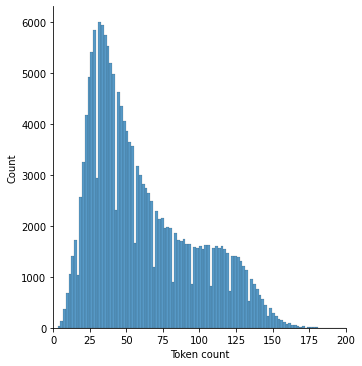

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [ ]:
max_length = 190

### Encode messages

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(dataset_train), len(dataset_val)

(116334, 26197)

In [ ]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [ ]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [ ]:
# len(dataset_train), len(dataset_val)

# Model "bert-base-multilingual-cased"

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32102, 768)

In [ ]:
from tqdm import tqdm

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsUNK/finetuned_lvBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:02<?, ?it/s, training_loss=0.359]

Epoch 1:   0%|          | 1/3636 [00:02<2:20:33,  2.32s/it, training_loss=0.359]

Epoch 1:   0%|          | 1/3636 [00:04<2:20:33,  2.32s/it, training_loss=0.374]

Epoch 1:   0%|          | 2/3636 [00:04<2:17:35,  2.27s/it, training_loss=0.374]

Epoch 1:   0%|          | 2/3636 [00:06<2:17:35,  2.27s/it, training_loss=0.375]

Epoch 1:   0%|          | 3/3636 [00:06<2:16:36,  2.26s/it, training_loss=0.375]

Epoch 1:   0%|          | 3/3636 [00:09<2:16:36,  2.26s/it, training_loss=0.367]

Epoch 1:   0%|          | 4/3636 [00:09<2:16:06,  2.25s/it, training_loss=0.367]

Epoch 1:   0%|          | 4/3636 [00:11<2:16:06,  2.25s/it, training_loss=0.367]

Epoch 1:   0%|          | 5/3636 [00:11<2:15:50,  2.24s/it, training_loss=0.367]

Epoch 1:   0%|          | 5/3636 [00:13<2:15:50,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 6/3636 [00:13<2:15:37,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 6/3636 [00:15<2:15:37,  2.24s/it, training_loss=0.373]

Epoch 1:   0%|          | 7/3636 [00:15<2:15:30,  2.24s/it, training_loss=0.373]

Epoch 1:   0%|          | 7/3636 [00:17<2:15:30,  2.24s/it, training_loss=0.376]

Epoch 1:   0%|          | 8/3636 [00:17<2:15:28,  2.24s/it, training_loss=0.376]

Epoch 1:   0%|          | 8/3636 [00:20<2:15:28,  2.24s/it, training_loss=0.364]

Epoch 1:   0%|          | 9/3636 [00:20<2:15:29,  2.24s/it, training_loss=0.364]

Epoch 1:   0%|          | 9/3636 [00:22<2:15:29,  2.24s/it, training_loss=0.367]

Epoch 1:   0%|          | 10/3636 [00:22<2:15:29,  2.24s/it, training_loss=0.367]

Epoch 1:   0%|          | 10/3636 [00:24<2:15:29,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 11/3636 [00:24<2:15:26,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 11/3636 [00:26<2:15:26,  2.24s/it, training_loss=0.367]

Epoch 1:   0%|          | 12/3636 [00:26<2:15:24,  2.24s/it, training_loss=0.367]

Epoch 1:   0%|          | 12/3636 [00:29<2:15:24,  2.24s/it, training_loss=0.376]

Epoch 1:   0%|          | 13/3636 [00:29<2:15:23,  2.24s/it, training_loss=0.376]

Epoch 1:   0%|          | 13/3636 [00:31<2:15:23,  2.24s/it, training_loss=0.378]

Epoch 1:   0%|          | 14/3636 [00:31<2:15:18,  2.24s/it, training_loss=0.378]

Epoch 1:   0%|          | 14/3636 [00:33<2:15:18,  2.24s/it, training_loss=0.374]

Epoch 1:   0%|          | 15/3636 [00:33<2:15:16,  2.24s/it, training_loss=0.374]

Epoch 1:   0%|          | 15/3636 [00:35<2:15:16,  2.24s/it, training_loss=0.364]

Epoch 1:   0%|          | 16/3636 [00:35<2:15:14,  2.24s/it, training_loss=0.364]

Epoch 1:   0%|          | 16/3636 [00:38<2:15:14,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 17/3636 [00:38<2:15:10,  2.24s/it, training_loss=0.357]

Epoch 1:   0%|          | 17/3636 [00:40<2:15:10,  2.24s/it, training_loss=0.361]

Epoch 1:   0%|          | 18/3636 [00:40<2:15:07,  2.24s/it, training_loss=0.361]

Epoch 1:   0%|          | 18/3636 [00:42<2:15:07,  2.24s/it, training_loss=0.367]

Epoch 1:   1%|          | 19/3636 [00:42<2:15:02,  2.24s/it, training_loss=0.367]

Epoch 1:   1%|          | 19/3636 [00:44<2:15:02,  2.24s/it, training_loss=0.367]

Epoch 1:   1%|          | 20/3636 [00:44<2:14:57,  2.24s/it, training_loss=0.367]

Epoch 1:   1%|          | 20/3636 [00:47<2:14:57,  2.24s/it, training_loss=0.366]

Epoch 1:   1%|          | 21/3636 [00:47<2:14:44,  2.24s/it, training_loss=0.366]

Epoch 1:   1%|          | 21/3636 [00:49<2:14:44,  2.24s/it, training_loss=0.365]

Epoch 1:   1%|          | 22/3636 [00:49<2:14:33,  2.23s/it, training_loss=0.365]

Epoch 1:   1%|          | 22/3636 [00:51<2:14:33,  2.23s/it, training_loss=0.355]

Epoch 1:   1%|          | 23/3636 [00:51<2:14:24,  2.23s/it, training_loss=0.355]

Epoch 1:   1%|          | 23/3636 [00:53<2:14:24,  2.23s/it, training_loss=0.355]

Epoch 1:   1%|          | 24/3636 [00:53<2:14:24,  2.23s/it, training_loss=0.355]

Epoch 1:   1%|          | 24/3636 [00:56<2:14:24,  2.23s/it, training_loss=0.363]

Epoch 1:   1%|          | 25/3636 [00:56<2:14:18,  2.23s/it, training_loss=0.363]

Epoch 1:   1%|          | 25/3636 [00:58<2:14:18,  2.23s/it, training_loss=0.364]

Epoch 1:   1%|          | 26/3636 [00:58<2:14:13,  2.23s/it, training_loss=0.364]

Epoch 1:   1%|          | 26/3636 [01:00<2:14:13,  2.23s/it, training_loss=0.369]

Epoch 1:   1%|          | 27/3636 [01:00<2:14:11,  2.23s/it, training_loss=0.369]

Epoch 1:   1%|          | 27/3636 [01:02<2:14:11,  2.23s/it, training_loss=0.358]

Epoch 1:   1%|          | 28/3636 [01:02<2:14:11,  2.23s/it, training_loss=0.358]

Epoch 1:   1%|          | 28/3636 [01:04<2:14:11,  2.23s/it, training_loss=0.367]

Epoch 1:   1%|          | 29/3636 [01:04<2:14:04,  2.23s/it, training_loss=0.367]

Epoch 1:   1%|          | 29/3636 [01:07<2:14:04,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 30/3636 [01:07<2:14:03,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 30/3636 [01:09<2:14:03,  2.23s/it, training_loss=0.361]

Epoch 1:   1%|          | 31/3636 [01:09<2:14:05,  2.23s/it, training_loss=0.361]

Epoch 1:   1%|          | 31/3636 [01:11<2:14:05,  2.23s/it, training_loss=0.354]

Epoch 1:   1%|          | 32/3636 [01:11<2:14:03,  2.23s/it, training_loss=0.354]

Epoch 1:   1%|          | 32/3636 [01:13<2:14:03,  2.23s/it, training_loss=0.340]

Epoch 1:   1%|          | 33/3636 [01:13<2:13:56,  2.23s/it, training_loss=0.340]

Epoch 1:   1%|          | 33/3636 [01:16<2:13:56,  2.23s/it, training_loss=0.353]

Epoch 1:   1%|          | 34/3636 [01:16<2:13:48,  2.23s/it, training_loss=0.353]

Epoch 1:   1%|          | 34/3636 [01:18<2:13:48,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|          | 35/3636 [01:18<2:13:41,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|          | 35/3636 [01:20<2:13:41,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 36/3636 [01:20<2:13:38,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 36/3636 [01:22<2:13:38,  2.23s/it, training_loss=0.352]

Epoch 1:   1%|          | 37/3636 [01:22<2:13:37,  2.23s/it, training_loss=0.352]

Epoch 1:   1%|          | 37/3636 [01:25<2:13:37,  2.23s/it, training_loss=0.351]

Epoch 1:   1%|          | 38/3636 [01:25<2:13:35,  2.23s/it, training_loss=0.351]

Epoch 1:   1%|          | 38/3636 [01:27<2:13:35,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 39/3636 [01:27<2:13:33,  2.23s/it, training_loss=0.362]

Epoch 1:   1%|          | 39/3636 [01:29<2:13:33,  2.23s/it, training_loss=0.350]

Epoch 1:   1%|          | 40/3636 [01:29<2:13:33,  2.23s/it, training_loss=0.350]

Epoch 1:   1%|          | 40/3636 [01:31<2:13:33,  2.23s/it, training_loss=0.358]

Epoch 1:   1%|          | 41/3636 [01:31<2:13:35,  2.23s/it, training_loss=0.358]

Epoch 1:   1%|          | 41/3636 [01:33<2:13:35,  2.23s/it, training_loss=0.370]

Epoch 1:   1%|          | 42/3636 [01:33<2:13:31,  2.23s/it, training_loss=0.370]

Epoch 1:   1%|          | 42/3636 [01:36<2:13:31,  2.23s/it, training_loss=0.368]

Epoch 1:   1%|          | 43/3636 [01:36<2:13:32,  2.23s/it, training_loss=0.368]

Epoch 1:   1%|          | 43/3636 [01:38<2:13:32,  2.23s/it, training_loss=0.352]

Epoch 1:   1%|          | 44/3636 [01:38<2:13:30,  2.23s/it, training_loss=0.352]

Epoch 1:   1%|          | 44/3636 [01:40<2:13:30,  2.23s/it, training_loss=0.389]

Epoch 1:   1%|          | 45/3636 [01:40<2:13:26,  2.23s/it, training_loss=0.389]

Epoch 1:   1%|          | 45/3636 [01:42<2:13:26,  2.23s/it, training_loss=0.376]

Epoch 1:   1%|▏         | 46/3636 [01:42<2:13:24,  2.23s/it, training_loss=0.376]

Epoch 1:   1%|▏         | 46/3636 [01:45<2:13:24,  2.23s/it, training_loss=0.374]

Epoch 1:   1%|▏         | 47/3636 [01:45<2:13:21,  2.23s/it, training_loss=0.374]

Epoch 1:   1%|▏         | 47/3636 [01:47<2:13:21,  2.23s/it, training_loss=0.351]

Epoch 1:   1%|▏         | 48/3636 [01:47<2:13:20,  2.23s/it, training_loss=0.351]

Epoch 1:   1%|▏         | 48/3636 [01:49<2:13:20,  2.23s/it, training_loss=0.364]

Epoch 1:   1%|▏         | 49/3636 [01:49<2:13:19,  2.23s/it, training_loss=0.364]

Epoch 1:   1%|▏         | 49/3636 [01:51<2:13:19,  2.23s/it, training_loss=0.357]

Epoch 1:   1%|▏         | 50/3636 [01:51<2:13:14,  2.23s/it, training_loss=0.357]

Epoch 1:   1%|▏         | 50/3636 [01:53<2:13:14,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 51/3636 [01:53<2:13:12,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 51/3636 [01:56<2:13:12,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 52/3636 [01:56<2:13:09,  2.23s/it, training_loss=0.366]

Epoch 1:   1%|▏         | 52/3636 [01:58<2:13:09,  2.23s/it, training_loss=0.356]

Epoch 1:   1%|▏         | 53/3636 [01:58<2:13:12,  2.23s/it, training_loss=0.356]

Epoch 1:   1%|▏         | 53/3636 [02:00<2:13:12,  2.23s/it, training_loss=0.350]

Epoch 1:   1%|▏         | 54/3636 [02:00<2:13:17,  2.23s/it, training_loss=0.350]

Epoch 1:   1%|▏         | 54/3636 [02:02<2:13:17,  2.23s/it, training_loss=0.349]

Epoch 1:   2%|▏         | 55/3636 [02:02<2:13:13,  2.23s/it, training_loss=0.349]

Epoch 1:   2%|▏         | 55/3636 [02:05<2:13:13,  2.23s/it, training_loss=0.354]

Epoch 1:   2%|▏         | 56/3636 [02:05<2:13:06,  2.23s/it, training_loss=0.354]

Epoch 1:   2%|▏         | 56/3636 [02:07<2:13:06,  2.23s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 57/3636 [02:07<2:13:16,  2.23s/it, training_loss=0.363]

Epoch 1:   2%|▏         | 57/3636 [02:09<2:13:16,  2.23s/it, training_loss=0.384]

Epoch 1:   2%|▏         | 58/3636 [02:09<2:13:22,  2.24s/it, training_loss=0.384]

Epoch 1:   2%|▏         | 58/3636 [02:11<2:13:22,  2.24s/it, training_loss=0.350]

Epoch 1:   2%|▏         | 59/3636 [02:11<2:13:28,  2.24s/it, training_loss=0.350]

Epoch 1:   2%|▏         | 59/3636 [02:14<2:13:28,  2.24s/it, training_loss=0.338]

Epoch 1:   2%|▏         | 60/3636 [02:14<2:13:30,  2.24s/it, training_loss=0.338]

Epoch 1:   2%|▏         | 60/3636 [02:16<2:13:30,  2.24s/it, training_loss=0.354]

Epoch 1:   2%|▏         | 61/3636 [02:16<2:13:29,  2.24s/it, training_loss=0.354]

Epoch 1:   2%|▏         | 61/3636 [02:18<2:13:29,  2.24s/it, training_loss=0.335]

Epoch 1:   2%|▏         | 62/3636 [02:18<2:13:31,  2.24s/it, training_loss=0.335]

Epoch 1:   2%|▏         | 62/3636 [02:20<2:13:31,  2.24s/it, training_loss=0.376]

Epoch 1:   2%|▏         | 63/3636 [02:20<2:13:31,  2.24s/it, training_loss=0.376]

Epoch 1:   2%|▏         | 63/3636 [02:23<2:13:31,  2.24s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 64/3636 [02:23<2:13:29,  2.24s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 64/3636 [02:25<2:13:29,  2.24s/it, training_loss=0.356]

Epoch 1:   2%|▏         | 65/3636 [02:25<2:13:29,  2.24s/it, training_loss=0.356]

Epoch 1:   2%|▏         | 65/3636 [02:27<2:13:29,  2.24s/it, training_loss=0.385]

Epoch 1:   2%|▏         | 66/3636 [02:27<2:13:28,  2.24s/it, training_loss=0.385]

Epoch 1:   2%|▏         | 66/3636 [02:29<2:13:28,  2.24s/it, training_loss=0.356]

Epoch 1:   2%|▏         | 67/3636 [02:29<2:13:27,  2.24s/it, training_loss=0.356]

Epoch 1:   2%|▏         | 67/3636 [02:32<2:13:27,  2.24s/it, training_loss=0.333]

Epoch 1:   2%|▏         | 68/3636 [02:32<2:13:26,  2.24s/it, training_loss=0.333]

Epoch 1:   2%|▏         | 68/3636 [02:34<2:13:26,  2.24s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 69/3636 [02:34<2:13:27,  2.24s/it, training_loss=0.369]

Epoch 1:   2%|▏         | 69/3636 [02:36<2:13:27,  2.24s/it, training_loss=0.342]

Epoch 1:   2%|▏         | 70/3636 [02:36<2:13:24,  2.24s/it, training_loss=0.342]

Epoch 1:   2%|▏         | 70/3636 [02:38<2:13:24,  2.24s/it, training_loss=0.336]

Epoch 1:   2%|▏         | 71/3636 [02:38<2:13:22,  2.24s/it, training_loss=0.336]

Epoch 1:   2%|▏         | 71/3636 [02:41<2:13:22,  2.24s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 72/3636 [02:41<2:13:22,  2.25s/it, training_loss=0.365]

Epoch 1:   2%|▏         | 72/3636 [02:43<2:13:22,  2.25s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 73/3636 [02:43<2:13:20,  2.25s/it, training_loss=0.352]

Epoch 1:   2%|▏         | 73/3636 [02:45<2:13:20,  2.25s/it, training_loss=0.371]

Epoch 1:   2%|▏         | 74/3636 [02:45<2:13:20,  2.25s/it, training_loss=0.371]

Epoch 1:   2%|▏         | 74/3636 [02:47<2:13:20,  2.25s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 75/3636 [02:47<2:13:22,  2.25s/it, training_loss=0.361]

Epoch 1:   2%|▏         | 75/3636 [02:50<2:13:22,  2.25s/it, training_loss=0.370]

Epoch 1:   2%|▏         | 76/3636 [02:50<2:13:16,  2.25s/it, training_loss=0.370]

Epoch 1:   2%|▏         | 76/3636 [02:52<2:13:16,  2.25s/it, training_loss=0.345]

Epoch 1:   2%|▏         | 77/3636 [02:52<2:13:12,  2.25s/it, training_loss=0.345]

Epoch 1:   2%|▏         | 77/3636 [02:54<2:13:12,  2.25s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 78/3636 [02:54<2:13:12,  2.25s/it, training_loss=0.366]

Epoch 1:   2%|▏         | 78/3636 [02:56<2:13:12,  2.25s/it, training_loss=0.318]

Epoch 1:   2%|▏         | 79/3636 [02:56<2:13:08,  2.25s/it, training_loss=0.318]

Epoch 1:   2%|▏         | 79/3636 [02:59<2:13:08,  2.25s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 80/3636 [02:59<2:13:04,  2.25s/it, training_loss=0.358]

Epoch 1:   2%|▏         | 80/3636 [03:01<2:13:04,  2.25s/it, training_loss=0.383]

Epoch 1:   2%|▏         | 81/3636 [03:01<2:13:03,  2.25s/it, training_loss=0.383]

Epoch 1:   2%|▏         | 81/3636 [03:03<2:13:03,  2.25s/it, training_loss=0.362]

Epoch 1:   2%|▏         | 82/3636 [03:03<2:12:58,  2.24s/it, training_loss=0.362]

Epoch 1:   2%|▏         | 82/3636 [03:05<2:12:58,  2.24s/it, training_loss=0.375]

Epoch 1:   2%|▏         | 83/3636 [03:05<2:12:57,  2.25s/it, training_loss=0.375]

Epoch 1:   2%|▏         | 83/3636 [03:08<2:12:57,  2.25s/it, training_loss=0.348]

Epoch 1:   2%|▏         | 84/3636 [03:08<2:12:59,  2.25s/it, training_loss=0.348]

Epoch 1:   2%|▏         | 84/3636 [03:10<2:12:59,  2.25s/it, training_loss=0.373]

Epoch 1:   2%|▏         | 85/3636 [03:10<2:12:55,  2.25s/it, training_loss=0.373]

Epoch 1:   2%|▏         | 85/3636 [03:12<2:12:55,  2.25s/it, training_loss=0.332]

Epoch 1:   2%|▏         | 86/3636 [03:12<2:12:52,  2.25s/it, training_loss=0.332]

Epoch 1:   2%|▏         | 86/3636 [03:14<2:12:52,  2.25s/it, training_loss=0.336]

Epoch 1:   2%|▏         | 87/3636 [03:14<2:12:52,  2.25s/it, training_loss=0.336]

Epoch 1:   2%|▏         | 87/3636 [03:16<2:12:52,  2.25s/it, training_loss=0.346]

Epoch 1:   2%|▏         | 88/3636 [03:16<2:12:47,  2.25s/it, training_loss=0.346]

Epoch 1:   2%|▏         | 88/3636 [03:19<2:12:47,  2.25s/it, training_loss=0.383]

Epoch 1:   2%|▏         | 89/3636 [03:19<2:12:49,  2.25s/it, training_loss=0.383]

Epoch 1:   2%|▏         | 89/3636 [03:21<2:12:49,  2.25s/it, training_loss=0.381]

Epoch 1:   2%|▏         | 90/3636 [03:21<2:12:43,  2.25s/it, training_loss=0.381]

Epoch 1:   2%|▏         | 90/3636 [03:23<2:12:43,  2.25s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 91/3636 [03:23<2:12:41,  2.25s/it, training_loss=0.356]

Epoch 1:   3%|▎         | 91/3636 [03:25<2:12:41,  2.25s/it, training_loss=0.338]

Epoch 1:   3%|▎         | 92/3636 [03:25<2:12:44,  2.25s/it, training_loss=0.338]

Epoch 1:   3%|▎         | 92/3636 [03:28<2:12:44,  2.25s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 93/3636 [03:28<2:12:40,  2.25s/it, training_loss=0.367]

Epoch 1:   3%|▎         | 93/3636 [03:30<2:12:40,  2.25s/it, training_loss=0.343]

Epoch 1:   3%|▎         | 94/3636 [03:30<2:12:40,  2.25s/it, training_loss=0.343]

Epoch 1:   3%|▎         | 94/3636 [03:32<2:12:40,  2.25s/it, training_loss=0.340]

Epoch 1:   3%|▎         | 95/3636 [03:32<2:12:37,  2.25s/it, training_loss=0.340]

Epoch 1:   3%|▎         | 95/3636 [03:34<2:12:37,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 96/3636 [03:34<2:12:36,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 96/3636 [03:37<2:12:36,  2.25s/it, training_loss=0.383]

Epoch 1:   3%|▎         | 97/3636 [03:37<2:12:33,  2.25s/it, training_loss=0.383]

Epoch 1:   3%|▎         | 97/3636 [03:39<2:12:33,  2.25s/it, training_loss=0.349]

Epoch 1:   3%|▎         | 98/3636 [03:39<2:12:33,  2.25s/it, training_loss=0.349]

Epoch 1:   3%|▎         | 98/3636 [03:41<2:12:33,  2.25s/it, training_loss=0.334]

Epoch 1:   3%|▎         | 99/3636 [03:41<2:12:35,  2.25s/it, training_loss=0.334]

Epoch 1:   3%|▎         | 99/3636 [03:43<2:12:35,  2.25s/it, training_loss=0.376]

Epoch 1:   3%|▎         | 100/3636 [03:43<2:12:33,  2.25s/it, training_loss=0.376]

Epoch 1:   3%|▎         | 100/3636 [03:46<2:12:33,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 101/3636 [03:46<2:12:28,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 101/3636 [03:48<2:12:28,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 102/3636 [03:48<2:12:28,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 102/3636 [03:50<2:12:28,  2.25s/it, training_loss=0.353]

Epoch 1:   3%|▎         | 103/3636 [03:50<2:12:26,  2.25s/it, training_loss=0.353]

Epoch 1:   3%|▎         | 103/3636 [03:52<2:12:26,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 104/3636 [03:52<2:12:22,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 104/3636 [03:55<2:12:22,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 105/3636 [03:55<2:12:22,  2.25s/it, training_loss=0.359]

Epoch 1:   3%|▎         | 105/3636 [03:57<2:12:22,  2.25s/it, training_loss=0.372]

Epoch 1:   3%|▎         | 106/3636 [03:57<2:12:20,  2.25s/it, training_loss=0.372]

Epoch 1:   3%|▎         | 106/3636 [03:59<2:12:20,  2.25s/it, training_loss=0.342]

Epoch 1:   3%|▎         | 107/3636 [03:59<2:12:20,  2.25s/it, training_loss=0.342]

Epoch 1:   3%|▎         | 107/3636 [04:01<2:12:20,  2.25s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 108/3636 [04:01<2:12:23,  2.25s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 108/3636 [04:04<2:12:23,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 109/3636 [04:04<2:12:22,  2.25s/it, training_loss=0.351]

Epoch 1:   3%|▎         | 109/3636 [04:06<2:12:22,  2.25s/it, training_loss=0.344]

Epoch 1:   3%|▎         | 110/3636 [04:06<2:12:19,  2.25s/it, training_loss=0.344]

Epoch 1:   3%|▎         | 110/3636 [04:08<2:12:19,  2.25s/it, training_loss=0.341]

Epoch 1:   3%|▎         | 111/3636 [04:08<2:12:15,  2.25s/it, training_loss=0.341]

Epoch 1:   3%|▎         | 111/3636 [04:10<2:12:15,  2.25s/it, training_loss=0.334]

Epoch 1:   3%|▎         | 112/3636 [04:10<2:12:13,  2.25s/it, training_loss=0.334]

Epoch 1:   3%|▎         | 112/3636 [04:13<2:12:13,  2.25s/it, training_loss=0.397]

Epoch 1:   3%|▎         | 113/3636 [04:13<2:12:38,  2.26s/it, training_loss=0.397]

Epoch 1:   3%|▎         | 113/3636 [04:15<2:12:38,  2.26s/it, training_loss=0.373]

Epoch 1:   3%|▎         | 114/3636 [04:15<2:12:29,  2.26s/it, training_loss=0.373]

Epoch 1:   3%|▎         | 114/3636 [04:17<2:12:29,  2.26s/it, training_loss=0.326]

Epoch 1:   3%|▎         | 115/3636 [04:17<2:12:20,  2.26s/it, training_loss=0.326]

Epoch 1:   3%|▎         | 115/3636 [04:20<2:12:20,  2.26s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 116/3636 [04:20<2:12:12,  2.25s/it, training_loss=0.337]

Epoch 1:   3%|▎         | 116/3636 [04:22<2:12:12,  2.25s/it, training_loss=0.323]

Epoch 1:   3%|▎         | 117/3636 [04:22<2:12:10,  2.25s/it, training_loss=0.323]

Epoch 1:   3%|▎         | 117/3636 [04:24<2:12:10,  2.25s/it, training_loss=0.314]

Epoch 1:   3%|▎         | 118/3636 [04:24<2:12:08,  2.25s/it, training_loss=0.314]

Epoch 1:   3%|▎         | 118/3636 [04:26<2:12:08,  2.25s/it, training_loss=0.327]

Epoch 1:   3%|▎         | 119/3636 [04:26<2:12:05,  2.25s/it, training_loss=0.327]

Epoch 1:   3%|▎         | 119/3636 [04:29<2:12:05,  2.25s/it, training_loss=0.322]

Epoch 1:   3%|▎         | 120/3636 [04:29<2:11:59,  2.25s/it, training_loss=0.322]

Epoch 1:   3%|▎         | 120/3636 [04:31<2:11:59,  2.25s/it, training_loss=0.328]

Epoch 1:   3%|▎         | 121/3636 [04:31<2:11:58,  2.25s/it, training_loss=0.328]

Epoch 1:   3%|▎         | 121/3636 [04:33<2:11:58,  2.25s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 122/3636 [04:33<2:11:55,  2.25s/it, training_loss=0.330]

Epoch 1:   3%|▎         | 122/3636 [04:35<2:11:55,  2.25s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 123/3636 [04:35<2:11:54,  2.25s/it, training_loss=0.360]

Epoch 1:   3%|▎         | 123/3636 [04:38<2:11:54,  2.25s/it, training_loss=0.355]

Epoch 1:   3%|▎         | 124/3636 [04:38<2:11:49,  2.25s/it, training_loss=0.355]

Epoch 1:   3%|▎         | 124/3636 [04:40<2:11:49,  2.25s/it, training_loss=0.341]

Epoch 1:   3%|▎         | 125/3636 [04:40<2:11:48,  2.25s/it, training_loss=0.341]

Epoch 1:   3%|▎         | 125/3636 [04:42<2:11:48,  2.25s/it, training_loss=0.372]

Epoch 1:   3%|▎         | 126/3636 [04:42<2:11:45,  2.25s/it, training_loss=0.372]

Epoch 1:   3%|▎         | 126/3636 [04:44<2:11:45,  2.25s/it, training_loss=0.384]

Epoch 1:   3%|▎         | 127/3636 [04:44<2:11:47,  2.25s/it, training_loss=0.384]

Epoch 1:   3%|▎         | 127/3636 [04:47<2:11:47,  2.25s/it, training_loss=0.356]

Epoch 1:   4%|▎         | 128/3636 [04:47<2:11:50,  2.26s/it, training_loss=0.356]

Epoch 1:   4%|▎         | 128/3636 [04:49<2:11:50,  2.26s/it, training_loss=0.318]

Epoch 1:   4%|▎         | 129/3636 [04:49<2:11:47,  2.25s/it, training_loss=0.318]

Epoch 1:   4%|▎         | 129/3636 [04:51<2:11:47,  2.25s/it, training_loss=0.330]

Epoch 1:   4%|▎         | 130/3636 [04:51<2:11:45,  2.25s/it, training_loss=0.330]

Epoch 1:   4%|▎         | 130/3636 [04:53<2:11:45,  2.25s/it, training_loss=0.359]

Epoch 1:   4%|▎         | 131/3636 [04:53<2:11:45,  2.26s/it, training_loss=0.359]

Epoch 1:   4%|▎         | 131/3636 [04:56<2:11:45,  2.26s/it, training_loss=0.397]

Epoch 1:   4%|▎         | 132/3636 [04:56<2:11:41,  2.25s/it, training_loss=0.397]

Epoch 1:   4%|▎         | 132/3636 [04:58<2:11:41,  2.25s/it, training_loss=0.349]

Epoch 1:   4%|▎         | 133/3636 [04:58<2:11:36,  2.25s/it, training_loss=0.349]

Epoch 1:   4%|▎         | 133/3636 [05:00<2:11:36,  2.25s/it, training_loss=0.376]

Epoch 1:   4%|▎         | 134/3636 [05:00<2:11:35,  2.25s/it, training_loss=0.376]

Epoch 1:   4%|▎         | 134/3636 [05:02<2:11:35,  2.25s/it, training_loss=0.352]

Epoch 1:   4%|▎         | 135/3636 [05:02<2:11:32,  2.25s/it, training_loss=0.352]

Epoch 1:   4%|▎         | 135/3636 [05:05<2:11:32,  2.25s/it, training_loss=0.365]

Epoch 1:   4%|▎         | 136/3636 [05:05<2:11:26,  2.25s/it, training_loss=0.365]

Epoch 1:   4%|▎         | 136/3636 [05:07<2:11:26,  2.25s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 137/3636 [05:07<2:11:24,  2.25s/it, training_loss=0.324]

Epoch 1:   4%|▍         | 137/3636 [05:09<2:11:24,  2.25s/it, training_loss=0.347]

Epoch 1:   4%|▍         | 138/3636 [05:09<2:11:20,  2.25s/it, training_loss=0.347]

Epoch 1:   4%|▍         | 138/3636 [05:11<2:11:20,  2.25s/it, training_loss=0.378]

Epoch 1:   4%|▍         | 139/3636 [05:11<2:11:18,  2.25s/it, training_loss=0.378]

Epoch 1:   4%|▍         | 139/3636 [05:14<2:11:18,  2.25s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 140/3636 [05:14<2:11:15,  2.25s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 140/3636 [05:16<2:11:15,  2.25s/it, training_loss=0.330]

Epoch 1:   4%|▍         | 141/3636 [05:16<2:11:15,  2.25s/it, training_loss=0.330]

Epoch 1:   4%|▍         | 141/3636 [05:18<2:11:15,  2.25s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 142/3636 [05:18<2:11:14,  2.25s/it, training_loss=0.339]

Epoch 1:   4%|▍         | 142/3636 [05:20<2:11:14,  2.25s/it, training_loss=0.332]

Epoch 1:   4%|▍         | 143/3636 [05:20<2:11:10,  2.25s/it, training_loss=0.332]

Epoch 1:   4%|▍         | 143/3636 [05:23<2:11:10,  2.25s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 144/3636 [05:23<2:11:07,  2.25s/it, training_loss=0.359]

Epoch 1:   4%|▍         | 144/3636 [05:25<2:11:07,  2.25s/it, training_loss=0.338]

Epoch 1:   4%|▍         | 145/3636 [05:25<2:11:04,  2.25s/it, training_loss=0.338]

Epoch 1:   4%|▍         | 145/3636 [05:27<2:11:04,  2.25s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 146/3636 [05:27<2:11:03,  2.25s/it, training_loss=0.346]

Epoch 1:   4%|▍         | 146/3636 [05:29<2:11:03,  2.25s/it, training_loss=0.350]

Epoch 1:   4%|▍         | 147/3636 [05:29<2:11:00,  2.25s/it, training_loss=0.350]

Epoch 1:   4%|▍         | 147/3636 [05:32<2:11:00,  2.25s/it, training_loss=0.364]

Epoch 1:   4%|▍         | 148/3636 [05:32<2:10:56,  2.25s/it, training_loss=0.364]

Epoch 1:   4%|▍         | 148/3636 [05:34<2:10:56,  2.25s/it, training_loss=0.373]

Epoch 1:   4%|▍         | 149/3636 [05:34<2:10:55,  2.25s/it, training_loss=0.373]

Epoch 1:   4%|▍         | 149/3636 [05:36<2:10:55,  2.25s/it, training_loss=0.360]

Epoch 1:   4%|▍         | 150/3636 [05:36<2:10:52,  2.25s/it, training_loss=0.360]

Epoch 1:   4%|▍         | 150/3636 [05:38<2:10:52,  2.25s/it, training_loss=0.355]

Epoch 1:   4%|▍         | 151/3636 [05:38<2:10:47,  2.25s/it, training_loss=0.355]

Epoch 1:   4%|▍         | 151/3636 [05:41<2:10:47,  2.25s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 152/3636 [05:41<2:10:44,  2.25s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 152/3636 [05:43<2:10:44,  2.25s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 153/3636 [05:43<2:10:44,  2.25s/it, training_loss=0.354]

Epoch 1:   4%|▍         | 153/3636 [05:45<2:10:44,  2.25s/it, training_loss=0.348]

Epoch 1:   4%|▍         | 154/3636 [05:45<2:10:43,  2.25s/it, training_loss=0.348]

Epoch 1:   4%|▍         | 154/3636 [05:47<2:10:43,  2.25s/it, training_loss=0.347]

Epoch 1:   4%|▍         | 155/3636 [05:47<2:10:40,  2.25s/it, training_loss=0.347]

Epoch 1:   4%|▍         | 155/3636 [05:50<2:10:40,  2.25s/it, training_loss=0.343]

Epoch 1:   4%|▍         | 156/3636 [05:50<2:10:40,  2.25s/it, training_loss=0.343]

Epoch 1:   4%|▍         | 156/3636 [05:52<2:10:40,  2.25s/it, training_loss=0.344]

Epoch 1:   4%|▍         | 157/3636 [05:52<2:10:42,  2.25s/it, training_loss=0.344]

Epoch 1:   4%|▍         | 157/3636 [05:54<2:10:42,  2.25s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 158/3636 [05:54<2:10:40,  2.25s/it, training_loss=0.328]

Epoch 1:   4%|▍         | 158/3636 [05:56<2:10:40,  2.25s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 159/3636 [05:56<2:10:36,  2.25s/it, training_loss=0.357]

Epoch 1:   4%|▍         | 159/3636 [05:59<2:10:36,  2.25s/it, training_loss=0.337]

Epoch 1:   4%|▍         | 160/3636 [05:59<2:10:33,  2.25s/it, training_loss=0.337]

Epoch 1:   4%|▍         | 160/3636 [06:01<2:10:33,  2.25s/it, training_loss=0.358]

Epoch 1:   4%|▍         | 161/3636 [06:01<2:10:36,  2.26s/it, training_loss=0.358]

Epoch 1:   4%|▍         | 161/3636 [06:03<2:10:36,  2.26s/it, training_loss=0.313]

Epoch 1:   4%|▍         | 162/3636 [06:03<2:10:31,  2.25s/it, training_loss=0.313]

Epoch 1:   4%|▍         | 162/3636 [06:05<2:10:31,  2.25s/it, training_loss=0.320]

Epoch 1:   4%|▍         | 163/3636 [06:05<2:10:32,  2.26s/it, training_loss=0.320]

Epoch 1:   4%|▍         | 163/3636 [06:08<2:10:32,  2.26s/it, training_loss=0.364]

Epoch 1:   5%|▍         | 164/3636 [06:08<2:10:32,  2.26s/it, training_loss=0.364]

Epoch 1:   5%|▍         | 164/3636 [06:10<2:10:32,  2.26s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 165/3636 [06:10<2:10:34,  2.26s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 165/3636 [06:12<2:10:34,  2.26s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 166/3636 [06:12<2:10:30,  2.26s/it, training_loss=0.362]

Epoch 1:   5%|▍         | 166/3636 [06:14<2:10:30,  2.26s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 167/3636 [06:14<2:10:26,  2.26s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 167/3636 [06:17<2:10:26,  2.26s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 168/3636 [06:17<2:10:24,  2.26s/it, training_loss=0.350]

Epoch 1:   5%|▍         | 168/3636 [06:19<2:10:24,  2.26s/it, training_loss=0.337]

Epoch 1:   5%|▍         | 169/3636 [06:19<2:10:23,  2.26s/it, training_loss=0.337]

Epoch 1:   5%|▍         | 169/3636 [06:21<2:10:23,  2.26s/it, training_loss=0.359]

Epoch 1:   5%|▍         | 170/3636 [06:21<2:10:24,  2.26s/it, training_loss=0.359]

Epoch 1:   5%|▍         | 170/3636 [06:23<2:10:24,  2.26s/it, training_loss=0.347]

Epoch 1:   5%|▍         | 171/3636 [06:23<2:10:23,  2.26s/it, training_loss=0.347]

Epoch 1:   5%|▍         | 171/3636 [06:26<2:10:23,  2.26s/it, training_loss=0.315]

Epoch 1:   5%|▍         | 172/3636 [06:26<2:10:17,  2.26s/it, training_loss=0.315]

Epoch 1:   5%|▍         | 172/3636 [06:28<2:10:17,  2.26s/it, training_loss=0.367]

Epoch 1:   5%|▍         | 173/3636 [06:28<2:10:15,  2.26s/it, training_loss=0.367]

Epoch 1:   5%|▍         | 173/3636 [06:30<2:10:15,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 174/3636 [06:30<2:10:12,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 174/3636 [06:32<2:10:12,  2.26s/it, training_loss=0.338]

Epoch 1:   5%|▍         | 175/3636 [06:33<2:10:10,  2.26s/it, training_loss=0.338]

Epoch 1:   5%|▍         | 175/3636 [06:35<2:10:10,  2.26s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 176/3636 [06:35<2:10:05,  2.26s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 176/3636 [06:37<2:10:05,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 177/3636 [06:37<2:10:02,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▍         | 177/3636 [06:39<2:10:02,  2.26s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 178/3636 [06:39<2:09:58,  2.26s/it, training_loss=0.343]

Epoch 1:   5%|▍         | 178/3636 [06:42<2:09:58,  2.26s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 179/3636 [06:42<2:09:59,  2.26s/it, training_loss=0.344]

Epoch 1:   5%|▍         | 179/3636 [06:44<2:09:59,  2.26s/it, training_loss=0.369]

Epoch 1:   5%|▍         | 180/3636 [06:44<2:09:58,  2.26s/it, training_loss=0.369]

Epoch 1:   5%|▍         | 180/3636 [06:46<2:09:58,  2.26s/it, training_loss=0.309]

Epoch 1:   5%|▍         | 181/3636 [06:46<2:09:55,  2.26s/it, training_loss=0.309]

Epoch 1:   5%|▍         | 181/3636 [06:48<2:09:55,  2.26s/it, training_loss=0.315]

Epoch 1:   5%|▌         | 182/3636 [06:48<2:09:52,  2.26s/it, training_loss=0.315]

Epoch 1:   5%|▌         | 182/3636 [06:51<2:09:52,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▌         | 183/3636 [06:51<2:09:52,  2.26s/it, training_loss=0.360]

Epoch 1:   5%|▌         | 183/3636 [06:53<2:09:52,  2.26s/it, training_loss=0.330]

Epoch 1:   5%|▌         | 184/3636 [06:53<2:09:51,  2.26s/it, training_loss=0.330]

Epoch 1:   5%|▌         | 184/3636 [06:55<2:09:51,  2.26s/it, training_loss=0.318]

Epoch 1:   5%|▌         | 185/3636 [06:55<2:09:51,  2.26s/it, training_loss=0.318]

Epoch 1:   5%|▌         | 185/3636 [06:57<2:09:51,  2.26s/it, training_loss=0.329]

Epoch 1:   5%|▌         | 186/3636 [06:57<2:09:48,  2.26s/it, training_loss=0.329]

Epoch 1:   5%|▌         | 186/3636 [07:00<2:09:48,  2.26s/it, training_loss=0.313]

Epoch 1:   5%|▌         | 187/3636 [07:00<2:09:43,  2.26s/it, training_loss=0.313]

Epoch 1:   5%|▌         | 187/3636 [07:02<2:09:43,  2.26s/it, training_loss=0.297]

Epoch 1:   5%|▌         | 188/3636 [07:02<2:09:40,  2.26s/it, training_loss=0.297]

Epoch 1:   5%|▌         | 188/3636 [07:04<2:09:40,  2.26s/it, training_loss=0.325]

Epoch 1:   5%|▌         | 189/3636 [07:04<2:09:38,  2.26s/it, training_loss=0.325]

Epoch 1:   5%|▌         | 189/3636 [07:06<2:09:38,  2.26s/it, training_loss=0.333]

Epoch 1:   5%|▌         | 190/3636 [07:06<2:09:39,  2.26s/it, training_loss=0.333]

Epoch 1:   5%|▌         | 190/3636 [07:09<2:09:39,  2.26s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 191/3636 [07:09<2:09:41,  2.26s/it, training_loss=0.363]

Epoch 1:   5%|▌         | 191/3636 [07:11<2:09:41,  2.26s/it, training_loss=0.347]

Epoch 1:   5%|▌         | 192/3636 [07:11<2:09:37,  2.26s/it, training_loss=0.347]

Epoch 1:   5%|▌         | 192/3636 [07:13<2:09:37,  2.26s/it, training_loss=0.341]

Epoch 1:   5%|▌         | 193/3636 [07:13<2:09:36,  2.26s/it, training_loss=0.341]

Epoch 1:   5%|▌         | 193/3636 [07:15<2:09:36,  2.26s/it, training_loss=0.414]

Epoch 1:   5%|▌         | 194/3636 [07:15<2:09:37,  2.26s/it, training_loss=0.414]

Epoch 1:   5%|▌         | 194/3636 [07:18<2:09:37,  2.26s/it, training_loss=0.346]

Epoch 1:   5%|▌         | 195/3636 [07:18<2:09:33,  2.26s/it, training_loss=0.346]

Epoch 1:   5%|▌         | 195/3636 [07:20<2:09:33,  2.26s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 196/3636 [07:20<2:09:31,  2.26s/it, training_loss=0.353]

Epoch 1:   5%|▌         | 196/3636 [07:22<2:09:31,  2.26s/it, training_loss=0.354]

Epoch 1:   5%|▌         | 197/3636 [07:22<2:09:31,  2.26s/it, training_loss=0.354]

Epoch 1:   5%|▌         | 197/3636 [07:24<2:09:31,  2.26s/it, training_loss=0.401]

Epoch 1:   5%|▌         | 198/3636 [07:24<2:09:22,  2.26s/it, training_loss=0.401]

Epoch 1:   5%|▌         | 198/3636 [07:27<2:09:22,  2.26s/it, training_loss=0.321]

Epoch 1:   5%|▌         | 199/3636 [07:27<2:09:21,  2.26s/it, training_loss=0.321]

Epoch 1:   5%|▌         | 199/3636 [07:29<2:09:21,  2.26s/it, training_loss=0.383]

Epoch 1:   6%|▌         | 200/3636 [07:29<2:09:18,  2.26s/it, training_loss=0.383]

Epoch 1:   6%|▌         | 200/3636 [07:31<2:09:18,  2.26s/it, training_loss=0.334]

Epoch 1:   6%|▌         | 201/3636 [07:31<2:09:13,  2.26s/it, training_loss=0.334]

Epoch 1:   6%|▌         | 201/3636 [07:33<2:09:13,  2.26s/it, training_loss=0.325]

Epoch 1:   6%|▌         | 202/3636 [07:33<2:09:07,  2.26s/it, training_loss=0.325]

Epoch 1:   6%|▌         | 202/3636 [07:36<2:09:07,  2.26s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 203/3636 [07:36<2:09:09,  2.26s/it, training_loss=0.350]

Epoch 1:   6%|▌         | 203/3636 [07:38<2:09:09,  2.26s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 204/3636 [07:38<2:09:04,  2.26s/it, training_loss=0.343]

Epoch 1:   6%|▌         | 204/3636 [07:40<2:09:04,  2.26s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 205/3636 [07:40<2:09:03,  2.26s/it, training_loss=0.327]

Epoch 1:   6%|▌         | 205/3636 [07:42<2:09:03,  2.26s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 206/3636 [07:42<2:09:00,  2.26s/it, training_loss=0.329]

Epoch 1:   6%|▌         | 206/3636 [07:45<2:09:00,  2.26s/it, training_loss=0.299]

Epoch 1:   6%|▌         | 207/3636 [07:45<2:08:55,  2.26s/it, training_loss=0.299]

Epoch 1:   6%|▌         | 207/3636 [07:47<2:08:55,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 208/3636 [07:47<2:08:53,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 208/3636 [07:49<2:08:53,  2.26s/it, training_loss=0.302]

Epoch 1:   6%|▌         | 209/3636 [07:49<2:08:48,  2.26s/it, training_loss=0.302]

Epoch 1:   6%|▌         | 209/3636 [07:51<2:08:48,  2.26s/it, training_loss=0.366]

Epoch 1:   6%|▌         | 210/3636 [07:51<2:08:46,  2.26s/it, training_loss=0.366]

Epoch 1:   6%|▌         | 210/3636 [07:54<2:08:46,  2.26s/it, training_loss=0.369]

Epoch 1:   6%|▌         | 211/3636 [07:54<2:08:46,  2.26s/it, training_loss=0.369]

Epoch 1:   6%|▌         | 211/3636 [07:56<2:08:46,  2.26s/it, training_loss=0.360]

Epoch 1:   6%|▌         | 212/3636 [07:56<2:08:50,  2.26s/it, training_loss=0.360]

Epoch 1:   6%|▌         | 212/3636 [07:58<2:08:50,  2.26s/it, training_loss=0.368]

Epoch 1:   6%|▌         | 213/3636 [07:58<2:08:49,  2.26s/it, training_loss=0.368]

Epoch 1:   6%|▌         | 213/3636 [08:01<2:08:49,  2.26s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 214/3636 [08:01<2:08:46,  2.26s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 214/3636 [08:03<2:08:46,  2.26s/it, training_loss=0.328]

Epoch 1:   6%|▌         | 215/3636 [08:03<2:08:44,  2.26s/it, training_loss=0.328]

Epoch 1:   6%|▌         | 215/3636 [08:05<2:08:44,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 216/3636 [08:05<2:08:40,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 216/3636 [08:07<2:08:40,  2.26s/it, training_loss=0.296]

Epoch 1:   6%|▌         | 217/3636 [08:07<2:08:34,  2.26s/it, training_loss=0.296]

Epoch 1:   6%|▌         | 217/3636 [08:10<2:08:34,  2.26s/it, training_loss=0.351]

Epoch 1:   6%|▌         | 218/3636 [08:10<2:08:32,  2.26s/it, training_loss=0.351]

Epoch 1:   6%|▌         | 218/3636 [08:12<2:08:32,  2.26s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 219/3636 [08:12<2:08:27,  2.26s/it, training_loss=0.344]

Epoch 1:   6%|▌         | 219/3636 [08:14<2:08:27,  2.26s/it, training_loss=0.348]

Epoch 1:   6%|▌         | 220/3636 [08:14<2:08:29,  2.26s/it, training_loss=0.348]

Epoch 1:   6%|▌         | 220/3636 [08:16<2:08:29,  2.26s/it, training_loss=0.366]

Epoch 1:   6%|▌         | 221/3636 [08:16<2:08:24,  2.26s/it, training_loss=0.366]

Epoch 1:   6%|▌         | 221/3636 [08:19<2:08:24,  2.26s/it, training_loss=0.359]

Epoch 1:   6%|▌         | 222/3636 [08:19<2:08:24,  2.26s/it, training_loss=0.359]

Epoch 1:   6%|▌         | 222/3636 [08:21<2:08:24,  2.26s/it, training_loss=0.337]

Epoch 1:   6%|▌         | 223/3636 [08:21<2:08:22,  2.26s/it, training_loss=0.337]

Epoch 1:   6%|▌         | 223/3636 [08:23<2:08:22,  2.26s/it, training_loss=0.333]

Epoch 1:   6%|▌         | 224/3636 [08:23<2:08:19,  2.26s/it, training_loss=0.333]

Epoch 1:   6%|▌         | 224/3636 [08:25<2:08:19,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 225/3636 [08:25<2:08:19,  2.26s/it, training_loss=0.342]

Epoch 1:   6%|▌         | 225/3636 [08:28<2:08:19,  2.26s/it, training_loss=0.335]

Epoch 1:   6%|▌         | 226/3636 [08:28<2:08:15,  2.26s/it, training_loss=0.335]

Epoch 1:   6%|▌         | 226/3636 [08:30<2:08:15,  2.26s/it, training_loss=0.331]

Epoch 1:   6%|▌         | 227/3636 [08:30<2:08:18,  2.26s/it, training_loss=0.331]

Epoch 1:   6%|▌         | 227/3636 [08:32<2:08:18,  2.26s/it, training_loss=0.332]

Epoch 1:   6%|▋         | 228/3636 [08:32<2:08:13,  2.26s/it, training_loss=0.332]

Epoch 1:   6%|▋         | 228/3636 [08:34<2:08:13,  2.26s/it, training_loss=0.335]

Epoch 1:   6%|▋         | 229/3636 [08:34<2:08:07,  2.26s/it, training_loss=0.335]

Epoch 1:   6%|▋         | 229/3636 [08:37<2:08:07,  2.26s/it, training_loss=0.327]

Epoch 1:   6%|▋         | 230/3636 [08:37<2:08:11,  2.26s/it, training_loss=0.327]

Epoch 1:   6%|▋         | 230/3636 [08:39<2:08:11,  2.26s/it, training_loss=0.379]

Epoch 1:   6%|▋         | 231/3636 [08:39<2:08:06,  2.26s/it, training_loss=0.379]

Epoch 1:   6%|▋         | 231/3636 [08:41<2:08:06,  2.26s/it, training_loss=0.351]

Epoch 1:   6%|▋         | 232/3636 [08:41<2:08:05,  2.26s/it, training_loss=0.351]

Epoch 1:   6%|▋         | 232/3636 [08:43<2:08:05,  2.26s/it, training_loss=0.356]

Epoch 1:   6%|▋         | 233/3636 [08:43<2:08:01,  2.26s/it, training_loss=0.356]

Epoch 1:   6%|▋         | 233/3636 [08:46<2:08:01,  2.26s/it, training_loss=0.348]

Epoch 1:   6%|▋         | 234/3636 [08:46<2:07:55,  2.26s/it, training_loss=0.348]

Epoch 1:   6%|▋         | 234/3636 [08:48<2:07:55,  2.26s/it, training_loss=0.361]

Epoch 1:   6%|▋         | 235/3636 [08:48<2:07:53,  2.26s/it, training_loss=0.361]

Epoch 1:   6%|▋         | 235/3636 [08:50<2:07:53,  2.26s/it, training_loss=0.317]

Epoch 1:   6%|▋         | 236/3636 [08:50<2:07:52,  2.26s/it, training_loss=0.317]

Epoch 1:   6%|▋         | 236/3636 [08:52<2:07:52,  2.26s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 237/3636 [08:52<2:07:51,  2.26s/it, training_loss=0.341]

Epoch 1:   7%|▋         | 237/3636 [08:55<2:07:51,  2.26s/it, training_loss=0.330]

Epoch 1:   7%|▋         | 238/3636 [08:55<2:07:49,  2.26s/it, training_loss=0.330]

Epoch 1:   7%|▋         | 238/3636 [08:57<2:07:49,  2.26s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 239/3636 [08:57<2:07:44,  2.26s/it, training_loss=0.351]

Epoch 1:   7%|▋         | 239/3636 [08:59<2:07:44,  2.26s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 240/3636 [08:59<2:07:43,  2.26s/it, training_loss=0.332]

Epoch 1:   7%|▋         | 240/3636 [09:01<2:07:43,  2.26s/it, training_loss=0.352]

Epoch 1:   7%|▋         | 241/3636 [09:01<2:07:38,  2.26s/it, training_loss=0.352]

Epoch 1:   7%|▋         | 241/3636 [09:04<2:07:38,  2.26s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 242/3636 [09:04<2:07:34,  2.26s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 242/3636 [09:06<2:07:34,  2.26s/it, training_loss=0.342]

Epoch 1:   7%|▋         | 243/3636 [09:06<2:07:29,  2.25s/it, training_loss=0.342]

Epoch 1:   7%|▋         | 243/3636 [09:08<2:07:29,  2.25s/it, training_loss=0.334]

Epoch 1:   7%|▋         | 244/3636 [09:08<2:07:24,  2.25s/it, training_loss=0.334]

Epoch 1:   7%|▋         | 244/3636 [09:10<2:07:24,  2.25s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 245/3636 [09:10<2:07:22,  2.25s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 245/3636 [09:13<2:07:22,  2.25s/it, training_loss=0.328]

Epoch 1:   7%|▋         | 246/3636 [09:13<2:07:22,  2.25s/it, training_loss=0.328]

Epoch 1:   7%|▋         | 246/3636 [09:15<2:07:22,  2.25s/it, training_loss=0.309]

Epoch 1:   7%|▋         | 247/3636 [09:15<2:07:22,  2.25s/it, training_loss=0.309]

Epoch 1:   7%|▋         | 247/3636 [09:17<2:07:22,  2.25s/it, training_loss=0.325]

Epoch 1:   7%|▋         | 248/3636 [09:17<2:07:15,  2.25s/it, training_loss=0.325]

Epoch 1:   7%|▋         | 248/3636 [09:19<2:07:15,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 249/3636 [09:19<2:07:11,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 249/3636 [09:22<2:07:11,  2.25s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 250/3636 [09:22<2:07:07,  2.25s/it, training_loss=0.313]

Epoch 1:   7%|▋         | 250/3636 [09:24<2:07:07,  2.25s/it, training_loss=0.319]

Epoch 1:   7%|▋         | 251/3636 [09:24<2:07:04,  2.25s/it, training_loss=0.319]

Epoch 1:   7%|▋         | 251/3636 [09:26<2:07:04,  2.25s/it, training_loss=0.314]

Epoch 1:   7%|▋         | 252/3636 [09:26<2:06:59,  2.25s/it, training_loss=0.314]

Epoch 1:   7%|▋         | 252/3636 [09:28<2:06:59,  2.25s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 253/3636 [09:28<2:06:58,  2.25s/it, training_loss=0.350]

Epoch 1:   7%|▋         | 253/3636 [09:31<2:06:58,  2.25s/it, training_loss=0.303]

Epoch 1:   7%|▋         | 254/3636 [09:31<2:06:58,  2.25s/it, training_loss=0.303]

Epoch 1:   7%|▋         | 254/3636 [09:33<2:06:58,  2.25s/it, training_loss=0.388]

Epoch 1:   7%|▋         | 255/3636 [09:33<2:06:56,  2.25s/it, training_loss=0.388]

Epoch 1:   7%|▋         | 255/3636 [09:35<2:06:56,  2.25s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 256/3636 [09:35<2:06:50,  2.25s/it, training_loss=0.354]

Epoch 1:   7%|▋         | 256/3636 [09:38<2:06:50,  2.25s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 257/3636 [09:38<2:06:49,  2.25s/it, training_loss=0.347]

Epoch 1:   7%|▋         | 257/3636 [09:40<2:06:49,  2.25s/it, training_loss=0.295]

Epoch 1:   7%|▋         | 258/3636 [09:40<2:06:51,  2.25s/it, training_loss=0.295]

Epoch 1:   7%|▋         | 258/3636 [09:42<2:06:51,  2.25s/it, training_loss=0.334]

Epoch 1:   7%|▋         | 259/3636 [09:42<2:06:49,  2.25s/it, training_loss=0.334]

Epoch 1:   7%|▋         | 259/3636 [09:44<2:06:49,  2.25s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 260/3636 [09:44<2:06:46,  2.25s/it, training_loss=0.348]

Epoch 1:   7%|▋         | 260/3636 [09:47<2:06:46,  2.25s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 261/3636 [09:47<2:06:41,  2.25s/it, training_loss=0.336]

Epoch 1:   7%|▋         | 261/3636 [09:49<2:06:41,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 262/3636 [09:49<2:06:41,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 262/3636 [09:51<2:06:41,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 263/3636 [09:51<2:06:37,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 263/3636 [09:53<2:06:37,  2.25s/it, training_loss=0.367]

Epoch 1:   7%|▋         | 264/3636 [09:53<2:06:32,  2.25s/it, training_loss=0.367]

Epoch 1:   7%|▋         | 264/3636 [09:56<2:06:32,  2.25s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 265/3636 [09:56<2:06:31,  2.25s/it, training_loss=0.326]

Epoch 1:   7%|▋         | 265/3636 [09:58<2:06:31,  2.25s/it, training_loss=0.385]

Epoch 1:   7%|▋         | 266/3636 [09:58<2:06:24,  2.25s/it, training_loss=0.385]

Epoch 1:   7%|▋         | 266/3636 [10:00<2:06:24,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 267/3636 [10:00<2:06:27,  2.25s/it, training_loss=0.339]

Epoch 1:   7%|▋         | 267/3636 [10:02<2:06:27,  2.25s/it, training_loss=0.366]

Epoch 1:   7%|▋         | 268/3636 [10:02<2:06:24,  2.25s/it, training_loss=0.366]

Epoch 1:   7%|▋         | 268/3636 [10:05<2:06:24,  2.25s/it, training_loss=0.369]

Epoch 1:   7%|▋         | 269/3636 [10:05<2:06:21,  2.25s/it, training_loss=0.369]

Epoch 1:   7%|▋         | 269/3636 [10:07<2:06:21,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 270/3636 [10:07<2:06:25,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 270/3636 [10:09<2:06:25,  2.25s/it, training_loss=0.309]

Epoch 1:   7%|▋         | 271/3636 [10:09<2:06:26,  2.25s/it, training_loss=0.309]

Epoch 1:   7%|▋         | 271/3636 [10:11<2:06:26,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 272/3636 [10:11<2:06:20,  2.25s/it, training_loss=0.345]

Epoch 1:   7%|▋         | 272/3636 [10:14<2:06:20,  2.25s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 273/3636 [10:14<2:06:16,  2.25s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 273/3636 [10:16<2:06:16,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 274/3636 [10:16<2:06:12,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 274/3636 [10:18<2:06:12,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 275/3636 [10:18<2:06:10,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 275/3636 [10:20<2:06:10,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 276/3636 [10:20<2:06:02,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 276/3636 [10:23<2:06:02,  2.25s/it, training_loss=0.344]

Epoch 1:   8%|▊         | 277/3636 [10:23<2:05:58,  2.25s/it, training_loss=0.344]

Epoch 1:   8%|▊         | 277/3636 [10:25<2:05:58,  2.25s/it, training_loss=0.292]

Epoch 1:   8%|▊         | 278/3636 [10:25<2:06:00,  2.25s/it, training_loss=0.292]

Epoch 1:   8%|▊         | 278/3636 [10:27<2:06:00,  2.25s/it, training_loss=0.328]

Epoch 1:   8%|▊         | 279/3636 [10:27<2:05:59,  2.25s/it, training_loss=0.328]

Epoch 1:   8%|▊         | 279/3636 [10:29<2:05:59,  2.25s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 280/3636 [10:29<2:05:55,  2.25s/it, training_loss=0.345]

Epoch 1:   8%|▊         | 280/3636 [10:32<2:05:55,  2.25s/it, training_loss=0.342]

Epoch 1:   8%|▊         | 281/3636 [10:32<2:05:50,  2.25s/it, training_loss=0.342]

Epoch 1:   8%|▊         | 281/3636 [10:34<2:05:50,  2.25s/it, training_loss=0.360]

Epoch 1:   8%|▊         | 282/3636 [10:34<2:05:47,  2.25s/it, training_loss=0.360]

Epoch 1:   8%|▊         | 282/3636 [10:36<2:05:47,  2.25s/it, training_loss=0.316]

Epoch 1:   8%|▊         | 283/3636 [10:36<2:05:47,  2.25s/it, training_loss=0.316]

Epoch 1:   8%|▊         | 283/3636 [10:38<2:05:47,  2.25s/it, training_loss=0.302]

Epoch 1:   8%|▊         | 284/3636 [10:38<2:05:44,  2.25s/it, training_loss=0.302]

Epoch 1:   8%|▊         | 284/3636 [10:41<2:05:44,  2.25s/it, training_loss=0.315]

Epoch 1:   8%|▊         | 285/3636 [10:41<2:05:41,  2.25s/it, training_loss=0.315]

Epoch 1:   8%|▊         | 285/3636 [10:43<2:05:41,  2.25s/it, training_loss=0.322]

Epoch 1:   8%|▊         | 286/3636 [10:43<2:05:42,  2.25s/it, training_loss=0.322]

Epoch 1:   8%|▊         | 286/3636 [10:45<2:05:42,  2.25s/it, training_loss=0.310]

Epoch 1:   8%|▊         | 287/3636 [10:45<2:05:39,  2.25s/it, training_loss=0.310]

Epoch 1:   8%|▊         | 287/3636 [10:47<2:05:39,  2.25s/it, training_loss=0.277]

Epoch 1:   8%|▊         | 288/3636 [10:47<2:05:34,  2.25s/it, training_loss=0.277]

Epoch 1:   8%|▊         | 288/3636 [10:50<2:05:34,  2.25s/it, training_loss=0.358]

Epoch 1:   8%|▊         | 289/3636 [10:50<2:05:36,  2.25s/it, training_loss=0.358]

Epoch 1:   8%|▊         | 289/3636 [10:52<2:05:36,  2.25s/it, training_loss=0.319]

Epoch 1:   8%|▊         | 290/3636 [10:52<2:05:34,  2.25s/it, training_loss=0.319]

Epoch 1:   8%|▊         | 290/3636 [10:54<2:05:34,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 291/3636 [10:54<2:05:31,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 291/3636 [10:56<2:05:31,  2.25s/it, training_loss=0.289]

Epoch 1:   8%|▊         | 292/3636 [10:56<2:05:29,  2.25s/it, training_loss=0.289]

Epoch 1:   8%|▊         | 292/3636 [10:59<2:05:29,  2.25s/it, training_loss=0.275]

Epoch 1:   8%|▊         | 293/3636 [10:59<2:05:22,  2.25s/it, training_loss=0.275]

Epoch 1:   8%|▊         | 293/3636 [11:01<2:05:22,  2.25s/it, training_loss=0.302]

Epoch 1:   8%|▊         | 294/3636 [11:01<2:05:20,  2.25s/it, training_loss=0.302]

Epoch 1:   8%|▊         | 294/3636 [11:03<2:05:20,  2.25s/it, training_loss=0.377]

Epoch 1:   8%|▊         | 295/3636 [11:03<2:05:22,  2.25s/it, training_loss=0.377]

Epoch 1:   8%|▊         | 295/3636 [11:05<2:05:22,  2.25s/it, training_loss=0.294]

Epoch 1:   8%|▊         | 296/3636 [11:05<2:05:17,  2.25s/it, training_loss=0.294]

Epoch 1:   8%|▊         | 296/3636 [11:08<2:05:17,  2.25s/it, training_loss=0.370]

Epoch 1:   8%|▊         | 297/3636 [11:08<2:05:15,  2.25s/it, training_loss=0.370]

Epoch 1:   8%|▊         | 297/3636 [11:10<2:05:15,  2.25s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 298/3636 [11:10<2:05:14,  2.25s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 298/3636 [11:12<2:05:14,  2.25s/it, training_loss=0.380]

Epoch 1:   8%|▊         | 299/3636 [11:12<2:05:12,  2.25s/it, training_loss=0.380]

Epoch 1:   8%|▊         | 299/3636 [11:14<2:05:12,  2.25s/it, training_loss=0.411]

Epoch 1:   8%|▊         | 300/3636 [11:14<2:05:13,  2.25s/it, training_loss=0.411]

Epoch 1:   8%|▊         | 300/3636 [11:17<2:05:13,  2.25s/it, training_loss=0.306]

Epoch 1:   8%|▊         | 301/3636 [11:17<2:05:10,  2.25s/it, training_loss=0.306]

Epoch 1:   8%|▊         | 301/3636 [11:19<2:05:10,  2.25s/it, training_loss=0.340]

Epoch 1:   8%|▊         | 302/3636 [11:19<2:05:07,  2.25s/it, training_loss=0.340]

Epoch 1:   8%|▊         | 302/3636 [11:21<2:05:07,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 303/3636 [11:21<2:05:10,  2.25s/it, training_loss=0.331]

Epoch 1:   8%|▊         | 303/3636 [11:23<2:05:10,  2.25s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 304/3636 [11:23<2:05:09,  2.25s/it, training_loss=0.349]

Epoch 1:   8%|▊         | 304/3636 [11:26<2:05:09,  2.25s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 305/3636 [11:26<2:05:14,  2.26s/it, training_loss=0.321]

Epoch 1:   8%|▊         | 305/3636 [11:28<2:05:14,  2.26s/it, training_loss=0.274]

Epoch 1:   8%|▊         | 306/3636 [11:28<2:05:09,  2.26s/it, training_loss=0.274]

Epoch 1:   8%|▊         | 306/3636 [11:30<2:05:09,  2.26s/it, training_loss=0.300]

Epoch 1:   8%|▊         | 307/3636 [11:30<2:05:06,  2.26s/it, training_loss=0.300]

Epoch 1:   8%|▊         | 307/3636 [11:32<2:05:06,  2.26s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 308/3636 [11:32<2:04:59,  2.25s/it, training_loss=0.332]

Epoch 1:   8%|▊         | 308/3636 [11:35<2:04:59,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 309/3636 [11:35<2:04:59,  2.25s/it, training_loss=0.339]

Epoch 1:   8%|▊         | 309/3636 [11:37<2:04:59,  2.25s/it, training_loss=0.355]

Epoch 1:   9%|▊         | 310/3636 [11:37<2:04:58,  2.25s/it, training_loss=0.355]

Epoch 1:   9%|▊         | 310/3636 [11:39<2:04:58,  2.25s/it, training_loss=0.310]

Epoch 1:   9%|▊         | 311/3636 [11:39<2:04:58,  2.26s/it, training_loss=0.310]

Epoch 1:   9%|▊         | 311/3636 [11:41<2:04:58,  2.26s/it, training_loss=0.318]

Epoch 1:   9%|▊         | 312/3636 [11:41<2:04:53,  2.25s/it, training_loss=0.318]

Epoch 1:   9%|▊         | 312/3636 [11:44<2:04:53,  2.25s/it, training_loss=0.306]

Epoch 1:   9%|▊         | 313/3636 [11:44<2:04:51,  2.25s/it, training_loss=0.306]

Epoch 1:   9%|▊         | 313/3636 [11:46<2:04:51,  2.25s/it, training_loss=0.332]

Epoch 1:   9%|▊         | 314/3636 [11:46<2:04:46,  2.25s/it, training_loss=0.332]

Epoch 1:   9%|▊         | 314/3636 [11:48<2:04:46,  2.25s/it, training_loss=0.342]

Epoch 1:   9%|▊         | 315/3636 [11:48<2:04:43,  2.25s/it, training_loss=0.342]

Epoch 1:   9%|▊         | 315/3636 [11:50<2:04:43,  2.25s/it, training_loss=0.386]

Epoch 1:   9%|▊         | 316/3636 [11:50<2:04:42,  2.25s/it, training_loss=0.386]

Epoch 1:   9%|▊         | 316/3636 [11:53<2:04:42,  2.25s/it, training_loss=0.329]

Epoch 1:   9%|▊         | 317/3636 [11:53<2:04:39,  2.25s/it, training_loss=0.329]

Epoch 1:   9%|▊         | 317/3636 [11:55<2:04:39,  2.25s/it, training_loss=0.338]

Epoch 1:   9%|▊         | 318/3636 [11:55<2:04:39,  2.25s/it, training_loss=0.338]

Epoch 1:   9%|▊         | 318/3636 [11:57<2:04:39,  2.25s/it, training_loss=0.283]

Epoch 1:   9%|▉         | 319/3636 [11:57<2:04:38,  2.25s/it, training_loss=0.283]

Epoch 1:   9%|▉         | 319/3636 [11:59<2:04:38,  2.25s/it, training_loss=0.331]

Epoch 1:   9%|▉         | 320/3636 [11:59<2:04:35,  2.25s/it, training_loss=0.331]

Epoch 1:   9%|▉         | 320/3636 [12:02<2:04:35,  2.25s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 321/3636 [12:02<2:04:35,  2.26s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 321/3636 [12:04<2:04:35,  2.26s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 322/3636 [12:04<2:04:38,  2.26s/it, training_loss=0.345]

Epoch 1:   9%|▉         | 322/3636 [12:06<2:04:38,  2.26s/it, training_loss=0.351]

Epoch 1:   9%|▉         | 323/3636 [12:06<2:04:33,  2.26s/it, training_loss=0.351]

Epoch 1:   9%|▉         | 323/3636 [12:08<2:04:33,  2.26s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 324/3636 [12:08<2:04:27,  2.25s/it, training_loss=0.332]

Epoch 1:   9%|▉         | 324/3636 [12:11<2:04:27,  2.25s/it, training_loss=0.313]

Epoch 1:   9%|▉         | 325/3636 [12:11<2:04:24,  2.25s/it, training_loss=0.313]

Epoch 1:   9%|▉         | 325/3636 [12:13<2:04:24,  2.25s/it, training_loss=0.337]

Epoch 1:   9%|▉         | 326/3636 [12:13<2:04:28,  2.26s/it, training_loss=0.337]

Epoch 1:   9%|▉         | 326/3636 [12:15<2:04:28,  2.26s/it, training_loss=0.331]

Epoch 1:   9%|▉         | 327/3636 [12:15<2:04:29,  2.26s/it, training_loss=0.331]

Epoch 1:   9%|▉         | 327/3636 [12:17<2:04:29,  2.26s/it, training_loss=0.342]

Epoch 1:   9%|▉         | 328/3636 [12:17<2:04:26,  2.26s/it, training_loss=0.342]

Epoch 1:   9%|▉         | 328/3636 [12:20<2:04:26,  2.26s/it, training_loss=0.314]

Epoch 1:   9%|▉         | 329/3636 [12:20<2:04:23,  2.26s/it, training_loss=0.314]

Epoch 1:   9%|▉         | 329/3636 [12:22<2:04:23,  2.26s/it, training_loss=0.293]

Epoch 1:   9%|▉         | 330/3636 [12:22<2:04:21,  2.26s/it, training_loss=0.293]

Epoch 1:   9%|▉         | 330/3636 [12:24<2:04:21,  2.26s/it, training_loss=0.299]

Epoch 1:   9%|▉         | 331/3636 [12:24<2:04:19,  2.26s/it, training_loss=0.299]

Epoch 1:   9%|▉         | 331/3636 [12:26<2:04:19,  2.26s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 332/3636 [12:26<2:04:16,  2.26s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 332/3636 [12:29<2:04:16,  2.26s/it, training_loss=0.339]

Epoch 1:   9%|▉         | 333/3636 [12:29<2:04:11,  2.26s/it, training_loss=0.339]

Epoch 1:   9%|▉         | 333/3636 [12:31<2:04:11,  2.26s/it, training_loss=0.375]

Epoch 1:   9%|▉         | 334/3636 [12:31<2:04:09,  2.26s/it, training_loss=0.375]

Epoch 1:   9%|▉         | 334/3636 [12:33<2:04:09,  2.26s/it, training_loss=0.320]

Epoch 1:   9%|▉         | 335/3636 [12:33<2:04:09,  2.26s/it, training_loss=0.320]

Epoch 1:   9%|▉         | 335/3636 [12:36<2:04:09,  2.26s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 336/3636 [12:36<2:04:03,  2.26s/it, training_loss=0.317]

Epoch 1:   9%|▉         | 336/3636 [12:38<2:04:03,  2.26s/it, training_loss=0.347]

Epoch 1:   9%|▉         | 337/3636 [12:38<2:04:02,  2.26s/it, training_loss=0.347]

Epoch 1:   9%|▉         | 337/3636 [12:40<2:04:02,  2.26s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 338/3636 [12:40<2:03:59,  2.26s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 338/3636 [12:42<2:03:59,  2.26s/it, training_loss=0.312]

Epoch 1:   9%|▉         | 339/3636 [12:42<2:03:55,  2.26s/it, training_loss=0.312]

Epoch 1:   9%|▉         | 339/3636 [12:45<2:03:55,  2.26s/it, training_loss=0.353]

Epoch 1:   9%|▉         | 340/3636 [12:45<2:03:53,  2.26s/it, training_loss=0.353]

Epoch 1:   9%|▉         | 340/3636 [12:47<2:03:53,  2.26s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 341/3636 [12:47<2:03:52,  2.26s/it, training_loss=0.348]

Epoch 1:   9%|▉         | 341/3636 [12:49<2:03:52,  2.26s/it, training_loss=0.309]

Epoch 1:   9%|▉         | 342/3636 [12:49<2:03:50,  2.26s/it, training_loss=0.309]

Epoch 1:   9%|▉         | 342/3636 [12:51<2:03:50,  2.26s/it, training_loss=0.290]

Epoch 1:   9%|▉         | 343/3636 [12:51<2:03:45,  2.25s/it, training_loss=0.290]

Epoch 1:   9%|▉         | 343/3636 [12:54<2:03:45,  2.25s/it, training_loss=0.309]

Epoch 1:   9%|▉         | 344/3636 [12:54<2:03:41,  2.25s/it, training_loss=0.309]

Epoch 1:   9%|▉         | 344/3636 [12:56<2:03:41,  2.25s/it, training_loss=0.384]

Epoch 1:   9%|▉         | 345/3636 [12:56<2:03:35,  2.25s/it, training_loss=0.384]

Epoch 1:   9%|▉         | 345/3636 [12:58<2:03:35,  2.25s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 346/3636 [12:58<2:03:33,  2.25s/it, training_loss=0.344]

Epoch 1:  10%|▉         | 346/3636 [13:00<2:03:33,  2.25s/it, training_loss=0.360]

Epoch 1:  10%|▉         | 347/3636 [13:00<2:03:30,  2.25s/it, training_loss=0.360]

Epoch 1:  10%|▉         | 347/3636 [13:03<2:03:30,  2.25s/it, training_loss=0.336]

Epoch 1:  10%|▉         | 348/3636 [13:03<2:03:27,  2.25s/it, training_loss=0.336]

Epoch 1:  10%|▉         | 348/3636 [13:05<2:03:27,  2.25s/it, training_loss=0.321]

Epoch 1:  10%|▉         | 349/3636 [13:05<2:03:22,  2.25s/it, training_loss=0.321]

Epoch 1:  10%|▉         | 349/3636 [13:07<2:03:22,  2.25s/it, training_loss=0.335]

Epoch 1:  10%|▉         | 350/3636 [13:07<2:03:16,  2.25s/it, training_loss=0.335]

Epoch 1:  10%|▉         | 350/3636 [13:09<2:03:16,  2.25s/it, training_loss=0.324]

Epoch 1:  10%|▉         | 351/3636 [13:09<2:03:12,  2.25s/it, training_loss=0.324]

Epoch 1:  10%|▉         | 351/3636 [13:12<2:03:12,  2.25s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 352/3636 [13:12<2:03:11,  2.25s/it, training_loss=0.339]

Epoch 1:  10%|▉         | 352/3636 [13:14<2:03:11,  2.25s/it, training_loss=0.331]

Epoch 1:  10%|▉         | 353/3636 [13:14<2:03:06,  2.25s/it, training_loss=0.331]

Epoch 1:  10%|▉         | 353/3636 [13:16<2:03:06,  2.25s/it, training_loss=0.324]

Epoch 1:  10%|▉         | 354/3636 [13:16<2:03:00,  2.25s/it, training_loss=0.324]

Epoch 1:  10%|▉         | 354/3636 [13:18<2:03:00,  2.25s/it, training_loss=0.334]

Epoch 1:  10%|▉         | 355/3636 [13:18<2:02:55,  2.25s/it, training_loss=0.334]

Epoch 1:  10%|▉         | 355/3636 [13:21<2:02:55,  2.25s/it, training_loss=0.371]

Epoch 1:  10%|▉         | 356/3636 [13:21<2:02:53,  2.25s/it, training_loss=0.371]

Epoch 1:  10%|▉         | 356/3636 [13:23<2:02:53,  2.25s/it, training_loss=0.362]

Epoch 1:  10%|▉         | 357/3636 [13:23<2:02:51,  2.25s/it, training_loss=0.362]

Epoch 1:  10%|▉         | 357/3636 [13:25<2:02:51,  2.25s/it, training_loss=0.309]

Epoch 1:  10%|▉         | 358/3636 [13:25<2:02:52,  2.25s/it, training_loss=0.309]

Epoch 1:  10%|▉         | 358/3636 [13:27<2:02:52,  2.25s/it, training_loss=0.351]

Epoch 1:  10%|▉         | 359/3636 [13:27<2:02:48,  2.25s/it, training_loss=0.351]

Epoch 1:  10%|▉         | 359/3636 [13:30<2:02:48,  2.25s/it, training_loss=0.273]

Epoch 1:  10%|▉         | 360/3636 [13:30<2:02:42,  2.25s/it, training_loss=0.273]

Epoch 1:  10%|▉         | 360/3636 [13:32<2:02:42,  2.25s/it, training_loss=0.307]

Epoch 1:  10%|▉         | 361/3636 [13:32<2:02:41,  2.25s/it, training_loss=0.307]

Epoch 1:  10%|▉         | 361/3636 [13:34<2:02:41,  2.25s/it, training_loss=0.340]

Epoch 1:  10%|▉         | 362/3636 [13:34<2:02:42,  2.25s/it, training_loss=0.340]

Epoch 1:  10%|▉         | 362/3636 [13:36<2:02:42,  2.25s/it, training_loss=0.367]

Epoch 1:  10%|▉         | 363/3636 [13:36<2:02:39,  2.25s/it, training_loss=0.367]

Epoch 1:  10%|▉         | 363/3636 [13:39<2:02:39,  2.25s/it, training_loss=0.323]

Epoch 1:  10%|█         | 364/3636 [13:39<2:02:38,  2.25s/it, training_loss=0.323]

Epoch 1:  10%|█         | 364/3636 [13:41<2:02:38,  2.25s/it, training_loss=0.340]

Epoch 1:  10%|█         | 365/3636 [13:41<2:02:33,  2.25s/it, training_loss=0.340]

Epoch 1:  10%|█         | 365/3636 [13:43<2:02:33,  2.25s/it, training_loss=0.343]

Epoch 1:  10%|█         | 366/3636 [13:43<2:02:33,  2.25s/it, training_loss=0.343]

Epoch 1:  10%|█         | 366/3636 [13:45<2:02:33,  2.25s/it, training_loss=0.312]

Epoch 1:  10%|█         | 367/3636 [13:45<2:02:39,  2.25s/it, training_loss=0.312]

Epoch 1:  10%|█         | 367/3636 [13:48<2:02:39,  2.25s/it, training_loss=0.279]

Epoch 1:  10%|█         | 368/3636 [13:48<2:02:34,  2.25s/it, training_loss=0.279]

Epoch 1:  10%|█         | 368/3636 [13:50<2:02:34,  2.25s/it, training_loss=0.315]

Epoch 1:  10%|█         | 369/3636 [13:50<2:02:28,  2.25s/it, training_loss=0.315]

Epoch 1:  10%|█         | 369/3636 [13:52<2:02:28,  2.25s/it, training_loss=0.351]

Epoch 1:  10%|█         | 370/3636 [13:52<2:02:21,  2.25s/it, training_loss=0.351]

Epoch 1:  10%|█         | 370/3636 [13:54<2:02:21,  2.25s/it, training_loss=0.314]

Epoch 1:  10%|█         | 371/3636 [13:54<2:02:16,  2.25s/it, training_loss=0.314]

Epoch 1:  10%|█         | 371/3636 [13:57<2:02:16,  2.25s/it, training_loss=0.332]

Epoch 1:  10%|█         | 372/3636 [13:57<2:02:07,  2.24s/it, training_loss=0.332]

Epoch 1:  10%|█         | 372/3636 [13:59<2:02:07,  2.24s/it, training_loss=0.407]

Epoch 1:  10%|█         | 373/3636 [13:59<2:02:00,  2.24s/it, training_loss=0.407]

Epoch 1:  10%|█         | 373/3636 [14:01<2:02:00,  2.24s/it, training_loss=0.342]

Epoch 1:  10%|█         | 374/3636 [14:01<2:01:58,  2.24s/it, training_loss=0.342]

Epoch 1:  10%|█         | 374/3636 [14:03<2:01:58,  2.24s/it, training_loss=0.322]

Epoch 1:  10%|█         | 375/3636 [14:03<2:01:56,  2.24s/it, training_loss=0.322]

Epoch 1:  10%|█         | 375/3636 [14:05<2:01:56,  2.24s/it, training_loss=0.315]

Epoch 1:  10%|█         | 376/3636 [14:05<2:01:54,  2.24s/it, training_loss=0.315]

Epoch 1:  10%|█         | 376/3636 [14:08<2:01:54,  2.24s/it, training_loss=0.327]

Epoch 1:  10%|█         | 377/3636 [14:08<2:01:54,  2.24s/it, training_loss=0.327]

Epoch 1:  10%|█         | 377/3636 [14:10<2:01:54,  2.24s/it, training_loss=0.381]

Epoch 1:  10%|█         | 378/3636 [14:10<2:01:48,  2.24s/it, training_loss=0.381]

Epoch 1:  10%|█         | 378/3636 [14:12<2:01:48,  2.24s/it, training_loss=0.320]

Epoch 1:  10%|█         | 379/3636 [14:12<2:01:44,  2.24s/it, training_loss=0.320]

Epoch 1:  10%|█         | 379/3636 [14:14<2:01:44,  2.24s/it, training_loss=0.353]

Epoch 1:  10%|█         | 380/3636 [14:14<2:01:41,  2.24s/it, training_loss=0.353]

Epoch 1:  10%|█         | 380/3636 [14:17<2:01:41,  2.24s/it, training_loss=0.330]

Epoch 1:  10%|█         | 381/3636 [14:17<2:01:40,  2.24s/it, training_loss=0.330]

Epoch 1:  10%|█         | 381/3636 [14:19<2:01:40,  2.24s/it, training_loss=0.346]

Epoch 1:  11%|█         | 382/3636 [14:19<2:01:33,  2.24s/it, training_loss=0.346]

Epoch 1:  11%|█         | 382/3636 [14:21<2:01:33,  2.24s/it, training_loss=0.319]

Epoch 1:  11%|█         | 383/3636 [14:21<2:01:29,  2.24s/it, training_loss=0.319]

Epoch 1:  11%|█         | 383/3636 [14:23<2:01:29,  2.24s/it, training_loss=0.382]

Epoch 1:  11%|█         | 384/3636 [14:23<2:01:23,  2.24s/it, training_loss=0.382]

Epoch 1:  11%|█         | 384/3636 [14:26<2:01:23,  2.24s/it, training_loss=0.266]

Epoch 1:  11%|█         | 385/3636 [14:26<2:01:21,  2.24s/it, training_loss=0.266]

Epoch 1:  11%|█         | 385/3636 [14:28<2:01:21,  2.24s/it, training_loss=0.342]

Epoch 1:  11%|█         | 386/3636 [14:28<2:01:18,  2.24s/it, training_loss=0.342]

Epoch 1:  11%|█         | 386/3636 [14:30<2:01:18,  2.24s/it, training_loss=0.383]

Epoch 1:  11%|█         | 387/3636 [14:30<2:01:17,  2.24s/it, training_loss=0.383]

Epoch 1:  11%|█         | 387/3636 [14:32<2:01:17,  2.24s/it, training_loss=0.293]

Epoch 1:  11%|█         | 388/3636 [14:32<2:01:14,  2.24s/it, training_loss=0.293]

Epoch 1:  11%|█         | 388/3636 [14:35<2:01:14,  2.24s/it, training_loss=0.299]

Epoch 1:  11%|█         | 389/3636 [14:35<2:01:11,  2.24s/it, training_loss=0.299]

Epoch 1:  11%|█         | 389/3636 [14:37<2:01:11,  2.24s/it, training_loss=0.323]

Epoch 1:  11%|█         | 390/3636 [14:37<2:01:08,  2.24s/it, training_loss=0.323]

Epoch 1:  11%|█         | 390/3636 [14:39<2:01:08,  2.24s/it, training_loss=0.303]

Epoch 1:  11%|█         | 391/3636 [14:39<2:01:09,  2.24s/it, training_loss=0.303]

Epoch 1:  11%|█         | 391/3636 [14:41<2:01:09,  2.24s/it, training_loss=0.350]

Epoch 1:  11%|█         | 392/3636 [14:41<2:01:10,  2.24s/it, training_loss=0.350]

Epoch 1:  11%|█         | 392/3636 [14:44<2:01:10,  2.24s/it, training_loss=0.345]

Epoch 1:  11%|█         | 393/3636 [14:44<2:01:05,  2.24s/it, training_loss=0.345]

Epoch 1:  11%|█         | 393/3636 [14:46<2:01:05,  2.24s/it, training_loss=0.324]

Epoch 1:  11%|█         | 394/3636 [14:46<2:01:04,  2.24s/it, training_loss=0.324]

Epoch 1:  11%|█         | 394/3636 [14:48<2:01:04,  2.24s/it, training_loss=0.329]

Epoch 1:  11%|█         | 395/3636 [14:48<2:01:05,  2.24s/it, training_loss=0.329]

Epoch 1:  11%|█         | 395/3636 [14:50<2:01:05,  2.24s/it, training_loss=0.340]

Epoch 1:  11%|█         | 396/3636 [14:50<2:01:05,  2.24s/it, training_loss=0.340]

Epoch 1:  11%|█         | 396/3636 [14:53<2:01:05,  2.24s/it, training_loss=0.328]

Epoch 1:  11%|█         | 397/3636 [14:53<2:01:03,  2.24s/it, training_loss=0.328]

Epoch 1:  11%|█         | 397/3636 [14:55<2:01:03,  2.24s/it, training_loss=0.314]

Epoch 1:  11%|█         | 398/3636 [14:55<2:01:01,  2.24s/it, training_loss=0.314]

Epoch 1:  11%|█         | 398/3636 [14:57<2:01:01,  2.24s/it, training_loss=0.355]

Epoch 1:  11%|█         | 399/3636 [14:57<2:00:59,  2.24s/it, training_loss=0.355]

Epoch 1:  11%|█         | 399/3636 [14:59<2:00:59,  2.24s/it, training_loss=0.321]

Epoch 1:  11%|█         | 400/3636 [14:59<2:00:57,  2.24s/it, training_loss=0.321]

Epoch 1:  11%|█         | 400/3636 [15:02<2:00:57,  2.24s/it, training_loss=0.294]

Epoch 1:  11%|█         | 401/3636 [15:02<2:00:56,  2.24s/it, training_loss=0.294]

Epoch 1:  11%|█         | 401/3636 [15:04<2:00:56,  2.24s/it, training_loss=0.379]

Epoch 1:  11%|█         | 402/3636 [15:04<2:00:53,  2.24s/it, training_loss=0.379]

Epoch 1:  11%|█         | 402/3636 [15:06<2:00:53,  2.24s/it, training_loss=0.316]

Epoch 1:  11%|█         | 403/3636 [15:06<2:00:54,  2.24s/it, training_loss=0.316]

Epoch 1:  11%|█         | 403/3636 [15:08<2:00:54,  2.24s/it, training_loss=0.329]

Epoch 1:  11%|█         | 404/3636 [15:08<2:00:54,  2.24s/it, training_loss=0.329]

Epoch 1:  11%|█         | 404/3636 [15:11<2:00:54,  2.24s/it, training_loss=0.325]

Epoch 1:  11%|█         | 405/3636 [15:11<2:00:52,  2.24s/it, training_loss=0.325]

Epoch 1:  11%|█         | 405/3636 [15:13<2:00:52,  2.24s/it, training_loss=0.332]

Epoch 1:  11%|█         | 406/3636 [15:13<2:00:52,  2.25s/it, training_loss=0.332]

Epoch 1:  11%|█         | 406/3636 [15:15<2:00:52,  2.25s/it, training_loss=0.338]

Epoch 1:  11%|█         | 407/3636 [15:15<2:00:54,  2.25s/it, training_loss=0.338]

Epoch 1:  11%|█         | 407/3636 [15:17<2:00:54,  2.25s/it, training_loss=0.347]

Epoch 1:  11%|█         | 408/3636 [15:17<2:00:53,  2.25s/it, training_loss=0.347]

Epoch 1:  11%|█         | 408/3636 [15:19<2:00:53,  2.25s/it, training_loss=0.339]

Epoch 1:  11%|█         | 409/3636 [15:19<2:00:51,  2.25s/it, training_loss=0.339]

Epoch 1:  11%|█         | 409/3636 [15:22<2:00:51,  2.25s/it, training_loss=0.310]

Epoch 1:  11%|█▏        | 410/3636 [15:22<2:00:50,  2.25s/it, training_loss=0.310]

Epoch 1:  11%|█▏        | 410/3636 [15:24<2:00:50,  2.25s/it, training_loss=0.300]

Epoch 1:  11%|█▏        | 411/3636 [15:24<2:00:46,  2.25s/it, training_loss=0.300]

Epoch 1:  11%|█▏        | 411/3636 [15:26<2:00:46,  2.25s/it, training_loss=0.346]

Epoch 1:  11%|█▏        | 412/3636 [15:26<2:00:48,  2.25s/it, training_loss=0.346]

Epoch 1:  11%|█▏        | 412/3636 [15:28<2:00:48,  2.25s/it, training_loss=0.361]

Epoch 1:  11%|█▏        | 413/3636 [15:28<2:00:46,  2.25s/it, training_loss=0.361]

Epoch 1:  11%|█▏        | 413/3636 [15:31<2:00:46,  2.25s/it, training_loss=0.338]

Epoch 1:  11%|█▏        | 414/3636 [15:31<2:00:45,  2.25s/it, training_loss=0.338]

Epoch 1:  11%|█▏        | 414/3636 [15:33<2:00:45,  2.25s/it, training_loss=0.308]

Epoch 1:  11%|█▏        | 415/3636 [15:33<2:00:44,  2.25s/it, training_loss=0.308]

Epoch 1:  11%|█▏        | 415/3636 [15:35<2:00:44,  2.25s/it, training_loss=0.297]

Epoch 1:  11%|█▏        | 416/3636 [15:35<2:00:47,  2.25s/it, training_loss=0.297]

Epoch 1:  11%|█▏        | 416/3636 [15:37<2:00:47,  2.25s/it, training_loss=0.324]

Epoch 1:  11%|█▏        | 417/3636 [15:37<2:00:42,  2.25s/it, training_loss=0.324]

Epoch 1:  11%|█▏        | 417/3636 [15:40<2:00:42,  2.25s/it, training_loss=0.304]

Epoch 1:  11%|█▏        | 418/3636 [15:40<2:00:41,  2.25s/it, training_loss=0.304]

Epoch 1:  11%|█▏        | 418/3636 [15:42<2:00:41,  2.25s/it, training_loss=0.318]

Epoch 1:  12%|█▏        | 419/3636 [15:42<2:00:37,  2.25s/it, training_loss=0.318]

Epoch 1:  12%|█▏        | 419/3636 [15:44<2:00:37,  2.25s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 420/3636 [15:44<2:00:33,  2.25s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 420/3636 [15:46<2:00:33,  2.25s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 421/3636 [15:46<2:00:34,  2.25s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 421/3636 [15:49<2:00:34,  2.25s/it, training_loss=0.326]

Epoch 1:  12%|█▏        | 422/3636 [15:49<2:00:33,  2.25s/it, training_loss=0.326]

Epoch 1:  12%|█▏        | 422/3636 [15:51<2:00:33,  2.25s/it, training_loss=0.285]

Epoch 1:  12%|█▏        | 423/3636 [15:51<2:00:33,  2.25s/it, training_loss=0.285]

Epoch 1:  12%|█▏        | 423/3636 [15:53<2:00:33,  2.25s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 424/3636 [15:53<2:00:32,  2.25s/it, training_loss=0.323]

Epoch 1:  12%|█▏        | 424/3636 [15:56<2:00:32,  2.25s/it, training_loss=0.329]

Epoch 1:  12%|█▏        | 425/3636 [15:56<2:00:32,  2.25s/it, training_loss=0.329]

Epoch 1:  12%|█▏        | 425/3636 [15:58<2:00:32,  2.25s/it, training_loss=0.321]

Epoch 1:  12%|█▏        | 426/3636 [15:58<2:00:29,  2.25s/it, training_loss=0.321]

Epoch 1:  12%|█▏        | 426/3636 [16:00<2:00:29,  2.25s/it, training_loss=0.317]

Epoch 1:  12%|█▏        | 427/3636 [16:00<2:00:28,  2.25s/it, training_loss=0.317]

Epoch 1:  12%|█▏        | 427/3636 [16:02<2:00:28,  2.25s/it, training_loss=0.276]

Epoch 1:  12%|█▏        | 428/3636 [16:02<2:00:24,  2.25s/it, training_loss=0.276]

Epoch 1:  12%|█▏        | 428/3636 [16:05<2:00:24,  2.25s/it, training_loss=0.284]

Epoch 1:  12%|█▏        | 429/3636 [16:05<2:00:21,  2.25s/it, training_loss=0.284]

Epoch 1:  12%|█▏        | 429/3636 [16:07<2:00:21,  2.25s/it, training_loss=0.416]

Epoch 1:  12%|█▏        | 430/3636 [16:07<2:00:22,  2.25s/it, training_loss=0.416]

Epoch 1:  12%|█▏        | 430/3636 [16:09<2:00:22,  2.25s/it, training_loss=0.330]

Epoch 1:  12%|█▏        | 431/3636 [16:09<2:00:20,  2.25s/it, training_loss=0.330]

Epoch 1:  12%|█▏        | 431/3636 [16:11<2:00:20,  2.25s/it, training_loss=0.364]

Epoch 1:  12%|█▏        | 432/3636 [16:11<2:00:19,  2.25s/it, training_loss=0.364]

Epoch 1:  12%|█▏        | 432/3636 [16:14<2:00:19,  2.25s/it, training_loss=0.302]

Epoch 1:  12%|█▏        | 433/3636 [16:14<2:00:21,  2.25s/it, training_loss=0.302]

Epoch 1:  12%|█▏        | 433/3636 [16:16<2:00:21,  2.25s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 434/3636 [16:16<2:00:17,  2.25s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 434/3636 [16:18<2:00:17,  2.25s/it, training_loss=0.352]

Epoch 1:  12%|█▏        | 435/3636 [16:18<2:00:13,  2.25s/it, training_loss=0.352]

Epoch 1:  12%|█▏        | 435/3636 [16:20<2:00:13,  2.25s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 436/3636 [16:20<2:00:09,  2.25s/it, training_loss=0.288]

Epoch 1:  12%|█▏        | 436/3636 [16:23<2:00:09,  2.25s/it, training_loss=0.353]

Epoch 1:  12%|█▏        | 437/3636 [16:23<2:00:10,  2.25s/it, training_loss=0.353]

Epoch 1:  12%|█▏        | 437/3636 [16:25<2:00:10,  2.25s/it, training_loss=0.360]

Epoch 1:  12%|█▏        | 438/3636 [16:25<2:00:07,  2.25s/it, training_loss=0.360]

Epoch 1:  12%|█▏        | 438/3636 [16:27<2:00:07,  2.25s/it, training_loss=0.351]

Epoch 1:  12%|█▏        | 439/3636 [16:27<2:00:08,  2.25s/it, training_loss=0.351]

Epoch 1:  12%|█▏        | 439/3636 [16:29<2:00:08,  2.25s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 440/3636 [16:29<2:00:06,  2.25s/it, training_loss=0.324]

Epoch 1:  12%|█▏        | 440/3636 [16:32<2:00:06,  2.25s/it, training_loss=0.310]

Epoch 1:  12%|█▏        | 441/3636 [16:32<2:00:04,  2.25s/it, training_loss=0.310]

Epoch 1:  12%|█▏        | 441/3636 [16:34<2:00:04,  2.25s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 442/3636 [16:34<2:00:02,  2.26s/it, training_loss=0.345]

Epoch 1:  12%|█▏        | 442/3636 [16:36<2:00:02,  2.26s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 443/3636 [16:36<2:00:00,  2.26s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 443/3636 [16:38<2:00:00,  2.26s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 444/3636 [16:38<2:00:02,  2.26s/it, training_loss=0.356]

Epoch 1:  12%|█▏        | 444/3636 [16:41<2:00:02,  2.26s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 445/3636 [16:41<1:59:56,  2.26s/it, training_loss=0.341]

Epoch 1:  12%|█▏        | 445/3636 [16:43<1:59:56,  2.26s/it, training_loss=0.309]

Epoch 1:  12%|█▏        | 446/3636 [16:43<1:59:55,  2.26s/it, training_loss=0.309]

Epoch 1:  12%|█▏        | 446/3636 [16:45<1:59:55,  2.26s/it, training_loss=0.340]

Epoch 1:  12%|█▏        | 447/3636 [16:45<1:59:52,  2.26s/it, training_loss=0.340]

Epoch 1:  12%|█▏        | 447/3636 [16:47<1:59:52,  2.26s/it, training_loss=0.321]

Epoch 1:  12%|█▏        | 448/3636 [16:47<1:59:50,  2.26s/it, training_loss=0.321]

Epoch 1:  12%|█▏        | 448/3636 [16:50<1:59:50,  2.26s/it, training_loss=0.355]

Epoch 1:  12%|█▏        | 449/3636 [16:50<1:59:46,  2.25s/it, training_loss=0.355]

Epoch 1:  12%|█▏        | 449/3636 [16:52<1:59:46,  2.25s/it, training_loss=0.295]

Epoch 1:  12%|█▏        | 450/3636 [16:52<1:59:41,  2.25s/it, training_loss=0.295]

Epoch 1:  12%|█▏        | 450/3636 [16:54<1:59:41,  2.25s/it, training_loss=0.337]

Epoch 1:  12%|█▏        | 451/3636 [16:54<1:59:36,  2.25s/it, training_loss=0.337]

Epoch 1:  12%|█▏        | 451/3636 [16:56<1:59:36,  2.25s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 452/3636 [16:56<1:59:35,  2.25s/it, training_loss=0.320]

Epoch 1:  12%|█▏        | 452/3636 [16:59<1:59:35,  2.25s/it, training_loss=0.319]

Epoch 1:  12%|█▏        | 453/3636 [16:59<1:59:31,  2.25s/it, training_loss=0.319]

Epoch 1:  12%|█▏        | 453/3636 [17:01<1:59:31,  2.25s/it, training_loss=0.322]

Epoch 1:  12%|█▏        | 454/3636 [17:01<1:59:29,  2.25s/it, training_loss=0.322]

Epoch 1:  12%|█▏        | 454/3636 [17:03<1:59:29,  2.25s/it, training_loss=0.334]

Epoch 1:  13%|█▎        | 455/3636 [17:03<1:59:34,  2.26s/it, training_loss=0.334]

Epoch 1:  13%|█▎        | 455/3636 [17:05<1:59:34,  2.26s/it, training_loss=0.347]

Epoch 1:  13%|█▎        | 456/3636 [17:05<1:59:35,  2.26s/it, training_loss=0.347]

Epoch 1:  13%|█▎        | 456/3636 [17:08<1:59:35,  2.26s/it, training_loss=0.359]

Epoch 1:  13%|█▎        | 457/3636 [17:08<1:59:35,  2.26s/it, training_loss=0.359]

Epoch 1:  13%|█▎        | 457/3636 [17:10<1:59:35,  2.26s/it, training_loss=0.309]

Epoch 1:  13%|█▎        | 458/3636 [17:10<1:59:29,  2.26s/it, training_loss=0.309]

Epoch 1:  13%|█▎        | 458/3636 [17:12<1:59:29,  2.26s/it, training_loss=0.396]

Epoch 1:  13%|█▎        | 459/3636 [17:12<1:59:22,  2.25s/it, training_loss=0.396]

Epoch 1:  13%|█▎        | 459/3636 [17:14<1:59:22,  2.25s/it, training_loss=0.288]

Epoch 1:  13%|█▎        | 460/3636 [17:14<1:59:15,  2.25s/it, training_loss=0.288]

Epoch 1:  13%|█▎        | 460/3636 [17:17<1:59:15,  2.25s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 461/3636 [17:17<1:59:17,  2.25s/it, training_loss=0.339]

Epoch 1:  13%|█▎        | 461/3636 [17:19<1:59:17,  2.25s/it, training_loss=0.336]

Epoch 1:  13%|█▎        | 462/3636 [17:19<1:59:15,  2.25s/it, training_loss=0.336]

Epoch 1:  13%|█▎        | 462/3636 [17:21<1:59:15,  2.25s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 463/3636 [17:21<1:59:14,  2.25s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 463/3636 [17:23<1:59:14,  2.25s/it, training_loss=0.348]

Epoch 1:  13%|█▎        | 464/3636 [17:23<1:59:07,  2.25s/it, training_loss=0.348]

Epoch 1:  13%|█▎        | 464/3636 [17:26<1:59:07,  2.25s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 465/3636 [17:26<1:59:04,  2.25s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 465/3636 [17:28<1:59:04,  2.25s/it, training_loss=0.301]

Epoch 1:  13%|█▎        | 466/3636 [17:28<1:59:06,  2.25s/it, training_loss=0.301]

Epoch 1:  13%|█▎        | 466/3636 [17:30<1:59:06,  2.25s/it, training_loss=0.308]

Epoch 1:  13%|█▎        | 467/3636 [17:30<1:59:00,  2.25s/it, training_loss=0.308]

Epoch 1:  13%|█▎        | 467/3636 [17:32<1:59:00,  2.25s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 468/3636 [17:32<1:58:57,  2.25s/it, training_loss=0.327]

Epoch 1:  13%|█▎        | 468/3636 [17:35<1:58:57,  2.25s/it, training_loss=0.256]

Epoch 1:  13%|█▎        | 469/3636 [17:35<1:58:51,  2.25s/it, training_loss=0.256]

Epoch 1:  13%|█▎        | 469/3636 [17:37<1:58:51,  2.25s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 470/3636 [17:37<1:58:48,  2.25s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 470/3636 [17:39<1:58:48,  2.25s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 471/3636 [17:39<1:58:50,  2.25s/it, training_loss=0.311]

Epoch 1:  13%|█▎        | 471/3636 [17:41<1:58:50,  2.25s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 472/3636 [17:41<1:58:46,  2.25s/it, training_loss=0.310]

Epoch 1:  13%|█▎        | 472/3636 [17:44<1:58:46,  2.25s/it, training_loss=0.354]

Epoch 1:  13%|█▎        | 473/3636 [17:44<1:58:45,  2.25s/it, training_loss=0.354]

Epoch 1:  13%|█▎        | 473/3636 [17:46<1:58:45,  2.25s/it, training_loss=0.324]

Epoch 1:  13%|█▎        | 474/3636 [17:46<1:58:46,  2.25s/it, training_loss=0.324]

Epoch 1:  13%|█▎        | 474/3636 [17:48<1:58:46,  2.25s/it, training_loss=0.373]

Epoch 1:  13%|█▎        | 475/3636 [17:48<1:58:44,  2.25s/it, training_loss=0.373]

Epoch 1:  13%|█▎        | 475/3636 [17:50<1:58:44,  2.25s/it, training_loss=0.350]

Epoch 1:  13%|█▎        | 476/3636 [17:50<1:58:44,  2.25s/it, training_loss=0.350]

Epoch 1:  13%|█▎        | 476/3636 [17:53<1:58:44,  2.25s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 477/3636 [17:53<1:58:41,  2.25s/it, training_loss=0.326]

Epoch 1:  13%|█▎        | 477/3636 [17:55<1:58:41,  2.25s/it, training_loss=0.260]

Epoch 1:  13%|█▎        | 478/3636 [17:55<1:58:35,  2.25s/it, training_loss=0.260]

Epoch 1:  13%|█▎        | 478/3636 [17:57<1:58:35,  2.25s/it, training_loss=0.349]

Epoch 1:  13%|█▎        | 479/3636 [17:57<1:58:31,  2.25s/it, training_loss=0.349]

Epoch 1:  13%|█▎        | 479/3636 [17:59<1:58:31,  2.25s/it, training_loss=0.351]

Epoch 1:  13%|█▎        | 480/3636 [17:59<1:58:28,  2.25s/it, training_loss=0.351]

Epoch 1:  13%|█▎        | 480/3636 [18:02<1:58:28,  2.25s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 481/3636 [18:02<1:58:22,  2.25s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 481/3636 [18:04<1:58:22,  2.25s/it, training_loss=0.304]

Epoch 1:  13%|█▎        | 482/3636 [18:04<1:58:19,  2.25s/it, training_loss=0.304]

Epoch 1:  13%|█▎        | 482/3636 [18:06<1:58:19,  2.25s/it, training_loss=0.376]

Epoch 1:  13%|█▎        | 483/3636 [18:06<1:58:15,  2.25s/it, training_loss=0.376]

Epoch 1:  13%|█▎        | 483/3636 [18:08<1:58:15,  2.25s/it, training_loss=0.356]

Epoch 1:  13%|█▎        | 484/3636 [18:08<1:58:13,  2.25s/it, training_loss=0.356]

Epoch 1:  13%|█▎        | 484/3636 [18:11<1:58:13,  2.25s/it, training_loss=0.272]

Epoch 1:  13%|█▎        | 485/3636 [18:11<1:58:19,  2.25s/it, training_loss=0.272]

Epoch 1:  13%|█▎        | 485/3636 [18:13<1:58:19,  2.25s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 486/3636 [18:13<1:58:14,  2.25s/it, training_loss=0.285]

Epoch 1:  13%|█▎        | 486/3636 [18:15<1:58:14,  2.25s/it, training_loss=0.363]

Epoch 1:  13%|█▎        | 487/3636 [18:15<1:58:11,  2.25s/it, training_loss=0.363]

Epoch 1:  13%|█▎        | 487/3636 [18:17<1:58:11,  2.25s/it, training_loss=0.351]

Epoch 1:  13%|█▎        | 488/3636 [18:17<1:58:05,  2.25s/it, training_loss=0.351]

Epoch 1:  13%|█▎        | 488/3636 [18:20<1:58:05,  2.25s/it, training_loss=0.325]

Epoch 1:  13%|█▎        | 489/3636 [18:20<1:58:05,  2.25s/it, training_loss=0.325]

Epoch 1:  13%|█▎        | 489/3636 [18:22<1:58:05,  2.25s/it, training_loss=0.273]

Epoch 1:  13%|█▎        | 490/3636 [18:22<1:58:01,  2.25s/it, training_loss=0.273]

Epoch 1:  13%|█▎        | 490/3636 [18:24<1:58:01,  2.25s/it, training_loss=0.312]

Epoch 1:  14%|█▎        | 491/3636 [18:24<1:57:56,  2.25s/it, training_loss=0.312]

Epoch 1:  14%|█▎        | 491/3636 [18:26<1:57:56,  2.25s/it, training_loss=0.351]

Epoch 1:  14%|█▎        | 492/3636 [18:26<1:57:49,  2.25s/it, training_loss=0.351]

Epoch 1:  14%|█▎        | 492/3636 [18:29<1:57:49,  2.25s/it, training_loss=0.284]

Epoch 1:  14%|█▎        | 493/3636 [18:29<1:57:46,  2.25s/it, training_loss=0.284]

Epoch 1:  14%|█▎        | 493/3636 [18:31<1:57:46,  2.25s/it, training_loss=0.367]

Epoch 1:  14%|█▎        | 494/3636 [18:31<1:57:42,  2.25s/it, training_loss=0.367]

Epoch 1:  14%|█▎        | 494/3636 [18:33<1:57:42,  2.25s/it, training_loss=0.355]

Epoch 1:  14%|█▎        | 495/3636 [18:33<1:57:43,  2.25s/it, training_loss=0.355]

Epoch 1:  14%|█▎        | 495/3636 [18:35<1:57:43,  2.25s/it, training_loss=0.359]

Epoch 1:  14%|█▎        | 496/3636 [18:35<1:57:42,  2.25s/it, training_loss=0.359]

Epoch 1:  14%|█▎        | 496/3636 [18:38<1:57:42,  2.25s/it, training_loss=0.289]

Epoch 1:  14%|█▎        | 497/3636 [18:38<1:57:38,  2.25s/it, training_loss=0.289]

Epoch 1:  14%|█▎        | 497/3636 [18:40<1:57:38,  2.25s/it, training_loss=0.342]

Epoch 1:  14%|█▎        | 498/3636 [18:40<1:57:35,  2.25s/it, training_loss=0.342]

Epoch 1:  14%|█▎        | 498/3636 [18:42<1:57:35,  2.25s/it, training_loss=0.333]

Epoch 1:  14%|█▎        | 499/3636 [18:42<1:57:31,  2.25s/it, training_loss=0.333]

Epoch 1:  14%|█▎        | 499/3636 [18:44<1:57:31,  2.25s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 500/3636 [18:44<1:57:30,  2.25s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 500/3636 [18:47<1:57:30,  2.25s/it, training_loss=0.286]

Epoch 1:  14%|█▍        | 501/3636 [18:47<1:57:29,  2.25s/it, training_loss=0.286]

Epoch 1:  14%|█▍        | 501/3636 [18:49<1:57:29,  2.25s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 502/3636 [18:49<1:57:26,  2.25s/it, training_loss=0.335]

Epoch 1:  14%|█▍        | 502/3636 [18:51<1:57:26,  2.25s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 503/3636 [18:51<1:57:24,  2.25s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 503/3636 [18:53<1:57:24,  2.25s/it, training_loss=0.352]

Epoch 1:  14%|█▍        | 504/3636 [18:53<1:57:21,  2.25s/it, training_loss=0.352]

Epoch 1:  14%|█▍        | 504/3636 [18:56<1:57:21,  2.25s/it, training_loss=0.320]

Epoch 1:  14%|█▍        | 505/3636 [18:56<1:57:17,  2.25s/it, training_loss=0.320]

Epoch 1:  14%|█▍        | 505/3636 [18:58<1:57:17,  2.25s/it, training_loss=0.367]

Epoch 1:  14%|█▍        | 506/3636 [18:58<1:57:16,  2.25s/it, training_loss=0.367]

Epoch 1:  14%|█▍        | 506/3636 [19:00<1:57:16,  2.25s/it, training_loss=0.295]

Epoch 1:  14%|█▍        | 507/3636 [19:00<1:57:12,  2.25s/it, training_loss=0.295]

Epoch 1:  14%|█▍        | 507/3636 [19:02<1:57:12,  2.25s/it, training_loss=0.298]

Epoch 1:  14%|█▍        | 508/3636 [19:02<1:57:10,  2.25s/it, training_loss=0.298]

Epoch 1:  14%|█▍        | 508/3636 [19:05<1:57:10,  2.25s/it, training_loss=0.329]

Epoch 1:  14%|█▍        | 509/3636 [19:05<1:57:10,  2.25s/it, training_loss=0.329]

Epoch 1:  14%|█▍        | 509/3636 [19:07<1:57:10,  2.25s/it, training_loss=0.347]

Epoch 1:  14%|█▍        | 510/3636 [19:07<1:57:07,  2.25s/it, training_loss=0.347]

Epoch 1:  14%|█▍        | 510/3636 [19:09<1:57:07,  2.25s/it, training_loss=0.283]

Epoch 1:  14%|█▍        | 511/3636 [19:09<1:57:02,  2.25s/it, training_loss=0.283]

Epoch 1:  14%|█▍        | 511/3636 [19:11<1:57:02,  2.25s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 512/3636 [19:11<1:57:01,  2.25s/it, training_loss=0.309]

Epoch 1:  14%|█▍        | 512/3636 [19:14<1:57:01,  2.25s/it, training_loss=0.318]

Epoch 1:  14%|█▍        | 513/3636 [19:14<1:56:58,  2.25s/it, training_loss=0.318]

Epoch 1:  14%|█▍        | 513/3636 [19:16<1:56:58,  2.25s/it, training_loss=0.316]

Epoch 1:  14%|█▍        | 514/3636 [19:16<1:56:52,  2.25s/it, training_loss=0.316]

Epoch 1:  14%|█▍        | 514/3636 [19:18<1:56:52,  2.25s/it, training_loss=0.305]

Epoch 1:  14%|█▍        | 515/3636 [19:18<1:56:51,  2.25s/it, training_loss=0.305]

Epoch 1:  14%|█▍        | 515/3636 [19:20<1:56:51,  2.25s/it, training_loss=0.370]

Epoch 1:  14%|█▍        | 516/3636 [19:20<1:56:51,  2.25s/it, training_loss=0.370]

Epoch 1:  14%|█▍        | 516/3636 [19:23<1:56:51,  2.25s/it, training_loss=0.327]

Epoch 1:  14%|█▍        | 517/3636 [19:23<1:56:53,  2.25s/it, training_loss=0.327]

Epoch 1:  14%|█▍        | 517/3636 [19:25<1:56:53,  2.25s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 518/3636 [19:25<1:56:51,  2.25s/it, training_loss=0.338]

Epoch 1:  14%|█▍        | 518/3636 [19:27<1:56:51,  2.25s/it, training_loss=0.370]

Epoch 1:  14%|█▍        | 519/3636 [19:27<1:56:47,  2.25s/it, training_loss=0.370]

Epoch 1:  14%|█▍        | 519/3636 [19:29<1:56:47,  2.25s/it, training_loss=0.355]

Epoch 1:  14%|█▍        | 520/3636 [19:29<1:56:42,  2.25s/it, training_loss=0.355]

Epoch 1:  14%|█▍        | 520/3636 [19:32<1:56:42,  2.25s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 521/3636 [19:32<1:56:43,  2.25s/it, training_loss=0.308]

Epoch 1:  14%|█▍        | 521/3636 [19:34<1:56:43,  2.25s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 522/3636 [19:34<1:56:40,  2.25s/it, training_loss=0.287]

Epoch 1:  14%|█▍        | 522/3636 [19:36<1:56:40,  2.25s/it, training_loss=0.328]

Epoch 1:  14%|█▍        | 523/3636 [19:36<1:56:36,  2.25s/it, training_loss=0.328]

Epoch 1:  14%|█▍        | 523/3636 [19:38<1:56:36,  2.25s/it, training_loss=0.304]

Epoch 1:  14%|█▍        | 524/3636 [19:38<1:56:33,  2.25s/it, training_loss=0.304]

Epoch 1:  14%|█▍        | 524/3636 [19:41<1:56:33,  2.25s/it, training_loss=0.340]

Epoch 1:  14%|█▍        | 525/3636 [19:41<1:56:31,  2.25s/it, training_loss=0.340]

Epoch 1:  14%|█▍        | 525/3636 [19:43<1:56:31,  2.25s/it, training_loss=0.341]

Epoch 1:  14%|█▍        | 526/3636 [19:43<1:56:27,  2.25s/it, training_loss=0.341]

Epoch 1:  14%|█▍        | 526/3636 [19:45<1:56:27,  2.25s/it, training_loss=0.313]

Epoch 1:  14%|█▍        | 527/3636 [19:45<1:56:26,  2.25s/it, training_loss=0.313]

Epoch 1:  14%|█▍        | 527/3636 [19:47<1:56:26,  2.25s/it, training_loss=0.298]

Epoch 1:  15%|█▍        | 528/3636 [19:47<1:56:23,  2.25s/it, training_loss=0.298]

Epoch 1:  15%|█▍        | 528/3636 [19:50<1:56:23,  2.25s/it, training_loss=0.346]

Epoch 1:  15%|█▍        | 529/3636 [19:50<1:56:19,  2.25s/it, training_loss=0.346]

Epoch 1:  15%|█▍        | 529/3636 [19:52<1:56:19,  2.25s/it, training_loss=0.308]

Epoch 1:  15%|█▍        | 530/3636 [19:52<1:56:15,  2.25s/it, training_loss=0.308]

Epoch 1:  15%|█▍        | 530/3636 [19:54<1:56:15,  2.25s/it, training_loss=0.307]

Epoch 1:  15%|█▍        | 531/3636 [19:54<1:56:12,  2.25s/it, training_loss=0.307]

Epoch 1:  15%|█▍        | 531/3636 [19:56<1:56:12,  2.25s/it, training_loss=0.329]

Epoch 1:  15%|█▍        | 532/3636 [19:56<1:56:07,  2.24s/it, training_loss=0.329]

Epoch 1:  15%|█▍        | 532/3636 [19:59<1:56:07,  2.24s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 533/3636 [19:59<1:56:04,  2.24s/it, training_loss=0.304]

Epoch 1:  15%|█▍        | 533/3636 [20:01<1:56:04,  2.24s/it, training_loss=0.332]

Epoch 1:  15%|█▍        | 534/3636 [20:01<1:56:02,  2.24s/it, training_loss=0.332]

Epoch 1:  15%|█▍        | 534/3636 [20:03<1:56:02,  2.24s/it, training_loss=0.311]

Epoch 1:  15%|█▍        | 535/3636 [20:03<1:56:00,  2.24s/it, training_loss=0.311]

Epoch 1:  15%|█▍        | 535/3636 [20:05<1:56:00,  2.24s/it, training_loss=0.286]

Epoch 1:  15%|█▍        | 536/3636 [20:05<1:56:01,  2.25s/it, training_loss=0.286]

Epoch 1:  15%|█▍        | 536/3636 [20:08<1:56:01,  2.25s/it, training_loss=0.328]

Epoch 1:  15%|█▍        | 537/3636 [20:08<1:56:02,  2.25s/it, training_loss=0.328]

Epoch 1:  15%|█▍        | 537/3636 [20:10<1:56:02,  2.25s/it, training_loss=0.297]

Epoch 1:  15%|█▍        | 538/3636 [20:10<1:55:57,  2.25s/it, training_loss=0.297]

Epoch 1:  15%|█▍        | 538/3636 [20:12<1:55:57,  2.25s/it, training_loss=0.342]

Epoch 1:  15%|█▍        | 539/3636 [20:12<1:55:52,  2.24s/it, training_loss=0.342]

Epoch 1:  15%|█▍        | 539/3636 [20:14<1:55:52,  2.24s/it, training_loss=0.320]

Epoch 1:  15%|█▍        | 540/3636 [20:14<1:55:53,  2.25s/it, training_loss=0.320]

Epoch 1:  15%|█▍        | 540/3636 [20:17<1:55:53,  2.25s/it, training_loss=0.317]

Epoch 1:  15%|█▍        | 541/3636 [20:17<1:55:54,  2.25s/it, training_loss=0.317]

Epoch 1:  15%|█▍        | 541/3636 [20:19<1:55:54,  2.25s/it, training_loss=0.268]

Epoch 1:  15%|█▍        | 542/3636 [20:19<1:55:46,  2.25s/it, training_loss=0.268]

Epoch 1:  15%|█▍        | 542/3636 [20:21<1:55:46,  2.25s/it, training_loss=0.277]

Epoch 1:  15%|█▍        | 543/3636 [20:21<1:55:42,  2.24s/it, training_loss=0.277]

Epoch 1:  15%|█▍        | 543/3636 [20:23<1:55:42,  2.24s/it, training_loss=0.312]

Epoch 1:  15%|█▍        | 544/3636 [20:23<1:55:43,  2.25s/it, training_loss=0.312]

Epoch 1:  15%|█▍        | 544/3636 [20:26<1:55:43,  2.25s/it, training_loss=0.313]

Epoch 1:  15%|█▍        | 545/3636 [20:26<1:55:40,  2.25s/it, training_loss=0.313]

Epoch 1:  15%|█▍        | 545/3636 [20:28<1:55:40,  2.25s/it, training_loss=0.367]

Epoch 1:  15%|█▌        | 546/3636 [20:28<1:55:38,  2.25s/it, training_loss=0.367]

Epoch 1:  15%|█▌        | 546/3636 [20:30<1:55:38,  2.25s/it, training_loss=0.328]

Epoch 1:  15%|█▌        | 547/3636 [20:30<1:55:33,  2.24s/it, training_loss=0.328]

Epoch 1:  15%|█▌        | 547/3636 [20:32<1:55:33,  2.24s/it, training_loss=0.315]

Epoch 1:  15%|█▌        | 548/3636 [20:32<1:55:32,  2.25s/it, training_loss=0.315]

Epoch 1:  15%|█▌        | 548/3636 [20:35<1:55:32,  2.25s/it, training_loss=0.320]

Epoch 1:  15%|█▌        | 549/3636 [20:35<1:55:29,  2.24s/it, training_loss=0.320]

Epoch 1:  15%|█▌        | 549/3636 [20:37<1:55:29,  2.24s/it, training_loss=0.274]

Epoch 1:  15%|█▌        | 550/3636 [20:37<1:55:23,  2.24s/it, training_loss=0.274]

Epoch 1:  15%|█▌        | 550/3636 [20:39<1:55:23,  2.24s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 551/3636 [20:39<1:55:19,  2.24s/it, training_loss=0.317]

Epoch 1:  15%|█▌        | 551/3636 [20:41<1:55:19,  2.24s/it, training_loss=0.268]

Epoch 1:  15%|█▌        | 552/3636 [20:41<1:55:15,  2.24s/it, training_loss=0.268]

Epoch 1:  15%|█▌        | 552/3636 [20:44<1:55:15,  2.24s/it, training_loss=0.298]

Epoch 1:  15%|█▌        | 553/3636 [20:44<1:55:13,  2.24s/it, training_loss=0.298]

Epoch 1:  15%|█▌        | 553/3636 [20:46<1:55:13,  2.24s/it, training_loss=0.311]

Epoch 1:  15%|█▌        | 554/3636 [20:46<1:55:11,  2.24s/it, training_loss=0.311]

Epoch 1:  15%|█▌        | 554/3636 [20:48<1:55:11,  2.24s/it, training_loss=0.330]

Epoch 1:  15%|█▌        | 555/3636 [20:48<1:55:13,  2.24s/it, training_loss=0.330]

Epoch 1:  15%|█▌        | 555/3636 [20:50<1:55:13,  2.24s/it, training_loss=0.348]

Epoch 1:  15%|█▌        | 556/3636 [20:50<1:55:08,  2.24s/it, training_loss=0.348]

Epoch 1:  15%|█▌        | 556/3636 [20:52<1:55:08,  2.24s/it, training_loss=0.320]

Epoch 1:  15%|█▌        | 557/3636 [20:52<1:55:11,  2.24s/it, training_loss=0.320]

Epoch 1:  15%|█▌        | 557/3636 [20:55<1:55:11,  2.24s/it, training_loss=0.346]

Epoch 1:  15%|█▌        | 558/3636 [20:55<1:55:07,  2.24s/it, training_loss=0.346]

Epoch 1:  15%|█▌        | 558/3636 [20:57<1:55:07,  2.24s/it, training_loss=0.296]

Epoch 1:  15%|█▌        | 559/3636 [20:57<1:55:02,  2.24s/it, training_loss=0.296]

Epoch 1:  15%|█▌        | 559/3636 [20:59<1:55:02,  2.24s/it, training_loss=0.322]

Epoch 1:  15%|█▌        | 560/3636 [20:59<1:55:00,  2.24s/it, training_loss=0.322]

Epoch 1:  15%|█▌        | 560/3636 [21:01<1:55:00,  2.24s/it, training_loss=0.347]

Epoch 1:  15%|█▌        | 561/3636 [21:01<1:54:58,  2.24s/it, training_loss=0.347]

Epoch 1:  15%|█▌        | 561/3636 [21:04<1:54:58,  2.24s/it, training_loss=0.335]

Epoch 1:  15%|█▌        | 562/3636 [21:04<1:54:54,  2.24s/it, training_loss=0.335]

Epoch 1:  15%|█▌        | 562/3636 [21:06<1:54:54,  2.24s/it, training_loss=0.310]

Epoch 1:  15%|█▌        | 563/3636 [21:06<1:54:53,  2.24s/it, training_loss=0.310]

Epoch 1:  15%|█▌        | 563/3636 [21:08<1:54:53,  2.24s/it, training_loss=0.355]

Epoch 1:  16%|█▌        | 564/3636 [21:08<1:54:50,  2.24s/it, training_loss=0.355]

Epoch 1:  16%|█▌        | 564/3636 [21:10<1:54:50,  2.24s/it, training_loss=0.370]

Epoch 1:  16%|█▌        | 565/3636 [21:10<1:54:50,  2.24s/it, training_loss=0.370]

Epoch 1:  16%|█▌        | 565/3636 [21:13<1:54:50,  2.24s/it, training_loss=0.300]

Epoch 1:  16%|█▌        | 566/3636 [21:13<1:54:48,  2.24s/it, training_loss=0.300]

Epoch 1:  16%|█▌        | 566/3636 [21:15<1:54:48,  2.24s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 567/3636 [21:15<1:54:47,  2.24s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 567/3636 [21:17<1:54:47,  2.24s/it, training_loss=0.294]

Epoch 1:  16%|█▌        | 568/3636 [21:17<1:54:45,  2.24s/it, training_loss=0.294]

Epoch 1:  16%|█▌        | 568/3636 [21:19<1:54:45,  2.24s/it, training_loss=0.304]

Epoch 1:  16%|█▌        | 569/3636 [21:19<1:54:44,  2.24s/it, training_loss=0.304]

Epoch 1:  16%|█▌        | 569/3636 [21:22<1:54:44,  2.24s/it, training_loss=0.307]

Epoch 1:  16%|█▌        | 570/3636 [21:22<1:54:46,  2.25s/it, training_loss=0.307]

Epoch 1:  16%|█▌        | 570/3636 [21:24<1:54:46,  2.25s/it, training_loss=0.356]

Epoch 1:  16%|█▌        | 571/3636 [21:24<1:54:41,  2.25s/it, training_loss=0.356]

Epoch 1:  16%|█▌        | 571/3636 [21:26<1:54:41,  2.25s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 572/3636 [21:26<1:54:38,  2.24s/it, training_loss=0.326]

Epoch 1:  16%|█▌        | 572/3636 [21:28<1:54:38,  2.24s/it, training_loss=0.359]

Epoch 1:  16%|█▌        | 573/3636 [21:28<1:54:35,  2.24s/it, training_loss=0.359]

Epoch 1:  16%|█▌        | 573/3636 [21:31<1:54:35,  2.24s/it, training_loss=0.304]

Epoch 1:  16%|█▌        | 574/3636 [21:31<1:54:33,  2.24s/it, training_loss=0.304]

Epoch 1:  16%|█▌        | 574/3636 [21:33<1:54:33,  2.24s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 575/3636 [21:33<1:54:33,  2.25s/it, training_loss=0.310]

Epoch 1:  16%|█▌        | 575/3636 [21:35<1:54:33,  2.25s/it, training_loss=0.275]

Epoch 1:  16%|█▌        | 576/3636 [21:35<1:54:33,  2.25s/it, training_loss=0.275]

Epoch 1:  16%|█▌        | 576/3636 [21:37<1:54:33,  2.25s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 577/3636 [21:37<1:54:29,  2.25s/it, training_loss=0.332]

Epoch 1:  16%|█▌        | 577/3636 [21:40<1:54:29,  2.25s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 578/3636 [21:40<1:54:25,  2.25s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 578/3636 [21:42<1:54:25,  2.25s/it, training_loss=0.306]

Epoch 1:  16%|█▌        | 579/3636 [21:42<1:54:29,  2.25s/it, training_loss=0.306]

Epoch 1:  16%|█▌        | 579/3636 [21:44<1:54:29,  2.25s/it, training_loss=0.340]

Epoch 1:  16%|█▌        | 580/3636 [21:44<1:54:26,  2.25s/it, training_loss=0.340]

Epoch 1:  16%|█▌        | 580/3636 [21:46<1:54:26,  2.25s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 581/3636 [21:46<1:54:21,  2.25s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 581/3636 [21:49<1:54:21,  2.25s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 582/3636 [21:49<1:54:24,  2.25s/it, training_loss=0.301]

Epoch 1:  16%|█▌        | 582/3636 [21:51<1:54:24,  2.25s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 583/3636 [21:51<1:54:19,  2.25s/it, training_loss=0.322]

Epoch 1:  16%|█▌        | 583/3636 [21:53<1:54:19,  2.25s/it, training_loss=0.299]

Epoch 1:  16%|█▌        | 584/3636 [21:53<1:54:20,  2.25s/it, training_loss=0.299]

Epoch 1:  16%|█▌        | 584/3636 [21:55<1:54:20,  2.25s/it, training_loss=0.347]

Epoch 1:  16%|█▌        | 585/3636 [21:55<1:54:18,  2.25s/it, training_loss=0.347]

Epoch 1:  16%|█▌        | 585/3636 [21:58<1:54:18,  2.25s/it, training_loss=0.374]

Epoch 1:  16%|█▌        | 586/3636 [21:58<1:54:18,  2.25s/it, training_loss=0.374]

Epoch 1:  16%|█▌        | 586/3636 [22:00<1:54:18,  2.25s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 587/3636 [22:00<1:54:15,  2.25s/it, training_loss=0.329]

Epoch 1:  16%|█▌        | 587/3636 [22:02<1:54:15,  2.25s/it, training_loss=0.292]

Epoch 1:  16%|█▌        | 588/3636 [22:02<1:54:12,  2.25s/it, training_loss=0.292]

Epoch 1:  16%|█▌        | 588/3636 [22:04<1:54:12,  2.25s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 589/3636 [22:04<1:54:07,  2.25s/it, training_loss=0.316]

Epoch 1:  16%|█▌        | 589/3636 [22:07<1:54:07,  2.25s/it, training_loss=0.321]

Epoch 1:  16%|█▌        | 590/3636 [22:07<1:54:05,  2.25s/it, training_loss=0.321]

Epoch 1:  16%|█▌        | 590/3636 [22:09<1:54:05,  2.25s/it, training_loss=0.305]

Epoch 1:  16%|█▋        | 591/3636 [22:09<1:54:04,  2.25s/it, training_loss=0.305]

Epoch 1:  16%|█▋        | 591/3636 [22:11<1:54:04,  2.25s/it, training_loss=0.282]

Epoch 1:  16%|█▋        | 592/3636 [22:11<1:54:04,  2.25s/it, training_loss=0.282]

Epoch 1:  16%|█▋        | 592/3636 [22:13<1:54:04,  2.25s/it, training_loss=0.273]

Epoch 1:  16%|█▋        | 593/3636 [22:13<1:54:01,  2.25s/it, training_loss=0.273]

Epoch 1:  16%|█▋        | 593/3636 [22:16<1:54:01,  2.25s/it, training_loss=0.342]

Epoch 1:  16%|█▋        | 594/3636 [22:16<1:54:03,  2.25s/it, training_loss=0.342]

Epoch 1:  16%|█▋        | 594/3636 [22:18<1:54:03,  2.25s/it, training_loss=0.316]

Epoch 1:  16%|█▋        | 595/3636 [22:18<1:54:01,  2.25s/it, training_loss=0.316]

Epoch 1:  16%|█▋        | 595/3636 [22:20<1:54:01,  2.25s/it, training_loss=0.346]

Epoch 1:  16%|█▋        | 596/3636 [22:20<1:54:02,  2.25s/it, training_loss=0.346]

Epoch 1:  16%|█▋        | 596/3636 [22:22<1:54:02,  2.25s/it, training_loss=0.325]

Epoch 1:  16%|█▋        | 597/3636 [22:22<1:53:57,  2.25s/it, training_loss=0.325]

Epoch 1:  16%|█▋        | 597/3636 [22:25<1:53:57,  2.25s/it, training_loss=0.332]

Epoch 1:  16%|█▋        | 598/3636 [22:25<1:53:56,  2.25s/it, training_loss=0.332]

Epoch 1:  16%|█▋        | 598/3636 [22:27<1:53:56,  2.25s/it, training_loss=0.359]

Epoch 1:  16%|█▋        | 599/3636 [22:27<1:53:56,  2.25s/it, training_loss=0.359]

Epoch 1:  16%|█▋        | 599/3636 [22:29<1:53:56,  2.25s/it, training_loss=0.357]

Epoch 1:  17%|█▋        | 600/3636 [22:29<1:53:57,  2.25s/it, training_loss=0.357]

Epoch 1:  17%|█▋        | 600/3636 [22:31<1:53:57,  2.25s/it, training_loss=0.274]

Epoch 1:  17%|█▋        | 601/3636 [22:31<1:54:01,  2.25s/it, training_loss=0.274]

Epoch 1:  17%|█▋        | 601/3636 [22:34<1:54:01,  2.25s/it, training_loss=0.288]

Epoch 1:  17%|█▋        | 602/3636 [22:34<1:53:57,  2.25s/it, training_loss=0.288]

Epoch 1:  17%|█▋        | 602/3636 [22:36<1:53:57,  2.25s/it, training_loss=0.253]

Epoch 1:  17%|█▋        | 603/3636 [22:36<1:53:52,  2.25s/it, training_loss=0.253]

Epoch 1:  17%|█▋        | 603/3636 [22:38<1:53:52,  2.25s/it, training_loss=0.312]

Epoch 1:  17%|█▋        | 604/3636 [22:38<1:53:49,  2.25s/it, training_loss=0.312]

Epoch 1:  17%|█▋        | 604/3636 [22:40<1:53:49,  2.25s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 605/3636 [22:40<1:53:46,  2.25s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 605/3636 [22:43<1:53:46,  2.25s/it, training_loss=0.249]

Epoch 1:  17%|█▋        | 606/3636 [22:43<1:53:49,  2.25s/it, training_loss=0.249]

Epoch 1:  17%|█▋        | 606/3636 [22:45<1:53:49,  2.25s/it, training_loss=0.297]

Epoch 1:  17%|█▋        | 607/3636 [22:45<1:53:46,  2.25s/it, training_loss=0.297]

Epoch 1:  17%|█▋        | 607/3636 [22:47<1:53:46,  2.25s/it, training_loss=0.318]

Epoch 1:  17%|█▋        | 608/3636 [22:47<1:53:41,  2.25s/it, training_loss=0.318]

Epoch 1:  17%|█▋        | 608/3636 [22:49<1:53:41,  2.25s/it, training_loss=0.296]

Epoch 1:  17%|█▋        | 609/3636 [22:49<1:53:40,  2.25s/it, training_loss=0.296]

Epoch 1:  17%|█▋        | 609/3636 [22:52<1:53:40,  2.25s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 610/3636 [22:52<1:53:42,  2.25s/it, training_loss=0.292]

Epoch 1:  17%|█▋        | 610/3636 [22:54<1:53:42,  2.25s/it, training_loss=0.360]

Epoch 1:  17%|█▋        | 611/3636 [22:54<1:53:38,  2.25s/it, training_loss=0.360]

Epoch 1:  17%|█▋        | 611/3636 [22:56<1:53:38,  2.25s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 612/3636 [22:56<1:53:35,  2.25s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 612/3636 [22:58<1:53:35,  2.25s/it, training_loss=0.302]

Epoch 1:  17%|█▋        | 613/3636 [22:58<1:53:32,  2.25s/it, training_loss=0.302]

Epoch 1:  17%|█▋        | 613/3636 [23:01<1:53:32,  2.25s/it, training_loss=0.297]

Epoch 1:  17%|█▋        | 614/3636 [23:01<1:53:31,  2.25s/it, training_loss=0.297]

Epoch 1:  17%|█▋        | 614/3636 [23:03<1:53:31,  2.25s/it, training_loss=0.321]

Epoch 1:  17%|█▋        | 615/3636 [23:03<1:53:29,  2.25s/it, training_loss=0.321]

Epoch 1:  17%|█▋        | 615/3636 [23:05<1:53:29,  2.25s/it, training_loss=0.282]

Epoch 1:  17%|█▋        | 616/3636 [23:05<1:53:26,  2.25s/it, training_loss=0.282]

Epoch 1:  17%|█▋        | 616/3636 [23:07<1:53:26,  2.25s/it, training_loss=0.382]

Epoch 1:  17%|█▋        | 617/3636 [23:07<1:53:26,  2.25s/it, training_loss=0.382]

Epoch 1:  17%|█▋        | 617/3636 [23:10<1:53:26,  2.25s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 618/3636 [23:10<1:53:23,  2.25s/it, training_loss=0.327]

Epoch 1:  17%|█▋        | 618/3636 [23:12<1:53:23,  2.25s/it, training_loss=0.344]

Epoch 1:  17%|█▋        | 619/3636 [23:12<1:53:19,  2.25s/it, training_loss=0.344]

Epoch 1:  17%|█▋        | 619/3636 [23:14<1:53:19,  2.25s/it, training_loss=0.343]

Epoch 1:  17%|█▋        | 620/3636 [23:14<1:53:15,  2.25s/it, training_loss=0.343]

Epoch 1:  17%|█▋        | 620/3636 [23:16<1:53:15,  2.25s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 621/3636 [23:16<1:53:13,  2.25s/it, training_loss=0.307]

Epoch 1:  17%|█▋        | 621/3636 [23:19<1:53:13,  2.25s/it, training_loss=0.349]

Epoch 1:  17%|█▋        | 622/3636 [23:19<1:53:10,  2.25s/it, training_loss=0.349]

Epoch 1:  17%|█▋        | 622/3636 [23:21<1:53:10,  2.25s/it, training_loss=0.359]

Epoch 1:  17%|█▋        | 623/3636 [23:21<1:53:08,  2.25s/it, training_loss=0.359]

Epoch 1:  17%|█▋        | 623/3636 [23:23<1:53:08,  2.25s/it, training_loss=0.315]

Epoch 1:  17%|█▋        | 624/3636 [23:23<1:53:09,  2.25s/it, training_loss=0.315]

Epoch 1:  17%|█▋        | 624/3636 [23:25<1:53:09,  2.25s/it, training_loss=0.303]

Epoch 1:  17%|█▋        | 625/3636 [23:25<1:53:07,  2.25s/it, training_loss=0.303]

Epoch 1:  17%|█▋        | 625/3636 [23:28<1:53:07,  2.25s/it, training_loss=0.357]

Epoch 1:  17%|█▋        | 626/3636 [23:28<1:53:04,  2.25s/it, training_loss=0.357]

Epoch 1:  17%|█▋        | 626/3636 [23:30<1:53:04,  2.25s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 627/3636 [23:30<1:53:04,  2.25s/it, training_loss=0.319]

Epoch 1:  17%|█▋        | 627/3636 [23:32<1:53:04,  2.25s/it, training_loss=0.275]

Epoch 1:  17%|█▋        | 628/3636 [23:32<1:52:58,  2.25s/it, training_loss=0.275]

Epoch 1:  17%|█▋        | 628/3636 [23:34<1:52:58,  2.25s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 629/3636 [23:34<1:52:54,  2.25s/it, training_loss=0.316]

Epoch 1:  17%|█▋        | 629/3636 [23:37<1:52:54,  2.25s/it, training_loss=0.340]

Epoch 1:  17%|█▋        | 630/3636 [23:37<1:52:54,  2.25s/it, training_loss=0.340]

Epoch 1:  17%|█▋        | 630/3636 [23:39<1:52:54,  2.25s/it, training_loss=0.301]

Epoch 1:  17%|█▋        | 631/3636 [23:39<1:52:54,  2.25s/it, training_loss=0.301]

Epoch 1:  17%|█▋        | 631/3636 [23:41<1:52:54,  2.25s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 632/3636 [23:41<1:52:50,  2.25s/it, training_loss=0.352]

Epoch 1:  17%|█▋        | 632/3636 [23:43<1:52:50,  2.25s/it, training_loss=0.293]

Epoch 1:  17%|█▋        | 633/3636 [23:43<1:52:48,  2.25s/it, training_loss=0.293]

Epoch 1:  17%|█▋        | 633/3636 [23:46<1:52:48,  2.25s/it, training_loss=0.301]

Epoch 1:  17%|█▋        | 634/3636 [23:46<1:52:46,  2.25s/it, training_loss=0.301]

Epoch 1:  17%|█▋        | 634/3636 [23:48<1:52:46,  2.25s/it, training_loss=0.368]

Epoch 1:  17%|█▋        | 635/3636 [23:48<1:52:45,  2.25s/it, training_loss=0.368]

Epoch 1:  17%|█▋        | 635/3636 [23:50<1:52:45,  2.25s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 636/3636 [23:50<1:52:43,  2.25s/it, training_loss=0.310]

Epoch 1:  17%|█▋        | 636/3636 [23:53<1:52:43,  2.25s/it, training_loss=0.258]

Epoch 1:  18%|█▊        | 637/3636 [23:53<1:52:44,  2.26s/it, training_loss=0.258]

Epoch 1:  18%|█▊        | 637/3636 [23:55<1:52:44,  2.26s/it, training_loss=0.302]

Epoch 1:  18%|█▊        | 638/3636 [23:55<1:52:45,  2.26s/it, training_loss=0.302]

Epoch 1:  18%|█▊        | 638/3636 [23:57<1:52:45,  2.26s/it, training_loss=0.339]

Epoch 1:  18%|█▊        | 639/3636 [23:57<1:52:43,  2.26s/it, training_loss=0.339]

Epoch 1:  18%|█▊        | 639/3636 [23:59<1:52:43,  2.26s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 640/3636 [23:59<1:52:39,  2.26s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 640/3636 [24:02<1:52:39,  2.26s/it, training_loss=0.361]

Epoch 1:  18%|█▊        | 641/3636 [24:02<1:52:38,  2.26s/it, training_loss=0.361]

Epoch 1:  18%|█▊        | 641/3636 [24:04<1:52:38,  2.26s/it, training_loss=0.310]

Epoch 1:  18%|█▊        | 642/3636 [24:04<1:52:32,  2.26s/it, training_loss=0.310]

Epoch 1:  18%|█▊        | 642/3636 [24:06<1:52:32,  2.26s/it, training_loss=0.266]

Epoch 1:  18%|█▊        | 643/3636 [24:06<1:52:27,  2.25s/it, training_loss=0.266]

Epoch 1:  18%|█▊        | 643/3636 [24:08<1:52:27,  2.25s/it, training_loss=0.282]

Epoch 1:  18%|█▊        | 644/3636 [24:08<1:52:25,  2.25s/it, training_loss=0.282]

Epoch 1:  18%|█▊        | 644/3636 [24:11<1:52:25,  2.25s/it, training_loss=0.308]

Epoch 1:  18%|█▊        | 645/3636 [24:11<1:52:25,  2.26s/it, training_loss=0.308]

Epoch 1:  18%|█▊        | 645/3636 [24:13<1:52:25,  2.26s/it, training_loss=0.334]

Epoch 1:  18%|█▊        | 646/3636 [24:13<1:52:21,  2.25s/it, training_loss=0.334]

Epoch 1:  18%|█▊        | 646/3636 [24:15<1:52:21,  2.25s/it, training_loss=0.341]

Epoch 1:  18%|█▊        | 647/3636 [24:15<1:52:20,  2.26s/it, training_loss=0.341]

Epoch 1:  18%|█▊        | 647/3636 [24:17<1:52:20,  2.26s/it, training_loss=0.362]

Epoch 1:  18%|█▊        | 648/3636 [24:17<1:52:17,  2.25s/it, training_loss=0.362]

Epoch 1:  18%|█▊        | 648/3636 [24:20<1:52:17,  2.25s/it, training_loss=0.291]

Epoch 1:  18%|█▊        | 649/3636 [24:20<1:52:15,  2.25s/it, training_loss=0.291]

Epoch 1:  18%|█▊        | 649/3636 [24:22<1:52:15,  2.25s/it, training_loss=0.299]

Epoch 1:  18%|█▊        | 650/3636 [24:22<1:52:14,  2.26s/it, training_loss=0.299]

Epoch 1:  18%|█▊        | 650/3636 [24:24<1:52:14,  2.26s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 651/3636 [24:24<1:52:17,  2.26s/it, training_loss=0.315]

Epoch 1:  18%|█▊        | 651/3636 [24:26<1:52:17,  2.26s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 652/3636 [24:26<1:52:16,  2.26s/it, training_loss=0.331]

Epoch 1:  18%|█▊        | 652/3636 [24:29<1:52:16,  2.26s/it, training_loss=0.334]

Epoch 1:  18%|█▊        | 653/3636 [24:29<1:52:12,  2.26s/it, training_loss=0.334]

Epoch 1:  18%|█▊        | 653/3636 [24:31<1:52:12,  2.26s/it, training_loss=0.327]

Epoch 1:  18%|█▊        | 654/3636 [24:31<1:52:09,  2.26s/it, training_loss=0.327]

Epoch 1:  18%|█▊        | 654/3636 [24:33<1:52:09,  2.26s/it, training_loss=0.344]

Epoch 1:  18%|█▊        | 655/3636 [24:33<1:52:08,  2.26s/it, training_loss=0.344]

Epoch 1:  18%|█▊        | 655/3636 [24:35<1:52:08,  2.26s/it, training_loss=0.265]

Epoch 1:  18%|█▊        | 656/3636 [24:35<1:52:11,  2.26s/it, training_loss=0.265]

Epoch 1:  18%|█▊        | 656/3636 [24:38<1:52:11,  2.26s/it, training_loss=0.309]

Epoch 1:  18%|█▊        | 657/3636 [24:38<1:52:06,  2.26s/it, training_loss=0.309]

Epoch 1:  18%|█▊        | 657/3636 [24:40<1:52:06,  2.26s/it, training_loss=0.328]

Epoch 1:  18%|█▊        | 658/3636 [24:40<1:52:00,  2.26s/it, training_loss=0.328]

Epoch 1:  18%|█▊        | 658/3636 [24:42<1:52:00,  2.26s/it, training_loss=0.296]

Epoch 1:  18%|█▊        | 659/3636 [24:42<1:52:02,  2.26s/it, training_loss=0.296]

Epoch 1:  18%|█▊        | 659/3636 [24:44<1:52:02,  2.26s/it, training_loss=0.246]

Epoch 1:  18%|█▊        | 660/3636 [24:44<1:51:58,  2.26s/it, training_loss=0.246]

Epoch 1:  18%|█▊        | 660/3636 [24:47<1:51:58,  2.26s/it, training_loss=0.336]

Epoch 1:  18%|█▊        | 661/3636 [24:47<1:51:55,  2.26s/it, training_loss=0.336]

Epoch 1:  18%|█▊        | 661/3636 [24:49<1:51:55,  2.26s/it, training_loss=0.377]

Epoch 1:  18%|█▊        | 662/3636 [24:49<1:51:53,  2.26s/it, training_loss=0.377]

Epoch 1:  18%|█▊        | 662/3636 [24:51<1:51:53,  2.26s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 663/3636 [24:51<1:51:49,  2.26s/it, training_loss=0.301]

Epoch 1:  18%|█▊        | 663/3636 [24:53<1:51:49,  2.26s/it, training_loss=0.327]

Epoch 1:  18%|█▊        | 664/3636 [24:53<1:51:48,  2.26s/it, training_loss=0.327]

Epoch 1:  18%|█▊        | 664/3636 [24:56<1:51:48,  2.26s/it, training_loss=0.306]

Epoch 1:  18%|█▊        | 665/3636 [24:56<1:51:44,  2.26s/it, training_loss=0.306]

Epoch 1:  18%|█▊        | 665/3636 [24:58<1:51:44,  2.26s/it, training_loss=0.283]

Epoch 1:  18%|█▊        | 666/3636 [24:58<1:51:44,  2.26s/it, training_loss=0.283]

Epoch 1:  18%|█▊        | 666/3636 [25:00<1:51:44,  2.26s/it, training_loss=0.305]

Epoch 1:  18%|█▊        | 667/3636 [25:00<1:51:42,  2.26s/it, training_loss=0.305]

Epoch 1:  18%|█▊        | 667/3636 [25:02<1:51:42,  2.26s/it, training_loss=0.288]

Epoch 1:  18%|█▊        | 668/3636 [25:02<1:51:40,  2.26s/it, training_loss=0.288]

Epoch 1:  18%|█▊        | 668/3636 [25:05<1:51:40,  2.26s/it, training_loss=0.336]

Epoch 1:  18%|█▊        | 669/3636 [25:05<1:51:39,  2.26s/it, training_loss=0.336]

Epoch 1:  18%|█▊        | 669/3636 [25:07<1:51:39,  2.26s/it, training_loss=0.310]

Epoch 1:  18%|█▊        | 670/3636 [25:07<1:51:34,  2.26s/it, training_loss=0.310]

Epoch 1:  18%|█▊        | 670/3636 [25:09<1:51:34,  2.26s/it, training_loss=0.283]

Epoch 1:  18%|█▊        | 671/3636 [25:09<1:51:32,  2.26s/it, training_loss=0.283]

Epoch 1:  18%|█▊        | 671/3636 [25:11<1:51:32,  2.26s/it, training_loss=0.320]

Epoch 1:  18%|█▊        | 672/3636 [25:11<1:51:29,  2.26s/it, training_loss=0.320]

Epoch 1:  18%|█▊        | 672/3636 [25:14<1:51:29,  2.26s/it, training_loss=0.392]

Epoch 1:  19%|█▊        | 673/3636 [25:14<1:51:26,  2.26s/it, training_loss=0.392]

Epoch 1:  19%|█▊        | 673/3636 [25:16<1:51:26,  2.26s/it, training_loss=0.382]

Epoch 1:  19%|█▊        | 674/3636 [25:16<1:51:22,  2.26s/it, training_loss=0.382]

Epoch 1:  19%|█▊        | 674/3636 [25:18<1:51:22,  2.26s/it, training_loss=0.277]

Epoch 1:  19%|█▊        | 675/3636 [25:18<1:51:19,  2.26s/it, training_loss=0.277]

Epoch 1:  19%|█▊        | 675/3636 [25:21<1:51:19,  2.26s/it, training_loss=0.272]

Epoch 1:  19%|█▊        | 676/3636 [25:21<1:51:17,  2.26s/it, training_loss=0.272]

Epoch 1:  19%|█▊        | 676/3636 [25:23<1:51:17,  2.26s/it, training_loss=0.305]

Epoch 1:  19%|█▊        | 677/3636 [25:23<1:51:16,  2.26s/it, training_loss=0.305]

Epoch 1:  19%|█▊        | 677/3636 [25:25<1:51:16,  2.26s/it, training_loss=0.320]

Epoch 1:  19%|█▊        | 678/3636 [25:25<1:51:10,  2.25s/it, training_loss=0.320]

Epoch 1:  19%|█▊        | 678/3636 [25:27<1:51:10,  2.25s/it, training_loss=0.294]

Epoch 1:  19%|█▊        | 679/3636 [25:27<1:51:07,  2.25s/it, training_loss=0.294]

Epoch 1:  19%|█▊        | 679/3636 [25:30<1:51:07,  2.25s/it, training_loss=0.313]

Epoch 1:  19%|█▊        | 680/3636 [25:30<1:51:04,  2.25s/it, training_loss=0.313]

Epoch 1:  19%|█▊        | 680/3636 [25:32<1:51:04,  2.25s/it, training_loss=0.309]

Epoch 1:  19%|█▊        | 681/3636 [25:32<1:51:03,  2.25s/it, training_loss=0.309]

Epoch 1:  19%|█▊        | 681/3636 [25:34<1:51:03,  2.25s/it, training_loss=0.328]

Epoch 1:  19%|█▉        | 682/3636 [25:34<1:50:57,  2.25s/it, training_loss=0.328]

Epoch 1:  19%|█▉        | 682/3636 [25:36<1:50:57,  2.25s/it, training_loss=0.253]

Epoch 1:  19%|█▉        | 683/3636 [25:36<1:50:53,  2.25s/it, training_loss=0.253]

Epoch 1:  19%|█▉        | 683/3636 [25:39<1:50:53,  2.25s/it, training_loss=0.326]

Epoch 1:  19%|█▉        | 684/3636 [25:39<1:50:49,  2.25s/it, training_loss=0.326]

Epoch 1:  19%|█▉        | 684/3636 [25:41<1:50:49,  2.25s/it, training_loss=0.310]

Epoch 1:  19%|█▉        | 685/3636 [25:41<1:50:48,  2.25s/it, training_loss=0.310]

Epoch 1:  19%|█▉        | 685/3636 [25:43<1:50:48,  2.25s/it, training_loss=0.298]

Epoch 1:  19%|█▉        | 686/3636 [25:43<1:50:44,  2.25s/it, training_loss=0.298]

Epoch 1:  19%|█▉        | 686/3636 [25:45<1:50:44,  2.25s/it, training_loss=0.299]

Epoch 1:  19%|█▉        | 687/3636 [25:45<1:50:45,  2.25s/it, training_loss=0.299]

Epoch 1:  19%|█▉        | 687/3636 [25:48<1:50:45,  2.25s/it, training_loss=0.330]

Epoch 1:  19%|█▉        | 688/3636 [25:48<1:50:42,  2.25s/it, training_loss=0.330]

Epoch 1:  19%|█▉        | 688/3636 [25:50<1:50:42,  2.25s/it, training_loss=0.322]

Epoch 1:  19%|█▉        | 689/3636 [25:50<1:50:44,  2.25s/it, training_loss=0.322]

Epoch 1:  19%|█▉        | 689/3636 [25:52<1:50:44,  2.25s/it, training_loss=0.324]

Epoch 1:  19%|█▉        | 690/3636 [25:52<1:50:39,  2.25s/it, training_loss=0.324]

Epoch 1:  19%|█▉        | 690/3636 [25:54<1:50:39,  2.25s/it, training_loss=0.316]

Epoch 1:  19%|█▉        | 691/3636 [25:54<1:50:36,  2.25s/it, training_loss=0.316]

Epoch 1:  19%|█▉        | 691/3636 [25:57<1:50:36,  2.25s/it, training_loss=0.322]

Epoch 1:  19%|█▉        | 692/3636 [25:57<1:50:35,  2.25s/it, training_loss=0.322]

Epoch 1:  19%|█▉        | 692/3636 [25:59<1:50:35,  2.25s/it, training_loss=0.334]

Epoch 1:  19%|█▉        | 693/3636 [25:59<1:50:32,  2.25s/it, training_loss=0.334]

Epoch 1:  19%|█▉        | 693/3636 [26:01<1:50:32,  2.25s/it, training_loss=0.302]

Epoch 1:  19%|█▉        | 694/3636 [26:01<1:50:26,  2.25s/it, training_loss=0.302]

Epoch 1:  19%|█▉        | 694/3636 [26:03<1:50:26,  2.25s/it, training_loss=0.291]

Epoch 1:  19%|█▉        | 695/3636 [26:03<1:50:25,  2.25s/it, training_loss=0.291]

Epoch 1:  19%|█▉        | 695/3636 [26:06<1:50:25,  2.25s/it, training_loss=0.357]

Epoch 1:  19%|█▉        | 696/3636 [26:06<1:50:22,  2.25s/it, training_loss=0.357]

Epoch 1:  19%|█▉        | 696/3636 [26:08<1:50:22,  2.25s/it, training_loss=0.318]

Epoch 1:  19%|█▉        | 697/3636 [26:08<1:50:17,  2.25s/it, training_loss=0.318]

Epoch 1:  19%|█▉        | 697/3636 [26:10<1:50:17,  2.25s/it, training_loss=0.393]

Epoch 1:  19%|█▉        | 698/3636 [26:10<1:50:14,  2.25s/it, training_loss=0.393]

Epoch 1:  19%|█▉        | 698/3636 [26:12<1:50:14,  2.25s/it, training_loss=0.326]

Epoch 1:  19%|█▉        | 699/3636 [26:12<1:50:13,  2.25s/it, training_loss=0.326]

Epoch 1:  19%|█▉        | 699/3636 [26:15<1:50:13,  2.25s/it, training_loss=0.286]

Epoch 1:  19%|█▉        | 700/3636 [26:15<1:50:10,  2.25s/it, training_loss=0.286]

Epoch 1:  19%|█▉        | 700/3636 [26:17<1:50:10,  2.25s/it, training_loss=0.313]

Epoch 1:  19%|█▉        | 701/3636 [26:17<1:50:08,  2.25s/it, training_loss=0.313]

Epoch 1:  19%|█▉        | 701/3636 [26:19<1:50:08,  2.25s/it, training_loss=0.294]

Epoch 1:  19%|█▉        | 702/3636 [26:19<1:50:02,  2.25s/it, training_loss=0.294]

Epoch 1:  19%|█▉        | 702/3636 [26:21<1:50:02,  2.25s/it, training_loss=0.272]

Epoch 1:  19%|█▉        | 703/3636 [26:21<1:49:58,  2.25s/it, training_loss=0.272]

Epoch 1:  19%|█▉        | 703/3636 [26:24<1:49:58,  2.25s/it, training_loss=0.320]

Epoch 1:  19%|█▉        | 704/3636 [26:24<1:49:56,  2.25s/it, training_loss=0.320]

Epoch 1:  19%|█▉        | 704/3636 [26:26<1:49:56,  2.25s/it, training_loss=0.283]

Epoch 1:  19%|█▉        | 705/3636 [26:26<1:49:55,  2.25s/it, training_loss=0.283]

Epoch 1:  19%|█▉        | 705/3636 [26:28<1:49:55,  2.25s/it, training_loss=0.318]

Epoch 1:  19%|█▉        | 706/3636 [26:28<1:49:53,  2.25s/it, training_loss=0.318]

Epoch 1:  19%|█▉        | 706/3636 [26:30<1:49:53,  2.25s/it, training_loss=0.253]

Epoch 1:  19%|█▉        | 707/3636 [26:30<1:49:49,  2.25s/it, training_loss=0.253]

Epoch 1:  19%|█▉        | 707/3636 [26:33<1:49:49,  2.25s/it, training_loss=0.329]

Epoch 1:  19%|█▉        | 708/3636 [26:33<1:49:47,  2.25s/it, training_loss=0.329]

Epoch 1:  19%|█▉        | 708/3636 [26:35<1:49:47,  2.25s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 709/3636 [26:35<1:49:42,  2.25s/it, training_loss=0.309]

Epoch 1:  19%|█▉        | 709/3636 [26:37<1:49:42,  2.25s/it, training_loss=0.285]

Epoch 1:  20%|█▉        | 710/3636 [26:37<1:49:41,  2.25s/it, training_loss=0.285]

Epoch 1:  20%|█▉        | 710/3636 [26:39<1:49:41,  2.25s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 711/3636 [26:39<1:49:39,  2.25s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 711/3636 [26:42<1:49:39,  2.25s/it, training_loss=0.297]

Epoch 1:  20%|█▉        | 712/3636 [26:42<1:49:39,  2.25s/it, training_loss=0.297]

Epoch 1:  20%|█▉        | 712/3636 [26:44<1:49:39,  2.25s/it, training_loss=0.294]

Epoch 1:  20%|█▉        | 713/3636 [26:44<1:49:33,  2.25s/it, training_loss=0.294]

Epoch 1:  20%|█▉        | 713/3636 [26:46<1:49:33,  2.25s/it, training_loss=0.312]

Epoch 1:  20%|█▉        | 714/3636 [26:46<1:49:33,  2.25s/it, training_loss=0.312]

Epoch 1:  20%|█▉        | 714/3636 [26:48<1:49:33,  2.25s/it, training_loss=0.278]

Epoch 1:  20%|█▉        | 715/3636 [26:48<1:49:29,  2.25s/it, training_loss=0.278]

Epoch 1:  20%|█▉        | 715/3636 [26:51<1:49:29,  2.25s/it, training_loss=0.292]

Epoch 1:  20%|█▉        | 716/3636 [26:51<1:49:30,  2.25s/it, training_loss=0.292]

Epoch 1:  20%|█▉        | 716/3636 [26:53<1:49:30,  2.25s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 717/3636 [26:53<1:49:25,  2.25s/it, training_loss=0.343]

Epoch 1:  20%|█▉        | 717/3636 [26:55<1:49:25,  2.25s/it, training_loss=0.357]

Epoch 1:  20%|█▉        | 718/3636 [26:55<1:49:21,  2.25s/it, training_loss=0.357]

Epoch 1:  20%|█▉        | 718/3636 [26:57<1:49:21,  2.25s/it, training_loss=0.264]

Epoch 1:  20%|█▉        | 719/3636 [26:57<1:49:22,  2.25s/it, training_loss=0.264]

Epoch 1:  20%|█▉        | 719/3636 [27:00<1:49:22,  2.25s/it, training_loss=0.361]

Epoch 1:  20%|█▉        | 720/3636 [27:00<1:49:23,  2.25s/it, training_loss=0.361]

Epoch 1:  20%|█▉        | 720/3636 [27:02<1:49:23,  2.25s/it, training_loss=0.257]

Epoch 1:  20%|█▉        | 721/3636 [27:02<1:49:19,  2.25s/it, training_loss=0.257]

Epoch 1:  20%|█▉        | 721/3636 [27:04<1:49:19,  2.25s/it, training_loss=0.294]

Epoch 1:  20%|█▉        | 722/3636 [27:04<1:49:15,  2.25s/it, training_loss=0.294]

Epoch 1:  20%|█▉        | 722/3636 [27:06<1:49:15,  2.25s/it, training_loss=0.286]

Epoch 1:  20%|█▉        | 723/3636 [27:06<1:49:12,  2.25s/it, training_loss=0.286]

Epoch 1:  20%|█▉        | 723/3636 [27:09<1:49:12,  2.25s/it, training_loss=0.311]

Epoch 1:  20%|█▉        | 724/3636 [27:09<1:49:12,  2.25s/it, training_loss=0.311]

Epoch 1:  20%|█▉        | 724/3636 [27:11<1:49:12,  2.25s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 725/3636 [27:11<1:49:12,  2.25s/it, training_loss=0.263]

Epoch 1:  20%|█▉        | 725/3636 [27:13<1:49:12,  2.25s/it, training_loss=0.324]

Epoch 1:  20%|█▉        | 726/3636 [27:13<1:49:12,  2.25s/it, training_loss=0.324]

Epoch 1:  20%|█▉        | 726/3636 [27:15<1:49:12,  2.25s/it, training_loss=0.276]

Epoch 1:  20%|█▉        | 727/3636 [27:15<1:49:12,  2.25s/it, training_loss=0.276]

Epoch 1:  20%|█▉        | 727/3636 [27:18<1:49:12,  2.25s/it, training_loss=0.336]

Epoch 1:  20%|██        | 728/3636 [27:18<1:49:08,  2.25s/it, training_loss=0.336]

Epoch 1:  20%|██        | 728/3636 [27:20<1:49:08,  2.25s/it, training_loss=0.376]

Epoch 1:  20%|██        | 729/3636 [27:20<1:49:04,  2.25s/it, training_loss=0.376]

Epoch 1:  20%|██        | 729/3636 [27:22<1:49:04,  2.25s/it, training_loss=0.277]

Epoch 1:  20%|██        | 730/3636 [27:22<1:49:00,  2.25s/it, training_loss=0.277]

Epoch 1:  20%|██        | 730/3636 [27:24<1:49:00,  2.25s/it, training_loss=0.297]

Epoch 1:  20%|██        | 731/3636 [27:24<1:49:01,  2.25s/it, training_loss=0.297]

Epoch 1:  20%|██        | 731/3636 [27:27<1:49:01,  2.25s/it, training_loss=0.353]

Epoch 1:  20%|██        | 732/3636 [27:27<1:49:01,  2.25s/it, training_loss=0.353]

Epoch 1:  20%|██        | 732/3636 [27:29<1:49:01,  2.25s/it, training_loss=0.298]

Epoch 1:  20%|██        | 733/3636 [27:29<1:48:55,  2.25s/it, training_loss=0.298]

Epoch 1:  20%|██        | 733/3636 [27:31<1:48:55,  2.25s/it, training_loss=0.286]

Epoch 1:  20%|██        | 734/3636 [27:31<1:48:53,  2.25s/it, training_loss=0.286]

Epoch 1:  20%|██        | 734/3636 [27:33<1:48:53,  2.25s/it, training_loss=0.293]

Epoch 1:  20%|██        | 735/3636 [27:33<1:48:49,  2.25s/it, training_loss=0.293]

Epoch 1:  20%|██        | 735/3636 [27:36<1:48:49,  2.25s/it, training_loss=0.336]

Epoch 1:  20%|██        | 736/3636 [27:36<1:48:46,  2.25s/it, training_loss=0.336]

Epoch 1:  20%|██        | 736/3636 [27:38<1:48:46,  2.25s/it, training_loss=0.289]

Epoch 1:  20%|██        | 737/3636 [27:38<1:48:42,  2.25s/it, training_loss=0.289]

Epoch 1:  20%|██        | 737/3636 [27:40<1:48:42,  2.25s/it, training_loss=0.251]

Epoch 1:  20%|██        | 738/3636 [27:40<1:48:42,  2.25s/it, training_loss=0.251]

Epoch 1:  20%|██        | 738/3636 [27:42<1:48:42,  2.25s/it, training_loss=0.283]

Epoch 1:  20%|██        | 739/3636 [27:42<1:48:43,  2.25s/it, training_loss=0.283]

Epoch 1:  20%|██        | 739/3636 [27:45<1:48:43,  2.25s/it, training_loss=0.287]

Epoch 1:  20%|██        | 740/3636 [27:45<1:48:38,  2.25s/it, training_loss=0.287]

Epoch 1:  20%|██        | 740/3636 [27:47<1:48:38,  2.25s/it, training_loss=0.354]

Epoch 1:  20%|██        | 741/3636 [27:47<1:48:34,  2.25s/it, training_loss=0.354]

Epoch 1:  20%|██        | 741/3636 [27:49<1:48:34,  2.25s/it, training_loss=0.334]

Epoch 1:  20%|██        | 742/3636 [27:49<1:48:33,  2.25s/it, training_loss=0.334]

Epoch 1:  20%|██        | 742/3636 [27:51<1:48:33,  2.25s/it, training_loss=0.328]

Epoch 1:  20%|██        | 743/3636 [27:51<1:48:34,  2.25s/it, training_loss=0.328]

Epoch 1:  20%|██        | 743/3636 [27:54<1:48:34,  2.25s/it, training_loss=0.317]

Epoch 1:  20%|██        | 744/3636 [27:54<1:48:32,  2.25s/it, training_loss=0.317]

Epoch 1:  20%|██        | 744/3636 [27:56<1:48:32,  2.25s/it, training_loss=0.355]

Epoch 1:  20%|██        | 745/3636 [27:56<1:48:33,  2.25s/it, training_loss=0.355]

Epoch 1:  20%|██        | 745/3636 [27:58<1:48:33,  2.25s/it, training_loss=0.294]

Epoch 1:  21%|██        | 746/3636 [27:58<1:48:28,  2.25s/it, training_loss=0.294]

Epoch 1:  21%|██        | 746/3636 [28:00<1:48:28,  2.25s/it, training_loss=0.265]

Epoch 1:  21%|██        | 747/3636 [28:00<1:48:24,  2.25s/it, training_loss=0.265]

Epoch 1:  21%|██        | 747/3636 [28:03<1:48:24,  2.25s/it, training_loss=0.267]

Epoch 1:  21%|██        | 748/3636 [28:03<1:48:22,  2.25s/it, training_loss=0.267]

Epoch 1:  21%|██        | 748/3636 [28:05<1:48:22,  2.25s/it, training_loss=0.310]

Epoch 1:  21%|██        | 749/3636 [28:05<1:48:22,  2.25s/it, training_loss=0.310]

Epoch 1:  21%|██        | 749/3636 [28:07<1:48:22,  2.25s/it, training_loss=0.326]

Epoch 1:  21%|██        | 750/3636 [28:07<1:48:18,  2.25s/it, training_loss=0.326]

Epoch 1:  21%|██        | 750/3636 [28:09<1:48:18,  2.25s/it, training_loss=0.294]

Epoch 1:  21%|██        | 751/3636 [28:09<1:48:16,  2.25s/it, training_loss=0.294]

Epoch 1:  21%|██        | 751/3636 [28:12<1:48:16,  2.25s/it, training_loss=0.254]

Epoch 1:  21%|██        | 752/3636 [28:12<1:48:13,  2.25s/it, training_loss=0.254]

Epoch 1:  21%|██        | 752/3636 [28:14<1:48:13,  2.25s/it, training_loss=0.267]

Epoch 1:  21%|██        | 753/3636 [28:14<1:48:11,  2.25s/it, training_loss=0.267]

Epoch 1:  21%|██        | 753/3636 [28:16<1:48:11,  2.25s/it, training_loss=0.297]

Epoch 1:  21%|██        | 754/3636 [28:16<1:48:13,  2.25s/it, training_loss=0.297]

Epoch 1:  21%|██        | 754/3636 [28:18<1:48:13,  2.25s/it, training_loss=0.349]

Epoch 1:  21%|██        | 755/3636 [28:18<1:48:07,  2.25s/it, training_loss=0.349]

Epoch 1:  21%|██        | 755/3636 [28:21<1:48:07,  2.25s/it, training_loss=0.312]

Epoch 1:  21%|██        | 756/3636 [28:21<1:48:03,  2.25s/it, training_loss=0.312]

Epoch 1:  21%|██        | 756/3636 [28:23<1:48:03,  2.25s/it, training_loss=0.346]

Epoch 1:  21%|██        | 757/3636 [28:23<1:48:00,  2.25s/it, training_loss=0.346]

Epoch 1:  21%|██        | 757/3636 [28:25<1:48:00,  2.25s/it, training_loss=0.280]

Epoch 1:  21%|██        | 758/3636 [28:25<1:47:58,  2.25s/it, training_loss=0.280]

Epoch 1:  21%|██        | 758/3636 [28:27<1:47:58,  2.25s/it, training_loss=0.298]

Epoch 1:  21%|██        | 759/3636 [28:27<1:47:56,  2.25s/it, training_loss=0.298]

Epoch 1:  21%|██        | 759/3636 [28:30<1:47:56,  2.25s/it, training_loss=0.347]

Epoch 1:  21%|██        | 760/3636 [28:30<1:47:56,  2.25s/it, training_loss=0.347]

Epoch 1:  21%|██        | 760/3636 [28:32<1:47:56,  2.25s/it, training_loss=0.303]

Epoch 1:  21%|██        | 761/3636 [28:32<1:47:56,  2.25s/it, training_loss=0.303]

Epoch 1:  21%|██        | 761/3636 [28:34<1:47:56,  2.25s/it, training_loss=0.262]

Epoch 1:  21%|██        | 762/3636 [28:34<1:47:53,  2.25s/it, training_loss=0.262]

Epoch 1:  21%|██        | 762/3636 [28:36<1:47:53,  2.25s/it, training_loss=0.295]

Epoch 1:  21%|██        | 763/3636 [28:36<1:47:52,  2.25s/it, training_loss=0.295]

Epoch 1:  21%|██        | 763/3636 [28:39<1:47:52,  2.25s/it, training_loss=0.280]

Epoch 1:  21%|██        | 764/3636 [28:39<1:47:51,  2.25s/it, training_loss=0.280]

Epoch 1:  21%|██        | 764/3636 [28:41<1:47:51,  2.25s/it, training_loss=0.336]

Epoch 1:  21%|██        | 765/3636 [28:41<1:47:48,  2.25s/it, training_loss=0.336]

Epoch 1:  21%|██        | 765/3636 [28:43<1:47:48,  2.25s/it, training_loss=0.291]

Epoch 1:  21%|██        | 766/3636 [28:43<1:47:47,  2.25s/it, training_loss=0.291]

Epoch 1:  21%|██        | 766/3636 [28:45<1:47:47,  2.25s/it, training_loss=0.321]

Epoch 1:  21%|██        | 767/3636 [28:45<1:47:49,  2.26s/it, training_loss=0.321]

Epoch 1:  21%|██        | 767/3636 [28:48<1:47:49,  2.26s/it, training_loss=0.351]

Epoch 1:  21%|██        | 768/3636 [28:48<1:47:44,  2.25s/it, training_loss=0.351]

Epoch 1:  21%|██        | 768/3636 [28:50<1:47:44,  2.25s/it, training_loss=0.366]

Epoch 1:  21%|██        | 769/3636 [28:50<1:47:42,  2.25s/it, training_loss=0.366]

Epoch 1:  21%|██        | 769/3636 [28:52<1:47:42,  2.25s/it, training_loss=0.351]

Epoch 1:  21%|██        | 770/3636 [28:52<1:47:38,  2.25s/it, training_loss=0.351]

Epoch 1:  21%|██        | 770/3636 [28:54<1:47:38,  2.25s/it, training_loss=0.347]

Epoch 1:  21%|██        | 771/3636 [28:54<1:47:35,  2.25s/it, training_loss=0.347]

Epoch 1:  21%|██        | 771/3636 [28:57<1:47:35,  2.25s/it, training_loss=0.355]

Epoch 1:  21%|██        | 772/3636 [28:57<1:47:34,  2.25s/it, training_loss=0.355]

Epoch 1:  21%|██        | 772/3636 [28:59<1:47:34,  2.25s/it, training_loss=0.260]

Epoch 1:  21%|██▏       | 773/3636 [28:59<1:47:38,  2.26s/it, training_loss=0.260]

Epoch 1:  21%|██▏       | 773/3636 [29:01<1:47:38,  2.26s/it, training_loss=0.276]

Epoch 1:  21%|██▏       | 774/3636 [29:01<1:47:35,  2.26s/it, training_loss=0.276]

Epoch 1:  21%|██▏       | 774/3636 [29:03<1:47:35,  2.26s/it, training_loss=0.321]

Epoch 1:  21%|██▏       | 775/3636 [29:03<1:47:32,  2.26s/it, training_loss=0.321]

Epoch 1:  21%|██▏       | 775/3636 [29:06<1:47:32,  2.26s/it, training_loss=0.307]

Epoch 1:  21%|██▏       | 776/3636 [29:06<1:47:29,  2.26s/it, training_loss=0.307]

Epoch 1:  21%|██▏       | 776/3636 [29:08<1:47:29,  2.26s/it, training_loss=0.287]

Epoch 1:  21%|██▏       | 777/3636 [29:08<1:47:29,  2.26s/it, training_loss=0.287]

Epoch 1:  21%|██▏       | 777/3636 [29:10<1:47:29,  2.26s/it, training_loss=0.392]

Epoch 1:  21%|██▏       | 778/3636 [29:10<1:47:26,  2.26s/it, training_loss=0.392]

Epoch 1:  21%|██▏       | 778/3636 [29:12<1:47:26,  2.26s/it, training_loss=0.291]

Epoch 1:  21%|██▏       | 779/3636 [29:12<1:47:23,  2.26s/it, training_loss=0.291]

Epoch 1:  21%|██▏       | 779/3636 [29:15<1:47:23,  2.26s/it, training_loss=0.277]

Epoch 1:  21%|██▏       | 780/3636 [29:15<1:47:21,  2.26s/it, training_loss=0.277]

Epoch 1:  21%|██▏       | 780/3636 [29:17<1:47:21,  2.26s/it, training_loss=0.332]

Epoch 1:  21%|██▏       | 781/3636 [29:17<1:47:19,  2.26s/it, training_loss=0.332]

Epoch 1:  21%|██▏       | 781/3636 [29:19<1:47:19,  2.26s/it, training_loss=0.296]

Epoch 1:  22%|██▏       | 782/3636 [29:19<1:47:15,  2.25s/it, training_loss=0.296]

Epoch 1:  22%|██▏       | 782/3636 [29:21<1:47:15,  2.25s/it, training_loss=0.332]

Epoch 1:  22%|██▏       | 783/3636 [29:21<1:47:12,  2.25s/it, training_loss=0.332]

Epoch 1:  22%|██▏       | 783/3636 [29:24<1:47:12,  2.25s/it, training_loss=0.396]

Epoch 1:  22%|██▏       | 784/3636 [29:24<1:47:12,  2.26s/it, training_loss=0.396]

Epoch 1:  22%|██▏       | 784/3636 [29:26<1:47:12,  2.26s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 785/3636 [29:26<1:47:11,  2.26s/it, training_loss=0.336]

Epoch 1:  22%|██▏       | 785/3636 [29:28<1:47:11,  2.26s/it, training_loss=0.268]

Epoch 1:  22%|██▏       | 786/3636 [29:28<1:47:14,  2.26s/it, training_loss=0.268]

Epoch 1:  22%|██▏       | 786/3636 [29:31<1:47:14,  2.26s/it, training_loss=0.307]

Epoch 1:  22%|██▏       | 787/3636 [29:31<1:47:12,  2.26s/it, training_loss=0.307]

Epoch 1:  22%|██▏       | 787/3636 [29:33<1:47:12,  2.26s/it, training_loss=0.328]

Epoch 1:  22%|██▏       | 788/3636 [29:33<1:47:09,  2.26s/it, training_loss=0.328]

Epoch 1:  22%|██▏       | 788/3636 [29:35<1:47:09,  2.26s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 789/3636 [29:35<1:47:05,  2.26s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 789/3636 [29:37<1:47:05,  2.26s/it, training_loss=0.282]

Epoch 1:  22%|██▏       | 790/3636 [29:37<1:47:02,  2.26s/it, training_loss=0.282]

Epoch 1:  22%|██▏       | 790/3636 [29:40<1:47:02,  2.26s/it, training_loss=0.297]

Epoch 1:  22%|██▏       | 791/3636 [29:40<1:47:01,  2.26s/it, training_loss=0.297]

Epoch 1:  22%|██▏       | 791/3636 [29:42<1:47:01,  2.26s/it, training_loss=0.319]

Epoch 1:  22%|██▏       | 792/3636 [29:42<1:46:59,  2.26s/it, training_loss=0.319]

Epoch 1:  22%|██▏       | 792/3636 [29:44<1:46:59,  2.26s/it, training_loss=0.314]

Epoch 1:  22%|██▏       | 793/3636 [29:44<1:46:55,  2.26s/it, training_loss=0.314]

Epoch 1:  22%|██▏       | 793/3636 [29:46<1:46:55,  2.26s/it, training_loss=0.318]

Epoch 1:  22%|██▏       | 794/3636 [29:46<1:46:51,  2.26s/it, training_loss=0.318]

Epoch 1:  22%|██▏       | 794/3636 [29:49<1:46:51,  2.26s/it, training_loss=0.326]

Epoch 1:  22%|██▏       | 795/3636 [29:49<1:46:49,  2.26s/it, training_loss=0.326]

Epoch 1:  22%|██▏       | 795/3636 [29:51<1:46:49,  2.26s/it, training_loss=0.299]

Epoch 1:  22%|██▏       | 796/3636 [29:51<1:46:44,  2.26s/it, training_loss=0.299]

Epoch 1:  22%|██▏       | 796/3636 [29:53<1:46:44,  2.26s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 797/3636 [29:53<1:46:42,  2.26s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 797/3636 [29:55<1:46:42,  2.26s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 798/3636 [29:55<1:46:41,  2.26s/it, training_loss=0.277]

Epoch 1:  22%|██▏       | 798/3636 [29:58<1:46:41,  2.26s/it, training_loss=0.314]

Epoch 1:  22%|██▏       | 799/3636 [29:58<1:46:39,  2.26s/it, training_loss=0.314]

Epoch 1:  22%|██▏       | 799/3636 [30:00<1:46:39,  2.26s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 800/3636 [30:00<1:46:37,  2.26s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 800/3636 [30:02<1:46:37,  2.26s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 801/3636 [30:02<1:46:34,  2.26s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 801/3636 [30:04<1:46:34,  2.26s/it, training_loss=0.283]

Epoch 1:  22%|██▏       | 802/3636 [30:04<1:46:30,  2.25s/it, training_loss=0.283]

Epoch 1:  22%|██▏       | 802/3636 [30:07<1:46:30,  2.25s/it, training_loss=0.294]

Epoch 1:  22%|██▏       | 803/3636 [30:07<1:46:26,  2.25s/it, training_loss=0.294]

Epoch 1:  22%|██▏       | 803/3636 [30:09<1:46:26,  2.25s/it, training_loss=0.333]

Epoch 1:  22%|██▏       | 804/3636 [30:09<1:46:23,  2.25s/it, training_loss=0.333]

Epoch 1:  22%|██▏       | 804/3636 [30:11<1:46:23,  2.25s/it, training_loss=0.288]

Epoch 1:  22%|██▏       | 805/3636 [30:11<1:46:21,  2.25s/it, training_loss=0.288]

Epoch 1:  22%|██▏       | 805/3636 [30:13<1:46:21,  2.25s/it, training_loss=0.325]

Epoch 1:  22%|██▏       | 806/3636 [30:13<1:46:20,  2.25s/it, training_loss=0.325]

Epoch 1:  22%|██▏       | 806/3636 [30:16<1:46:20,  2.25s/it, training_loss=0.312]

Epoch 1:  22%|██▏       | 807/3636 [30:16<1:46:19,  2.25s/it, training_loss=0.312]

Epoch 1:  22%|██▏       | 807/3636 [30:18<1:46:19,  2.25s/it, training_loss=0.310]

Epoch 1:  22%|██▏       | 808/3636 [30:18<1:46:16,  2.25s/it, training_loss=0.310]

Epoch 1:  22%|██▏       | 808/3636 [30:20<1:46:16,  2.25s/it, training_loss=0.335]

Epoch 1:  22%|██▏       | 809/3636 [30:20<1:46:12,  2.25s/it, training_loss=0.335]

Epoch 1:  22%|██▏       | 809/3636 [30:22<1:46:12,  2.25s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 810/3636 [30:22<1:46:09,  2.25s/it, training_loss=0.291]

Epoch 1:  22%|██▏       | 810/3636 [30:25<1:46:09,  2.25s/it, training_loss=0.299]

Epoch 1:  22%|██▏       | 811/3636 [30:25<1:46:07,  2.25s/it, training_loss=0.299]

Epoch 1:  22%|██▏       | 811/3636 [30:27<1:46:07,  2.25s/it, training_loss=0.282]

Epoch 1:  22%|██▏       | 812/3636 [30:27<1:46:07,  2.25s/it, training_loss=0.282]

Epoch 1:  22%|██▏       | 812/3636 [30:29<1:46:07,  2.25s/it, training_loss=0.350]

Epoch 1:  22%|██▏       | 813/3636 [30:29<1:46:03,  2.25s/it, training_loss=0.350]

Epoch 1:  22%|██▏       | 813/3636 [30:31<1:46:03,  2.25s/it, training_loss=0.358]

Epoch 1:  22%|██▏       | 814/3636 [30:31<1:46:02,  2.25s/it, training_loss=0.358]

Epoch 1:  22%|██▏       | 814/3636 [30:34<1:46:02,  2.25s/it, training_loss=0.263]

Epoch 1:  22%|██▏       | 815/3636 [30:34<1:46:00,  2.25s/it, training_loss=0.263]

Epoch 1:  22%|██▏       | 815/3636 [30:36<1:46:00,  2.25s/it, training_loss=0.258]

Epoch 1:  22%|██▏       | 816/3636 [30:36<1:45:57,  2.25s/it, training_loss=0.258]

Epoch 1:  22%|██▏       | 816/3636 [30:38<1:45:57,  2.25s/it, training_loss=0.255]

Epoch 1:  22%|██▏       | 817/3636 [30:38<1:45:55,  2.25s/it, training_loss=0.255]

Epoch 1:  22%|██▏       | 817/3636 [30:40<1:45:55,  2.25s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 818/3636 [30:40<1:45:53,  2.25s/it, training_loss=0.305]

Epoch 1:  22%|██▏       | 818/3636 [30:43<1:45:53,  2.25s/it, training_loss=0.280]

Epoch 1:  23%|██▎       | 819/3636 [30:43<1:45:49,  2.25s/it, training_loss=0.280]

Epoch 1:  23%|██▎       | 819/3636 [30:45<1:45:49,  2.25s/it, training_loss=0.266]

Epoch 1:  23%|██▎       | 820/3636 [30:45<1:45:46,  2.25s/it, training_loss=0.266]

Epoch 1:  23%|██▎       | 820/3636 [30:47<1:45:46,  2.25s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 821/3636 [30:47<1:45:46,  2.25s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 821/3636 [30:49<1:45:46,  2.25s/it, training_loss=0.305]

Epoch 1:  23%|██▎       | 822/3636 [30:49<1:45:41,  2.25s/it, training_loss=0.305]

Epoch 1:  23%|██▎       | 822/3636 [30:52<1:45:41,  2.25s/it, training_loss=0.379]

Epoch 1:  23%|██▎       | 823/3636 [30:52<1:45:38,  2.25s/it, training_loss=0.379]

Epoch 1:  23%|██▎       | 823/3636 [30:54<1:45:38,  2.25s/it, training_loss=0.336]

Epoch 1:  23%|██▎       | 824/3636 [30:54<1:45:34,  2.25s/it, training_loss=0.336]

Epoch 1:  23%|██▎       | 824/3636 [30:56<1:45:34,  2.25s/it, training_loss=0.303]

Epoch 1:  23%|██▎       | 825/3636 [30:56<1:45:31,  2.25s/it, training_loss=0.303]

Epoch 1:  23%|██▎       | 825/3636 [30:58<1:45:31,  2.25s/it, training_loss=0.293]

Epoch 1:  23%|██▎       | 826/3636 [30:58<1:45:29,  2.25s/it, training_loss=0.293]

Epoch 1:  23%|██▎       | 826/3636 [31:01<1:45:29,  2.25s/it, training_loss=0.357]

Epoch 1:  23%|██▎       | 827/3636 [31:01<1:45:25,  2.25s/it, training_loss=0.357]

Epoch 1:  23%|██▎       | 827/3636 [31:03<1:45:25,  2.25s/it, training_loss=0.310]

Epoch 1:  23%|██▎       | 828/3636 [31:03<1:45:21,  2.25s/it, training_loss=0.310]

Epoch 1:  23%|██▎       | 828/3636 [31:05<1:45:21,  2.25s/it, training_loss=0.294]

Epoch 1:  23%|██▎       | 829/3636 [31:05<1:45:23,  2.25s/it, training_loss=0.294]

Epoch 1:  23%|██▎       | 829/3636 [31:07<1:45:23,  2.25s/it, training_loss=0.327]

Epoch 1:  23%|██▎       | 830/3636 [31:07<1:45:20,  2.25s/it, training_loss=0.327]

Epoch 1:  23%|██▎       | 830/3636 [31:10<1:45:20,  2.25s/it, training_loss=0.304]

Epoch 1:  23%|██▎       | 831/3636 [31:10<1:45:16,  2.25s/it, training_loss=0.304]

Epoch 1:  23%|██▎       | 831/3636 [31:12<1:45:16,  2.25s/it, training_loss=0.316]

Epoch 1:  23%|██▎       | 832/3636 [31:12<1:45:12,  2.25s/it, training_loss=0.316]

Epoch 1:  23%|██▎       | 832/3636 [31:14<1:45:12,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 833/3636 [31:14<1:45:10,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 833/3636 [31:16<1:45:10,  2.25s/it, training_loss=0.325]

Epoch 1:  23%|██▎       | 834/3636 [31:16<1:45:07,  2.25s/it, training_loss=0.325]

Epoch 1:  23%|██▎       | 834/3636 [31:19<1:45:07,  2.25s/it, training_loss=0.280]

Epoch 1:  23%|██▎       | 835/3636 [31:19<1:45:07,  2.25s/it, training_loss=0.280]

Epoch 1:  23%|██▎       | 835/3636 [31:21<1:45:07,  2.25s/it, training_loss=0.286]

Epoch 1:  23%|██▎       | 836/3636 [31:21<1:45:07,  2.25s/it, training_loss=0.286]

Epoch 1:  23%|██▎       | 836/3636 [31:23<1:45:07,  2.25s/it, training_loss=0.340]

Epoch 1:  23%|██▎       | 837/3636 [31:23<1:45:04,  2.25s/it, training_loss=0.340]

Epoch 1:  23%|██▎       | 837/3636 [31:25<1:45:04,  2.25s/it, training_loss=0.230]

Epoch 1:  23%|██▎       | 838/3636 [31:25<1:44:58,  2.25s/it, training_loss=0.230]

Epoch 1:  23%|██▎       | 838/3636 [31:28<1:44:58,  2.25s/it, training_loss=0.324]

Epoch 1:  23%|██▎       | 839/3636 [31:28<1:44:55,  2.25s/it, training_loss=0.324]

Epoch 1:  23%|██▎       | 839/3636 [31:30<1:44:55,  2.25s/it, training_loss=0.275]

Epoch 1:  23%|██▎       | 840/3636 [31:30<1:44:53,  2.25s/it, training_loss=0.275]

Epoch 1:  23%|██▎       | 840/3636 [31:32<1:44:53,  2.25s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 841/3636 [31:32<1:44:49,  2.25s/it, training_loss=0.302]

Epoch 1:  23%|██▎       | 841/3636 [31:34<1:44:49,  2.25s/it, training_loss=0.246]

Epoch 1:  23%|██▎       | 842/3636 [31:34<1:44:47,  2.25s/it, training_loss=0.246]

Epoch 1:  23%|██▎       | 842/3636 [31:37<1:44:47,  2.25s/it, training_loss=0.390]

Epoch 1:  23%|██▎       | 843/3636 [31:37<1:44:44,  2.25s/it, training_loss=0.390]

Epoch 1:  23%|██▎       | 843/3636 [31:39<1:44:44,  2.25s/it, training_loss=0.329]

Epoch 1:  23%|██▎       | 844/3636 [31:39<1:44:42,  2.25s/it, training_loss=0.329]

Epoch 1:  23%|██▎       | 844/3636 [31:41<1:44:42,  2.25s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 845/3636 [31:41<1:44:39,  2.25s/it, training_loss=0.298]

Epoch 1:  23%|██▎       | 845/3636 [31:43<1:44:39,  2.25s/it, training_loss=0.301]

Epoch 1:  23%|██▎       | 846/3636 [31:43<1:44:34,  2.25s/it, training_loss=0.301]

Epoch 1:  23%|██▎       | 846/3636 [31:46<1:44:34,  2.25s/it, training_loss=0.339]

Epoch 1:  23%|██▎       | 847/3636 [31:46<1:44:33,  2.25s/it, training_loss=0.339]

Epoch 1:  23%|██▎       | 847/3636 [31:48<1:44:33,  2.25s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 848/3636 [31:48<1:44:28,  2.25s/it, training_loss=0.297]

Epoch 1:  23%|██▎       | 848/3636 [31:50<1:44:28,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 849/3636 [31:50<1:44:28,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 849/3636 [31:52<1:44:28,  2.25s/it, training_loss=0.295]

Epoch 1:  23%|██▎       | 850/3636 [31:52<1:44:24,  2.25s/it, training_loss=0.295]

Epoch 1:  23%|██▎       | 850/3636 [31:55<1:44:24,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 851/3636 [31:55<1:44:22,  2.25s/it, training_loss=0.284]

Epoch 1:  23%|██▎       | 851/3636 [31:57<1:44:22,  2.25s/it, training_loss=0.318]

Epoch 1:  23%|██▎       | 852/3636 [31:57<1:44:20,  2.25s/it, training_loss=0.318]

Epoch 1:  23%|██▎       | 852/3636 [31:59<1:44:20,  2.25s/it, training_loss=0.336]

Epoch 1:  23%|██▎       | 853/3636 [31:59<1:44:18,  2.25s/it, training_loss=0.336]

Epoch 1:  23%|██▎       | 853/3636 [32:01<1:44:18,  2.25s/it, training_loss=0.329]

Epoch 1:  23%|██▎       | 854/3636 [32:01<1:44:15,  2.25s/it, training_loss=0.329]

Epoch 1:  23%|██▎       | 854/3636 [32:04<1:44:15,  2.25s/it, training_loss=0.295]

Epoch 1:  24%|██▎       | 855/3636 [32:04<1:44:12,  2.25s/it, training_loss=0.295]

Epoch 1:  24%|██▎       | 855/3636 [32:06<1:44:12,  2.25s/it, training_loss=0.328]

Epoch 1:  24%|██▎       | 856/3636 [32:06<1:44:08,  2.25s/it, training_loss=0.328]

Epoch 1:  24%|██▎       | 856/3636 [32:08<1:44:08,  2.25s/it, training_loss=0.319]

Epoch 1:  24%|██▎       | 857/3636 [32:08<1:44:10,  2.25s/it, training_loss=0.319]

Epoch 1:  24%|██▎       | 857/3636 [32:10<1:44:10,  2.25s/it, training_loss=0.270]

Epoch 1:  24%|██▎       | 858/3636 [32:10<1:44:06,  2.25s/it, training_loss=0.270]

Epoch 1:  24%|██▎       | 858/3636 [32:13<1:44:06,  2.25s/it, training_loss=0.319]

Epoch 1:  24%|██▎       | 859/3636 [32:13<1:44:03,  2.25s/it, training_loss=0.319]

Epoch 1:  24%|██▎       | 859/3636 [32:15<1:44:03,  2.25s/it, training_loss=0.283]

Epoch 1:  24%|██▎       | 860/3636 [32:15<1:43:58,  2.25s/it, training_loss=0.283]

Epoch 1:  24%|██▎       | 860/3636 [32:17<1:43:58,  2.25s/it, training_loss=0.315]

Epoch 1:  24%|██▎       | 861/3636 [32:17<1:43:56,  2.25s/it, training_loss=0.315]

Epoch 1:  24%|██▎       | 861/3636 [32:19<1:43:56,  2.25s/it, training_loss=0.275]

Epoch 1:  24%|██▎       | 862/3636 [32:19<1:43:52,  2.25s/it, training_loss=0.275]

Epoch 1:  24%|██▎       | 862/3636 [32:22<1:43:52,  2.25s/it, training_loss=0.375]

Epoch 1:  24%|██▎       | 863/3636 [32:22<1:43:49,  2.25s/it, training_loss=0.375]

Epoch 1:  24%|██▎       | 863/3636 [32:24<1:43:49,  2.25s/it, training_loss=0.297]

Epoch 1:  24%|██▍       | 864/3636 [32:24<1:43:47,  2.25s/it, training_loss=0.297]

Epoch 1:  24%|██▍       | 864/3636 [32:26<1:43:47,  2.25s/it, training_loss=0.336]

Epoch 1:  24%|██▍       | 865/3636 [32:26<1:43:46,  2.25s/it, training_loss=0.336]

Epoch 1:  24%|██▍       | 865/3636 [32:28<1:43:46,  2.25s/it, training_loss=0.339]

Epoch 1:  24%|██▍       | 866/3636 [32:28<1:43:42,  2.25s/it, training_loss=0.339]

Epoch 1:  24%|██▍       | 866/3636 [32:31<1:43:42,  2.25s/it, training_loss=0.314]

Epoch 1:  24%|██▍       | 867/3636 [32:31<1:43:42,  2.25s/it, training_loss=0.314]

Epoch 1:  24%|██▍       | 867/3636 [32:33<1:43:42,  2.25s/it, training_loss=0.298]

Epoch 1:  24%|██▍       | 868/3636 [32:33<1:43:38,  2.25s/it, training_loss=0.298]

Epoch 1:  24%|██▍       | 868/3636 [32:35<1:43:38,  2.25s/it, training_loss=0.296]

Epoch 1:  24%|██▍       | 869/3636 [32:35<1:43:33,  2.25s/it, training_loss=0.296]

Epoch 1:  24%|██▍       | 869/3636 [32:37<1:43:33,  2.25s/it, training_loss=0.272]

Epoch 1:  24%|██▍       | 870/3636 [32:37<1:43:28,  2.24s/it, training_loss=0.272]

Epoch 1:  24%|██▍       | 870/3636 [32:40<1:43:28,  2.24s/it, training_loss=0.274]

Epoch 1:  24%|██▍       | 871/3636 [32:40<1:43:23,  2.24s/it, training_loss=0.274]

Epoch 1:  24%|██▍       | 871/3636 [32:42<1:43:23,  2.24s/it, training_loss=0.287]

Epoch 1:  24%|██▍       | 872/3636 [32:42<1:43:20,  2.24s/it, training_loss=0.287]

Epoch 1:  24%|██▍       | 872/3636 [32:44<1:43:20,  2.24s/it, training_loss=0.245]

Epoch 1:  24%|██▍       | 873/3636 [32:44<1:43:18,  2.24s/it, training_loss=0.245]

Epoch 1:  24%|██▍       | 873/3636 [32:46<1:43:18,  2.24s/it, training_loss=0.321]

Epoch 1:  24%|██▍       | 874/3636 [32:46<1:43:17,  2.24s/it, training_loss=0.321]

Epoch 1:  24%|██▍       | 874/3636 [32:49<1:43:17,  2.24s/it, training_loss=0.275]

Epoch 1:  24%|██▍       | 875/3636 [32:49<1:43:15,  2.24s/it, training_loss=0.275]

Epoch 1:  24%|██▍       | 875/3636 [32:51<1:43:15,  2.24s/it, training_loss=0.381]

Epoch 1:  24%|██▍       | 876/3636 [32:51<1:43:10,  2.24s/it, training_loss=0.381]

Epoch 1:  24%|██▍       | 876/3636 [32:53<1:43:10,  2.24s/it, training_loss=0.287]

Epoch 1:  24%|██▍       | 877/3636 [32:53<1:43:08,  2.24s/it, training_loss=0.287]

Epoch 1:  24%|██▍       | 877/3636 [32:55<1:43:08,  2.24s/it, training_loss=0.303]

Epoch 1:  24%|██▍       | 878/3636 [32:55<1:43:08,  2.24s/it, training_loss=0.303]

Epoch 1:  24%|██▍       | 878/3636 [32:58<1:43:08,  2.24s/it, training_loss=0.308]

Epoch 1:  24%|██▍       | 879/3636 [32:58<1:43:06,  2.24s/it, training_loss=0.308]

Epoch 1:  24%|██▍       | 879/3636 [33:00<1:43:06,  2.24s/it, training_loss=0.274]

Epoch 1:  24%|██▍       | 880/3636 [33:00<1:43:01,  2.24s/it, training_loss=0.274]

Epoch 1:  24%|██▍       | 880/3636 [33:02<1:43:01,  2.24s/it, training_loss=0.290]

Epoch 1:  24%|██▍       | 881/3636 [33:02<1:42:59,  2.24s/it, training_loss=0.290]

Epoch 1:  24%|██▍       | 881/3636 [33:04<1:42:59,  2.24s/it, training_loss=0.345]

Epoch 1:  24%|██▍       | 882/3636 [33:04<1:42:57,  2.24s/it, training_loss=0.345]

Epoch 1:  24%|██▍       | 882/3636 [33:07<1:42:57,  2.24s/it, training_loss=0.303]

Epoch 1:  24%|██▍       | 883/3636 [33:07<1:42:54,  2.24s/it, training_loss=0.303]

Epoch 1:  24%|██▍       | 883/3636 [33:09<1:42:54,  2.24s/it, training_loss=0.271]

Epoch 1:  24%|██▍       | 884/3636 [33:09<1:42:50,  2.24s/it, training_loss=0.271]

Epoch 1:  24%|██▍       | 884/3636 [33:11<1:42:50,  2.24s/it, training_loss=0.410]

Epoch 1:  24%|██▍       | 885/3636 [33:11<1:42:47,  2.24s/it, training_loss=0.410]

Epoch 1:  24%|██▍       | 885/3636 [33:13<1:42:47,  2.24s/it, training_loss=0.279]

Epoch 1:  24%|██▍       | 886/3636 [33:13<1:42:44,  2.24s/it, training_loss=0.279]

Epoch 1:  24%|██▍       | 886/3636 [33:16<1:42:44,  2.24s/it, training_loss=0.283]

Epoch 1:  24%|██▍       | 887/3636 [33:16<1:42:43,  2.24s/it, training_loss=0.283]

Epoch 1:  24%|██▍       | 887/3636 [33:18<1:42:43,  2.24s/it, training_loss=0.346]

Epoch 1:  24%|██▍       | 888/3636 [33:18<1:42:42,  2.24s/it, training_loss=0.346]

Epoch 1:  24%|██▍       | 888/3636 [33:20<1:42:42,  2.24s/it, training_loss=0.307]

Epoch 1:  24%|██▍       | 889/3636 [33:20<1:42:42,  2.24s/it, training_loss=0.307]

Epoch 1:  24%|██▍       | 889/3636 [33:22<1:42:42,  2.24s/it, training_loss=0.237]

Epoch 1:  24%|██▍       | 890/3636 [33:22<1:42:41,  2.24s/it, training_loss=0.237]

Epoch 1:  24%|██▍       | 890/3636 [33:24<1:42:41,  2.24s/it, training_loss=0.309]

Epoch 1:  25%|██▍       | 891/3636 [33:25<1:42:38,  2.24s/it, training_loss=0.309]

Epoch 1:  25%|██▍       | 891/3636 [33:27<1:42:38,  2.24s/it, training_loss=0.267]

Epoch 1:  25%|██▍       | 892/3636 [33:27<1:42:36,  2.24s/it, training_loss=0.267]

Epoch 1:  25%|██▍       | 892/3636 [33:29<1:42:36,  2.24s/it, training_loss=0.311]

Epoch 1:  25%|██▍       | 893/3636 [33:29<1:42:33,  2.24s/it, training_loss=0.311]

Epoch 1:  25%|██▍       | 893/3636 [33:31<1:42:33,  2.24s/it, training_loss=0.316]

Epoch 1:  25%|██▍       | 894/3636 [33:31<1:42:32,  2.24s/it, training_loss=0.316]

Epoch 1:  25%|██▍       | 894/3636 [33:33<1:42:32,  2.24s/it, training_loss=0.308]

Epoch 1:  25%|██▍       | 895/3636 [33:33<1:42:31,  2.24s/it, training_loss=0.308]

Epoch 1:  25%|██▍       | 895/3636 [33:36<1:42:31,  2.24s/it, training_loss=0.262]

Epoch 1:  25%|██▍       | 896/3636 [33:36<1:42:29,  2.24s/it, training_loss=0.262]

Epoch 1:  25%|██▍       | 896/3636 [33:38<1:42:29,  2.24s/it, training_loss=0.283]

Epoch 1:  25%|██▍       | 897/3636 [33:38<1:42:27,  2.24s/it, training_loss=0.283]

Epoch 1:  25%|██▍       | 897/3636 [33:40<1:42:27,  2.24s/it, training_loss=0.261]

Epoch 1:  25%|██▍       | 898/3636 [33:40<1:42:29,  2.25s/it, training_loss=0.261]

Epoch 1:  25%|██▍       | 898/3636 [33:42<1:42:29,  2.25s/it, training_loss=0.307]

Epoch 1:  25%|██▍       | 899/3636 [33:42<1:42:26,  2.25s/it, training_loss=0.307]

Epoch 1:  25%|██▍       | 899/3636 [33:45<1:42:26,  2.25s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 900/3636 [33:45<1:42:23,  2.25s/it, training_loss=0.293]

Epoch 1:  25%|██▍       | 900/3636 [33:47<1:42:23,  2.25s/it, training_loss=0.378]

Epoch 1:  25%|██▍       | 901/3636 [33:47<1:42:19,  2.24s/it, training_loss=0.378]

Epoch 1:  25%|██▍       | 901/3636 [33:49<1:42:19,  2.24s/it, training_loss=0.340]

Epoch 1:  25%|██▍       | 902/3636 [33:49<1:42:18,  2.25s/it, training_loss=0.340]

Epoch 1:  25%|██▍       | 902/3636 [33:51<1:42:18,  2.25s/it, training_loss=0.302]

Epoch 1:  25%|██▍       | 903/3636 [33:51<1:42:17,  2.25s/it, training_loss=0.302]

Epoch 1:  25%|██▍       | 903/3636 [33:54<1:42:17,  2.25s/it, training_loss=0.331]

Epoch 1:  25%|██▍       | 904/3636 [33:54<1:42:16,  2.25s/it, training_loss=0.331]

Epoch 1:  25%|██▍       | 904/3636 [33:56<1:42:16,  2.25s/it, training_loss=0.287]

Epoch 1:  25%|██▍       | 905/3636 [33:56<1:42:13,  2.25s/it, training_loss=0.287]

Epoch 1:  25%|██▍       | 905/3636 [33:58<1:42:13,  2.25s/it, training_loss=0.257]

Epoch 1:  25%|██▍       | 906/3636 [33:58<1:42:21,  2.25s/it, training_loss=0.257]

Epoch 1:  25%|██▍       | 906/3636 [34:00<1:42:21,  2.25s/it, training_loss=0.269]

Epoch 1:  25%|██▍       | 907/3636 [34:00<1:42:20,  2.25s/it, training_loss=0.269]

Epoch 1:  25%|██▍       | 907/3636 [34:03<1:42:20,  2.25s/it, training_loss=0.299]

Epoch 1:  25%|██▍       | 908/3636 [34:03<1:42:14,  2.25s/it, training_loss=0.299]

Epoch 1:  25%|██▍       | 908/3636 [34:05<1:42:14,  2.25s/it, training_loss=0.330]

Epoch 1:  25%|██▌       | 909/3636 [34:05<1:42:14,  2.25s/it, training_loss=0.330]

Epoch 1:  25%|██▌       | 909/3636 [34:07<1:42:14,  2.25s/it, training_loss=0.344]

Epoch 1:  25%|██▌       | 910/3636 [34:07<1:42:10,  2.25s/it, training_loss=0.344]

Epoch 1:  25%|██▌       | 910/3636 [34:09<1:42:10,  2.25s/it, training_loss=0.197]

Epoch 1:  25%|██▌       | 911/3636 [34:09<1:42:06,  2.25s/it, training_loss=0.197]

Epoch 1:  25%|██▌       | 911/3636 [34:12<1:42:06,  2.25s/it, training_loss=0.275]

Epoch 1:  25%|██▌       | 912/3636 [34:12<1:42:05,  2.25s/it, training_loss=0.275]

Epoch 1:  25%|██▌       | 912/3636 [34:14<1:42:05,  2.25s/it, training_loss=0.259]

Epoch 1:  25%|██▌       | 913/3636 [34:14<1:42:01,  2.25s/it, training_loss=0.259]

Epoch 1:  25%|██▌       | 913/3636 [34:16<1:42:01,  2.25s/it, training_loss=0.317]

Epoch 1:  25%|██▌       | 914/3636 [34:16<1:41:57,  2.25s/it, training_loss=0.317]

Epoch 1:  25%|██▌       | 914/3636 [34:18<1:41:57,  2.25s/it, training_loss=0.243]

Epoch 1:  25%|██▌       | 915/3636 [34:18<1:41:55,  2.25s/it, training_loss=0.243]

Epoch 1:  25%|██▌       | 915/3636 [34:21<1:41:55,  2.25s/it, training_loss=0.288]

Epoch 1:  25%|██▌       | 916/3636 [34:21<1:41:55,  2.25s/it, training_loss=0.288]

Epoch 1:  25%|██▌       | 916/3636 [34:23<1:41:55,  2.25s/it, training_loss=0.301]

Epoch 1:  25%|██▌       | 917/3636 [34:23<1:41:48,  2.25s/it, training_loss=0.301]

Epoch 1:  25%|██▌       | 917/3636 [34:25<1:41:48,  2.25s/it, training_loss=0.294]

Epoch 1:  25%|██▌       | 918/3636 [34:25<1:41:44,  2.25s/it, training_loss=0.294]

Epoch 1:  25%|██▌       | 918/3636 [34:27<1:41:44,  2.25s/it, training_loss=0.276]

Epoch 1:  25%|██▌       | 919/3636 [34:27<1:41:42,  2.25s/it, training_loss=0.276]

Epoch 1:  25%|██▌       | 919/3636 [34:30<1:41:42,  2.25s/it, training_loss=0.289]

Epoch 1:  25%|██▌       | 920/3636 [34:30<1:41:39,  2.25s/it, training_loss=0.289]

Epoch 1:  25%|██▌       | 920/3636 [34:32<1:41:39,  2.25s/it, training_loss=0.334]

Epoch 1:  25%|██▌       | 921/3636 [34:32<1:41:45,  2.25s/it, training_loss=0.334]

Epoch 1:  25%|██▌       | 921/3636 [34:34<1:41:45,  2.25s/it, training_loss=0.344]

Epoch 1:  25%|██▌       | 922/3636 [34:34<1:41:43,  2.25s/it, training_loss=0.344]

Epoch 1:  25%|██▌       | 922/3636 [34:36<1:41:43,  2.25s/it, training_loss=0.322]

Epoch 1:  25%|██▌       | 923/3636 [34:36<1:41:41,  2.25s/it, training_loss=0.322]

Epoch 1:  25%|██▌       | 923/3636 [34:39<1:41:41,  2.25s/it, training_loss=0.230]

Epoch 1:  25%|██▌       | 924/3636 [34:39<1:41:35,  2.25s/it, training_loss=0.230]

Epoch 1:  25%|██▌       | 924/3636 [34:41<1:41:35,  2.25s/it, training_loss=0.303]

Epoch 1:  25%|██▌       | 925/3636 [34:41<1:41:35,  2.25s/it, training_loss=0.303]

Epoch 1:  25%|██▌       | 925/3636 [34:43<1:41:35,  2.25s/it, training_loss=0.233]

Epoch 1:  25%|██▌       | 926/3636 [34:43<1:41:33,  2.25s/it, training_loss=0.233]

Epoch 1:  25%|██▌       | 926/3636 [34:45<1:41:33,  2.25s/it, training_loss=0.295]

Epoch 1:  25%|██▌       | 927/3636 [34:45<1:41:30,  2.25s/it, training_loss=0.295]

Epoch 1:  25%|██▌       | 927/3636 [34:48<1:41:30,  2.25s/it, training_loss=0.278]

Epoch 1:  26%|██▌       | 928/3636 [34:48<1:41:28,  2.25s/it, training_loss=0.278]

Epoch 1:  26%|██▌       | 928/3636 [34:50<1:41:28,  2.25s/it, training_loss=0.326]

Epoch 1:  26%|██▌       | 929/3636 [34:50<1:41:26,  2.25s/it, training_loss=0.326]

Epoch 1:  26%|██▌       | 929/3636 [34:52<1:41:26,  2.25s/it, training_loss=0.325]

Epoch 1:  26%|██▌       | 930/3636 [34:52<1:41:21,  2.25s/it, training_loss=0.325]

Epoch 1:  26%|██▌       | 930/3636 [34:54<1:41:21,  2.25s/it, training_loss=0.331]

Epoch 1:  26%|██▌       | 931/3636 [34:54<1:41:20,  2.25s/it, training_loss=0.331]

Epoch 1:  26%|██▌       | 931/3636 [34:57<1:41:20,  2.25s/it, training_loss=0.299]

Epoch 1:  26%|██▌       | 932/3636 [34:57<1:41:16,  2.25s/it, training_loss=0.299]

Epoch 1:  26%|██▌       | 932/3636 [34:59<1:41:16,  2.25s/it, training_loss=0.287]

Epoch 1:  26%|██▌       | 933/3636 [34:59<1:41:17,  2.25s/it, training_loss=0.287]

Epoch 1:  26%|██▌       | 933/3636 [35:01<1:41:17,  2.25s/it, training_loss=0.340]

Epoch 1:  26%|██▌       | 934/3636 [35:01<1:41:10,  2.25s/it, training_loss=0.340]

Epoch 1:  26%|██▌       | 934/3636 [35:03<1:41:10,  2.25s/it, training_loss=0.253]

Epoch 1:  26%|██▌       | 935/3636 [35:03<1:41:13,  2.25s/it, training_loss=0.253]

Epoch 1:  26%|██▌       | 935/3636 [35:06<1:41:13,  2.25s/it, training_loss=0.304]

Epoch 1:  26%|██▌       | 936/3636 [35:06<1:41:12,  2.25s/it, training_loss=0.304]

Epoch 1:  26%|██▌       | 936/3636 [35:08<1:41:12,  2.25s/it, training_loss=0.369]

Epoch 1:  26%|██▌       | 937/3636 [35:08<1:41:15,  2.25s/it, training_loss=0.369]

Epoch 1:  26%|██▌       | 937/3636 [35:10<1:41:15,  2.25s/it, training_loss=0.322]

Epoch 1:  26%|██▌       | 938/3636 [35:10<1:41:10,  2.25s/it, training_loss=0.322]

Epoch 1:  26%|██▌       | 938/3636 [35:12<1:41:10,  2.25s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 939/3636 [35:12<1:41:09,  2.25s/it, training_loss=0.294]

Epoch 1:  26%|██▌       | 939/3636 [35:15<1:41:09,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▌       | 940/3636 [35:15<1:41:05,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▌       | 940/3636 [35:17<1:41:05,  2.25s/it, training_loss=0.304]

Epoch 1:  26%|██▌       | 941/3636 [35:17<1:41:03,  2.25s/it, training_loss=0.304]

Epoch 1:  26%|██▌       | 941/3636 [35:19<1:41:03,  2.25s/it, training_loss=0.291]

Epoch 1:  26%|██▌       | 942/3636 [35:19<1:41:01,  2.25s/it, training_loss=0.291]

Epoch 1:  26%|██▌       | 942/3636 [35:21<1:41:01,  2.25s/it, training_loss=0.336]

Epoch 1:  26%|██▌       | 943/3636 [35:21<1:41:02,  2.25s/it, training_loss=0.336]

Epoch 1:  26%|██▌       | 943/3636 [35:24<1:41:02,  2.25s/it, training_loss=0.270]

Epoch 1:  26%|██▌       | 944/3636 [35:24<1:41:05,  2.25s/it, training_loss=0.270]

Epoch 1:  26%|██▌       | 944/3636 [35:26<1:41:05,  2.25s/it, training_loss=0.267]

Epoch 1:  26%|██▌       | 945/3636 [35:26<1:41:01,  2.25s/it, training_loss=0.267]

Epoch 1:  26%|██▌       | 945/3636 [35:28<1:41:01,  2.25s/it, training_loss=0.238]

Epoch 1:  26%|██▌       | 946/3636 [35:28<1:40:55,  2.25s/it, training_loss=0.238]

Epoch 1:  26%|██▌       | 946/3636 [35:30<1:40:55,  2.25s/it, training_loss=0.260]

Epoch 1:  26%|██▌       | 947/3636 [35:30<1:40:53,  2.25s/it, training_loss=0.260]

Epoch 1:  26%|██▌       | 947/3636 [35:33<1:40:53,  2.25s/it, training_loss=0.256]

Epoch 1:  26%|██▌       | 948/3636 [35:33<1:40:53,  2.25s/it, training_loss=0.256]

Epoch 1:  26%|██▌       | 948/3636 [35:35<1:40:53,  2.25s/it, training_loss=0.258]

Epoch 1:  26%|██▌       | 949/3636 [35:35<1:40:51,  2.25s/it, training_loss=0.258]

Epoch 1:  26%|██▌       | 949/3636 [35:37<1:40:51,  2.25s/it, training_loss=0.303]

Epoch 1:  26%|██▌       | 950/3636 [35:37<1:40:47,  2.25s/it, training_loss=0.303]

Epoch 1:  26%|██▌       | 950/3636 [35:39<1:40:47,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▌       | 951/3636 [35:39<1:40:44,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▌       | 951/3636 [35:42<1:40:44,  2.25s/it, training_loss=0.297]

Epoch 1:  26%|██▌       | 952/3636 [35:42<1:40:41,  2.25s/it, training_loss=0.297]

Epoch 1:  26%|██▌       | 952/3636 [35:44<1:40:41,  2.25s/it, training_loss=0.333]

Epoch 1:  26%|██▌       | 953/3636 [35:44<1:40:40,  2.25s/it, training_loss=0.333]

Epoch 1:  26%|██▌       | 953/3636 [35:46<1:40:40,  2.25s/it, training_loss=0.297]

Epoch 1:  26%|██▌       | 954/3636 [35:46<1:40:33,  2.25s/it, training_loss=0.297]

Epoch 1:  26%|██▌       | 954/3636 [35:48<1:40:33,  2.25s/it, training_loss=0.386]

Epoch 1:  26%|██▋       | 955/3636 [35:48<1:40:28,  2.25s/it, training_loss=0.386]

Epoch 1:  26%|██▋       | 955/3636 [35:51<1:40:28,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▋       | 956/3636 [35:51<1:40:28,  2.25s/it, training_loss=0.292]

Epoch 1:  26%|██▋       | 956/3636 [35:53<1:40:28,  2.25s/it, training_loss=0.282]

Epoch 1:  26%|██▋       | 957/3636 [35:53<1:40:24,  2.25s/it, training_loss=0.282]

Epoch 1:  26%|██▋       | 957/3636 [35:55<1:40:24,  2.25s/it, training_loss=0.303]

Epoch 1:  26%|██▋       | 958/3636 [35:55<1:40:20,  2.25s/it, training_loss=0.303]

Epoch 1:  26%|██▋       | 958/3636 [35:57<1:40:20,  2.25s/it, training_loss=0.313]

Epoch 1:  26%|██▋       | 959/3636 [35:57<1:40:19,  2.25s/it, training_loss=0.313]

Epoch 1:  26%|██▋       | 959/3636 [36:00<1:40:19,  2.25s/it, training_loss=0.332]

Epoch 1:  26%|██▋       | 960/3636 [36:00<1:40:19,  2.25s/it, training_loss=0.332]

Epoch 1:  26%|██▋       | 960/3636 [36:02<1:40:19,  2.25s/it, training_loss=0.296]

Epoch 1:  26%|██▋       | 961/3636 [36:02<1:40:14,  2.25s/it, training_loss=0.296]

Epoch 1:  26%|██▋       | 961/3636 [36:04<1:40:14,  2.25s/it, training_loss=0.336]

Epoch 1:  26%|██▋       | 962/3636 [36:04<1:40:10,  2.25s/it, training_loss=0.336]

Epoch 1:  26%|██▋       | 962/3636 [36:06<1:40:10,  2.25s/it, training_loss=0.291]

Epoch 1:  26%|██▋       | 963/3636 [36:06<1:40:08,  2.25s/it, training_loss=0.291]

Epoch 1:  26%|██▋       | 963/3636 [36:09<1:40:08,  2.25s/it, training_loss=0.287]

Epoch 1:  27%|██▋       | 964/3636 [36:09<1:40:07,  2.25s/it, training_loss=0.287]

Epoch 1:  27%|██▋       | 964/3636 [36:11<1:40:07,  2.25s/it, training_loss=0.308]

Epoch 1:  27%|██▋       | 965/3636 [36:11<1:40:07,  2.25s/it, training_loss=0.308]

Epoch 1:  27%|██▋       | 965/3636 [36:13<1:40:07,  2.25s/it, training_loss=0.285]

Epoch 1:  27%|██▋       | 966/3636 [36:13<1:40:06,  2.25s/it, training_loss=0.285]

Epoch 1:  27%|██▋       | 966/3636 [36:15<1:40:06,  2.25s/it, training_loss=0.301]

Epoch 1:  27%|██▋       | 967/3636 [36:15<1:40:04,  2.25s/it, training_loss=0.301]

Epoch 1:  27%|██▋       | 967/3636 [36:18<1:40:04,  2.25s/it, training_loss=0.309]

Epoch 1:  27%|██▋       | 968/3636 [36:18<1:40:02,  2.25s/it, training_loss=0.309]

Epoch 1:  27%|██▋       | 968/3636 [36:20<1:40:02,  2.25s/it, training_loss=0.253]

Epoch 1:  27%|██▋       | 969/3636 [36:20<1:39:57,  2.25s/it, training_loss=0.253]

Epoch 1:  27%|██▋       | 969/3636 [36:22<1:39:57,  2.25s/it, training_loss=0.268]

Epoch 1:  27%|██▋       | 970/3636 [36:22<1:39:51,  2.25s/it, training_loss=0.268]

Epoch 1:  27%|██▋       | 970/3636 [36:24<1:39:51,  2.25s/it, training_loss=0.309]

Epoch 1:  27%|██▋       | 971/3636 [36:24<1:39:49,  2.25s/it, training_loss=0.309]

Epoch 1:  27%|██▋       | 971/3636 [36:27<1:39:49,  2.25s/it, training_loss=0.316]

Epoch 1:  27%|██▋       | 972/3636 [36:27<1:39:42,  2.25s/it, training_loss=0.316]

Epoch 1:  27%|██▋       | 972/3636 [36:29<1:39:42,  2.25s/it, training_loss=0.258]

Epoch 1:  27%|██▋       | 973/3636 [36:29<1:39:39,  2.25s/it, training_loss=0.258]

Epoch 1:  27%|██▋       | 973/3636 [36:31<1:39:39,  2.25s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 974/3636 [36:31<1:39:37,  2.25s/it, training_loss=0.276]

Epoch 1:  27%|██▋       | 974/3636 [36:33<1:39:37,  2.25s/it, training_loss=0.327]

Epoch 1:  27%|██▋       | 975/3636 [36:33<1:39:38,  2.25s/it, training_loss=0.327]

Epoch 1:  27%|██▋       | 975/3636 [36:36<1:39:38,  2.25s/it, training_loss=0.245]

Epoch 1:  27%|██▋       | 976/3636 [36:36<1:39:36,  2.25s/it, training_loss=0.245]

Epoch 1:  27%|██▋       | 976/3636 [36:38<1:39:36,  2.25s/it, training_loss=0.318]

Epoch 1:  27%|██▋       | 977/3636 [36:38<1:39:37,  2.25s/it, training_loss=0.318]

Epoch 1:  27%|██▋       | 977/3636 [36:40<1:39:37,  2.25s/it, training_loss=0.273]

Epoch 1:  27%|██▋       | 978/3636 [36:40<1:39:35,  2.25s/it, training_loss=0.273]

Epoch 1:  27%|██▋       | 978/3636 [36:42<1:39:35,  2.25s/it, training_loss=0.295]

Epoch 1:  27%|██▋       | 979/3636 [36:42<1:39:32,  2.25s/it, training_loss=0.295]

Epoch 1:  27%|██▋       | 979/3636 [36:45<1:39:32,  2.25s/it, training_loss=0.271]

Epoch 1:  27%|██▋       | 980/3636 [36:45<1:39:27,  2.25s/it, training_loss=0.271]

Epoch 1:  27%|██▋       | 980/3636 [36:47<1:39:27,  2.25s/it, training_loss=0.377]

Epoch 1:  27%|██▋       | 981/3636 [36:47<1:39:26,  2.25s/it, training_loss=0.377]

Epoch 1:  27%|██▋       | 981/3636 [36:49<1:39:26,  2.25s/it, training_loss=0.268]

Epoch 1:  27%|██▋       | 982/3636 [36:49<1:39:20,  2.25s/it, training_loss=0.268]

Epoch 1:  27%|██▋       | 982/3636 [36:51<1:39:20,  2.25s/it, training_loss=0.320]

Epoch 1:  27%|██▋       | 983/3636 [36:51<1:39:17,  2.25s/it, training_loss=0.320]

Epoch 1:  27%|██▋       | 983/3636 [36:54<1:39:17,  2.25s/it, training_loss=0.312]

Epoch 1:  27%|██▋       | 984/3636 [36:54<1:39:12,  2.24s/it, training_loss=0.312]

Epoch 1:  27%|██▋       | 984/3636 [36:56<1:39:12,  2.24s/it, training_loss=0.315]

Epoch 1:  27%|██▋       | 985/3636 [36:56<1:39:12,  2.25s/it, training_loss=0.315]

Epoch 1:  27%|██▋       | 985/3636 [36:58<1:39:12,  2.25s/it, training_loss=0.303]

Epoch 1:  27%|██▋       | 986/3636 [36:58<1:39:09,  2.25s/it, training_loss=0.303]

Epoch 1:  27%|██▋       | 986/3636 [37:00<1:39:09,  2.25s/it, training_loss=0.319]

Epoch 1:  27%|██▋       | 987/3636 [37:00<1:39:09,  2.25s/it, training_loss=0.319]

Epoch 1:  27%|██▋       | 987/3636 [37:03<1:39:09,  2.25s/it, training_loss=0.338]

Epoch 1:  27%|██▋       | 988/3636 [37:03<1:39:09,  2.25s/it, training_loss=0.338]

Epoch 1:  27%|██▋       | 988/3636 [37:05<1:39:09,  2.25s/it, training_loss=0.324]

Epoch 1:  27%|██▋       | 989/3636 [37:05<1:39:07,  2.25s/it, training_loss=0.324]

Epoch 1:  27%|██▋       | 989/3636 [37:07<1:39:07,  2.25s/it, training_loss=0.287]

Epoch 1:  27%|██▋       | 990/3636 [37:07<1:39:07,  2.25s/it, training_loss=0.287]

Epoch 1:  27%|██▋       | 990/3636 [37:09<1:39:07,  2.25s/it, training_loss=0.285]

Epoch 1:  27%|██▋       | 991/3636 [37:09<1:39:02,  2.25s/it, training_loss=0.285]

Epoch 1:  27%|██▋       | 991/3636 [37:12<1:39:02,  2.25s/it, training_loss=0.289]

Epoch 1:  27%|██▋       | 992/3636 [37:12<1:38:57,  2.25s/it, training_loss=0.289]

Epoch 1:  27%|██▋       | 992/3636 [37:14<1:38:57,  2.25s/it, training_loss=0.336]

Epoch 1:  27%|██▋       | 993/3636 [37:14<1:38:51,  2.24s/it, training_loss=0.336]

Epoch 1:  27%|██▋       | 993/3636 [37:16<1:38:51,  2.24s/it, training_loss=0.376]

Epoch 1:  27%|██▋       | 994/3636 [37:16<1:38:49,  2.24s/it, training_loss=0.376]

Epoch 1:  27%|██▋       | 994/3636 [37:18<1:38:49,  2.24s/it, training_loss=0.278]

Epoch 1:  27%|██▋       | 995/3636 [37:18<1:38:48,  2.24s/it, training_loss=0.278]

Epoch 1:  27%|██▋       | 995/3636 [37:21<1:38:48,  2.24s/it, training_loss=0.351]

Epoch 1:  27%|██▋       | 996/3636 [37:21<1:38:46,  2.24s/it, training_loss=0.351]

Epoch 1:  27%|██▋       | 996/3636 [37:23<1:38:46,  2.24s/it, training_loss=0.261]

Epoch 1:  27%|██▋       | 997/3636 [37:23<1:38:46,  2.25s/it, training_loss=0.261]

Epoch 1:  27%|██▋       | 997/3636 [37:25<1:38:46,  2.25s/it, training_loss=0.273]

Epoch 1:  27%|██▋       | 998/3636 [37:25<1:38:46,  2.25s/it, training_loss=0.273]

Epoch 1:  27%|██▋       | 998/3636 [37:27<1:38:46,  2.25s/it, training_loss=0.288]

Epoch 1:  27%|██▋       | 999/3636 [37:27<1:38:47,  2.25s/it, training_loss=0.288]

Epoch 1:  27%|██▋       | 999/3636 [37:30<1:38:47,  2.25s/it, training_loss=0.311]

Epoch 1:  28%|██▊       | 1000/3636 [37:30<1:38:47,  2.25s/it, training_loss=0.311]

Epoch 1:  28%|██▊       | 1000/3636 [37:32<1:38:47,  2.25s/it, training_loss=0.301]

Epoch 1:  28%|██▊       | 1001/3636 [37:32<1:38:44,  2.25s/it, training_loss=0.301]

Epoch 1:  28%|██▊       | 1001/3636 [37:34<1:38:44,  2.25s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1002/3636 [37:34<1:38:41,  2.25s/it, training_loss=0.270]

Epoch 1:  28%|██▊       | 1002/3636 [37:36<1:38:41,  2.25s/it, training_loss=0.259]

Epoch 1:  28%|██▊       | 1003/3636 [37:36<1:38:39,  2.25s/it, training_loss=0.259]

Epoch 1:  28%|██▊       | 1003/3636 [37:39<1:38:39,  2.25s/it, training_loss=0.314]

Epoch 1:  28%|██▊       | 1004/3636 [37:39<1:38:38,  2.25s/it, training_loss=0.314]

Epoch 1:  28%|██▊       | 1004/3636 [37:41<1:38:38,  2.25s/it, training_loss=0.266]

Epoch 1:  28%|██▊       | 1005/3636 [37:41<1:38:38,  2.25s/it, training_loss=0.266]

Epoch 1:  28%|██▊       | 1005/3636 [37:43<1:38:38,  2.25s/it, training_loss=0.305]

Epoch 1:  28%|██▊       | 1006/3636 [37:43<1:38:37,  2.25s/it, training_loss=0.305]

Epoch 1:  28%|██▊       | 1006/3636 [37:45<1:38:37,  2.25s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1007/3636 [37:45<1:38:34,  2.25s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1007/3636 [37:48<1:38:34,  2.25s/it, training_loss=0.315]

Epoch 1:  28%|██▊       | 1008/3636 [37:48<1:38:34,  2.25s/it, training_loss=0.315]

Epoch 1:  28%|██▊       | 1008/3636 [37:50<1:38:34,  2.25s/it, training_loss=0.269]

Epoch 1:  28%|██▊       | 1009/3636 [37:50<1:38:34,  2.25s/it, training_loss=0.269]

Epoch 1:  28%|██▊       | 1009/3636 [37:52<1:38:34,  2.25s/it, training_loss=0.349]

Epoch 1:  28%|██▊       | 1010/3636 [37:52<1:38:26,  2.25s/it, training_loss=0.349]

Epoch 1:  28%|██▊       | 1010/3636 [37:54<1:38:26,  2.25s/it, training_loss=0.304]

Epoch 1:  28%|██▊       | 1011/3636 [37:54<1:38:24,  2.25s/it, training_loss=0.304]

Epoch 1:  28%|██▊       | 1011/3636 [37:57<1:38:24,  2.25s/it, training_loss=0.325]

Epoch 1:  28%|██▊       | 1012/3636 [37:57<1:38:26,  2.25s/it, training_loss=0.325]

Epoch 1:  28%|██▊       | 1012/3636 [37:59<1:38:26,  2.25s/it, training_loss=0.340]

Epoch 1:  28%|██▊       | 1013/3636 [37:59<1:38:24,  2.25s/it, training_loss=0.340]

Epoch 1:  28%|██▊       | 1013/3636 [38:01<1:38:24,  2.25s/it, training_loss=0.324]

Epoch 1:  28%|██▊       | 1014/3636 [38:01<1:38:22,  2.25s/it, training_loss=0.324]

Epoch 1:  28%|██▊       | 1014/3636 [38:03<1:38:22,  2.25s/it, training_loss=0.282]

Epoch 1:  28%|██▊       | 1015/3636 [38:03<1:38:18,  2.25s/it, training_loss=0.282]

Epoch 1:  28%|██▊       | 1015/3636 [38:06<1:38:18,  2.25s/it, training_loss=0.320]

Epoch 1:  28%|██▊       | 1016/3636 [38:06<1:38:17,  2.25s/it, training_loss=0.320]

Epoch 1:  28%|██▊       | 1016/3636 [38:08<1:38:17,  2.25s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1017/3636 [38:08<1:38:14,  2.25s/it, training_loss=0.276]

Epoch 1:  28%|██▊       | 1017/3636 [38:10<1:38:14,  2.25s/it, training_loss=0.252]

Epoch 1:  28%|██▊       | 1018/3636 [38:10<1:38:10,  2.25s/it, training_loss=0.252]

Epoch 1:  28%|██▊       | 1018/3636 [38:12<1:38:10,  2.25s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1019/3636 [38:12<1:38:09,  2.25s/it, training_loss=0.329]

Epoch 1:  28%|██▊       | 1019/3636 [38:15<1:38:09,  2.25s/it, training_loss=0.273]

Epoch 1:  28%|██▊       | 1020/3636 [38:15<1:38:08,  2.25s/it, training_loss=0.273]

Epoch 1:  28%|██▊       | 1020/3636 [38:17<1:38:08,  2.25s/it, training_loss=0.328]

Epoch 1:  28%|██▊       | 1021/3636 [38:17<1:38:08,  2.25s/it, training_loss=0.328]

Epoch 1:  28%|██▊       | 1021/3636 [38:19<1:38:08,  2.25s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1022/3636 [38:19<1:38:07,  2.25s/it, training_loss=0.291]

Epoch 1:  28%|██▊       | 1022/3636 [38:21<1:38:07,  2.25s/it, training_loss=0.273]

Epoch 1:  28%|██▊       | 1023/3636 [38:21<1:38:05,  2.25s/it, training_loss=0.273]

Epoch 1:  28%|██▊       | 1023/3636 [38:24<1:38:05,  2.25s/it, training_loss=0.236]

Epoch 1:  28%|██▊       | 1024/3636 [38:24<1:38:02,  2.25s/it, training_loss=0.236]

Epoch 1:  28%|██▊       | 1024/3636 [38:26<1:38:02,  2.25s/it, training_loss=0.290]

Epoch 1:  28%|██▊       | 1025/3636 [38:26<1:38:02,  2.25s/it, training_loss=0.290]

Epoch 1:  28%|██▊       | 1025/3636 [38:28<1:38:02,  2.25s/it, training_loss=0.300]

Epoch 1:  28%|██▊       | 1026/3636 [38:28<1:37:59,  2.25s/it, training_loss=0.300]

Epoch 1:  28%|██▊       | 1026/3636 [38:30<1:37:59,  2.25s/it, training_loss=0.330]

Epoch 1:  28%|██▊       | 1027/3636 [38:30<1:37:56,  2.25s/it, training_loss=0.330]

Epoch 1:  28%|██▊       | 1027/3636 [38:33<1:37:56,  2.25s/it, training_loss=0.317]

Epoch 1:  28%|██▊       | 1028/3636 [38:33<1:37:58,  2.25s/it, training_loss=0.317]

Epoch 1:  28%|██▊       | 1028/3636 [38:35<1:37:58,  2.25s/it, training_loss=0.304]

Epoch 1:  28%|██▊       | 1029/3636 [38:35<1:37:54,  2.25s/it, training_loss=0.304]

Epoch 1:  28%|██▊       | 1029/3636 [38:37<1:37:54,  2.25s/it, training_loss=0.350]

Epoch 1:  28%|██▊       | 1030/3636 [38:37<1:37:57,  2.26s/it, training_loss=0.350]

Epoch 1:  28%|██▊       | 1030/3636 [38:39<1:37:57,  2.26s/it, training_loss=0.331]

Epoch 1:  28%|██▊       | 1031/3636 [38:39<1:37:58,  2.26s/it, training_loss=0.331]

Epoch 1:  28%|██▊       | 1031/3636 [38:42<1:37:58,  2.26s/it, training_loss=0.328]

Epoch 1:  28%|██▊       | 1032/3636 [38:42<1:37:58,  2.26s/it, training_loss=0.328]

Epoch 1:  28%|██▊       | 1032/3636 [38:44<1:37:58,  2.26s/it, training_loss=0.264]

Epoch 1:  28%|██▊       | 1033/3636 [38:44<1:37:55,  2.26s/it, training_loss=0.264]

Epoch 1:  28%|██▊       | 1033/3636 [38:46<1:37:55,  2.26s/it, training_loss=0.311]

Epoch 1:  28%|██▊       | 1034/3636 [38:46<1:37:57,  2.26s/it, training_loss=0.311]

Epoch 1:  28%|██▊       | 1034/3636 [38:48<1:37:57,  2.26s/it, training_loss=0.355]

Epoch 1:  28%|██▊       | 1035/3636 [38:48<1:37:54,  2.26s/it, training_loss=0.355]

Epoch 1:  28%|██▊       | 1035/3636 [38:51<1:37:54,  2.26s/it, training_loss=0.323]

Epoch 1:  28%|██▊       | 1036/3636 [38:51<1:37:52,  2.26s/it, training_loss=0.323]

Epoch 1:  28%|██▊       | 1036/3636 [38:53<1:37:52,  2.26s/it, training_loss=0.300]

Epoch 1:  29%|██▊       | 1037/3636 [38:53<1:37:52,  2.26s/it, training_loss=0.300]

Epoch 1:  29%|██▊       | 1037/3636 [38:55<1:37:52,  2.26s/it, training_loss=0.273]

Epoch 1:  29%|██▊       | 1038/3636 [38:55<1:37:47,  2.26s/it, training_loss=0.273]

Epoch 1:  29%|██▊       | 1038/3636 [38:57<1:37:47,  2.26s/it, training_loss=0.290]

Epoch 1:  29%|██▊       | 1039/3636 [38:57<1:37:41,  2.26s/it, training_loss=0.290]

Epoch 1:  29%|██▊       | 1039/3636 [39:00<1:37:41,  2.26s/it, training_loss=0.318]

Epoch 1:  29%|██▊       | 1040/3636 [39:00<1:37:36,  2.26s/it, training_loss=0.318]

Epoch 1:  29%|██▊       | 1040/3636 [39:02<1:37:36,  2.26s/it, training_loss=0.293]

Epoch 1:  29%|██▊       | 1041/3636 [39:02<1:37:35,  2.26s/it, training_loss=0.293]

Epoch 1:  29%|██▊       | 1041/3636 [39:04<1:37:35,  2.26s/it, training_loss=0.272]

Epoch 1:  29%|██▊       | 1042/3636 [39:04<1:37:34,  2.26s/it, training_loss=0.272]

Epoch 1:  29%|██▊       | 1042/3636 [39:06<1:37:34,  2.26s/it, training_loss=0.298]

Epoch 1:  29%|██▊       | 1043/3636 [39:06<1:37:33,  2.26s/it, training_loss=0.298]

Epoch 1:  29%|██▊       | 1043/3636 [39:09<1:37:33,  2.26s/it, training_loss=0.344]

Epoch 1:  29%|██▊       | 1044/3636 [39:09<1:37:34,  2.26s/it, training_loss=0.344]

Epoch 1:  29%|██▊       | 1044/3636 [39:11<1:37:34,  2.26s/it, training_loss=0.294]

Epoch 1:  29%|██▊       | 1045/3636 [39:11<1:37:31,  2.26s/it, training_loss=0.294]

Epoch 1:  29%|██▊       | 1045/3636 [39:13<1:37:31,  2.26s/it, training_loss=0.367]

Epoch 1:  29%|██▉       | 1046/3636 [39:13<1:37:35,  2.26s/it, training_loss=0.367]

Epoch 1:  29%|██▉       | 1046/3636 [39:15<1:37:35,  2.26s/it, training_loss=0.227]

Epoch 1:  29%|██▉       | 1047/3636 [39:15<1:37:36,  2.26s/it, training_loss=0.227]

Epoch 1:  29%|██▉       | 1047/3636 [39:18<1:37:36,  2.26s/it, training_loss=0.338]

Epoch 1:  29%|██▉       | 1048/3636 [39:18<1:37:35,  2.26s/it, training_loss=0.338]

Epoch 1:  29%|██▉       | 1048/3636 [39:20<1:37:35,  2.26s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1049/3636 [39:20<1:37:34,  2.26s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1049/3636 [39:22<1:37:34,  2.26s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1050/3636 [39:22<1:37:27,  2.26s/it, training_loss=0.307]

Epoch 1:  29%|██▉       | 1050/3636 [39:25<1:37:27,  2.26s/it, training_loss=0.259]

Epoch 1:  29%|██▉       | 1051/3636 [39:25<1:37:26,  2.26s/it, training_loss=0.259]

Epoch 1:  29%|██▉       | 1051/3636 [39:27<1:37:26,  2.26s/it, training_loss=0.261]

Epoch 1:  29%|██▉       | 1052/3636 [39:27<1:37:22,  2.26s/it, training_loss=0.261]

Epoch 1:  29%|██▉       | 1052/3636 [39:29<1:37:22,  2.26s/it, training_loss=0.303]

Epoch 1:  29%|██▉       | 1053/3636 [39:29<1:37:18,  2.26s/it, training_loss=0.303]

Epoch 1:  29%|██▉       | 1053/3636 [39:31<1:37:18,  2.26s/it, training_loss=0.272]

Epoch 1:  29%|██▉       | 1054/3636 [39:31<1:37:16,  2.26s/it, training_loss=0.272]

Epoch 1:  29%|██▉       | 1054/3636 [39:34<1:37:16,  2.26s/it, training_loss=0.261]

Epoch 1:  29%|██▉       | 1055/3636 [39:34<1:37:11,  2.26s/it, training_loss=0.261]

Epoch 1:  29%|██▉       | 1055/3636 [39:36<1:37:11,  2.26s/it, training_loss=0.303]

Epoch 1:  29%|██▉       | 1056/3636 [39:36<1:37:11,  2.26s/it, training_loss=0.303]

Epoch 1:  29%|██▉       | 1056/3636 [39:38<1:37:11,  2.26s/it, training_loss=0.359]

Epoch 1:  29%|██▉       | 1057/3636 [39:38<1:37:09,  2.26s/it, training_loss=0.359]

Epoch 1:  29%|██▉       | 1057/3636 [39:40<1:37:09,  2.26s/it, training_loss=0.253]

Epoch 1:  29%|██▉       | 1058/3636 [39:40<1:37:05,  2.26s/it, training_loss=0.253]

Epoch 1:  29%|██▉       | 1058/3636 [39:43<1:37:05,  2.26s/it, training_loss=0.409]

Epoch 1:  29%|██▉       | 1059/3636 [39:43<1:37:03,  2.26s/it, training_loss=0.409]

Epoch 1:  29%|██▉       | 1059/3636 [39:45<1:37:03,  2.26s/it, training_loss=0.361]

Epoch 1:  29%|██▉       | 1060/3636 [39:45<1:37:02,  2.26s/it, training_loss=0.361]

Epoch 1:  29%|██▉       | 1060/3636 [39:47<1:37:02,  2.26s/it, training_loss=0.281]

Epoch 1:  29%|██▉       | 1061/3636 [39:47<1:37:01,  2.26s/it, training_loss=0.281]

Epoch 1:  29%|██▉       | 1061/3636 [39:49<1:37:01,  2.26s/it, training_loss=0.323]

Epoch 1:  29%|██▉       | 1062/3636 [39:49<1:36:56,  2.26s/it, training_loss=0.323]

Epoch 1:  29%|██▉       | 1062/3636 [39:52<1:36:56,  2.26s/it, training_loss=0.349]

Epoch 1:  29%|██▉       | 1063/3636 [39:52<1:36:52,  2.26s/it, training_loss=0.349]

Epoch 1:  29%|██▉       | 1063/3636 [39:54<1:36:52,  2.26s/it, training_loss=0.264]

Epoch 1:  29%|██▉       | 1064/3636 [39:54<1:36:51,  2.26s/it, training_loss=0.264]

Epoch 1:  29%|██▉       | 1064/3636 [39:56<1:36:51,  2.26s/it, training_loss=0.289]

Epoch 1:  29%|██▉       | 1065/3636 [39:56<1:36:43,  2.26s/it, training_loss=0.289]

Epoch 1:  29%|██▉       | 1065/3636 [39:58<1:36:43,  2.26s/it, training_loss=0.277]

Epoch 1:  29%|██▉       | 1066/3636 [39:58<1:36:40,  2.26s/it, training_loss=0.277]

Epoch 1:  29%|██▉       | 1066/3636 [40:01<1:36:40,  2.26s/it, training_loss=0.271]

Epoch 1:  29%|██▉       | 1067/3636 [40:01<1:36:38,  2.26s/it, training_loss=0.271]

Epoch 1:  29%|██▉       | 1067/3636 [40:03<1:36:38,  2.26s/it, training_loss=0.356]

Epoch 1:  29%|██▉       | 1068/3636 [40:03<1:36:42,  2.26s/it, training_loss=0.356]

Epoch 1:  29%|██▉       | 1068/3636 [40:05<1:36:42,  2.26s/it, training_loss=0.295]

Epoch 1:  29%|██▉       | 1069/3636 [40:05<1:36:41,  2.26s/it, training_loss=0.295]

Epoch 1:  29%|██▉       | 1069/3636 [40:07<1:36:41,  2.26s/it, training_loss=0.250]

Epoch 1:  29%|██▉       | 1070/3636 [40:07<1:36:34,  2.26s/it, training_loss=0.250]

Epoch 1:  29%|██▉       | 1070/3636 [40:10<1:36:34,  2.26s/it, training_loss=0.337]

Epoch 1:  29%|██▉       | 1071/3636 [40:10<1:36:29,  2.26s/it, training_loss=0.337]

Epoch 1:  29%|██▉       | 1071/3636 [40:12<1:36:29,  2.26s/it, training_loss=0.290]

Epoch 1:  29%|██▉       | 1072/3636 [40:12<1:36:26,  2.26s/it, training_loss=0.290]

Epoch 1:  29%|██▉       | 1072/3636 [40:14<1:36:26,  2.26s/it, training_loss=0.260]

Epoch 1:  30%|██▉       | 1073/3636 [40:14<1:36:22,  2.26s/it, training_loss=0.260]

Epoch 1:  30%|██▉       | 1073/3636 [40:16<1:36:22,  2.26s/it, training_loss=0.294]

Epoch 1:  30%|██▉       | 1074/3636 [40:16<1:36:18,  2.26s/it, training_loss=0.294]

Epoch 1:  30%|██▉       | 1074/3636 [40:19<1:36:18,  2.26s/it, training_loss=0.335]

Epoch 1:  30%|██▉       | 1075/3636 [40:19<1:36:14,  2.25s/it, training_loss=0.335]

Epoch 1:  30%|██▉       | 1075/3636 [40:21<1:36:14,  2.25s/it, training_loss=0.317]

Epoch 1:  30%|██▉       | 1076/3636 [40:21<1:36:10,  2.25s/it, training_loss=0.317]

Epoch 1:  30%|██▉       | 1076/3636 [40:23<1:36:10,  2.25s/it, training_loss=0.290]

Epoch 1:  30%|██▉       | 1077/3636 [40:23<1:36:09,  2.25s/it, training_loss=0.290]

Epoch 1:  30%|██▉       | 1077/3636 [40:25<1:36:09,  2.25s/it, training_loss=0.283]

Epoch 1:  30%|██▉       | 1078/3636 [40:25<1:36:07,  2.25s/it, training_loss=0.283]

Epoch 1:  30%|██▉       | 1078/3636 [40:28<1:36:07,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1079/3636 [40:28<1:36:04,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1079/3636 [40:30<1:36:04,  2.25s/it, training_loss=0.351]

Epoch 1:  30%|██▉       | 1080/3636 [40:30<1:36:04,  2.26s/it, training_loss=0.351]

Epoch 1:  30%|██▉       | 1080/3636 [40:32<1:36:04,  2.26s/it, training_loss=0.304]

Epoch 1:  30%|██▉       | 1081/3636 [40:32<1:36:00,  2.25s/it, training_loss=0.304]

Epoch 1:  30%|██▉       | 1081/3636 [40:34<1:36:00,  2.25s/it, training_loss=0.305]

Epoch 1:  30%|██▉       | 1082/3636 [40:34<1:35:55,  2.25s/it, training_loss=0.305]

Epoch 1:  30%|██▉       | 1082/3636 [40:37<1:35:55,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1083/3636 [40:37<1:35:55,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1083/3636 [40:39<1:35:55,  2.25s/it, training_loss=0.303]

Epoch 1:  30%|██▉       | 1084/3636 [40:39<1:35:49,  2.25s/it, training_loss=0.303]

Epoch 1:  30%|██▉       | 1084/3636 [40:41<1:35:49,  2.25s/it, training_loss=0.282]

Epoch 1:  30%|██▉       | 1085/3636 [40:41<1:35:43,  2.25s/it, training_loss=0.282]

Epoch 1:  30%|██▉       | 1085/3636 [40:43<1:35:43,  2.25s/it, training_loss=0.313]

Epoch 1:  30%|██▉       | 1086/3636 [40:43<1:35:43,  2.25s/it, training_loss=0.313]

Epoch 1:  30%|██▉       | 1086/3636 [40:46<1:35:43,  2.25s/it, training_loss=0.264]

Epoch 1:  30%|██▉       | 1087/3636 [40:46<1:35:40,  2.25s/it, training_loss=0.264]

Epoch 1:  30%|██▉       | 1087/3636 [40:48<1:35:40,  2.25s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1088/3636 [40:48<1:35:35,  2.25s/it, training_loss=0.287]

Epoch 1:  30%|██▉       | 1088/3636 [40:50<1:35:35,  2.25s/it, training_loss=0.337]

Epoch 1:  30%|██▉       | 1089/3636 [40:50<1:35:30,  2.25s/it, training_loss=0.337]

Epoch 1:  30%|██▉       | 1089/3636 [40:52<1:35:30,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1090/3636 [40:52<1:35:24,  2.25s/it, training_loss=0.286]

Epoch 1:  30%|██▉       | 1090/3636 [40:55<1:35:24,  2.25s/it, training_loss=0.299]

Epoch 1:  30%|███       | 1091/3636 [40:55<1:35:22,  2.25s/it, training_loss=0.299]

Epoch 1:  30%|███       | 1091/3636 [40:57<1:35:22,  2.25s/it, training_loss=0.301]

Epoch 1:  30%|███       | 1092/3636 [40:57<1:35:17,  2.25s/it, training_loss=0.301]

Epoch 1:  30%|███       | 1092/3636 [40:59<1:35:17,  2.25s/it, training_loss=0.283]

Epoch 1:  30%|███       | 1093/3636 [40:59<1:35:12,  2.25s/it, training_loss=0.283]

Epoch 1:  30%|███       | 1093/3636 [41:01<1:35:12,  2.25s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1094/3636 [41:01<1:35:11,  2.25s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1094/3636 [41:04<1:35:11,  2.25s/it, training_loss=0.301]

Epoch 1:  30%|███       | 1095/3636 [41:04<1:35:10,  2.25s/it, training_loss=0.301]

Epoch 1:  30%|███       | 1095/3636 [41:06<1:35:10,  2.25s/it, training_loss=0.264]

Epoch 1:  30%|███       | 1096/3636 [41:06<1:35:05,  2.25s/it, training_loss=0.264]

Epoch 1:  30%|███       | 1096/3636 [41:08<1:35:05,  2.25s/it, training_loss=0.307]

Epoch 1:  30%|███       | 1097/3636 [41:08<1:35:03,  2.25s/it, training_loss=0.307]

Epoch 1:  30%|███       | 1097/3636 [41:10<1:35:03,  2.25s/it, training_loss=0.327]

Epoch 1:  30%|███       | 1098/3636 [41:10<1:34:59,  2.25s/it, training_loss=0.327]

Epoch 1:  30%|███       | 1098/3636 [41:13<1:34:59,  2.25s/it, training_loss=0.337]

Epoch 1:  30%|███       | 1099/3636 [41:13<1:34:58,  2.25s/it, training_loss=0.337]

Epoch 1:  30%|███       | 1099/3636 [41:15<1:34:58,  2.25s/it, training_loss=0.299]

Epoch 1:  30%|███       | 1100/3636 [41:15<1:34:56,  2.25s/it, training_loss=0.299]

Epoch 1:  30%|███       | 1100/3636 [41:17<1:34:56,  2.25s/it, training_loss=0.298]

Epoch 1:  30%|███       | 1101/3636 [41:17<1:34:59,  2.25s/it, training_loss=0.298]

Epoch 1:  30%|███       | 1101/3636 [41:19<1:34:59,  2.25s/it, training_loss=0.263]

Epoch 1:  30%|███       | 1102/3636 [41:19<1:34:54,  2.25s/it, training_loss=0.263]

Epoch 1:  30%|███       | 1102/3636 [41:22<1:34:54,  2.25s/it, training_loss=0.276]

Epoch 1:  30%|███       | 1103/3636 [41:22<1:34:49,  2.25s/it, training_loss=0.276]

Epoch 1:  30%|███       | 1103/3636 [41:24<1:34:49,  2.25s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1104/3636 [41:24<1:34:44,  2.25s/it, training_loss=0.270]

Epoch 1:  30%|███       | 1104/3636 [41:26<1:34:44,  2.25s/it, training_loss=0.267]

Epoch 1:  30%|███       | 1105/3636 [41:26<1:34:44,  2.25s/it, training_loss=0.267]

Epoch 1:  30%|███       | 1105/3636 [41:28<1:34:44,  2.25s/it, training_loss=0.312]

Epoch 1:  30%|███       | 1106/3636 [41:28<1:34:42,  2.25s/it, training_loss=0.312]

Epoch 1:  30%|███       | 1106/3636 [41:31<1:34:42,  2.25s/it, training_loss=0.296]

Epoch 1:  30%|███       | 1107/3636 [41:31<1:34:39,  2.25s/it, training_loss=0.296]

Epoch 1:  30%|███       | 1107/3636 [41:33<1:34:39,  2.25s/it, training_loss=0.342]

Epoch 1:  30%|███       | 1108/3636 [41:33<1:34:36,  2.25s/it, training_loss=0.342]

Epoch 1:  30%|███       | 1108/3636 [41:35<1:34:36,  2.25s/it, training_loss=0.296]

Epoch 1:  31%|███       | 1109/3636 [41:35<1:34:43,  2.25s/it, training_loss=0.296]

Epoch 1:  31%|███       | 1109/3636 [41:37<1:34:43,  2.25s/it, training_loss=0.262]

Epoch 1:  31%|███       | 1110/3636 [41:37<1:34:38,  2.25s/it, training_loss=0.262]

Epoch 1:  31%|███       | 1110/3636 [41:40<1:34:38,  2.25s/it, training_loss=0.323]

Epoch 1:  31%|███       | 1111/3636 [41:40<1:34:38,  2.25s/it, training_loss=0.323]

Epoch 1:  31%|███       | 1111/3636 [41:42<1:34:38,  2.25s/it, training_loss=0.323]

Epoch 1:  31%|███       | 1112/3636 [41:42<1:34:39,  2.25s/it, training_loss=0.323]

Epoch 1:  31%|███       | 1112/3636 [41:44<1:34:39,  2.25s/it, training_loss=0.324]

Epoch 1:  31%|███       | 1113/3636 [41:44<1:34:38,  2.25s/it, training_loss=0.324]

Epoch 1:  31%|███       | 1113/3636 [41:46<1:34:38,  2.25s/it, training_loss=0.319]

Epoch 1:  31%|███       | 1114/3636 [41:46<1:34:31,  2.25s/it, training_loss=0.319]

Epoch 1:  31%|███       | 1114/3636 [41:49<1:34:31,  2.25s/it, training_loss=0.371]

Epoch 1:  31%|███       | 1115/3636 [41:49<1:34:24,  2.25s/it, training_loss=0.371]

Epoch 1:  31%|███       | 1115/3636 [41:51<1:34:24,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███       | 1116/3636 [41:51<1:34:21,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███       | 1116/3636 [41:53<1:34:21,  2.25s/it, training_loss=0.328]

Epoch 1:  31%|███       | 1117/3636 [41:53<1:34:19,  2.25s/it, training_loss=0.328]

Epoch 1:  31%|███       | 1117/3636 [41:55<1:34:19,  2.25s/it, training_loss=0.240]

Epoch 1:  31%|███       | 1118/3636 [41:55<1:34:16,  2.25s/it, training_loss=0.240]

Epoch 1:  31%|███       | 1118/3636 [41:58<1:34:16,  2.25s/it, training_loss=0.289]

Epoch 1:  31%|███       | 1119/3636 [41:58<1:34:15,  2.25s/it, training_loss=0.289]

Epoch 1:  31%|███       | 1119/3636 [42:00<1:34:15,  2.25s/it, training_loss=0.267]

Epoch 1:  31%|███       | 1120/3636 [42:00<1:34:13,  2.25s/it, training_loss=0.267]

Epoch 1:  31%|███       | 1120/3636 [42:02<1:34:13,  2.25s/it, training_loss=0.303]

Epoch 1:  31%|███       | 1121/3636 [42:02<1:34:09,  2.25s/it, training_loss=0.303]

Epoch 1:  31%|███       | 1121/3636 [42:04<1:34:09,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███       | 1122/3636 [42:04<1:34:05,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███       | 1122/3636 [42:07<1:34:05,  2.25s/it, training_loss=0.331]

Epoch 1:  31%|███       | 1123/3636 [42:07<1:34:05,  2.25s/it, training_loss=0.331]

Epoch 1:  31%|███       | 1123/3636 [42:09<1:34:05,  2.25s/it, training_loss=0.327]

Epoch 1:  31%|███       | 1124/3636 [42:09<1:34:01,  2.25s/it, training_loss=0.327]

Epoch 1:  31%|███       | 1124/3636 [42:11<1:34:01,  2.25s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1125/3636 [42:11<1:33:57,  2.25s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1125/3636 [42:13<1:33:57,  2.25s/it, training_loss=0.261]

Epoch 1:  31%|███       | 1126/3636 [42:13<1:33:55,  2.25s/it, training_loss=0.261]

Epoch 1:  31%|███       | 1126/3636 [42:16<1:33:55,  2.25s/it, training_loss=0.346]

Epoch 1:  31%|███       | 1127/3636 [42:16<1:33:54,  2.25s/it, training_loss=0.346]

Epoch 1:  31%|███       | 1127/3636 [42:18<1:33:54,  2.25s/it, training_loss=0.243]

Epoch 1:  31%|███       | 1128/3636 [42:18<1:33:52,  2.25s/it, training_loss=0.243]

Epoch 1:  31%|███       | 1128/3636 [42:20<1:33:52,  2.25s/it, training_loss=0.262]

Epoch 1:  31%|███       | 1129/3636 [42:20<1:33:51,  2.25s/it, training_loss=0.262]

Epoch 1:  31%|███       | 1129/3636 [42:22<1:33:51,  2.25s/it, training_loss=0.336]

Epoch 1:  31%|███       | 1130/3636 [42:22<1:33:51,  2.25s/it, training_loss=0.336]

Epoch 1:  31%|███       | 1130/3636 [42:25<1:33:51,  2.25s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1131/3636 [42:25<1:33:50,  2.25s/it, training_loss=0.290]

Epoch 1:  31%|███       | 1131/3636 [42:27<1:33:50,  2.25s/it, training_loss=0.303]

Epoch 1:  31%|███       | 1132/3636 [42:27<1:33:48,  2.25s/it, training_loss=0.303]

Epoch 1:  31%|███       | 1132/3636 [42:29<1:33:48,  2.25s/it, training_loss=0.347]

Epoch 1:  31%|███       | 1133/3636 [42:29<1:33:44,  2.25s/it, training_loss=0.347]

Epoch 1:  31%|███       | 1133/3636 [42:31<1:33:44,  2.25s/it, training_loss=0.305]

Epoch 1:  31%|███       | 1134/3636 [42:31<1:33:45,  2.25s/it, training_loss=0.305]

Epoch 1:  31%|███       | 1134/3636 [42:34<1:33:45,  2.25s/it, training_loss=0.316]

Epoch 1:  31%|███       | 1135/3636 [42:34<1:33:42,  2.25s/it, training_loss=0.316]

Epoch 1:  31%|███       | 1135/3636 [42:36<1:33:42,  2.25s/it, training_loss=0.388]

Epoch 1:  31%|███       | 1136/3636 [42:36<1:33:39,  2.25s/it, training_loss=0.388]

Epoch 1:  31%|███       | 1136/3636 [42:38<1:33:39,  2.25s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1137/3636 [42:38<1:33:40,  2.25s/it, training_loss=0.280]

Epoch 1:  31%|███▏      | 1137/3636 [42:40<1:33:40,  2.25s/it, training_loss=0.253]

Epoch 1:  31%|███▏      | 1138/3636 [42:40<1:33:37,  2.25s/it, training_loss=0.253]

Epoch 1:  31%|███▏      | 1138/3636 [42:43<1:33:37,  2.25s/it, training_loss=0.264]

Epoch 1:  31%|███▏      | 1139/3636 [42:43<1:33:32,  2.25s/it, training_loss=0.264]

Epoch 1:  31%|███▏      | 1139/3636 [42:45<1:33:32,  2.25s/it, training_loss=0.305]

Epoch 1:  31%|███▏      | 1140/3636 [42:45<1:33:29,  2.25s/it, training_loss=0.305]

Epoch 1:  31%|███▏      | 1140/3636 [42:47<1:33:29,  2.25s/it, training_loss=0.340]

Epoch 1:  31%|███▏      | 1141/3636 [42:47<1:33:26,  2.25s/it, training_loss=0.340]

Epoch 1:  31%|███▏      | 1141/3636 [42:49<1:33:26,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███▏      | 1142/3636 [42:49<1:33:23,  2.25s/it, training_loss=0.333]

Epoch 1:  31%|███▏      | 1142/3636 [42:52<1:33:23,  2.25s/it, training_loss=0.365]

Epoch 1:  31%|███▏      | 1143/3636 [42:52<1:33:22,  2.25s/it, training_loss=0.365]

Epoch 1:  31%|███▏      | 1143/3636 [42:54<1:33:22,  2.25s/it, training_loss=0.279]

Epoch 1:  31%|███▏      | 1144/3636 [42:54<1:33:21,  2.25s/it, training_loss=0.279]

Epoch 1:  31%|███▏      | 1144/3636 [42:56<1:33:21,  2.25s/it, training_loss=0.306]

Epoch 1:  31%|███▏      | 1145/3636 [42:56<1:33:19,  2.25s/it, training_loss=0.306]

Epoch 1:  31%|███▏      | 1145/3636 [42:58<1:33:19,  2.25s/it, training_loss=0.296]

Epoch 1:  32%|███▏      | 1146/3636 [42:58<1:33:20,  2.25s/it, training_loss=0.296]

Epoch 1:  32%|███▏      | 1146/3636 [43:01<1:33:20,  2.25s/it, training_loss=0.299]

Epoch 1:  32%|███▏      | 1147/3636 [43:01<1:33:14,  2.25s/it, training_loss=0.299]

Epoch 1:  32%|███▏      | 1147/3636 [43:03<1:33:14,  2.25s/it, training_loss=0.275]

Epoch 1:  32%|███▏      | 1148/3636 [43:03<1:33:13,  2.25s/it, training_loss=0.275]

Epoch 1:  32%|███▏      | 1148/3636 [43:05<1:33:13,  2.25s/it, training_loss=0.288]

Epoch 1:  32%|███▏      | 1149/3636 [43:05<1:33:09,  2.25s/it, training_loss=0.288]

Epoch 1:  32%|███▏      | 1149/3636 [43:07<1:33:09,  2.25s/it, training_loss=0.332]

Epoch 1:  32%|███▏      | 1150/3636 [43:07<1:33:03,  2.25s/it, training_loss=0.332]

Epoch 1:  32%|███▏      | 1150/3636 [43:10<1:33:03,  2.25s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1151/3636 [43:10<1:33:00,  2.25s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1151/3636 [43:12<1:33:00,  2.25s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1152/3636 [43:12<1:32:59,  2.25s/it, training_loss=0.274]

Epoch 1:  32%|███▏      | 1152/3636 [43:14<1:32:59,  2.25s/it, training_loss=0.275]

Epoch 1:  32%|███▏      | 1153/3636 [43:14<1:32:59,  2.25s/it, training_loss=0.275]

Epoch 1:  32%|███▏      | 1153/3636 [43:16<1:32:59,  2.25s/it, training_loss=0.260]

Epoch 1:  32%|███▏      | 1154/3636 [43:16<1:32:53,  2.25s/it, training_loss=0.260]

Epoch 1:  32%|███▏      | 1154/3636 [43:19<1:32:53,  2.25s/it, training_loss=0.343]

Epoch 1:  32%|███▏      | 1155/3636 [43:19<1:32:51,  2.25s/it, training_loss=0.343]

Epoch 1:  32%|███▏      | 1155/3636 [43:21<1:32:51,  2.25s/it, training_loss=0.246]

Epoch 1:  32%|███▏      | 1156/3636 [43:21<1:32:47,  2.25s/it, training_loss=0.246]

Epoch 1:  32%|███▏      | 1156/3636 [43:23<1:32:47,  2.25s/it, training_loss=0.314]

Epoch 1:  32%|███▏      | 1157/3636 [43:23<1:32:44,  2.24s/it, training_loss=0.314]

Epoch 1:  32%|███▏      | 1157/3636 [43:25<1:32:44,  2.24s/it, training_loss=0.288]

Epoch 1:  32%|███▏      | 1158/3636 [43:25<1:32:42,  2.24s/it, training_loss=0.288]

Epoch 1:  32%|███▏      | 1158/3636 [43:28<1:32:42,  2.24s/it, training_loss=0.237]

Epoch 1:  32%|███▏      | 1159/3636 [43:28<1:32:39,  2.24s/it, training_loss=0.237]

Epoch 1:  32%|███▏      | 1159/3636 [43:30<1:32:39,  2.24s/it, training_loss=0.282]

Epoch 1:  32%|███▏      | 1160/3636 [43:30<1:32:37,  2.24s/it, training_loss=0.282]

Epoch 1:  32%|███▏      | 1160/3636 [43:32<1:32:37,  2.24s/it, training_loss=0.228]

Epoch 1:  32%|███▏      | 1161/3636 [43:32<1:32:33,  2.24s/it, training_loss=0.228]

Epoch 1:  32%|███▏      | 1161/3636 [43:34<1:32:33,  2.24s/it, training_loss=0.276]

Epoch 1:  32%|███▏      | 1162/3636 [43:34<1:32:30,  2.24s/it, training_loss=0.276]

Epoch 1:  32%|███▏      | 1162/3636 [43:36<1:32:30,  2.24s/it, training_loss=0.302]

Epoch 1:  32%|███▏      | 1163/3636 [43:36<1:32:29,  2.24s/it, training_loss=0.302]

Epoch 1:  32%|███▏      | 1163/3636 [43:39<1:32:29,  2.24s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1164/3636 [43:39<1:32:25,  2.24s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1164/3636 [43:41<1:32:25,  2.24s/it, training_loss=0.261]

Epoch 1:  32%|███▏      | 1165/3636 [43:41<1:32:23,  2.24s/it, training_loss=0.261]

Epoch 1:  32%|███▏      | 1165/3636 [43:43<1:32:23,  2.24s/it, training_loss=0.260]

Epoch 1:  32%|███▏      | 1166/3636 [43:43<1:32:19,  2.24s/it, training_loss=0.260]

Epoch 1:  32%|███▏      | 1166/3636 [43:45<1:32:19,  2.24s/it, training_loss=0.286]

Epoch 1:  32%|███▏      | 1167/3636 [43:45<1:32:19,  2.24s/it, training_loss=0.286]

Epoch 1:  32%|███▏      | 1167/3636 [43:48<1:32:19,  2.24s/it, training_loss=0.280]

Epoch 1:  32%|███▏      | 1168/3636 [43:48<1:32:16,  2.24s/it, training_loss=0.280]

Epoch 1:  32%|███▏      | 1168/3636 [43:50<1:32:16,  2.24s/it, training_loss=0.316]

Epoch 1:  32%|███▏      | 1169/3636 [43:50<1:32:14,  2.24s/it, training_loss=0.316]

Epoch 1:  32%|███▏      | 1169/3636 [43:52<1:32:14,  2.24s/it, training_loss=0.234]

Epoch 1:  32%|███▏      | 1170/3636 [43:52<1:32:12,  2.24s/it, training_loss=0.234]

Epoch 1:  32%|███▏      | 1170/3636 [43:54<1:32:12,  2.24s/it, training_loss=0.325]

Epoch 1:  32%|███▏      | 1171/3636 [43:54<1:32:06,  2.24s/it, training_loss=0.325]

Epoch 1:  32%|███▏      | 1171/3636 [43:57<1:32:06,  2.24s/it, training_loss=0.230]

Epoch 1:  32%|███▏      | 1172/3636 [43:57<1:32:02,  2.24s/it, training_loss=0.230]

Epoch 1:  32%|███▏      | 1172/3636 [43:59<1:32:02,  2.24s/it, training_loss=0.362]

Epoch 1:  32%|███▏      | 1173/3636 [43:59<1:32:05,  2.24s/it, training_loss=0.362]

Epoch 1:  32%|███▏      | 1173/3636 [44:01<1:32:05,  2.24s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1174/3636 [44:01<1:32:01,  2.24s/it, training_loss=0.289]

Epoch 1:  32%|███▏      | 1174/3636 [44:03<1:32:01,  2.24s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1175/3636 [44:03<1:32:01,  2.24s/it, training_loss=0.312]

Epoch 1:  32%|███▏      | 1175/3636 [44:06<1:32:01,  2.24s/it, training_loss=0.331]

Epoch 1:  32%|███▏      | 1176/3636 [44:06<1:31:58,  2.24s/it, training_loss=0.331]

Epoch 1:  32%|███▏      | 1176/3636 [44:08<1:31:58,  2.24s/it, training_loss=0.315]

Epoch 1:  32%|███▏      | 1177/3636 [44:08<1:31:59,  2.24s/it, training_loss=0.315]

Epoch 1:  32%|███▏      | 1177/3636 [44:10<1:31:59,  2.24s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1178/3636 [44:10<1:31:55,  2.24s/it, training_loss=0.306]

Epoch 1:  32%|███▏      | 1178/3636 [44:12<1:31:55,  2.24s/it, training_loss=0.252]

Epoch 1:  32%|███▏      | 1179/3636 [44:12<1:31:52,  2.24s/it, training_loss=0.252]

Epoch 1:  32%|███▏      | 1179/3636 [44:15<1:31:52,  2.24s/it, training_loss=0.357]

Epoch 1:  32%|███▏      | 1180/3636 [44:15<1:31:49,  2.24s/it, training_loss=0.357]

Epoch 1:  32%|███▏      | 1180/3636 [44:17<1:31:49,  2.24s/it, training_loss=0.311]

Epoch 1:  32%|███▏      | 1181/3636 [44:17<1:31:49,  2.24s/it, training_loss=0.311]

Epoch 1:  32%|███▏      | 1181/3636 [44:19<1:31:49,  2.24s/it, training_loss=0.336]

Epoch 1:  33%|███▎      | 1182/3636 [44:19<1:31:44,  2.24s/it, training_loss=0.336]

Epoch 1:  33%|███▎      | 1182/3636 [44:21<1:31:44,  2.24s/it, training_loss=0.337]

Epoch 1:  33%|███▎      | 1183/3636 [44:21<1:31:44,  2.24s/it, training_loss=0.337]

Epoch 1:  33%|███▎      | 1183/3636 [44:24<1:31:44,  2.24s/it, training_loss=0.243]

Epoch 1:  33%|███▎      | 1184/3636 [44:24<1:31:42,  2.24s/it, training_loss=0.243]

Epoch 1:  33%|███▎      | 1184/3636 [44:26<1:31:42,  2.24s/it, training_loss=0.301]

Epoch 1:  33%|███▎      | 1185/3636 [44:26<1:31:40,  2.24s/it, training_loss=0.301]

Epoch 1:  33%|███▎      | 1185/3636 [44:28<1:31:40,  2.24s/it, training_loss=0.320]

Epoch 1:  33%|███▎      | 1186/3636 [44:28<1:31:35,  2.24s/it, training_loss=0.320]

Epoch 1:  33%|███▎      | 1186/3636 [44:30<1:31:35,  2.24s/it, training_loss=0.274]

Epoch 1:  33%|███▎      | 1187/3636 [44:30<1:31:32,  2.24s/it, training_loss=0.274]

Epoch 1:  33%|███▎      | 1187/3636 [44:33<1:31:32,  2.24s/it, training_loss=0.291]

Epoch 1:  33%|███▎      | 1188/3636 [44:33<1:31:34,  2.24s/it, training_loss=0.291]

Epoch 1:  33%|███▎      | 1188/3636 [44:35<1:31:34,  2.24s/it, training_loss=0.264]

Epoch 1:  33%|███▎      | 1189/3636 [44:35<1:31:36,  2.25s/it, training_loss=0.264]

Epoch 1:  33%|███▎      | 1189/3636 [44:37<1:31:36,  2.25s/it, training_loss=0.281]

Epoch 1:  33%|███▎      | 1190/3636 [44:37<1:31:37,  2.25s/it, training_loss=0.281]

Epoch 1:  33%|███▎      | 1190/3636 [44:39<1:31:37,  2.25s/it, training_loss=0.263]

Epoch 1:  33%|███▎      | 1191/3636 [44:39<1:31:35,  2.25s/it, training_loss=0.263]

Epoch 1:  33%|███▎      | 1191/3636 [44:42<1:31:35,  2.25s/it, training_loss=0.346]

Epoch 1:  33%|███▎      | 1192/3636 [44:42<1:31:32,  2.25s/it, training_loss=0.346]

Epoch 1:  33%|███▎      | 1192/3636 [44:44<1:31:32,  2.25s/it, training_loss=0.276]

Epoch 1:  33%|███▎      | 1193/3636 [44:44<1:31:29,  2.25s/it, training_loss=0.276]

Epoch 1:  33%|███▎      | 1193/3636 [44:46<1:31:29,  2.25s/it, training_loss=0.265]

Epoch 1:  33%|███▎      | 1194/3636 [44:46<1:31:26,  2.25s/it, training_loss=0.265]

Epoch 1:  33%|███▎      | 1194/3636 [44:48<1:31:26,  2.25s/it, training_loss=0.289]

Epoch 1:  33%|███▎      | 1195/3636 [44:48<1:31:22,  2.25s/it, training_loss=0.289]

Epoch 1:  33%|███▎      | 1195/3636 [44:51<1:31:22,  2.25s/it, training_loss=0.286]

Epoch 1:  33%|███▎      | 1196/3636 [44:51<1:31:23,  2.25s/it, training_loss=0.286]

Epoch 1:  33%|███▎      | 1196/3636 [44:53<1:31:23,  2.25s/it, training_loss=0.327]

Epoch 1:  33%|███▎      | 1197/3636 [44:53<1:31:21,  2.25s/it, training_loss=0.327]

Epoch 1:  33%|███▎      | 1197/3636 [44:55<1:31:21,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1198/3636 [44:55<1:31:20,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1198/3636 [44:57<1:31:20,  2.25s/it, training_loss=0.315]

Epoch 1:  33%|███▎      | 1199/3636 [44:57<1:31:21,  2.25s/it, training_loss=0.315]

Epoch 1:  33%|███▎      | 1199/3636 [45:00<1:31:21,  2.25s/it, training_loss=0.309]

Epoch 1:  33%|███▎      | 1200/3636 [45:00<1:31:20,  2.25s/it, training_loss=0.309]

Epoch 1:  33%|███▎      | 1200/3636 [45:02<1:31:20,  2.25s/it, training_loss=0.311]

Epoch 1:  33%|███▎      | 1201/3636 [45:02<1:31:16,  2.25s/it, training_loss=0.311]

Epoch 1:  33%|███▎      | 1201/3636 [45:04<1:31:16,  2.25s/it, training_loss=0.310]

Epoch 1:  33%|███▎      | 1202/3636 [45:04<1:31:15,  2.25s/it, training_loss=0.310]

Epoch 1:  33%|███▎      | 1202/3636 [45:06<1:31:15,  2.25s/it, training_loss=0.293]

Epoch 1:  33%|███▎      | 1203/3636 [45:06<1:31:07,  2.25s/it, training_loss=0.293]

Epoch 1:  33%|███▎      | 1203/3636 [45:09<1:31:07,  2.25s/it, training_loss=0.297]

Epoch 1:  33%|███▎      | 1204/3636 [45:09<1:31:02,  2.25s/it, training_loss=0.297]

Epoch 1:  33%|███▎      | 1204/3636 [45:11<1:31:02,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1205/3636 [45:11<1:31:02,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1205/3636 [45:13<1:31:02,  2.25s/it, training_loss=0.351]

Epoch 1:  33%|███▎      | 1206/3636 [45:13<1:31:02,  2.25s/it, training_loss=0.351]

Epoch 1:  33%|███▎      | 1206/3636 [45:15<1:31:02,  2.25s/it, training_loss=0.278]

Epoch 1:  33%|███▎      | 1207/3636 [45:15<1:31:04,  2.25s/it, training_loss=0.278]

Epoch 1:  33%|███▎      | 1207/3636 [45:18<1:31:04,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1208/3636 [45:18<1:31:01,  2.25s/it, training_loss=0.294]

Epoch 1:  33%|███▎      | 1208/3636 [45:20<1:31:01,  2.25s/it, training_loss=0.324]

Epoch 1:  33%|███▎      | 1209/3636 [45:20<1:31:04,  2.25s/it, training_loss=0.324]

Epoch 1:  33%|███▎      | 1209/3636 [45:22<1:31:04,  2.25s/it, training_loss=0.314]

Epoch 1:  33%|███▎      | 1210/3636 [45:22<1:31:02,  2.25s/it, training_loss=0.314]

Epoch 1:  33%|███▎      | 1210/3636 [45:24<1:31:02,  2.25s/it, training_loss=0.268]

Epoch 1:  33%|███▎      | 1211/3636 [45:24<1:30:58,  2.25s/it, training_loss=0.268]

Epoch 1:  33%|███▎      | 1211/3636 [45:27<1:30:58,  2.25s/it, training_loss=0.313]

Epoch 1:  33%|███▎      | 1212/3636 [45:27<1:31:00,  2.25s/it, training_loss=0.313]

Epoch 1:  33%|███▎      | 1212/3636 [45:29<1:31:00,  2.25s/it, training_loss=0.316]

Epoch 1:  33%|███▎      | 1213/3636 [45:29<1:30:56,  2.25s/it, training_loss=0.316]

Epoch 1:  33%|███▎      | 1213/3636 [45:31<1:30:56,  2.25s/it, training_loss=0.283]

Epoch 1:  33%|███▎      | 1214/3636 [45:31<1:30:55,  2.25s/it, training_loss=0.283]

Epoch 1:  33%|███▎      | 1214/3636 [45:33<1:30:55,  2.25s/it, training_loss=0.248]

Epoch 1:  33%|███▎      | 1215/3636 [45:33<1:30:48,  2.25s/it, training_loss=0.248]

Epoch 1:  33%|███▎      | 1215/3636 [45:36<1:30:48,  2.25s/it, training_loss=0.326]

Epoch 1:  33%|███▎      | 1216/3636 [45:36<1:30:46,  2.25s/it, training_loss=0.326]

Epoch 1:  33%|███▎      | 1216/3636 [45:38<1:30:46,  2.25s/it, training_loss=0.316]

Epoch 1:  33%|███▎      | 1217/3636 [45:38<1:30:47,  2.25s/it, training_loss=0.316]

Epoch 1:  33%|███▎      | 1217/3636 [45:40<1:30:47,  2.25s/it, training_loss=0.339]

Epoch 1:  33%|███▎      | 1218/3636 [45:40<1:30:44,  2.25s/it, training_loss=0.339]

Epoch 1:  33%|███▎      | 1218/3636 [45:42<1:30:44,  2.25s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1219/3636 [45:42<1:30:43,  2.25s/it, training_loss=0.298]

Epoch 1:  34%|███▎      | 1219/3636 [45:45<1:30:43,  2.25s/it, training_loss=0.335]

Epoch 1:  34%|███▎      | 1220/3636 [45:45<1:30:38,  2.25s/it, training_loss=0.335]

Epoch 1:  34%|███▎      | 1220/3636 [45:47<1:30:38,  2.25s/it, training_loss=0.294]

Epoch 1:  34%|███▎      | 1221/3636 [45:47<1:30:39,  2.25s/it, training_loss=0.294]

Epoch 1:  34%|███▎      | 1221/3636 [45:49<1:30:39,  2.25s/it, training_loss=0.260]

Epoch 1:  34%|███▎      | 1222/3636 [45:49<1:30:37,  2.25s/it, training_loss=0.260]

Epoch 1:  34%|███▎      | 1222/3636 [45:51<1:30:37,  2.25s/it, training_loss=0.267]

Epoch 1:  34%|███▎      | 1223/3636 [45:51<1:30:31,  2.25s/it, training_loss=0.267]

Epoch 1:  34%|███▎      | 1223/3636 [45:54<1:30:31,  2.25s/it, training_loss=0.262]

Epoch 1:  34%|███▎      | 1224/3636 [45:54<1:30:26,  2.25s/it, training_loss=0.262]

Epoch 1:  34%|███▎      | 1224/3636 [45:56<1:30:26,  2.25s/it, training_loss=0.296]

Epoch 1:  34%|███▎      | 1225/3636 [45:56<1:30:23,  2.25s/it, training_loss=0.296]

Epoch 1:  34%|███▎      | 1225/3636 [45:58<1:30:23,  2.25s/it, training_loss=0.331]

Epoch 1:  34%|███▎      | 1226/3636 [45:58<1:30:23,  2.25s/it, training_loss=0.331]

Epoch 1:  34%|███▎      | 1226/3636 [46:00<1:30:23,  2.25s/it, training_loss=0.301]

Epoch 1:  34%|███▎      | 1227/3636 [46:00<1:30:20,  2.25s/it, training_loss=0.301]

Epoch 1:  34%|███▎      | 1227/3636 [46:03<1:30:20,  2.25s/it, training_loss=0.317]

Epoch 1:  34%|███▍      | 1228/3636 [46:03<1:30:19,  2.25s/it, training_loss=0.317]

Epoch 1:  34%|███▍      | 1228/3636 [46:05<1:30:19,  2.25s/it, training_loss=0.269]

Epoch 1:  34%|███▍      | 1229/3636 [46:05<1:30:17,  2.25s/it, training_loss=0.269]

Epoch 1:  34%|███▍      | 1229/3636 [46:07<1:30:17,  2.25s/it, training_loss=0.238]

Epoch 1:  34%|███▍      | 1230/3636 [46:07<1:30:13,  2.25s/it, training_loss=0.238]

Epoch 1:  34%|███▍      | 1230/3636 [46:09<1:30:13,  2.25s/it, training_loss=0.268]

Epoch 1:  34%|███▍      | 1231/3636 [46:09<1:30:10,  2.25s/it, training_loss=0.268]

Epoch 1:  34%|███▍      | 1231/3636 [46:12<1:30:10,  2.25s/it, training_loss=0.344]

Epoch 1:  34%|███▍      | 1232/3636 [46:12<1:30:06,  2.25s/it, training_loss=0.344]

Epoch 1:  34%|███▍      | 1232/3636 [46:14<1:30:06,  2.25s/it, training_loss=0.320]

Epoch 1:  34%|███▍      | 1233/3636 [46:14<1:30:04,  2.25s/it, training_loss=0.320]

Epoch 1:  34%|███▍      | 1233/3636 [46:16<1:30:04,  2.25s/it, training_loss=0.311]

Epoch 1:  34%|███▍      | 1234/3636 [46:16<1:30:00,  2.25s/it, training_loss=0.311]

Epoch 1:  34%|███▍      | 1234/3636 [46:18<1:30:00,  2.25s/it, training_loss=0.345]

Epoch 1:  34%|███▍      | 1235/3636 [46:18<1:30:01,  2.25s/it, training_loss=0.345]

Epoch 1:  34%|███▍      | 1235/3636 [46:21<1:30:01,  2.25s/it, training_loss=0.256]

Epoch 1:  34%|███▍      | 1236/3636 [46:21<1:29:57,  2.25s/it, training_loss=0.256]

Epoch 1:  34%|███▍      | 1236/3636 [46:23<1:29:57,  2.25s/it, training_loss=0.288]

Epoch 1:  34%|███▍      | 1237/3636 [46:23<1:29:52,  2.25s/it, training_loss=0.288]

Epoch 1:  34%|███▍      | 1237/3636 [46:25<1:29:52,  2.25s/it, training_loss=0.312]

Epoch 1:  34%|███▍      | 1238/3636 [46:25<1:29:50,  2.25s/it, training_loss=0.312]

Epoch 1:  34%|███▍      | 1238/3636 [46:27<1:29:50,  2.25s/it, training_loss=0.305]

Epoch 1:  34%|███▍      | 1239/3636 [46:27<1:29:51,  2.25s/it, training_loss=0.305]

Epoch 1:  34%|███▍      | 1239/3636 [46:30<1:29:51,  2.25s/it, training_loss=0.325]

Epoch 1:  34%|███▍      | 1240/3636 [46:30<1:29:50,  2.25s/it, training_loss=0.325]

Epoch 1:  34%|███▍      | 1240/3636 [46:32<1:29:50,  2.25s/it, training_loss=0.336]

Epoch 1:  34%|███▍      | 1241/3636 [46:32<1:29:50,  2.25s/it, training_loss=0.336]

Epoch 1:  34%|███▍      | 1241/3636 [46:34<1:29:50,  2.25s/it, training_loss=0.274]

Epoch 1:  34%|███▍      | 1242/3636 [46:34<1:29:47,  2.25s/it, training_loss=0.274]

Epoch 1:  34%|███▍      | 1242/3636 [46:36<1:29:47,  2.25s/it, training_loss=0.318]

Epoch 1:  34%|███▍      | 1243/3636 [46:36<1:29:44,  2.25s/it, training_loss=0.318]

Epoch 1:  34%|███▍      | 1243/3636 [46:39<1:29:44,  2.25s/it, training_loss=0.263]

Epoch 1:  34%|███▍      | 1244/3636 [46:39<1:29:40,  2.25s/it, training_loss=0.263]

Epoch 1:  34%|███▍      | 1244/3636 [46:41<1:29:40,  2.25s/it, training_loss=0.284]

Epoch 1:  34%|███▍      | 1245/3636 [46:41<1:29:36,  2.25s/it, training_loss=0.284]

Epoch 1:  34%|███▍      | 1245/3636 [46:43<1:29:36,  2.25s/it, training_loss=0.290]

Epoch 1:  34%|███▍      | 1246/3636 [46:43<1:29:34,  2.25s/it, training_loss=0.290]

Epoch 1:  34%|███▍      | 1246/3636 [46:45<1:29:34,  2.25s/it, training_loss=0.284]

Epoch 1:  34%|███▍      | 1247/3636 [46:45<1:29:33,  2.25s/it, training_loss=0.284]

Epoch 1:  34%|███▍      | 1247/3636 [46:48<1:29:33,  2.25s/it, training_loss=0.369]

Epoch 1:  34%|███▍      | 1248/3636 [46:48<1:29:30,  2.25s/it, training_loss=0.369]

Epoch 1:  34%|███▍      | 1248/3636 [46:50<1:29:30,  2.25s/it, training_loss=0.311]

Epoch 1:  34%|███▍      | 1249/3636 [46:50<1:29:24,  2.25s/it, training_loss=0.311]

Epoch 1:  34%|███▍      | 1249/3636 [46:52<1:29:24,  2.25s/it, training_loss=0.222]

Epoch 1:  34%|███▍      | 1250/3636 [46:52<1:29:23,  2.25s/it, training_loss=0.222]

Epoch 1:  34%|███▍      | 1250/3636 [46:54<1:29:23,  2.25s/it, training_loss=0.354]

Epoch 1:  34%|███▍      | 1251/3636 [46:54<1:29:21,  2.25s/it, training_loss=0.354]

Epoch 1:  34%|███▍      | 1251/3636 [46:57<1:29:21,  2.25s/it, training_loss=0.225]

Epoch 1:  34%|███▍      | 1252/3636 [46:57<1:29:19,  2.25s/it, training_loss=0.225]

Epoch 1:  34%|███▍      | 1252/3636 [46:59<1:29:19,  2.25s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1253/3636 [46:59<1:29:20,  2.25s/it, training_loss=0.301]

Epoch 1:  34%|███▍      | 1253/3636 [47:01<1:29:20,  2.25s/it, training_loss=0.300]

Epoch 1:  34%|███▍      | 1254/3636 [47:01<1:29:19,  2.25s/it, training_loss=0.300]

Epoch 1:  34%|███▍      | 1254/3636 [47:03<1:29:19,  2.25s/it, training_loss=0.256]

Epoch 1:  35%|███▍      | 1255/3636 [47:03<1:29:15,  2.25s/it, training_loss=0.256]

Epoch 1:  35%|███▍      | 1255/3636 [47:06<1:29:15,  2.25s/it, training_loss=0.313]

Epoch 1:  35%|███▍      | 1256/3636 [47:06<1:29:13,  2.25s/it, training_loss=0.313]

Epoch 1:  35%|███▍      | 1256/3636 [47:08<1:29:13,  2.25s/it, training_loss=0.214]

Epoch 1:  35%|███▍      | 1257/3636 [47:08<1:29:08,  2.25s/it, training_loss=0.214]

Epoch 1:  35%|███▍      | 1257/3636 [47:10<1:29:08,  2.25s/it, training_loss=0.265]

Epoch 1:  35%|███▍      | 1258/3636 [47:10<1:29:06,  2.25s/it, training_loss=0.265]

Epoch 1:  35%|███▍      | 1258/3636 [47:12<1:29:06,  2.25s/it, training_loss=0.296]

Epoch 1:  35%|███▍      | 1259/3636 [47:12<1:29:05,  2.25s/it, training_loss=0.296]

Epoch 1:  35%|███▍      | 1259/3636 [47:15<1:29:05,  2.25s/it, training_loss=0.345]

Epoch 1:  35%|███▍      | 1260/3636 [47:15<1:29:01,  2.25s/it, training_loss=0.345]

Epoch 1:  35%|███▍      | 1260/3636 [47:17<1:29:01,  2.25s/it, training_loss=0.237]

Epoch 1:  35%|███▍      | 1261/3636 [47:17<1:28:59,  2.25s/it, training_loss=0.237]

Epoch 1:  35%|███▍      | 1261/3636 [47:19<1:28:59,  2.25s/it, training_loss=0.242]

Epoch 1:  35%|███▍      | 1262/3636 [47:19<1:29:01,  2.25s/it, training_loss=0.242]

Epoch 1:  35%|███▍      | 1262/3636 [47:21<1:29:01,  2.25s/it, training_loss=0.274]

Epoch 1:  35%|███▍      | 1263/3636 [47:21<1:28:59,  2.25s/it, training_loss=0.274]

Epoch 1:  35%|███▍      | 1263/3636 [47:24<1:28:59,  2.25s/it, training_loss=0.326]

Epoch 1:  35%|███▍      | 1264/3636 [47:24<1:28:54,  2.25s/it, training_loss=0.326]

Epoch 1:  35%|███▍      | 1264/3636 [47:26<1:28:54,  2.25s/it, training_loss=0.303]

Epoch 1:  35%|███▍      | 1265/3636 [47:26<1:28:51,  2.25s/it, training_loss=0.303]

Epoch 1:  35%|███▍      | 1265/3636 [47:28<1:28:51,  2.25s/it, training_loss=0.298]

Epoch 1:  35%|███▍      | 1266/3636 [47:28<1:28:51,  2.25s/it, training_loss=0.298]

Epoch 1:  35%|███▍      | 1266/3636 [47:30<1:28:51,  2.25s/it, training_loss=0.307]

Epoch 1:  35%|███▍      | 1267/3636 [47:30<1:28:48,  2.25s/it, training_loss=0.307]

Epoch 1:  35%|███▍      | 1267/3636 [47:33<1:28:48,  2.25s/it, training_loss=0.332]

Epoch 1:  35%|███▍      | 1268/3636 [47:33<1:28:45,  2.25s/it, training_loss=0.332]

Epoch 1:  35%|███▍      | 1268/3636 [47:35<1:28:45,  2.25s/it, training_loss=0.286]

Epoch 1:  35%|███▍      | 1269/3636 [47:35<1:28:43,  2.25s/it, training_loss=0.286]

Epoch 1:  35%|███▍      | 1269/3636 [47:37<1:28:43,  2.25s/it, training_loss=0.275]

Epoch 1:  35%|███▍      | 1270/3636 [47:37<1:28:42,  2.25s/it, training_loss=0.275]

Epoch 1:  35%|███▍      | 1270/3636 [47:39<1:28:42,  2.25s/it, training_loss=0.369]

Epoch 1:  35%|███▍      | 1271/3636 [47:39<1:28:39,  2.25s/it, training_loss=0.369]

Epoch 1:  35%|███▍      | 1271/3636 [47:42<1:28:39,  2.25s/it, training_loss=0.296]

Epoch 1:  35%|███▍      | 1272/3636 [47:42<1:28:35,  2.25s/it, training_loss=0.296]

Epoch 1:  35%|███▍      | 1272/3636 [47:44<1:28:35,  2.25s/it, training_loss=0.258]

Epoch 1:  35%|███▌      | 1273/3636 [47:44<1:28:31,  2.25s/it, training_loss=0.258]

Epoch 1:  35%|███▌      | 1273/3636 [47:46<1:28:31,  2.25s/it, training_loss=0.298]

Epoch 1:  35%|███▌      | 1274/3636 [47:46<1:28:31,  2.25s/it, training_loss=0.298]

Epoch 1:  35%|███▌      | 1274/3636 [47:48<1:28:31,  2.25s/it, training_loss=0.278]

Epoch 1:  35%|███▌      | 1275/3636 [47:48<1:28:27,  2.25s/it, training_loss=0.278]

Epoch 1:  35%|███▌      | 1275/3636 [47:51<1:28:27,  2.25s/it, training_loss=0.303]

Epoch 1:  35%|███▌      | 1276/3636 [47:51<1:28:23,  2.25s/it, training_loss=0.303]

Epoch 1:  35%|███▌      | 1276/3636 [47:53<1:28:23,  2.25s/it, training_loss=0.261]

Epoch 1:  35%|███▌      | 1277/3636 [47:53<1:28:22,  2.25s/it, training_loss=0.261]

Epoch 1:  35%|███▌      | 1277/3636 [47:55<1:28:22,  2.25s/it, training_loss=0.268]

Epoch 1:  35%|███▌      | 1278/3636 [47:55<1:28:19,  2.25s/it, training_loss=0.268]

Epoch 1:  35%|███▌      | 1278/3636 [47:57<1:28:19,  2.25s/it, training_loss=0.273]

Epoch 1:  35%|███▌      | 1279/3636 [47:57<1:28:15,  2.25s/it, training_loss=0.273]

Epoch 1:  35%|███▌      | 1279/3636 [48:00<1:28:15,  2.25s/it, training_loss=0.348]

Epoch 1:  35%|███▌      | 1280/3636 [48:00<1:28:16,  2.25s/it, training_loss=0.348]

Epoch 1:  35%|███▌      | 1280/3636 [48:02<1:28:16,  2.25s/it, training_loss=0.285]

Epoch 1:  35%|███▌      | 1281/3636 [48:02<1:28:13,  2.25s/it, training_loss=0.285]

Epoch 1:  35%|███▌      | 1281/3636 [48:04<1:28:13,  2.25s/it, training_loss=0.267]

Epoch 1:  35%|███▌      | 1282/3636 [48:04<1:28:07,  2.25s/it, training_loss=0.267]

Epoch 1:  35%|███▌      | 1282/3636 [48:06<1:28:07,  2.25s/it, training_loss=0.322]

Epoch 1:  35%|███▌      | 1283/3636 [48:06<1:28:04,  2.25s/it, training_loss=0.322]

Epoch 1:  35%|███▌      | 1283/3636 [48:08<1:28:04,  2.25s/it, training_loss=0.317]

Epoch 1:  35%|███▌      | 1284/3636 [48:08<1:28:02,  2.25s/it, training_loss=0.317]

Epoch 1:  35%|███▌      | 1284/3636 [48:11<1:28:02,  2.25s/it, training_loss=0.267]

Epoch 1:  35%|███▌      | 1285/3636 [48:11<1:27:58,  2.25s/it, training_loss=0.267]

Epoch 1:  35%|███▌      | 1285/3636 [48:13<1:27:58,  2.25s/it, training_loss=0.262]

Epoch 1:  35%|███▌      | 1286/3636 [48:13<1:27:58,  2.25s/it, training_loss=0.262]

Epoch 1:  35%|███▌      | 1286/3636 [48:15<1:27:58,  2.25s/it, training_loss=0.328]

Epoch 1:  35%|███▌      | 1287/3636 [48:15<1:27:56,  2.25s/it, training_loss=0.328]

Epoch 1:  35%|███▌      | 1287/3636 [48:17<1:27:56,  2.25s/it, training_loss=0.260]

Epoch 1:  35%|███▌      | 1288/3636 [48:17<1:27:54,  2.25s/it, training_loss=0.260]

Epoch 1:  35%|███▌      | 1288/3636 [48:20<1:27:54,  2.25s/it, training_loss=0.254]

Epoch 1:  35%|███▌      | 1289/3636 [48:20<1:27:55,  2.25s/it, training_loss=0.254]

Epoch 1:  35%|███▌      | 1289/3636 [48:22<1:27:55,  2.25s/it, training_loss=0.246]

Epoch 1:  35%|███▌      | 1290/3636 [48:22<1:27:55,  2.25s/it, training_loss=0.246]

Epoch 1:  35%|███▌      | 1290/3636 [48:24<1:27:55,  2.25s/it, training_loss=0.347]

Epoch 1:  36%|███▌      | 1291/3636 [48:24<1:27:51,  2.25s/it, training_loss=0.347]

Epoch 1:  36%|███▌      | 1291/3636 [48:26<1:27:51,  2.25s/it, training_loss=0.348]

Epoch 1:  36%|███▌      | 1292/3636 [48:26<1:27:48,  2.25s/it, training_loss=0.348]

Epoch 1:  36%|███▌      | 1292/3636 [48:29<1:27:48,  2.25s/it, training_loss=0.299]

Epoch 1:  36%|███▌      | 1293/3636 [48:29<1:27:45,  2.25s/it, training_loss=0.299]

Epoch 1:  36%|███▌      | 1293/3636 [48:31<1:27:45,  2.25s/it, training_loss=0.281]

Epoch 1:  36%|███▌      | 1294/3636 [48:31<1:27:43,  2.25s/it, training_loss=0.281]

Epoch 1:  36%|███▌      | 1294/3636 [48:33<1:27:43,  2.25s/it, training_loss=0.297]

Epoch 1:  36%|███▌      | 1295/3636 [48:33<1:27:41,  2.25s/it, training_loss=0.297]

Epoch 1:  36%|███▌      | 1295/3636 [48:35<1:27:41,  2.25s/it, training_loss=0.344]

Epoch 1:  36%|███▌      | 1296/3636 [48:35<1:27:38,  2.25s/it, training_loss=0.344]

Epoch 1:  36%|███▌      | 1296/3636 [48:38<1:27:38,  2.25s/it, training_loss=0.335]

Epoch 1:  36%|███▌      | 1297/3636 [48:38<1:27:37,  2.25s/it, training_loss=0.335]

Epoch 1:  36%|███▌      | 1297/3636 [48:40<1:27:37,  2.25s/it, training_loss=0.304]

Epoch 1:  36%|███▌      | 1298/3636 [48:40<1:27:34,  2.25s/it, training_loss=0.304]

Epoch 1:  36%|███▌      | 1298/3636 [48:42<1:27:34,  2.25s/it, training_loss=0.256]

Epoch 1:  36%|███▌      | 1299/3636 [48:42<1:27:32,  2.25s/it, training_loss=0.256]

Epoch 1:  36%|███▌      | 1299/3636 [48:44<1:27:32,  2.25s/it, training_loss=0.298]

Epoch 1:  36%|███▌      | 1300/3636 [48:44<1:27:28,  2.25s/it, training_loss=0.298]

Epoch 1:  36%|███▌      | 1300/3636 [48:47<1:27:28,  2.25s/it, training_loss=0.301]

Epoch 1:  36%|███▌      | 1301/3636 [48:47<1:27:24,  2.25s/it, training_loss=0.301]

Epoch 1:  36%|███▌      | 1301/3636 [48:49<1:27:24,  2.25s/it, training_loss=0.320]

Epoch 1:  36%|███▌      | 1302/3636 [48:49<1:27:23,  2.25s/it, training_loss=0.320]

Epoch 1:  36%|███▌      | 1302/3636 [48:51<1:27:23,  2.25s/it, training_loss=0.239]

Epoch 1:  36%|███▌      | 1303/3636 [48:51<1:27:22,  2.25s/it, training_loss=0.239]

Epoch 1:  36%|███▌      | 1303/3636 [48:53<1:27:22,  2.25s/it, training_loss=0.308]

Epoch 1:  36%|███▌      | 1304/3636 [48:53<1:27:21,  2.25s/it, training_loss=0.308]

Epoch 1:  36%|███▌      | 1304/3636 [48:56<1:27:21,  2.25s/it, training_loss=0.293]

Epoch 1:  36%|███▌      | 1305/3636 [48:56<1:27:21,  2.25s/it, training_loss=0.293]

Epoch 1:  36%|███▌      | 1305/3636 [48:58<1:27:21,  2.25s/it, training_loss=0.296]

Epoch 1:  36%|███▌      | 1306/3636 [48:58<1:27:17,  2.25s/it, training_loss=0.296]

Epoch 1:  36%|███▌      | 1306/3636 [49:00<1:27:17,  2.25s/it, training_loss=0.299]

Epoch 1:  36%|███▌      | 1307/3636 [49:00<1:27:14,  2.25s/it, training_loss=0.299]

Epoch 1:  36%|███▌      | 1307/3636 [49:02<1:27:14,  2.25s/it, training_loss=0.266]

Epoch 1:  36%|███▌      | 1308/3636 [49:02<1:27:10,  2.25s/it, training_loss=0.266]

Epoch 1:  36%|███▌      | 1308/3636 [49:05<1:27:10,  2.25s/it, training_loss=0.311]

Epoch 1:  36%|███▌      | 1309/3636 [49:05<1:27:06,  2.25s/it, training_loss=0.311]

Epoch 1:  36%|███▌      | 1309/3636 [49:07<1:27:06,  2.25s/it, training_loss=0.288]

Epoch 1:  36%|███▌      | 1310/3636 [49:07<1:27:02,  2.25s/it, training_loss=0.288]

Epoch 1:  36%|███▌      | 1310/3636 [49:09<1:27:02,  2.25s/it, training_loss=0.280]

Epoch 1:  36%|███▌      | 1311/3636 [49:09<1:27:01,  2.25s/it, training_loss=0.280]

Epoch 1:  36%|███▌      | 1311/3636 [49:11<1:27:01,  2.25s/it, training_loss=0.275]

Epoch 1:  36%|███▌      | 1312/3636 [49:11<1:26:56,  2.24s/it, training_loss=0.275]

Epoch 1:  36%|███▌      | 1312/3636 [49:14<1:26:56,  2.24s/it, training_loss=0.292]

Epoch 1:  36%|███▌      | 1313/3636 [49:14<1:26:52,  2.24s/it, training_loss=0.292]

Epoch 1:  36%|███▌      | 1313/3636 [49:16<1:26:52,  2.24s/it, training_loss=0.331]

Epoch 1:  36%|███▌      | 1314/3636 [49:16<1:26:49,  2.24s/it, training_loss=0.331]

Epoch 1:  36%|███▌      | 1314/3636 [49:18<1:26:49,  2.24s/it, training_loss=0.307]

Epoch 1:  36%|███▌      | 1315/3636 [49:18<1:26:46,  2.24s/it, training_loss=0.307]

Epoch 1:  36%|███▌      | 1315/3636 [49:20<1:26:46,  2.24s/it, training_loss=0.300]

Epoch 1:  36%|███▌      | 1316/3636 [49:20<1:26:44,  2.24s/it, training_loss=0.300]

Epoch 1:  36%|███▌      | 1316/3636 [49:23<1:26:44,  2.24s/it, training_loss=0.297]

Epoch 1:  36%|███▌      | 1317/3636 [49:23<1:26:46,  2.24s/it, training_loss=0.297]

Epoch 1:  36%|███▌      | 1317/3636 [49:25<1:26:46,  2.24s/it, training_loss=0.283]

Epoch 1:  36%|███▌      | 1318/3636 [49:25<1:26:41,  2.24s/it, training_loss=0.283]

Epoch 1:  36%|███▌      | 1318/3636 [49:27<1:26:41,  2.24s/it, training_loss=0.264]

Epoch 1:  36%|███▋      | 1319/3636 [49:27<1:26:40,  2.24s/it, training_loss=0.264]

Epoch 1:  36%|███▋      | 1319/3636 [49:29<1:26:40,  2.24s/it, training_loss=0.310]

Epoch 1:  36%|███▋      | 1320/3636 [49:29<1:26:34,  2.24s/it, training_loss=0.310]

Epoch 1:  36%|███▋      | 1320/3636 [49:32<1:26:34,  2.24s/it, training_loss=0.275]

Epoch 1:  36%|███▋      | 1321/3636 [49:32<1:26:31,  2.24s/it, training_loss=0.275]

Epoch 1:  36%|███▋      | 1321/3636 [49:34<1:26:31,  2.24s/it, training_loss=0.367]

Epoch 1:  36%|███▋      | 1322/3636 [49:34<1:26:36,  2.25s/it, training_loss=0.367]

Epoch 1:  36%|███▋      | 1322/3636 [49:36<1:26:36,  2.25s/it, training_loss=0.304]

Epoch 1:  36%|███▋      | 1323/3636 [49:36<1:26:32,  2.24s/it, training_loss=0.304]

Epoch 1:  36%|███▋      | 1323/3636 [49:38<1:26:32,  2.24s/it, training_loss=0.294]

Epoch 1:  36%|███▋      | 1324/3636 [49:38<1:26:28,  2.24s/it, training_loss=0.294]

Epoch 1:  36%|███▋      | 1324/3636 [49:41<1:26:28,  2.24s/it, training_loss=0.201]

Epoch 1:  36%|███▋      | 1325/3636 [49:41<1:26:24,  2.24s/it, training_loss=0.201]

Epoch 1:  36%|███▋      | 1325/3636 [49:43<1:26:24,  2.24s/it, training_loss=0.355]

Epoch 1:  36%|███▋      | 1326/3636 [49:43<1:26:19,  2.24s/it, training_loss=0.355]

Epoch 1:  36%|███▋      | 1326/3636 [49:45<1:26:19,  2.24s/it, training_loss=0.297]

Epoch 1:  36%|███▋      | 1327/3636 [49:45<1:26:16,  2.24s/it, training_loss=0.297]

Epoch 1:  36%|███▋      | 1327/3636 [49:47<1:26:16,  2.24s/it, training_loss=0.266]

Epoch 1:  37%|███▋      | 1328/3636 [49:47<1:26:12,  2.24s/it, training_loss=0.266]

Epoch 1:  37%|███▋      | 1328/3636 [49:50<1:26:12,  2.24s/it, training_loss=0.297]

Epoch 1:  37%|███▋      | 1329/3636 [49:50<1:26:09,  2.24s/it, training_loss=0.297]

Epoch 1:  37%|███▋      | 1329/3636 [49:52<1:26:09,  2.24s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1330/3636 [49:52<1:26:05,  2.24s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1330/3636 [49:54<1:26:05,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1331/3636 [49:54<1:26:04,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1331/3636 [49:56<1:26:04,  2.24s/it, training_loss=0.317]

Epoch 1:  37%|███▋      | 1332/3636 [49:56<1:26:00,  2.24s/it, training_loss=0.317]

Epoch 1:  37%|███▋      | 1332/3636 [49:58<1:26:00,  2.24s/it, training_loss=0.273]

Epoch 1:  37%|███▋      | 1333/3636 [49:58<1:25:54,  2.24s/it, training_loss=0.273]

Epoch 1:  37%|███▋      | 1333/3636 [50:01<1:25:54,  2.24s/it, training_loss=0.294]

Epoch 1:  37%|███▋      | 1334/3636 [50:01<1:25:51,  2.24s/it, training_loss=0.294]

Epoch 1:  37%|███▋      | 1334/3636 [50:03<1:25:51,  2.24s/it, training_loss=0.271]

Epoch 1:  37%|███▋      | 1335/3636 [50:03<1:25:51,  2.24s/it, training_loss=0.271]

Epoch 1:  37%|███▋      | 1335/3636 [50:05<1:25:51,  2.24s/it, training_loss=0.323]

Epoch 1:  37%|███▋      | 1336/3636 [50:05<1:25:49,  2.24s/it, training_loss=0.323]

Epoch 1:  37%|███▋      | 1336/3636 [50:07<1:25:49,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1337/3636 [50:07<1:25:50,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1337/3636 [50:10<1:25:50,  2.24s/it, training_loss=0.237]

Epoch 1:  37%|███▋      | 1338/3636 [50:10<1:25:45,  2.24s/it, training_loss=0.237]

Epoch 1:  37%|███▋      | 1338/3636 [50:12<1:25:45,  2.24s/it, training_loss=0.221]

Epoch 1:  37%|███▋      | 1339/3636 [50:12<1:25:44,  2.24s/it, training_loss=0.221]

Epoch 1:  37%|███▋      | 1339/3636 [50:14<1:25:44,  2.24s/it, training_loss=0.255]

Epoch 1:  37%|███▋      | 1340/3636 [50:14<1:25:41,  2.24s/it, training_loss=0.255]

Epoch 1:  37%|███▋      | 1340/3636 [50:16<1:25:41,  2.24s/it, training_loss=0.299]

Epoch 1:  37%|███▋      | 1341/3636 [50:16<1:25:38,  2.24s/it, training_loss=0.299]

Epoch 1:  37%|███▋      | 1341/3636 [50:19<1:25:38,  2.24s/it, training_loss=0.290]

Epoch 1:  37%|███▋      | 1342/3636 [50:19<1:25:38,  2.24s/it, training_loss=0.290]

Epoch 1:  37%|███▋      | 1342/3636 [50:21<1:25:38,  2.24s/it, training_loss=0.289]

Epoch 1:  37%|███▋      | 1343/3636 [50:21<1:25:39,  2.24s/it, training_loss=0.289]

Epoch 1:  37%|███▋      | 1343/3636 [50:23<1:25:39,  2.24s/it, training_loss=0.293]

Epoch 1:  37%|███▋      | 1344/3636 [50:23<1:25:36,  2.24s/it, training_loss=0.293]

Epoch 1:  37%|███▋      | 1344/3636 [50:25<1:25:36,  2.24s/it, training_loss=0.297]

Epoch 1:  37%|███▋      | 1345/3636 [50:25<1:25:38,  2.24s/it, training_loss=0.297]

Epoch 1:  37%|███▋      | 1345/3636 [50:28<1:25:38,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1346/3636 [50:28<1:25:38,  2.24s/it, training_loss=0.263]

Epoch 1:  37%|███▋      | 1346/3636 [50:30<1:25:38,  2.24s/it, training_loss=0.303]

Epoch 1:  37%|███▋      | 1347/3636 [50:30<1:25:40,  2.25s/it, training_loss=0.303]

Epoch 1:  37%|███▋      | 1347/3636 [50:32<1:25:40,  2.25s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1348/3636 [50:32<1:25:41,  2.25s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1348/3636 [50:34<1:25:41,  2.25s/it, training_loss=0.266]

Epoch 1:  37%|███▋      | 1349/3636 [50:34<1:25:39,  2.25s/it, training_loss=0.266]

Epoch 1:  37%|███▋      | 1349/3636 [50:37<1:25:39,  2.25s/it, training_loss=0.331]

Epoch 1:  37%|███▋      | 1350/3636 [50:37<1:25:38,  2.25s/it, training_loss=0.331]

Epoch 1:  37%|███▋      | 1350/3636 [50:39<1:25:38,  2.25s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1351/3636 [50:39<1:25:36,  2.25s/it, training_loss=0.283]

Epoch 1:  37%|███▋      | 1351/3636 [50:41<1:25:36,  2.25s/it, training_loss=0.304]

Epoch 1:  37%|███▋      | 1352/3636 [50:41<1:25:35,  2.25s/it, training_loss=0.304]

Epoch 1:  37%|███▋      | 1352/3636 [50:43<1:25:35,  2.25s/it, training_loss=0.284]

Epoch 1:  37%|███▋      | 1353/3636 [50:43<1:25:35,  2.25s/it, training_loss=0.284]

Epoch 1:  37%|███▋      | 1353/3636 [50:46<1:25:35,  2.25s/it, training_loss=0.356]

Epoch 1:  37%|███▋      | 1354/3636 [50:46<1:25:33,  2.25s/it, training_loss=0.356]

Epoch 1:  37%|███▋      | 1354/3636 [50:48<1:25:33,  2.25s/it, training_loss=0.320]

Epoch 1:  37%|███▋      | 1355/3636 [50:48<1:25:32,  2.25s/it, training_loss=0.320]

Epoch 1:  37%|███▋      | 1355/3636 [50:50<1:25:32,  2.25s/it, training_loss=0.292]

Epoch 1:  37%|███▋      | 1356/3636 [50:50<1:25:27,  2.25s/it, training_loss=0.292]

Epoch 1:  37%|███▋      | 1356/3636 [50:52<1:25:27,  2.25s/it, training_loss=0.291]

Epoch 1:  37%|███▋      | 1357/3636 [50:52<1:25:22,  2.25s/it, training_loss=0.291]

Epoch 1:  37%|███▋      | 1357/3636 [50:55<1:25:22,  2.25s/it, training_loss=0.360]

Epoch 1:  37%|███▋      | 1358/3636 [50:55<1:25:21,  2.25s/it, training_loss=0.360]

Epoch 1:  37%|███▋      | 1358/3636 [50:57<1:25:21,  2.25s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1359/3636 [50:57<1:25:23,  2.25s/it, training_loss=0.278]

Epoch 1:  37%|███▋      | 1359/3636 [50:59<1:25:23,  2.25s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1360/3636 [50:59<1:25:20,  2.25s/it, training_loss=0.277]

Epoch 1:  37%|███▋      | 1360/3636 [51:01<1:25:20,  2.25s/it, training_loss=0.312]

Epoch 1:  37%|███▋      | 1361/3636 [51:01<1:25:17,  2.25s/it, training_loss=0.312]

Epoch 1:  37%|███▋      | 1361/3636 [51:04<1:25:17,  2.25s/it, training_loss=0.312]

Epoch 1:  37%|███▋      | 1362/3636 [51:04<1:25:13,  2.25s/it, training_loss=0.312]

Epoch 1:  37%|███▋      | 1362/3636 [51:06<1:25:13,  2.25s/it, training_loss=0.323]

Epoch 1:  37%|███▋      | 1363/3636 [51:06<1:25:13,  2.25s/it, training_loss=0.323]

Epoch 1:  37%|███▋      | 1363/3636 [51:08<1:25:13,  2.25s/it, training_loss=0.359]

Epoch 1:  38%|███▊      | 1364/3636 [51:08<1:25:10,  2.25s/it, training_loss=0.359]

Epoch 1:  38%|███▊      | 1364/3636 [51:10<1:25:10,  2.25s/it, training_loss=0.357]

Epoch 1:  38%|███▊      | 1365/3636 [51:10<1:25:07,  2.25s/it, training_loss=0.357]

Epoch 1:  38%|███▊      | 1365/3636 [51:13<1:25:07,  2.25s/it, training_loss=0.298]

Epoch 1:  38%|███▊      | 1366/3636 [51:13<1:25:04,  2.25s/it, training_loss=0.298]

Epoch 1:  38%|███▊      | 1366/3636 [51:15<1:25:04,  2.25s/it, training_loss=0.309]

Epoch 1:  38%|███▊      | 1367/3636 [51:15<1:25:05,  2.25s/it, training_loss=0.309]

Epoch 1:  38%|███▊      | 1367/3636 [51:17<1:25:05,  2.25s/it, training_loss=0.282]

Epoch 1:  38%|███▊      | 1368/3636 [51:17<1:25:06,  2.25s/it, training_loss=0.282]

Epoch 1:  38%|███▊      | 1368/3636 [51:19<1:25:06,  2.25s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1369/3636 [51:19<1:25:04,  2.25s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1369/3636 [51:22<1:25:04,  2.25s/it, training_loss=0.305]

Epoch 1:  38%|███▊      | 1370/3636 [51:22<1:25:02,  2.25s/it, training_loss=0.305]

Epoch 1:  38%|███▊      | 1370/3636 [51:24<1:25:02,  2.25s/it, training_loss=0.327]

Epoch 1:  38%|███▊      | 1371/3636 [51:24<1:24:58,  2.25s/it, training_loss=0.327]

Epoch 1:  38%|███▊      | 1371/3636 [51:26<1:24:58,  2.25s/it, training_loss=0.298]

Epoch 1:  38%|███▊      | 1372/3636 [51:26<1:24:54,  2.25s/it, training_loss=0.298]

Epoch 1:  38%|███▊      | 1372/3636 [51:28<1:24:54,  2.25s/it, training_loss=0.278]

Epoch 1:  38%|███▊      | 1373/3636 [51:28<1:24:55,  2.25s/it, training_loss=0.278]

Epoch 1:  38%|███▊      | 1373/3636 [51:31<1:24:55,  2.25s/it, training_loss=0.295]

Epoch 1:  38%|███▊      | 1374/3636 [51:31<1:25:01,  2.26s/it, training_loss=0.295]

Epoch 1:  38%|███▊      | 1374/3636 [51:33<1:25:01,  2.26s/it, training_loss=0.264]

Epoch 1:  38%|███▊      | 1375/3636 [51:33<1:25:01,  2.26s/it, training_loss=0.264]

Epoch 1:  38%|███▊      | 1375/3636 [51:35<1:25:01,  2.26s/it, training_loss=0.303]

Epoch 1:  38%|███▊      | 1376/3636 [51:35<1:24:54,  2.25s/it, training_loss=0.303]

Epoch 1:  38%|███▊      | 1376/3636 [51:37<1:24:54,  2.25s/it, training_loss=0.305]

Epoch 1:  38%|███▊      | 1377/3636 [51:37<1:24:48,  2.25s/it, training_loss=0.305]

Epoch 1:  38%|███▊      | 1377/3636 [51:40<1:24:48,  2.25s/it, training_loss=0.274]

Epoch 1:  38%|███▊      | 1378/3636 [51:40<1:24:44,  2.25s/it, training_loss=0.274]

Epoch 1:  38%|███▊      | 1378/3636 [51:42<1:24:44,  2.25s/it, training_loss=0.264]

Epoch 1:  38%|███▊      | 1379/3636 [51:42<1:24:39,  2.25s/it, training_loss=0.264]

Epoch 1:  38%|███▊      | 1379/3636 [51:44<1:24:39,  2.25s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1380/3636 [51:44<1:24:36,  2.25s/it, training_loss=0.292]

Epoch 1:  38%|███▊      | 1380/3636 [51:46<1:24:36,  2.25s/it, training_loss=0.307]

Epoch 1:  38%|███▊      | 1381/3636 [51:46<1:24:32,  2.25s/it, training_loss=0.307]

Epoch 1:  38%|███▊      | 1381/3636 [51:49<1:24:32,  2.25s/it, training_loss=0.290]

Epoch 1:  38%|███▊      | 1382/3636 [51:49<1:24:31,  2.25s/it, training_loss=0.290]

Epoch 1:  38%|███▊      | 1382/3636 [51:51<1:24:31,  2.25s/it, training_loss=0.257]

Epoch 1:  38%|███▊      | 1383/3636 [51:51<1:24:27,  2.25s/it, training_loss=0.257]

Epoch 1:  38%|███▊      | 1383/3636 [51:53<1:24:27,  2.25s/it, training_loss=0.308]

Epoch 1:  38%|███▊      | 1384/3636 [51:53<1:24:24,  2.25s/it, training_loss=0.308]

Epoch 1:  38%|███▊      | 1384/3636 [51:55<1:24:24,  2.25s/it, training_loss=0.307]

Epoch 1:  38%|███▊      | 1385/3636 [51:55<1:24:21,  2.25s/it, training_loss=0.307]

Epoch 1:  38%|███▊      | 1385/3636 [51:58<1:24:21,  2.25s/it, training_loss=0.248]

Epoch 1:  38%|███▊      | 1386/3636 [51:58<1:24:20,  2.25s/it, training_loss=0.248]

Epoch 1:  38%|███▊      | 1386/3636 [52:00<1:24:20,  2.25s/it, training_loss=0.320]

Epoch 1:  38%|███▊      | 1387/3636 [52:00<1:24:16,  2.25s/it, training_loss=0.320]

Epoch 1:  38%|███▊      | 1387/3636 [52:02<1:24:16,  2.25s/it, training_loss=0.300]

Epoch 1:  38%|███▊      | 1388/3636 [52:02<1:24:15,  2.25s/it, training_loss=0.300]

Epoch 1:  38%|███▊      | 1388/3636 [52:04<1:24:15,  2.25s/it, training_loss=0.286]

Epoch 1:  38%|███▊      | 1389/3636 [52:04<1:24:13,  2.25s/it, training_loss=0.286]

Epoch 1:  38%|███▊      | 1389/3636 [52:07<1:24:13,  2.25s/it, training_loss=0.278]

Epoch 1:  38%|███▊      | 1390/3636 [52:07<1:24:14,  2.25s/it, training_loss=0.278]

Epoch 1:  38%|███▊      | 1390/3636 [52:09<1:24:14,  2.25s/it, training_loss=0.311]

Epoch 1:  38%|███▊      | 1391/3636 [52:09<1:24:11,  2.25s/it, training_loss=0.311]

Epoch 1:  38%|███▊      | 1391/3636 [52:11<1:24:11,  2.25s/it, training_loss=0.243]

Epoch 1:  38%|███▊      | 1392/3636 [52:11<1:24:07,  2.25s/it, training_loss=0.243]

Epoch 1:  38%|███▊      | 1392/3636 [52:13<1:24:07,  2.25s/it, training_loss=0.246]

Epoch 1:  38%|███▊      | 1393/3636 [52:13<1:24:03,  2.25s/it, training_loss=0.246]

Epoch 1:  38%|███▊      | 1393/3636 [52:16<1:24:03,  2.25s/it, training_loss=0.275]

Epoch 1:  38%|███▊      | 1394/3636 [52:16<1:24:01,  2.25s/it, training_loss=0.275]

Epoch 1:  38%|███▊      | 1394/3636 [52:18<1:24:01,  2.25s/it, training_loss=0.285]

Epoch 1:  38%|███▊      | 1395/3636 [52:18<1:23:59,  2.25s/it, training_loss=0.285]

Epoch 1:  38%|███▊      | 1395/3636 [52:20<1:23:59,  2.25s/it, training_loss=0.295]

Epoch 1:  38%|███▊      | 1396/3636 [52:20<1:23:58,  2.25s/it, training_loss=0.295]

Epoch 1:  38%|███▊      | 1396/3636 [52:22<1:23:58,  2.25s/it, training_loss=0.218]

Epoch 1:  38%|███▊      | 1397/3636 [52:22<1:23:54,  2.25s/it, training_loss=0.218]

Epoch 1:  38%|███▊      | 1397/3636 [52:25<1:23:54,  2.25s/it, training_loss=0.222]

Epoch 1:  38%|███▊      | 1398/3636 [52:25<1:23:53,  2.25s/it, training_loss=0.222]

Epoch 1:  38%|███▊      | 1398/3636 [52:27<1:23:53,  2.25s/it, training_loss=0.259]

Epoch 1:  38%|███▊      | 1399/3636 [52:27<1:23:53,  2.25s/it, training_loss=0.259]

Epoch 1:  38%|███▊      | 1399/3636 [52:29<1:23:53,  2.25s/it, training_loss=0.282]

Epoch 1:  39%|███▊      | 1400/3636 [52:29<1:23:49,  2.25s/it, training_loss=0.282]

Epoch 1:  39%|███▊      | 1400/3636 [52:31<1:23:49,  2.25s/it, training_loss=0.311]

Epoch 1:  39%|███▊      | 1401/3636 [52:31<1:23:50,  2.25s/it, training_loss=0.311]

Epoch 1:  39%|███▊      | 1401/3636 [52:34<1:23:50,  2.25s/it, training_loss=0.305]

Epoch 1:  39%|███▊      | 1402/3636 [52:34<1:23:48,  2.25s/it, training_loss=0.305]

Epoch 1:  39%|███▊      | 1402/3636 [52:36<1:23:48,  2.25s/it, training_loss=0.205]

Epoch 1:  39%|███▊      | 1403/3636 [52:36<1:23:43,  2.25s/it, training_loss=0.205]

Epoch 1:  39%|███▊      | 1403/3636 [52:38<1:23:43,  2.25s/it, training_loss=0.256]

Epoch 1:  39%|███▊      | 1404/3636 [52:38<1:23:41,  2.25s/it, training_loss=0.256]

Epoch 1:  39%|███▊      | 1404/3636 [52:40<1:23:41,  2.25s/it, training_loss=0.255]

Epoch 1:  39%|███▊      | 1405/3636 [52:40<1:23:39,  2.25s/it, training_loss=0.255]

Epoch 1:  39%|███▊      | 1405/3636 [52:43<1:23:39,  2.25s/it, training_loss=0.238]

Epoch 1:  39%|███▊      | 1406/3636 [52:43<1:23:38,  2.25s/it, training_loss=0.238]

Epoch 1:  39%|███▊      | 1406/3636 [52:45<1:23:38,  2.25s/it, training_loss=0.358]

Epoch 1:  39%|███▊      | 1407/3636 [52:45<1:23:33,  2.25s/it, training_loss=0.358]

Epoch 1:  39%|███▊      | 1407/3636 [52:47<1:23:33,  2.25s/it, training_loss=0.292]

Epoch 1:  39%|███▊      | 1408/3636 [52:47<1:23:30,  2.25s/it, training_loss=0.292]

Epoch 1:  39%|███▊      | 1408/3636 [52:49<1:23:30,  2.25s/it, training_loss=0.195]

Epoch 1:  39%|███▉      | 1409/3636 [52:49<1:23:28,  2.25s/it, training_loss=0.195]

Epoch 1:  39%|███▉      | 1409/3636 [52:52<1:23:28,  2.25s/it, training_loss=0.251]

Epoch 1:  39%|███▉      | 1410/3636 [52:52<1:23:27,  2.25s/it, training_loss=0.251]

Epoch 1:  39%|███▉      | 1410/3636 [52:54<1:23:27,  2.25s/it, training_loss=0.206]

Epoch 1:  39%|███▉      | 1411/3636 [52:54<1:23:26,  2.25s/it, training_loss=0.206]

Epoch 1:  39%|███▉      | 1411/3636 [52:56<1:23:26,  2.25s/it, training_loss=0.296]

Epoch 1:  39%|███▉      | 1412/3636 [52:56<1:23:21,  2.25s/it, training_loss=0.296]

Epoch 1:  39%|███▉      | 1412/3636 [52:58<1:23:21,  2.25s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1413/3636 [52:58<1:23:18,  2.25s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1413/3636 [53:01<1:23:18,  2.25s/it, training_loss=0.273]

Epoch 1:  39%|███▉      | 1414/3636 [53:01<1:23:14,  2.25s/it, training_loss=0.273]

Epoch 1:  39%|███▉      | 1414/3636 [53:03<1:23:14,  2.25s/it, training_loss=0.294]

Epoch 1:  39%|███▉      | 1415/3636 [53:03<1:23:13,  2.25s/it, training_loss=0.294]

Epoch 1:  39%|███▉      | 1415/3636 [53:05<1:23:13,  2.25s/it, training_loss=0.348]

Epoch 1:  39%|███▉      | 1416/3636 [53:05<1:23:08,  2.25s/it, training_loss=0.348]

Epoch 1:  39%|███▉      | 1416/3636 [53:07<1:23:08,  2.25s/it, training_loss=0.270]

Epoch 1:  39%|███▉      | 1417/3636 [53:07<1:23:06,  2.25s/it, training_loss=0.270]

Epoch 1:  39%|███▉      | 1417/3636 [53:10<1:23:06,  2.25s/it, training_loss=0.307]

Epoch 1:  39%|███▉      | 1418/3636 [53:10<1:23:05,  2.25s/it, training_loss=0.307]

Epoch 1:  39%|███▉      | 1418/3636 [53:12<1:23:05,  2.25s/it, training_loss=0.296]

Epoch 1:  39%|███▉      | 1419/3636 [53:12<1:23:03,  2.25s/it, training_loss=0.296]

Epoch 1:  39%|███▉      | 1419/3636 [53:14<1:23:03,  2.25s/it, training_loss=0.268]

Epoch 1:  39%|███▉      | 1420/3636 [53:14<1:23:04,  2.25s/it, training_loss=0.268]

Epoch 1:  39%|███▉      | 1420/3636 [53:16<1:23:04,  2.25s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1421/3636 [53:16<1:23:03,  2.25s/it, training_loss=0.306]

Epoch 1:  39%|███▉      | 1421/3636 [53:19<1:23:03,  2.25s/it, training_loss=0.294]

Epoch 1:  39%|███▉      | 1422/3636 [53:19<1:23:00,  2.25s/it, training_loss=0.294]

Epoch 1:  39%|███▉      | 1422/3636 [53:21<1:23:00,  2.25s/it, training_loss=0.327]

Epoch 1:  39%|███▉      | 1423/3636 [53:21<1:22:58,  2.25s/it, training_loss=0.327]

Epoch 1:  39%|███▉      | 1423/3636 [53:23<1:22:58,  2.25s/it, training_loss=0.320]

Epoch 1:  39%|███▉      | 1424/3636 [53:23<1:23:00,  2.25s/it, training_loss=0.320]

Epoch 1:  39%|███▉      | 1424/3636 [53:25<1:23:00,  2.25s/it, training_loss=0.232]

Epoch 1:  39%|███▉      | 1425/3636 [53:25<1:22:56,  2.25s/it, training_loss=0.232]

Epoch 1:  39%|███▉      | 1425/3636 [53:28<1:22:56,  2.25s/it, training_loss=0.295]

Epoch 1:  39%|███▉      | 1426/3636 [53:28<1:22:53,  2.25s/it, training_loss=0.295]

Epoch 1:  39%|███▉      | 1426/3636 [53:30<1:22:53,  2.25s/it, training_loss=0.395]

Epoch 1:  39%|███▉      | 1427/3636 [53:30<1:22:54,  2.25s/it, training_loss=0.395]

Epoch 1:  39%|███▉      | 1427/3636 [53:32<1:22:54,  2.25s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1428/3636 [53:32<1:22:50,  2.25s/it, training_loss=0.279]

Epoch 1:  39%|███▉      | 1428/3636 [53:34<1:22:50,  2.25s/it, training_loss=0.240]

Epoch 1:  39%|███▉      | 1429/3636 [53:34<1:22:47,  2.25s/it, training_loss=0.240]

Epoch 1:  39%|███▉      | 1429/3636 [53:37<1:22:47,  2.25s/it, training_loss=0.282]

Epoch 1:  39%|███▉      | 1430/3636 [53:37<1:22:44,  2.25s/it, training_loss=0.282]

Epoch 1:  39%|███▉      | 1430/3636 [53:39<1:22:44,  2.25s/it, training_loss=0.238]

Epoch 1:  39%|███▉      | 1431/3636 [53:39<1:22:41,  2.25s/it, training_loss=0.238]

Epoch 1:  39%|███▉      | 1431/3636 [53:41<1:22:41,  2.25s/it, training_loss=0.272]

Epoch 1:  39%|███▉      | 1432/3636 [53:41<1:22:42,  2.25s/it, training_loss=0.272]

Epoch 1:  39%|███▉      | 1432/3636 [53:43<1:22:42,  2.25s/it, training_loss=0.333]

Epoch 1:  39%|███▉      | 1433/3636 [53:43<1:22:37,  2.25s/it, training_loss=0.333]

Epoch 1:  39%|███▉      | 1433/3636 [53:46<1:22:37,  2.25s/it, training_loss=0.265]

Epoch 1:  39%|███▉      | 1434/3636 [53:46<1:22:34,  2.25s/it, training_loss=0.265]

Epoch 1:  39%|███▉      | 1434/3636 [53:48<1:22:34,  2.25s/it, training_loss=0.254]

Epoch 1:  39%|███▉      | 1435/3636 [53:48<1:22:31,  2.25s/it, training_loss=0.254]

Epoch 1:  39%|███▉      | 1435/3636 [53:50<1:22:31,  2.25s/it, training_loss=0.291]

Epoch 1:  39%|███▉      | 1436/3636 [53:50<1:22:29,  2.25s/it, training_loss=0.291]

Epoch 1:  39%|███▉      | 1436/3636 [53:52<1:22:29,  2.25s/it, training_loss=0.269]

Epoch 1:  40%|███▉      | 1437/3636 [53:52<1:22:29,  2.25s/it, training_loss=0.269]

Epoch 1:  40%|███▉      | 1437/3636 [53:55<1:22:29,  2.25s/it, training_loss=0.336]

Epoch 1:  40%|███▉      | 1438/3636 [53:55<1:22:24,  2.25s/it, training_loss=0.336]

Epoch 1:  40%|███▉      | 1438/3636 [53:57<1:22:24,  2.25s/it, training_loss=0.248]

Epoch 1:  40%|███▉      | 1439/3636 [53:57<1:22:23,  2.25s/it, training_loss=0.248]

Epoch 1:  40%|███▉      | 1439/3636 [53:59<1:22:23,  2.25s/it, training_loss=0.285]

Epoch 1:  40%|███▉      | 1440/3636 [53:59<1:22:19,  2.25s/it, training_loss=0.285]

Epoch 1:  40%|███▉      | 1440/3636 [54:01<1:22:19,  2.25s/it, training_loss=0.253]

Epoch 1:  40%|███▉      | 1441/3636 [54:01<1:22:19,  2.25s/it, training_loss=0.253]

Epoch 1:  40%|███▉      | 1441/3636 [54:04<1:22:19,  2.25s/it, training_loss=0.326]

Epoch 1:  40%|███▉      | 1442/3636 [54:04<1:22:16,  2.25s/it, training_loss=0.326]

Epoch 1:  40%|███▉      | 1442/3636 [54:06<1:22:16,  2.25s/it, training_loss=0.317]

Epoch 1:  40%|███▉      | 1443/3636 [54:06<1:22:15,  2.25s/it, training_loss=0.317]

Epoch 1:  40%|███▉      | 1443/3636 [54:08<1:22:15,  2.25s/it, training_loss=0.309]

Epoch 1:  40%|███▉      | 1444/3636 [54:08<1:22:11,  2.25s/it, training_loss=0.309]

Epoch 1:  40%|███▉      | 1444/3636 [54:10<1:22:11,  2.25s/it, training_loss=0.274]

Epoch 1:  40%|███▉      | 1445/3636 [54:10<1:22:11,  2.25s/it, training_loss=0.274]

Epoch 1:  40%|███▉      | 1445/3636 [54:13<1:22:11,  2.25s/it, training_loss=0.295]

Epoch 1:  40%|███▉      | 1446/3636 [54:13<1:22:06,  2.25s/it, training_loss=0.295]

Epoch 1:  40%|███▉      | 1446/3636 [54:15<1:22:06,  2.25s/it, training_loss=0.292]

Epoch 1:  40%|███▉      | 1447/3636 [54:15<1:22:02,  2.25s/it, training_loss=0.292]

Epoch 1:  40%|███▉      | 1447/3636 [54:17<1:22:02,  2.25s/it, training_loss=0.353]

Epoch 1:  40%|███▉      | 1448/3636 [54:17<1:22:03,  2.25s/it, training_loss=0.353]

Epoch 1:  40%|███▉      | 1448/3636 [54:19<1:22:03,  2.25s/it, training_loss=0.297]

Epoch 1:  40%|███▉      | 1449/3636 [54:19<1:22:01,  2.25s/it, training_loss=0.297]

Epoch 1:  40%|███▉      | 1449/3636 [54:22<1:22:01,  2.25s/it, training_loss=0.243]

Epoch 1:  40%|███▉      | 1450/3636 [54:22<1:22:02,  2.25s/it, training_loss=0.243]

Epoch 1:  40%|███▉      | 1450/3636 [54:24<1:22:02,  2.25s/it, training_loss=0.286]

Epoch 1:  40%|███▉      | 1451/3636 [54:24<1:21:57,  2.25s/it, training_loss=0.286]

Epoch 1:  40%|███▉      | 1451/3636 [54:26<1:21:57,  2.25s/it, training_loss=0.260]

Epoch 1:  40%|███▉      | 1452/3636 [54:26<1:21:53,  2.25s/it, training_loss=0.260]

Epoch 1:  40%|███▉      | 1452/3636 [54:28<1:21:53,  2.25s/it, training_loss=0.279]

Epoch 1:  40%|███▉      | 1453/3636 [54:28<1:21:51,  2.25s/it, training_loss=0.279]

Epoch 1:  40%|███▉      | 1453/3636 [54:31<1:21:51,  2.25s/it, training_loss=0.326]

Epoch 1:  40%|███▉      | 1454/3636 [54:31<1:21:50,  2.25s/it, training_loss=0.326]

Epoch 1:  40%|███▉      | 1454/3636 [54:33<1:21:50,  2.25s/it, training_loss=0.271]

Epoch 1:  40%|████      | 1455/3636 [54:33<1:21:49,  2.25s/it, training_loss=0.271]

Epoch 1:  40%|████      | 1455/3636 [54:35<1:21:49,  2.25s/it, training_loss=0.288]

Epoch 1:  40%|████      | 1456/3636 [54:35<1:21:46,  2.25s/it, training_loss=0.288]

Epoch 1:  40%|████      | 1456/3636 [54:37<1:21:46,  2.25s/it, training_loss=0.308]

Epoch 1:  40%|████      | 1457/3636 [54:37<1:21:43,  2.25s/it, training_loss=0.308]

Epoch 1:  40%|████      | 1457/3636 [54:40<1:21:43,  2.25s/it, training_loss=0.345]

Epoch 1:  40%|████      | 1458/3636 [54:40<1:21:39,  2.25s/it, training_loss=0.345]

Epoch 1:  40%|████      | 1458/3636 [54:42<1:21:39,  2.25s/it, training_loss=0.246]

Epoch 1:  40%|████      | 1459/3636 [54:42<1:21:36,  2.25s/it, training_loss=0.246]

Epoch 1:  40%|████      | 1459/3636 [54:44<1:21:36,  2.25s/it, training_loss=0.263]

Epoch 1:  40%|████      | 1460/3636 [54:44<1:21:35,  2.25s/it, training_loss=0.263]

Epoch 1:  40%|████      | 1460/3636 [54:46<1:21:35,  2.25s/it, training_loss=0.284]

Epoch 1:  40%|████      | 1461/3636 [54:46<1:21:31,  2.25s/it, training_loss=0.284]

Epoch 1:  40%|████      | 1461/3636 [54:49<1:21:31,  2.25s/it, training_loss=0.271]

Epoch 1:  40%|████      | 1462/3636 [54:49<1:21:29,  2.25s/it, training_loss=0.271]

Epoch 1:  40%|████      | 1462/3636 [54:51<1:21:29,  2.25s/it, training_loss=0.321]

Epoch 1:  40%|████      | 1463/3636 [54:51<1:21:28,  2.25s/it, training_loss=0.321]

Epoch 1:  40%|████      | 1463/3636 [54:53<1:21:28,  2.25s/it, training_loss=0.296]

Epoch 1:  40%|████      | 1464/3636 [54:53<1:21:25,  2.25s/it, training_loss=0.296]

Epoch 1:  40%|████      | 1464/3636 [54:55<1:21:25,  2.25s/it, training_loss=0.357]

Epoch 1:  40%|████      | 1465/3636 [54:55<1:21:23,  2.25s/it, training_loss=0.357]

Epoch 1:  40%|████      | 1465/3636 [54:58<1:21:23,  2.25s/it, training_loss=0.317]

Epoch 1:  40%|████      | 1466/3636 [54:58<1:21:18,  2.25s/it, training_loss=0.317]

Epoch 1:  40%|████      | 1466/3636 [55:00<1:21:18,  2.25s/it, training_loss=0.275]

Epoch 1:  40%|████      | 1467/3636 [55:00<1:21:15,  2.25s/it, training_loss=0.275]

Epoch 1:  40%|████      | 1467/3636 [55:02<1:21:15,  2.25s/it, training_loss=0.278]

Epoch 1:  40%|████      | 1468/3636 [55:02<1:21:10,  2.25s/it, training_loss=0.278]

Epoch 1:  40%|████      | 1468/3636 [55:04<1:21:10,  2.25s/it, training_loss=0.299]

Epoch 1:  40%|████      | 1469/3636 [55:04<1:21:10,  2.25s/it, training_loss=0.299]

Epoch 1:  40%|████      | 1469/3636 [55:07<1:21:10,  2.25s/it, training_loss=0.304]

Epoch 1:  40%|████      | 1470/3636 [55:07<1:21:09,  2.25s/it, training_loss=0.304]

Epoch 1:  40%|████      | 1470/3636 [55:09<1:21:09,  2.25s/it, training_loss=0.249]

Epoch 1:  40%|████      | 1471/3636 [55:09<1:21:06,  2.25s/it, training_loss=0.249]

Epoch 1:  40%|████      | 1471/3636 [55:11<1:21:06,  2.25s/it, training_loss=0.309]

Epoch 1:  40%|████      | 1472/3636 [55:11<1:21:02,  2.25s/it, training_loss=0.309]

Epoch 1:  40%|████      | 1472/3636 [55:13<1:21:02,  2.25s/it, training_loss=0.255]

Epoch 1:  41%|████      | 1473/3636 [55:13<1:20:58,  2.25s/it, training_loss=0.255]

Epoch 1:  41%|████      | 1473/3636 [55:16<1:20:58,  2.25s/it, training_loss=0.308]

Epoch 1:  41%|████      | 1474/3636 [55:16<1:20:59,  2.25s/it, training_loss=0.308]

Epoch 1:  41%|████      | 1474/3636 [55:18<1:20:59,  2.25s/it, training_loss=0.299]

Epoch 1:  41%|████      | 1475/3636 [55:18<1:20:56,  2.25s/it, training_loss=0.299]

Epoch 1:  41%|████      | 1475/3636 [55:20<1:20:56,  2.25s/it, training_loss=0.376]

Epoch 1:  41%|████      | 1476/3636 [55:20<1:20:53,  2.25s/it, training_loss=0.376]

Epoch 1:  41%|████      | 1476/3636 [55:22<1:20:53,  2.25s/it, training_loss=0.289]

Epoch 1:  41%|████      | 1477/3636 [55:22<1:20:49,  2.25s/it, training_loss=0.289]

Epoch 1:  41%|████      | 1477/3636 [55:25<1:20:49,  2.25s/it, training_loss=0.319]

Epoch 1:  41%|████      | 1478/3636 [55:25<1:20:49,  2.25s/it, training_loss=0.319]

Epoch 1:  41%|████      | 1478/3636 [55:27<1:20:49,  2.25s/it, training_loss=0.321]

Epoch 1:  41%|████      | 1479/3636 [55:27<1:20:47,  2.25s/it, training_loss=0.321]

Epoch 1:  41%|████      | 1479/3636 [55:29<1:20:47,  2.25s/it, training_loss=0.301]

Epoch 1:  41%|████      | 1480/3636 [55:29<1:20:42,  2.25s/it, training_loss=0.301]

Epoch 1:  41%|████      | 1480/3636 [55:31<1:20:42,  2.25s/it, training_loss=0.324]

Epoch 1:  41%|████      | 1481/3636 [55:31<1:20:40,  2.25s/it, training_loss=0.324]

Epoch 1:  41%|████      | 1481/3636 [55:34<1:20:40,  2.25s/it, training_loss=0.280]

Epoch 1:  41%|████      | 1482/3636 [55:34<1:20:41,  2.25s/it, training_loss=0.280]

Epoch 1:  41%|████      | 1482/3636 [55:36<1:20:41,  2.25s/it, training_loss=0.327]

Epoch 1:  41%|████      | 1483/3636 [55:36<1:20:39,  2.25s/it, training_loss=0.327]

Epoch 1:  41%|████      | 1483/3636 [55:38<1:20:39,  2.25s/it, training_loss=0.252]

Epoch 1:  41%|████      | 1484/3636 [55:38<1:20:38,  2.25s/it, training_loss=0.252]

Epoch 1:  41%|████      | 1484/3636 [55:40<1:20:38,  2.25s/it, training_loss=0.286]

Epoch 1:  41%|████      | 1485/3636 [55:40<1:20:33,  2.25s/it, training_loss=0.286]

Epoch 1:  41%|████      | 1485/3636 [55:43<1:20:33,  2.25s/it, training_loss=0.247]

Epoch 1:  41%|████      | 1486/3636 [55:43<1:20:29,  2.25s/it, training_loss=0.247]

Epoch 1:  41%|████      | 1486/3636 [55:45<1:20:29,  2.25s/it, training_loss=0.250]

Epoch 1:  41%|████      | 1487/3636 [55:45<1:20:25,  2.25s/it, training_loss=0.250]

Epoch 1:  41%|████      | 1487/3636 [55:47<1:20:25,  2.25s/it, training_loss=0.279]

Epoch 1:  41%|████      | 1488/3636 [55:47<1:20:22,  2.25s/it, training_loss=0.279]

Epoch 1:  41%|████      | 1488/3636 [55:49<1:20:22,  2.25s/it, training_loss=0.275]

Epoch 1:  41%|████      | 1489/3636 [55:49<1:20:20,  2.25s/it, training_loss=0.275]

Epoch 1:  41%|████      | 1489/3636 [55:52<1:20:20,  2.25s/it, training_loss=0.282]

Epoch 1:  41%|████      | 1490/3636 [55:52<1:20:17,  2.24s/it, training_loss=0.282]

Epoch 1:  41%|████      | 1490/3636 [55:54<1:20:17,  2.24s/it, training_loss=0.247]

Epoch 1:  41%|████      | 1491/3636 [55:54<1:20:13,  2.24s/it, training_loss=0.247]

Epoch 1:  41%|████      | 1491/3636 [55:56<1:20:13,  2.24s/it, training_loss=0.293]

Epoch 1:  41%|████      | 1492/3636 [55:56<1:20:09,  2.24s/it, training_loss=0.293]

Epoch 1:  41%|████      | 1492/3636 [55:58<1:20:09,  2.24s/it, training_loss=0.239]

Epoch 1:  41%|████      | 1493/3636 [55:58<1:20:05,  2.24s/it, training_loss=0.239]

Epoch 1:  41%|████      | 1493/3636 [56:00<1:20:05,  2.24s/it, training_loss=0.317]

Epoch 1:  41%|████      | 1494/3636 [56:00<1:20:01,  2.24s/it, training_loss=0.317]

Epoch 1:  41%|████      | 1494/3636 [56:03<1:20:01,  2.24s/it, training_loss=0.286]

Epoch 1:  41%|████      | 1495/3636 [56:03<1:19:59,  2.24s/it, training_loss=0.286]

Epoch 1:  41%|████      | 1495/3636 [56:05<1:19:59,  2.24s/it, training_loss=0.313]

Epoch 1:  41%|████      | 1496/3636 [56:05<1:19:56,  2.24s/it, training_loss=0.313]

Epoch 1:  41%|████      | 1496/3636 [56:07<1:19:56,  2.24s/it, training_loss=0.259]

Epoch 1:  41%|████      | 1497/3636 [56:07<1:19:53,  2.24s/it, training_loss=0.259]

Epoch 1:  41%|████      | 1497/3636 [56:09<1:19:53,  2.24s/it, training_loss=0.253]

Epoch 1:  41%|████      | 1498/3636 [56:09<1:19:50,  2.24s/it, training_loss=0.253]

Epoch 1:  41%|████      | 1498/3636 [56:12<1:19:50,  2.24s/it, training_loss=0.323]

Epoch 1:  41%|████      | 1499/3636 [56:12<1:19:49,  2.24s/it, training_loss=0.323]

Epoch 1:  41%|████      | 1499/3636 [56:14<1:19:49,  2.24s/it, training_loss=0.283]

Epoch 1:  41%|████▏     | 1500/3636 [56:14<1:19:47,  2.24s/it, training_loss=0.283]

Epoch 1:  41%|████▏     | 1500/3636 [56:16<1:19:47,  2.24s/it, training_loss=0.310]

Epoch 1:  41%|████▏     | 1501/3636 [56:16<1:19:44,  2.24s/it, training_loss=0.310]

Epoch 1:  41%|████▏     | 1501/3636 [56:18<1:19:44,  2.24s/it, training_loss=0.281]

Epoch 1:  41%|████▏     | 1502/3636 [56:18<1:19:41,  2.24s/it, training_loss=0.281]

Epoch 1:  41%|████▏     | 1502/3636 [56:21<1:19:41,  2.24s/it, training_loss=0.262]

Epoch 1:  41%|████▏     | 1503/3636 [56:21<1:19:41,  2.24s/it, training_loss=0.262]

Epoch 1:  41%|████▏     | 1503/3636 [56:23<1:19:41,  2.24s/it, training_loss=0.203]

Epoch 1:  41%|████▏     | 1504/3636 [56:23<1:19:41,  2.24s/it, training_loss=0.203]

Epoch 1:  41%|████▏     | 1504/3636 [56:25<1:19:41,  2.24s/it, training_loss=0.296]

Epoch 1:  41%|████▏     | 1505/3636 [56:25<1:19:36,  2.24s/it, training_loss=0.296]

Epoch 1:  41%|████▏     | 1505/3636 [56:27<1:19:36,  2.24s/it, training_loss=0.246]

Epoch 1:  41%|████▏     | 1506/3636 [56:27<1:19:32,  2.24s/it, training_loss=0.246]

Epoch 1:  41%|████▏     | 1506/3636 [56:30<1:19:32,  2.24s/it, training_loss=0.272]

Epoch 1:  41%|████▏     | 1507/3636 [56:30<1:19:29,  2.24s/it, training_loss=0.272]

Epoch 1:  41%|████▏     | 1507/3636 [56:32<1:19:29,  2.24s/it, training_loss=0.306]

Epoch 1:  41%|████▏     | 1508/3636 [56:32<1:19:27,  2.24s/it, training_loss=0.306]

Epoch 1:  41%|████▏     | 1508/3636 [56:34<1:19:27,  2.24s/it, training_loss=0.292]

Epoch 1:  42%|████▏     | 1509/3636 [56:34<1:19:24,  2.24s/it, training_loss=0.292]

Epoch 1:  42%|████▏     | 1509/3636 [56:36<1:19:24,  2.24s/it, training_loss=0.328]

Epoch 1:  42%|████▏     | 1510/3636 [56:36<1:19:21,  2.24s/it, training_loss=0.328]

Epoch 1:  42%|████▏     | 1510/3636 [56:39<1:19:21,  2.24s/it, training_loss=0.251]

Epoch 1:  42%|████▏     | 1511/3636 [56:39<1:19:17,  2.24s/it, training_loss=0.251]

Epoch 1:  42%|████▏     | 1511/3636 [56:41<1:19:17,  2.24s/it, training_loss=0.277]

Epoch 1:  42%|████▏     | 1512/3636 [56:41<1:19:17,  2.24s/it, training_loss=0.277]

Epoch 1:  42%|████▏     | 1512/3636 [56:43<1:19:17,  2.24s/it, training_loss=0.271]

Epoch 1:  42%|████▏     | 1513/3636 [56:43<1:19:17,  2.24s/it, training_loss=0.271]

Epoch 1:  42%|████▏     | 1513/3636 [56:45<1:19:17,  2.24s/it, training_loss=0.248]

Epoch 1:  42%|████▏     | 1514/3636 [56:45<1:19:15,  2.24s/it, training_loss=0.248]

Epoch 1:  42%|████▏     | 1514/3636 [56:48<1:19:15,  2.24s/it, training_loss=0.266]

Epoch 1:  42%|████▏     | 1515/3636 [56:48<1:19:12,  2.24s/it, training_loss=0.266]

Epoch 1:  42%|████▏     | 1515/3636 [56:50<1:19:12,  2.24s/it, training_loss=0.326]

Epoch 1:  42%|████▏     | 1516/3636 [56:50<1:19:10,  2.24s/it, training_loss=0.326]

Epoch 1:  42%|████▏     | 1516/3636 [56:52<1:19:10,  2.24s/it, training_loss=0.253]

Epoch 1:  42%|████▏     | 1517/3636 [56:52<1:19:09,  2.24s/it, training_loss=0.253]

Epoch 1:  42%|████▏     | 1517/3636 [56:54<1:19:09,  2.24s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1518/3636 [56:54<1:19:07,  2.24s/it, training_loss=0.259]

Epoch 1:  42%|████▏     | 1518/3636 [56:57<1:19:07,  2.24s/it, training_loss=0.224]

Epoch 1:  42%|████▏     | 1519/3636 [56:57<1:19:03,  2.24s/it, training_loss=0.224]

Epoch 1:  42%|████▏     | 1519/3636 [56:59<1:19:03,  2.24s/it, training_loss=0.326]

Epoch 1:  42%|████▏     | 1520/3636 [56:59<1:18:57,  2.24s/it, training_loss=0.326]

Epoch 1:  42%|████▏     | 1520/3636 [57:01<1:18:57,  2.24s/it, training_loss=0.264]

Epoch 1:  42%|████▏     | 1521/3636 [57:01<1:18:55,  2.24s/it, training_loss=0.264]

Epoch 1:  42%|████▏     | 1521/3636 [57:03<1:18:55,  2.24s/it, training_loss=0.274]

Epoch 1:  42%|████▏     | 1522/3636 [57:03<1:18:57,  2.24s/it, training_loss=0.274]

Epoch 1:  42%|████▏     | 1522/3636 [57:05<1:18:57,  2.24s/it, training_loss=0.275]

Epoch 1:  42%|████▏     | 1523/3636 [57:05<1:18:54,  2.24s/it, training_loss=0.275]

Epoch 1:  42%|████▏     | 1523/3636 [57:08<1:18:54,  2.24s/it, training_loss=0.268]

Epoch 1:  42%|████▏     | 1524/3636 [57:08<1:18:51,  2.24s/it, training_loss=0.268]

Epoch 1:  42%|████▏     | 1524/3636 [57:10<1:18:51,  2.24s/it, training_loss=0.324]

Epoch 1:  42%|████▏     | 1525/3636 [57:10<1:18:49,  2.24s/it, training_loss=0.324]

Epoch 1:  42%|████▏     | 1525/3636 [57:12<1:18:49,  2.24s/it, training_loss=0.285]

Epoch 1:  42%|████▏     | 1526/3636 [57:12<1:18:47,  2.24s/it, training_loss=0.285]

Epoch 1:  42%|████▏     | 1526/3636 [57:14<1:18:47,  2.24s/it, training_loss=0.303]

Epoch 1:  42%|████▏     | 1527/3636 [57:14<1:18:46,  2.24s/it, training_loss=0.303]

Epoch 1:  42%|████▏     | 1527/3636 [57:17<1:18:46,  2.24s/it, training_loss=0.273]

Epoch 1:  42%|████▏     | 1528/3636 [57:17<1:18:44,  2.24s/it, training_loss=0.273]

Epoch 1:  42%|████▏     | 1528/3636 [57:19<1:18:44,  2.24s/it, training_loss=0.357]

Epoch 1:  42%|████▏     | 1529/3636 [57:19<1:18:44,  2.24s/it, training_loss=0.357]

Epoch 1:  42%|████▏     | 1529/3636 [57:21<1:18:44,  2.24s/it, training_loss=0.262]

Epoch 1:  42%|████▏     | 1530/3636 [57:21<1:18:41,  2.24s/it, training_loss=0.262]

Epoch 1:  42%|████▏     | 1530/3636 [57:23<1:18:41,  2.24s/it, training_loss=0.279]

Epoch 1:  42%|████▏     | 1531/3636 [57:23<1:18:37,  2.24s/it, training_loss=0.279]

Epoch 1:  42%|████▏     | 1531/3636 [57:26<1:18:37,  2.24s/it, training_loss=0.265]

Epoch 1:  42%|████▏     | 1532/3636 [57:26<1:18:36,  2.24s/it, training_loss=0.265]

Epoch 1:  42%|████▏     | 1532/3636 [57:28<1:18:36,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1533/3636 [57:28<1:18:32,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1533/3636 [57:30<1:18:32,  2.24s/it, training_loss=0.273]

Epoch 1:  42%|████▏     | 1534/3636 [57:30<1:18:29,  2.24s/it, training_loss=0.273]

Epoch 1:  42%|████▏     | 1534/3636 [57:32<1:18:29,  2.24s/it, training_loss=0.258]

Epoch 1:  42%|████▏     | 1535/3636 [57:32<1:18:28,  2.24s/it, training_loss=0.258]

Epoch 1:  42%|████▏     | 1535/3636 [57:35<1:18:28,  2.24s/it, training_loss=0.290]

Epoch 1:  42%|████▏     | 1536/3636 [57:35<1:18:25,  2.24s/it, training_loss=0.290]

Epoch 1:  42%|████▏     | 1536/3636 [57:37<1:18:25,  2.24s/it, training_loss=0.343]

Epoch 1:  42%|████▏     | 1537/3636 [57:37<1:18:23,  2.24s/it, training_loss=0.343]

Epoch 1:  42%|████▏     | 1537/3636 [57:39<1:18:23,  2.24s/it, training_loss=0.205]

Epoch 1:  42%|████▏     | 1538/3636 [57:39<1:18:21,  2.24s/it, training_loss=0.205]

Epoch 1:  42%|████▏     | 1538/3636 [57:41<1:18:21,  2.24s/it, training_loss=0.281]

Epoch 1:  42%|████▏     | 1539/3636 [57:41<1:18:19,  2.24s/it, training_loss=0.281]

Epoch 1:  42%|████▏     | 1539/3636 [57:44<1:18:19,  2.24s/it, training_loss=0.321]

Epoch 1:  42%|████▏     | 1540/3636 [57:44<1:18:17,  2.24s/it, training_loss=0.321]

Epoch 1:  42%|████▏     | 1540/3636 [57:46<1:18:17,  2.24s/it, training_loss=0.311]

Epoch 1:  42%|████▏     | 1541/3636 [57:46<1:18:15,  2.24s/it, training_loss=0.311]

Epoch 1:  42%|████▏     | 1541/3636 [57:48<1:18:15,  2.24s/it, training_loss=0.316]

Epoch 1:  42%|████▏     | 1542/3636 [57:48<1:18:13,  2.24s/it, training_loss=0.316]

Epoch 1:  42%|████▏     | 1542/3636 [57:50<1:18:13,  2.24s/it, training_loss=0.245]

Epoch 1:  42%|████▏     | 1543/3636 [57:50<1:18:10,  2.24s/it, training_loss=0.245]

Epoch 1:  42%|████▏     | 1543/3636 [57:53<1:18:10,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1544/3636 [57:53<1:18:08,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1544/3636 [57:55<1:18:08,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1545/3636 [57:55<1:18:06,  2.24s/it, training_loss=0.272]

Epoch 1:  42%|████▏     | 1545/3636 [57:57<1:18:06,  2.24s/it, training_loss=0.266]

Epoch 1:  43%|████▎     | 1546/3636 [57:57<1:18:04,  2.24s/it, training_loss=0.266]

Epoch 1:  43%|████▎     | 1546/3636 [57:59<1:18:04,  2.24s/it, training_loss=0.283]

Epoch 1:  43%|████▎     | 1547/3636 [57:59<1:18:03,  2.24s/it, training_loss=0.283]

Epoch 1:  43%|████▎     | 1547/3636 [58:02<1:18:03,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1548/3636 [58:02<1:18:05,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1548/3636 [58:04<1:18:05,  2.24s/it, training_loss=0.340]

Epoch 1:  43%|████▎     | 1549/3636 [58:04<1:18:01,  2.24s/it, training_loss=0.340]

Epoch 1:  43%|████▎     | 1549/3636 [58:06<1:18:01,  2.24s/it, training_loss=0.269]

Epoch 1:  43%|████▎     | 1550/3636 [58:06<1:17:59,  2.24s/it, training_loss=0.269]

Epoch 1:  43%|████▎     | 1550/3636 [58:08<1:17:59,  2.24s/it, training_loss=0.273]

Epoch 1:  43%|████▎     | 1551/3636 [58:08<1:17:57,  2.24s/it, training_loss=0.273]

Epoch 1:  43%|████▎     | 1551/3636 [58:10<1:17:57,  2.24s/it, training_loss=0.304]

Epoch 1:  43%|████▎     | 1552/3636 [58:10<1:17:55,  2.24s/it, training_loss=0.304]

Epoch 1:  43%|████▎     | 1552/3636 [58:13<1:17:55,  2.24s/it, training_loss=0.316]

Epoch 1:  43%|████▎     | 1553/3636 [58:13<1:17:52,  2.24s/it, training_loss=0.316]

Epoch 1:  43%|████▎     | 1553/3636 [58:15<1:17:52,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1554/3636 [58:15<1:17:48,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1554/3636 [58:17<1:17:48,  2.24s/it, training_loss=0.343]

Epoch 1:  43%|████▎     | 1555/3636 [58:17<1:17:46,  2.24s/it, training_loss=0.343]

Epoch 1:  43%|████▎     | 1555/3636 [58:19<1:17:46,  2.24s/it, training_loss=0.256]

Epoch 1:  43%|████▎     | 1556/3636 [58:19<1:17:44,  2.24s/it, training_loss=0.256]

Epoch 1:  43%|████▎     | 1556/3636 [58:22<1:17:44,  2.24s/it, training_loss=0.303]

Epoch 1:  43%|████▎     | 1557/3636 [58:22<1:17:42,  2.24s/it, training_loss=0.303]

Epoch 1:  43%|████▎     | 1557/3636 [58:24<1:17:42,  2.24s/it, training_loss=0.300]

Epoch 1:  43%|████▎     | 1558/3636 [58:24<1:17:40,  2.24s/it, training_loss=0.300]

Epoch 1:  43%|████▎     | 1558/3636 [58:26<1:17:40,  2.24s/it, training_loss=0.247]

Epoch 1:  43%|████▎     | 1559/3636 [58:26<1:17:39,  2.24s/it, training_loss=0.247]

Epoch 1:  43%|████▎     | 1559/3636 [58:28<1:17:39,  2.24s/it, training_loss=0.245]

Epoch 1:  43%|████▎     | 1560/3636 [58:28<1:17:35,  2.24s/it, training_loss=0.245]

Epoch 1:  43%|████▎     | 1560/3636 [58:31<1:17:35,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1561/3636 [58:31<1:17:33,  2.24s/it, training_loss=0.272]

Epoch 1:  43%|████▎     | 1561/3636 [58:33<1:17:33,  2.24s/it, training_loss=0.293]

Epoch 1:  43%|████▎     | 1562/3636 [58:33<1:17:30,  2.24s/it, training_loss=0.293]

Epoch 1:  43%|████▎     | 1562/3636 [58:35<1:17:30,  2.24s/it, training_loss=0.345]

Epoch 1:  43%|████▎     | 1563/3636 [58:35<1:17:28,  2.24s/it, training_loss=0.345]

Epoch 1:  43%|████▎     | 1563/3636 [58:37<1:17:28,  2.24s/it, training_loss=0.268]

Epoch 1:  43%|████▎     | 1564/3636 [58:37<1:17:25,  2.24s/it, training_loss=0.268]

Epoch 1:  43%|████▎     | 1564/3636 [58:40<1:17:25,  2.24s/it, training_loss=0.331]

Epoch 1:  43%|████▎     | 1565/3636 [58:40<1:17:24,  2.24s/it, training_loss=0.331]

Epoch 1:  43%|████▎     | 1565/3636 [58:42<1:17:24,  2.24s/it, training_loss=0.276]

Epoch 1:  43%|████▎     | 1566/3636 [58:42<1:17:27,  2.25s/it, training_loss=0.276]

Epoch 1:  43%|████▎     | 1566/3636 [58:44<1:17:27,  2.25s/it, training_loss=0.291]

Epoch 1:  43%|████▎     | 1567/3636 [58:44<1:17:22,  2.24s/it, training_loss=0.291]

Epoch 1:  43%|████▎     | 1567/3636 [58:46<1:17:22,  2.24s/it, training_loss=0.325]

Epoch 1:  43%|████▎     | 1568/3636 [58:46<1:17:18,  2.24s/it, training_loss=0.325]

Epoch 1:  43%|████▎     | 1568/3636 [58:49<1:17:18,  2.24s/it, training_loss=0.237]

Epoch 1:  43%|████▎     | 1569/3636 [58:49<1:17:15,  2.24s/it, training_loss=0.237]

Epoch 1:  43%|████▎     | 1569/3636 [58:51<1:17:15,  2.24s/it, training_loss=0.225]

Epoch 1:  43%|████▎     | 1570/3636 [58:51<1:17:11,  2.24s/it, training_loss=0.225]

Epoch 1:  43%|████▎     | 1570/3636 [58:53<1:17:11,  2.24s/it, training_loss=0.328]

Epoch 1:  43%|████▎     | 1571/3636 [58:53<1:17:08,  2.24s/it, training_loss=0.328]

Epoch 1:  43%|████▎     | 1571/3636 [58:55<1:17:08,  2.24s/it, training_loss=0.332]

Epoch 1:  43%|████▎     | 1572/3636 [58:55<1:17:08,  2.24s/it, training_loss=0.332]

Epoch 1:  43%|████▎     | 1572/3636 [58:58<1:17:08,  2.24s/it, training_loss=0.353]

Epoch 1:  43%|████▎     | 1573/3636 [58:58<1:17:04,  2.24s/it, training_loss=0.353]

Epoch 1:  43%|████▎     | 1573/3636 [59:00<1:17:04,  2.24s/it, training_loss=0.273]

Epoch 1:  43%|████▎     | 1574/3636 [59:00<1:17:01,  2.24s/it, training_loss=0.273]

Epoch 1:  43%|████▎     | 1574/3636 [59:02<1:17:01,  2.24s/it, training_loss=0.259]

Epoch 1:  43%|████▎     | 1575/3636 [59:02<1:17:00,  2.24s/it, training_loss=0.259]

Epoch 1:  43%|████▎     | 1575/3636 [59:04<1:17:00,  2.24s/it, training_loss=0.303]

Epoch 1:  43%|████▎     | 1576/3636 [59:04<1:16:57,  2.24s/it, training_loss=0.303]

Epoch 1:  43%|████▎     | 1576/3636 [59:07<1:16:57,  2.24s/it, training_loss=0.271]

Epoch 1:  43%|████▎     | 1577/3636 [59:07<1:16:54,  2.24s/it, training_loss=0.271]

Epoch 1:  43%|████▎     | 1577/3636 [59:09<1:16:54,  2.24s/it, training_loss=0.243]

Epoch 1:  43%|████▎     | 1578/3636 [59:09<1:16:51,  2.24s/it, training_loss=0.243]

Epoch 1:  43%|████▎     | 1578/3636 [59:11<1:16:51,  2.24s/it, training_loss=0.257]

Epoch 1:  43%|████▎     | 1579/3636 [59:11<1:16:49,  2.24s/it, training_loss=0.257]

Epoch 1:  43%|████▎     | 1579/3636 [59:13<1:16:49,  2.24s/it, training_loss=0.346]

Epoch 1:  43%|████▎     | 1580/3636 [59:13<1:16:45,  2.24s/it, training_loss=0.346]

Epoch 1:  43%|████▎     | 1580/3636 [59:15<1:16:45,  2.24s/it, training_loss=0.247]

Epoch 1:  43%|████▎     | 1581/3636 [59:15<1:16:42,  2.24s/it, training_loss=0.247]

Epoch 1:  43%|████▎     | 1581/3636 [59:18<1:16:42,  2.24s/it, training_loss=0.394]

Epoch 1:  44%|████▎     | 1582/3636 [59:18<1:16:36,  2.24s/it, training_loss=0.394]

Epoch 1:  44%|████▎     | 1582/3636 [59:20<1:16:36,  2.24s/it, training_loss=0.294]

Epoch 1:  44%|████▎     | 1583/3636 [59:20<1:16:34,  2.24s/it, training_loss=0.294]

Epoch 1:  44%|████▎     | 1583/3636 [59:22<1:16:34,  2.24s/it, training_loss=0.309]

Epoch 1:  44%|████▎     | 1584/3636 [59:22<1:16:32,  2.24s/it, training_loss=0.309]

Epoch 1:  44%|████▎     | 1584/3636 [59:24<1:16:32,  2.24s/it, training_loss=0.312]

Epoch 1:  44%|████▎     | 1585/3636 [59:24<1:16:28,  2.24s/it, training_loss=0.312]

Epoch 1:  44%|████▎     | 1585/3636 [59:27<1:16:28,  2.24s/it, training_loss=0.239]

Epoch 1:  44%|████▎     | 1586/3636 [59:27<1:16:29,  2.24s/it, training_loss=0.239]

Epoch 1:  44%|████▎     | 1586/3636 [59:29<1:16:29,  2.24s/it, training_loss=0.198]

Epoch 1:  44%|████▎     | 1587/3636 [59:29<1:16:26,  2.24s/it, training_loss=0.198]

Epoch 1:  44%|████▎     | 1587/3636 [59:31<1:16:26,  2.24s/it, training_loss=0.279]

Epoch 1:  44%|████▎     | 1588/3636 [59:31<1:16:24,  2.24s/it, training_loss=0.279]

Epoch 1:  44%|████▎     | 1588/3636 [59:33<1:16:24,  2.24s/it, training_loss=0.303]

Epoch 1:  44%|████▎     | 1589/3636 [59:33<1:16:20,  2.24s/it, training_loss=0.303]

Epoch 1:  44%|████▎     | 1589/3636 [59:36<1:16:20,  2.24s/it, training_loss=0.315]

Epoch 1:  44%|████▎     | 1590/3636 [59:36<1:16:18,  2.24s/it, training_loss=0.315]

Epoch 1:  44%|████▎     | 1590/3636 [59:38<1:16:18,  2.24s/it, training_loss=0.290]

Epoch 1:  44%|████▍     | 1591/3636 [59:38<1:16:17,  2.24s/it, training_loss=0.290]

Epoch 1:  44%|████▍     | 1591/3636 [59:40<1:16:17,  2.24s/it, training_loss=0.339]

Epoch 1:  44%|████▍     | 1592/3636 [59:40<1:16:15,  2.24s/it, training_loss=0.339]

Epoch 1:  44%|████▍     | 1592/3636 [59:42<1:16:15,  2.24s/it, training_loss=0.251]

Epoch 1:  44%|████▍     | 1593/3636 [59:42<1:16:13,  2.24s/it, training_loss=0.251]

Epoch 1:  44%|████▍     | 1593/3636 [59:45<1:16:13,  2.24s/it, training_loss=0.254]

Epoch 1:  44%|████▍     | 1594/3636 [59:45<1:16:12,  2.24s/it, training_loss=0.254]

Epoch 1:  44%|████▍     | 1594/3636 [59:47<1:16:12,  2.24s/it, training_loss=0.289]

Epoch 1:  44%|████▍     | 1595/3636 [59:47<1:16:09,  2.24s/it, training_loss=0.289]

Epoch 1:  44%|████▍     | 1595/3636 [59:49<1:16:09,  2.24s/it, training_loss=0.241]

Epoch 1:  44%|████▍     | 1596/3636 [59:49<1:16:07,  2.24s/it, training_loss=0.241]

Epoch 1:  44%|████▍     | 1596/3636 [59:51<1:16:07,  2.24s/it, training_loss=0.284]

Epoch 1:  44%|████▍     | 1597/3636 [59:51<1:16:04,  2.24s/it, training_loss=0.284]

Epoch 1:  44%|████▍     | 1597/3636 [59:54<1:16:04,  2.24s/it, training_loss=0.244]

Epoch 1:  44%|████▍     | 1598/3636 [59:54<1:16:03,  2.24s/it, training_loss=0.244]

Epoch 1:  44%|████▍     | 1598/3636 [59:56<1:16:03,  2.24s/it, training_loss=0.263]

Epoch 1:  44%|████▍     | 1599/3636 [59:56<1:16:04,  2.24s/it, training_loss=0.263]

Epoch 1:  44%|████▍     | 1599/3636 [59:58<1:16:04,  2.24s/it, training_loss=0.224]

Epoch 1:  44%|████▍     | 1600/3636 [59:58<1:16:03,  2.24s/it, training_loss=0.224]

Epoch 1:  44%|████▍     | 1600/3636 [1:00:00<1:16:03,  2.24s/it, training_loss=0.303]

Epoch 1:  44%|████▍     | 1601/3636 [1:00:00<1:16:00,  2.24s/it, training_loss=0.303]

Epoch 1:  44%|████▍     | 1601/3636 [1:00:03<1:16:00,  2.24s/it, training_loss=0.273]

Epoch 1:  44%|████▍     | 1602/3636 [1:00:03<1:15:58,  2.24s/it, training_loss=0.273]

Epoch 1:  44%|████▍     | 1602/3636 [1:00:05<1:15:58,  2.24s/it, training_loss=0.278]

Epoch 1:  44%|████▍     | 1603/3636 [1:00:05<1:15:56,  2.24s/it, training_loss=0.278]

Epoch 1:  44%|████▍     | 1603/3636 [1:00:07<1:15:56,  2.24s/it, training_loss=0.261]

Epoch 1:  44%|████▍     | 1604/3636 [1:00:07<1:15:55,  2.24s/it, training_loss=0.261]

Epoch 1:  44%|████▍     | 1604/3636 [1:00:09<1:15:55,  2.24s/it, training_loss=0.270]

Epoch 1:  44%|████▍     | 1605/3636 [1:00:09<1:15:54,  2.24s/it, training_loss=0.270]

Epoch 1:  44%|████▍     | 1605/3636 [1:00:11<1:15:54,  2.24s/it, training_loss=0.198]

Epoch 1:  44%|████▍     | 1606/3636 [1:00:11<1:15:52,  2.24s/it, training_loss=0.198]

Epoch 1:  44%|████▍     | 1606/3636 [1:00:14<1:15:52,  2.24s/it, training_loss=0.315]

Epoch 1:  44%|████▍     | 1607/3636 [1:00:14<1:15:49,  2.24s/it, training_loss=0.315]

Epoch 1:  44%|████▍     | 1607/3636 [1:00:16<1:15:49,  2.24s/it, training_loss=0.335]

Epoch 1:  44%|████▍     | 1608/3636 [1:00:16<1:15:48,  2.24s/it, training_loss=0.335]

Epoch 1:  44%|████▍     | 1608/3636 [1:00:18<1:15:48,  2.24s/it, training_loss=0.330]

Epoch 1:  44%|████▍     | 1609/3636 [1:00:18<1:15:47,  2.24s/it, training_loss=0.330]

Epoch 1:  44%|████▍     | 1609/3636 [1:00:20<1:15:47,  2.24s/it, training_loss=0.337]

Epoch 1:  44%|████▍     | 1610/3636 [1:00:20<1:15:46,  2.24s/it, training_loss=0.337]

Epoch 1:  44%|████▍     | 1610/3636 [1:00:23<1:15:46,  2.24s/it, training_loss=0.266]

Epoch 1:  44%|████▍     | 1611/3636 [1:00:23<1:15:45,  2.24s/it, training_loss=0.266]

Epoch 1:  44%|████▍     | 1611/3636 [1:00:25<1:15:45,  2.24s/it, training_loss=0.250]

Epoch 1:  44%|████▍     | 1612/3636 [1:00:25<1:15:43,  2.24s/it, training_loss=0.250]

Epoch 1:  44%|████▍     | 1612/3636 [1:00:27<1:15:43,  2.24s/it, training_loss=0.332]

Epoch 1:  44%|████▍     | 1613/3636 [1:00:27<1:15:41,  2.24s/it, training_loss=0.332]

Epoch 1:  44%|████▍     | 1613/3636 [1:00:29<1:15:41,  2.24s/it, training_loss=0.287]

Epoch 1:  44%|████▍     | 1614/3636 [1:00:29<1:15:40,  2.25s/it, training_loss=0.287]

Epoch 1:  44%|████▍     | 1614/3636 [1:00:32<1:15:40,  2.25s/it, training_loss=0.313]

Epoch 1:  44%|████▍     | 1615/3636 [1:00:32<1:15:37,  2.25s/it, training_loss=0.313]

Epoch 1:  44%|████▍     | 1615/3636 [1:00:34<1:15:37,  2.25s/it, training_loss=0.280]

Epoch 1:  44%|████▍     | 1616/3636 [1:00:34<1:15:35,  2.25s/it, training_loss=0.280]

Epoch 1:  44%|████▍     | 1616/3636 [1:00:36<1:15:35,  2.25s/it, training_loss=0.261]

Epoch 1:  44%|████▍     | 1617/3636 [1:00:36<1:15:33,  2.25s/it, training_loss=0.261]

Epoch 1:  44%|████▍     | 1617/3636 [1:00:38<1:15:33,  2.25s/it, training_loss=0.346]

Epoch 1:  44%|████▍     | 1618/3636 [1:00:38<1:15:33,  2.25s/it, training_loss=0.346]

Epoch 1:  44%|████▍     | 1618/3636 [1:00:41<1:15:33,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▍     | 1619/3636 [1:00:41<1:15:30,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▍     | 1619/3636 [1:00:43<1:15:30,  2.25s/it, training_loss=0.239]

Epoch 1:  45%|████▍     | 1620/3636 [1:00:43<1:15:28,  2.25s/it, training_loss=0.239]

Epoch 1:  45%|████▍     | 1620/3636 [1:00:45<1:15:28,  2.25s/it, training_loss=0.295]

Epoch 1:  45%|████▍     | 1621/3636 [1:00:45<1:15:26,  2.25s/it, training_loss=0.295]

Epoch 1:  45%|████▍     | 1621/3636 [1:00:47<1:15:26,  2.25s/it, training_loss=0.340]

Epoch 1:  45%|████▍     | 1622/3636 [1:00:47<1:15:23,  2.25s/it, training_loss=0.340]

Epoch 1:  45%|████▍     | 1622/3636 [1:00:50<1:15:23,  2.25s/it, training_loss=0.339]

Epoch 1:  45%|████▍     | 1623/3636 [1:00:50<1:15:23,  2.25s/it, training_loss=0.339]

Epoch 1:  45%|████▍     | 1623/3636 [1:00:52<1:15:23,  2.25s/it, training_loss=0.286]

Epoch 1:  45%|████▍     | 1624/3636 [1:00:52<1:15:21,  2.25s/it, training_loss=0.286]

Epoch 1:  45%|████▍     | 1624/3636 [1:00:54<1:15:21,  2.25s/it, training_loss=0.215]

Epoch 1:  45%|████▍     | 1625/3636 [1:00:54<1:15:18,  2.25s/it, training_loss=0.215]

Epoch 1:  45%|████▍     | 1625/3636 [1:00:56<1:15:18,  2.25s/it, training_loss=0.310]

Epoch 1:  45%|████▍     | 1626/3636 [1:00:56<1:15:16,  2.25s/it, training_loss=0.310]

Epoch 1:  45%|████▍     | 1626/3636 [1:00:59<1:15:16,  2.25s/it, training_loss=0.247]

Epoch 1:  45%|████▍     | 1627/3636 [1:00:59<1:15:13,  2.25s/it, training_loss=0.247]

Epoch 1:  45%|████▍     | 1627/3636 [1:01:01<1:15:13,  2.25s/it, training_loss=0.280]

Epoch 1:  45%|████▍     | 1628/3636 [1:01:01<1:15:11,  2.25s/it, training_loss=0.280]

Epoch 1:  45%|████▍     | 1628/3636 [1:01:03<1:15:11,  2.25s/it, training_loss=0.315]

Epoch 1:  45%|████▍     | 1629/3636 [1:01:03<1:15:11,  2.25s/it, training_loss=0.315]

Epoch 1:  45%|████▍     | 1629/3636 [1:01:05<1:15:11,  2.25s/it, training_loss=0.243]

Epoch 1:  45%|████▍     | 1630/3636 [1:01:05<1:15:12,  2.25s/it, training_loss=0.243]

Epoch 1:  45%|████▍     | 1630/3636 [1:01:08<1:15:12,  2.25s/it, training_loss=0.292]

Epoch 1:  45%|████▍     | 1631/3636 [1:01:08<1:15:08,  2.25s/it, training_loss=0.292]

Epoch 1:  45%|████▍     | 1631/3636 [1:01:10<1:15:08,  2.25s/it, training_loss=0.268]

Epoch 1:  45%|████▍     | 1632/3636 [1:01:10<1:15:05,  2.25s/it, training_loss=0.268]

Epoch 1:  45%|████▍     | 1632/3636 [1:01:12<1:15:05,  2.25s/it, training_loss=0.286]

Epoch 1:  45%|████▍     | 1633/3636 [1:01:12<1:15:02,  2.25s/it, training_loss=0.286]

Epoch 1:  45%|████▍     | 1633/3636 [1:01:14<1:15:02,  2.25s/it, training_loss=0.235]

Epoch 1:  45%|████▍     | 1634/3636 [1:01:14<1:15:00,  2.25s/it, training_loss=0.235]

Epoch 1:  45%|████▍     | 1634/3636 [1:01:17<1:15:00,  2.25s/it, training_loss=0.266]

Epoch 1:  45%|████▍     | 1635/3636 [1:01:17<1:14:56,  2.25s/it, training_loss=0.266]

Epoch 1:  45%|████▍     | 1635/3636 [1:01:19<1:14:56,  2.25s/it, training_loss=0.309]

Epoch 1:  45%|████▍     | 1636/3636 [1:01:19<1:14:53,  2.25s/it, training_loss=0.309]

Epoch 1:  45%|████▍     | 1636/3636 [1:01:21<1:14:53,  2.25s/it, training_loss=0.265]

Epoch 1:  45%|████▌     | 1637/3636 [1:01:21<1:14:51,  2.25s/it, training_loss=0.265]

Epoch 1:  45%|████▌     | 1637/3636 [1:01:23<1:14:51,  2.25s/it, training_loss=0.288]

Epoch 1:  45%|████▌     | 1638/3636 [1:01:23<1:14:48,  2.25s/it, training_loss=0.288]

Epoch 1:  45%|████▌     | 1638/3636 [1:01:26<1:14:48,  2.25s/it, training_loss=0.277]

Epoch 1:  45%|████▌     | 1639/3636 [1:01:26<1:14:48,  2.25s/it, training_loss=0.277]

Epoch 1:  45%|████▌     | 1639/3636 [1:01:28<1:14:48,  2.25s/it, training_loss=0.290]

Epoch 1:  45%|████▌     | 1640/3636 [1:01:28<1:14:47,  2.25s/it, training_loss=0.290]

Epoch 1:  45%|████▌     | 1640/3636 [1:01:30<1:14:47,  2.25s/it, training_loss=0.266]

Epoch 1:  45%|████▌     | 1641/3636 [1:01:30<1:14:46,  2.25s/it, training_loss=0.266]

Epoch 1:  45%|████▌     | 1641/3636 [1:01:32<1:14:46,  2.25s/it, training_loss=0.374]

Epoch 1:  45%|████▌     | 1642/3636 [1:01:32<1:14:43,  2.25s/it, training_loss=0.374]

Epoch 1:  45%|████▌     | 1642/3636 [1:01:35<1:14:43,  2.25s/it, training_loss=0.246]

Epoch 1:  45%|████▌     | 1643/3636 [1:01:35<1:14:39,  2.25s/it, training_loss=0.246]

Epoch 1:  45%|████▌     | 1643/3636 [1:01:37<1:14:39,  2.25s/it, training_loss=0.293]

Epoch 1:  45%|████▌     | 1644/3636 [1:01:37<1:14:38,  2.25s/it, training_loss=0.293]

Epoch 1:  45%|████▌     | 1644/3636 [1:01:39<1:14:38,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▌     | 1645/3636 [1:01:39<1:14:35,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▌     | 1645/3636 [1:01:41<1:14:35,  2.25s/it, training_loss=0.257]

Epoch 1:  45%|████▌     | 1646/3636 [1:01:41<1:14:32,  2.25s/it, training_loss=0.257]

Epoch 1:  45%|████▌     | 1646/3636 [1:01:44<1:14:32,  2.25s/it, training_loss=0.251]

Epoch 1:  45%|████▌     | 1647/3636 [1:01:44<1:14:31,  2.25s/it, training_loss=0.251]

Epoch 1:  45%|████▌     | 1647/3636 [1:01:46<1:14:31,  2.25s/it, training_loss=0.285]

Epoch 1:  45%|████▌     | 1648/3636 [1:01:46<1:14:28,  2.25s/it, training_loss=0.285]

Epoch 1:  45%|████▌     | 1648/3636 [1:01:48<1:14:28,  2.25s/it, training_loss=0.319]

Epoch 1:  45%|████▌     | 1649/3636 [1:01:48<1:14:29,  2.25s/it, training_loss=0.319]

Epoch 1:  45%|████▌     | 1649/3636 [1:01:50<1:14:29,  2.25s/it, training_loss=0.335]

Epoch 1:  45%|████▌     | 1650/3636 [1:01:50<1:14:26,  2.25s/it, training_loss=0.335]

Epoch 1:  45%|████▌     | 1650/3636 [1:01:53<1:14:26,  2.25s/it, training_loss=0.256]

Epoch 1:  45%|████▌     | 1651/3636 [1:01:53<1:14:24,  2.25s/it, training_loss=0.256]

Epoch 1:  45%|████▌     | 1651/3636 [1:01:55<1:14:24,  2.25s/it, training_loss=0.273]

Epoch 1:  45%|████▌     | 1652/3636 [1:01:55<1:14:21,  2.25s/it, training_loss=0.273]

Epoch 1:  45%|████▌     | 1652/3636 [1:01:57<1:14:21,  2.25s/it, training_loss=0.278]

Epoch 1:  45%|████▌     | 1653/3636 [1:01:57<1:14:17,  2.25s/it, training_loss=0.278]

Epoch 1:  45%|████▌     | 1653/3636 [1:01:59<1:14:17,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▌     | 1654/3636 [1:01:59<1:14:14,  2.25s/it, training_loss=0.283]

Epoch 1:  45%|████▌     | 1654/3636 [1:02:02<1:14:14,  2.25s/it, training_loss=0.389]

Epoch 1:  46%|████▌     | 1655/3636 [1:02:02<1:14:12,  2.25s/it, training_loss=0.389]

Epoch 1:  46%|████▌     | 1655/3636 [1:02:04<1:14:12,  2.25s/it, training_loss=0.300]

Epoch 1:  46%|████▌     | 1656/3636 [1:02:04<1:14:10,  2.25s/it, training_loss=0.300]

Epoch 1:  46%|████▌     | 1656/3636 [1:02:06<1:14:10,  2.25s/it, training_loss=0.329]

Epoch 1:  46%|████▌     | 1657/3636 [1:02:06<1:14:07,  2.25s/it, training_loss=0.329]

Epoch 1:  46%|████▌     | 1657/3636 [1:02:08<1:14:07,  2.25s/it, training_loss=0.338]

Epoch 1:  46%|████▌     | 1658/3636 [1:02:08<1:14:06,  2.25s/it, training_loss=0.338]

Epoch 1:  46%|████▌     | 1658/3636 [1:02:11<1:14:06,  2.25s/it, training_loss=0.294]

Epoch 1:  46%|████▌     | 1659/3636 [1:02:11<1:14:04,  2.25s/it, training_loss=0.294]

Epoch 1:  46%|████▌     | 1659/3636 [1:02:13<1:14:04,  2.25s/it, training_loss=0.240]

Epoch 1:  46%|████▌     | 1660/3636 [1:02:13<1:14:03,  2.25s/it, training_loss=0.240]

Epoch 1:  46%|████▌     | 1660/3636 [1:02:15<1:14:03,  2.25s/it, training_loss=0.274]

Epoch 1:  46%|████▌     | 1661/3636 [1:02:15<1:14:03,  2.25s/it, training_loss=0.274]

Epoch 1:  46%|████▌     | 1661/3636 [1:02:17<1:14:03,  2.25s/it, training_loss=0.329]

Epoch 1:  46%|████▌     | 1662/3636 [1:02:17<1:13:58,  2.25s/it, training_loss=0.329]

Epoch 1:  46%|████▌     | 1662/3636 [1:02:20<1:13:58,  2.25s/it, training_loss=0.258]

Epoch 1:  46%|████▌     | 1663/3636 [1:02:20<1:13:54,  2.25s/it, training_loss=0.258]

Epoch 1:  46%|████▌     | 1663/3636 [1:02:22<1:13:54,  2.25s/it, training_loss=0.266]

Epoch 1:  46%|████▌     | 1664/3636 [1:02:22<1:13:53,  2.25s/it, training_loss=0.266]

Epoch 1:  46%|████▌     | 1664/3636 [1:02:24<1:13:53,  2.25s/it, training_loss=0.331]

Epoch 1:  46%|████▌     | 1665/3636 [1:02:24<1:13:52,  2.25s/it, training_loss=0.331]

Epoch 1:  46%|████▌     | 1665/3636 [1:02:26<1:13:52,  2.25s/it, training_loss=0.279]

Epoch 1:  46%|████▌     | 1666/3636 [1:02:26<1:13:48,  2.25s/it, training_loss=0.279]

Epoch 1:  46%|████▌     | 1666/3636 [1:02:29<1:13:48,  2.25s/it, training_loss=0.257]

Epoch 1:  46%|████▌     | 1667/3636 [1:02:29<1:13:44,  2.25s/it, training_loss=0.257]

Epoch 1:  46%|████▌     | 1667/3636 [1:02:31<1:13:44,  2.25s/it, training_loss=0.268]

Epoch 1:  46%|████▌     | 1668/3636 [1:02:31<1:13:40,  2.25s/it, training_loss=0.268]

Epoch 1:  46%|████▌     | 1668/3636 [1:02:33<1:13:40,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▌     | 1669/3636 [1:02:33<1:13:37,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▌     | 1669/3636 [1:02:35<1:13:37,  2.25s/it, training_loss=0.306]

Epoch 1:  46%|████▌     | 1670/3636 [1:02:35<1:13:35,  2.25s/it, training_loss=0.306]

Epoch 1:  46%|████▌     | 1670/3636 [1:02:38<1:13:35,  2.25s/it, training_loss=0.245]

Epoch 1:  46%|████▌     | 1671/3636 [1:02:38<1:13:34,  2.25s/it, training_loss=0.245]

Epoch 1:  46%|████▌     | 1671/3636 [1:02:40<1:13:34,  2.25s/it, training_loss=0.273]

Epoch 1:  46%|████▌     | 1672/3636 [1:02:40<1:13:30,  2.25s/it, training_loss=0.273]

Epoch 1:  46%|████▌     | 1672/3636 [1:02:42<1:13:30,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▌     | 1673/3636 [1:02:42<1:13:32,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▌     | 1673/3636 [1:02:44<1:13:32,  2.25s/it, training_loss=0.239]

Epoch 1:  46%|████▌     | 1674/3636 [1:02:44<1:13:31,  2.25s/it, training_loss=0.239]

Epoch 1:  46%|████▌     | 1674/3636 [1:02:47<1:13:31,  2.25s/it, training_loss=0.341]

Epoch 1:  46%|████▌     | 1675/3636 [1:02:47<1:13:30,  2.25s/it, training_loss=0.341]

Epoch 1:  46%|████▌     | 1675/3636 [1:02:49<1:13:30,  2.25s/it, training_loss=0.282]

Epoch 1:  46%|████▌     | 1676/3636 [1:02:49<1:13:29,  2.25s/it, training_loss=0.282]

Epoch 1:  46%|████▌     | 1676/3636 [1:02:51<1:13:29,  2.25s/it, training_loss=0.334]

Epoch 1:  46%|████▌     | 1677/3636 [1:02:51<1:13:25,  2.25s/it, training_loss=0.334]

Epoch 1:  46%|████▌     | 1677/3636 [1:02:53<1:13:25,  2.25s/it, training_loss=0.233]

Epoch 1:  46%|████▌     | 1678/3636 [1:02:53<1:13:21,  2.25s/it, training_loss=0.233]

Epoch 1:  46%|████▌     | 1678/3636 [1:02:56<1:13:21,  2.25s/it, training_loss=0.290]

Epoch 1:  46%|████▌     | 1679/3636 [1:02:56<1:13:20,  2.25s/it, training_loss=0.290]

Epoch 1:  46%|████▌     | 1679/3636 [1:02:58<1:13:20,  2.25s/it, training_loss=0.237]

Epoch 1:  46%|████▌     | 1680/3636 [1:02:58<1:13:20,  2.25s/it, training_loss=0.237]

Epoch 1:  46%|████▌     | 1680/3636 [1:03:00<1:13:20,  2.25s/it, training_loss=0.263]

Epoch 1:  46%|████▌     | 1681/3636 [1:03:00<1:13:18,  2.25s/it, training_loss=0.263]

Epoch 1:  46%|████▌     | 1681/3636 [1:03:02<1:13:18,  2.25s/it, training_loss=0.276]

Epoch 1:  46%|████▋     | 1682/3636 [1:03:02<1:13:16,  2.25s/it, training_loss=0.276]

Epoch 1:  46%|████▋     | 1682/3636 [1:03:05<1:13:16,  2.25s/it, training_loss=0.224]

Epoch 1:  46%|████▋     | 1683/3636 [1:03:05<1:13:12,  2.25s/it, training_loss=0.224]

Epoch 1:  46%|████▋     | 1683/3636 [1:03:07<1:13:12,  2.25s/it, training_loss=0.296]

Epoch 1:  46%|████▋     | 1684/3636 [1:03:07<1:13:11,  2.25s/it, training_loss=0.296]

Epoch 1:  46%|████▋     | 1684/3636 [1:03:09<1:13:11,  2.25s/it, training_loss=0.287]

Epoch 1:  46%|████▋     | 1685/3636 [1:03:09<1:13:07,  2.25s/it, training_loss=0.287]

Epoch 1:  46%|████▋     | 1685/3636 [1:03:11<1:13:07,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▋     | 1686/3636 [1:03:11<1:13:04,  2.25s/it, training_loss=0.292]

Epoch 1:  46%|████▋     | 1686/3636 [1:03:14<1:13:04,  2.25s/it, training_loss=0.283]

Epoch 1:  46%|████▋     | 1687/3636 [1:03:14<1:13:02,  2.25s/it, training_loss=0.283]

Epoch 1:  46%|████▋     | 1687/3636 [1:03:16<1:13:02,  2.25s/it, training_loss=0.295]

Epoch 1:  46%|████▋     | 1688/3636 [1:03:16<1:13:02,  2.25s/it, training_loss=0.295]

Epoch 1:  46%|████▋     | 1688/3636 [1:03:18<1:13:02,  2.25s/it, training_loss=0.287]

Epoch 1:  46%|████▋     | 1689/3636 [1:03:18<1:13:00,  2.25s/it, training_loss=0.287]

Epoch 1:  46%|████▋     | 1689/3636 [1:03:20<1:13:00,  2.25s/it, training_loss=0.242]

Epoch 1:  46%|████▋     | 1690/3636 [1:03:20<1:12:57,  2.25s/it, training_loss=0.242]

Epoch 1:  46%|████▋     | 1690/3636 [1:03:23<1:12:57,  2.25s/it, training_loss=0.237]

Epoch 1:  47%|████▋     | 1691/3636 [1:03:23<1:12:57,  2.25s/it, training_loss=0.237]

Epoch 1:  47%|████▋     | 1691/3636 [1:03:25<1:12:57,  2.25s/it, training_loss=0.297]

Epoch 1:  47%|████▋     | 1692/3636 [1:03:25<1:12:55,  2.25s/it, training_loss=0.297]

Epoch 1:  47%|████▋     | 1692/3636 [1:03:27<1:12:55,  2.25s/it, training_loss=0.375]

Epoch 1:  47%|████▋     | 1693/3636 [1:03:27<1:12:53,  2.25s/it, training_loss=0.375]

Epoch 1:  47%|████▋     | 1693/3636 [1:03:29<1:12:53,  2.25s/it, training_loss=0.296]

Epoch 1:  47%|████▋     | 1694/3636 [1:03:29<1:12:51,  2.25s/it, training_loss=0.296]

Epoch 1:  47%|████▋     | 1694/3636 [1:03:32<1:12:51,  2.25s/it, training_loss=0.253]

Epoch 1:  47%|████▋     | 1695/3636 [1:03:32<1:12:53,  2.25s/it, training_loss=0.253]

Epoch 1:  47%|████▋     | 1695/3636 [1:03:34<1:12:53,  2.25s/it, training_loss=0.273]

Epoch 1:  47%|████▋     | 1696/3636 [1:03:34<1:12:54,  2.25s/it, training_loss=0.273]

Epoch 1:  47%|████▋     | 1696/3636 [1:03:36<1:12:54,  2.25s/it, training_loss=0.353]

Epoch 1:  47%|████▋     | 1697/3636 [1:03:36<1:12:50,  2.25s/it, training_loss=0.353]

Epoch 1:  47%|████▋     | 1697/3636 [1:03:38<1:12:50,  2.25s/it, training_loss=0.302]

Epoch 1:  47%|████▋     | 1698/3636 [1:03:38<1:12:46,  2.25s/it, training_loss=0.302]

Epoch 1:  47%|████▋     | 1698/3636 [1:03:41<1:12:46,  2.25s/it, training_loss=0.265]

Epoch 1:  47%|████▋     | 1699/3636 [1:03:41<1:12:42,  2.25s/it, training_loss=0.265]

Epoch 1:  47%|████▋     | 1699/3636 [1:03:43<1:12:42,  2.25s/it, training_loss=0.339]

Epoch 1:  47%|████▋     | 1700/3636 [1:03:43<1:12:38,  2.25s/it, training_loss=0.339]

Epoch 1:  47%|████▋     | 1700/3636 [1:03:45<1:12:38,  2.25s/it, training_loss=0.255]

Epoch 1:  47%|████▋     | 1701/3636 [1:03:45<1:12:34,  2.25s/it, training_loss=0.255]

Epoch 1:  47%|████▋     | 1701/3636 [1:03:47<1:12:34,  2.25s/it, training_loss=0.346]

Epoch 1:  47%|████▋     | 1702/3636 [1:03:47<1:12:29,  2.25s/it, training_loss=0.346]

Epoch 1:  47%|████▋     | 1702/3636 [1:03:50<1:12:29,  2.25s/it, training_loss=0.208]

Epoch 1:  47%|████▋     | 1703/3636 [1:03:50<1:12:26,  2.25s/it, training_loss=0.208]

Epoch 1:  47%|████▋     | 1703/3636 [1:03:52<1:12:26,  2.25s/it, training_loss=0.335]

Epoch 1:  47%|████▋     | 1704/3636 [1:03:52<1:12:25,  2.25s/it, training_loss=0.335]

Epoch 1:  47%|████▋     | 1704/3636 [1:03:54<1:12:25,  2.25s/it, training_loss=0.315]

Epoch 1:  47%|████▋     | 1705/3636 [1:03:54<1:12:26,  2.25s/it, training_loss=0.315]

Epoch 1:  47%|████▋     | 1705/3636 [1:03:56<1:12:26,  2.25s/it, training_loss=0.315]

Epoch 1:  47%|████▋     | 1706/3636 [1:03:56<1:12:23,  2.25s/it, training_loss=0.315]

Epoch 1:  47%|████▋     | 1706/3636 [1:03:59<1:12:23,  2.25s/it, training_loss=0.246]

Epoch 1:  47%|████▋     | 1707/3636 [1:03:59<1:12:19,  2.25s/it, training_loss=0.246]

Epoch 1:  47%|████▋     | 1707/3636 [1:04:01<1:12:19,  2.25s/it, training_loss=0.348]

Epoch 1:  47%|████▋     | 1708/3636 [1:04:01<1:12:17,  2.25s/it, training_loss=0.348]

Epoch 1:  47%|████▋     | 1708/3636 [1:04:03<1:12:17,  2.25s/it, training_loss=0.237]

Epoch 1:  47%|████▋     | 1709/3636 [1:04:03<1:12:14,  2.25s/it, training_loss=0.237]

Epoch 1:  47%|████▋     | 1709/3636 [1:04:05<1:12:14,  2.25s/it, training_loss=0.248]

Epoch 1:  47%|████▋     | 1710/3636 [1:04:05<1:12:11,  2.25s/it, training_loss=0.248]

Epoch 1:  47%|████▋     | 1710/3636 [1:04:08<1:12:11,  2.25s/it, training_loss=0.261]

Epoch 1:  47%|████▋     | 1711/3636 [1:04:08<1:12:10,  2.25s/it, training_loss=0.261]

Epoch 1:  47%|████▋     | 1711/3636 [1:04:10<1:12:10,  2.25s/it, training_loss=0.249]

Epoch 1:  47%|████▋     | 1712/3636 [1:04:10<1:12:08,  2.25s/it, training_loss=0.249]

Epoch 1:  47%|████▋     | 1712/3636 [1:04:12<1:12:08,  2.25s/it, training_loss=0.259]

Epoch 1:  47%|████▋     | 1713/3636 [1:04:12<1:12:06,  2.25s/it, training_loss=0.259]

Epoch 1:  47%|████▋     | 1713/3636 [1:04:14<1:12:06,  2.25s/it, training_loss=0.343]

Epoch 1:  47%|████▋     | 1714/3636 [1:04:14<1:12:05,  2.25s/it, training_loss=0.343]

Epoch 1:  47%|████▋     | 1714/3636 [1:04:17<1:12:05,  2.25s/it, training_loss=0.280]

Epoch 1:  47%|████▋     | 1715/3636 [1:04:17<1:12:03,  2.25s/it, training_loss=0.280]

Epoch 1:  47%|████▋     | 1715/3636 [1:04:19<1:12:03,  2.25s/it, training_loss=0.306]

Epoch 1:  47%|████▋     | 1716/3636 [1:04:19<1:12:02,  2.25s/it, training_loss=0.306]

Epoch 1:  47%|████▋     | 1716/3636 [1:04:21<1:12:02,  2.25s/it, training_loss=0.246]

Epoch 1:  47%|████▋     | 1717/3636 [1:04:21<1:12:01,  2.25s/it, training_loss=0.246]

Epoch 1:  47%|████▋     | 1717/3636 [1:04:23<1:12:01,  2.25s/it, training_loss=0.279]

Epoch 1:  47%|████▋     | 1718/3636 [1:04:23<1:11:58,  2.25s/it, training_loss=0.279]

Epoch 1:  47%|████▋     | 1718/3636 [1:04:26<1:11:58,  2.25s/it, training_loss=0.301]

Epoch 1:  47%|████▋     | 1719/3636 [1:04:26<1:11:55,  2.25s/it, training_loss=0.301]

Epoch 1:  47%|████▋     | 1719/3636 [1:04:28<1:11:55,  2.25s/it, training_loss=0.300]

Epoch 1:  47%|████▋     | 1720/3636 [1:04:28<1:11:51,  2.25s/it, training_loss=0.300]

Epoch 1:  47%|████▋     | 1720/3636 [1:04:30<1:11:51,  2.25s/it, training_loss=0.304]

Epoch 1:  47%|████▋     | 1721/3636 [1:04:30<1:11:51,  2.25s/it, training_loss=0.304]

Epoch 1:  47%|████▋     | 1721/3636 [1:04:32<1:11:51,  2.25s/it, training_loss=0.316]

Epoch 1:  47%|████▋     | 1722/3636 [1:04:32<1:11:51,  2.25s/it, training_loss=0.316]

Epoch 1:  47%|████▋     | 1722/3636 [1:04:35<1:11:51,  2.25s/it, training_loss=0.280]

Epoch 1:  47%|████▋     | 1723/3636 [1:04:35<1:11:50,  2.25s/it, training_loss=0.280]

Epoch 1:  47%|████▋     | 1723/3636 [1:04:37<1:11:50,  2.25s/it, training_loss=0.319]

Epoch 1:  47%|████▋     | 1724/3636 [1:04:37<1:11:45,  2.25s/it, training_loss=0.319]

Epoch 1:  47%|████▋     | 1724/3636 [1:04:39<1:11:45,  2.25s/it, training_loss=0.227]

Epoch 1:  47%|████▋     | 1725/3636 [1:04:39<1:11:43,  2.25s/it, training_loss=0.227]

Epoch 1:  47%|████▋     | 1725/3636 [1:04:41<1:11:43,  2.25s/it, training_loss=0.330]

Epoch 1:  47%|████▋     | 1726/3636 [1:04:41<1:11:42,  2.25s/it, training_loss=0.330]

Epoch 1:  47%|████▋     | 1726/3636 [1:04:44<1:11:42,  2.25s/it, training_loss=0.299]

Epoch 1:  47%|████▋     | 1727/3636 [1:04:44<1:11:38,  2.25s/it, training_loss=0.299]

Epoch 1:  47%|████▋     | 1727/3636 [1:04:46<1:11:38,  2.25s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1728/3636 [1:04:46<1:11:37,  2.25s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1728/3636 [1:04:48<1:11:37,  2.25s/it, training_loss=0.332]

Epoch 1:  48%|████▊     | 1729/3636 [1:04:48<1:11:36,  2.25s/it, training_loss=0.332]

Epoch 1:  48%|████▊     | 1729/3636 [1:04:50<1:11:36,  2.25s/it, training_loss=0.260]

Epoch 1:  48%|████▊     | 1730/3636 [1:04:50<1:11:34,  2.25s/it, training_loss=0.260]

Epoch 1:  48%|████▊     | 1730/3636 [1:04:53<1:11:34,  2.25s/it, training_loss=0.254]

Epoch 1:  48%|████▊     | 1731/3636 [1:04:53<1:11:31,  2.25s/it, training_loss=0.254]

Epoch 1:  48%|████▊     | 1731/3636 [1:04:55<1:11:31,  2.25s/it, training_loss=0.316]

Epoch 1:  48%|████▊     | 1732/3636 [1:04:55<1:11:28,  2.25s/it, training_loss=0.316]

Epoch 1:  48%|████▊     | 1732/3636 [1:04:57<1:11:28,  2.25s/it, training_loss=0.255]

Epoch 1:  48%|████▊     | 1733/3636 [1:04:57<1:11:25,  2.25s/it, training_loss=0.255]

Epoch 1:  48%|████▊     | 1733/3636 [1:04:59<1:11:25,  2.25s/it, training_loss=0.307]

Epoch 1:  48%|████▊     | 1734/3636 [1:04:59<1:11:22,  2.25s/it, training_loss=0.307]

Epoch 1:  48%|████▊     | 1734/3636 [1:05:02<1:11:22,  2.25s/it, training_loss=0.315]

Epoch 1:  48%|████▊     | 1735/3636 [1:05:02<1:11:21,  2.25s/it, training_loss=0.315]

Epoch 1:  48%|████▊     | 1735/3636 [1:05:04<1:11:21,  2.25s/it, training_loss=0.302]

Epoch 1:  48%|████▊     | 1736/3636 [1:05:04<1:11:20,  2.25s/it, training_loss=0.302]

Epoch 1:  48%|████▊     | 1736/3636 [1:05:06<1:11:20,  2.25s/it, training_loss=0.265]

Epoch 1:  48%|████▊     | 1737/3636 [1:05:06<1:11:16,  2.25s/it, training_loss=0.265]

Epoch 1:  48%|████▊     | 1737/3636 [1:05:08<1:11:16,  2.25s/it, training_loss=0.262]

Epoch 1:  48%|████▊     | 1738/3636 [1:05:08<1:11:12,  2.25s/it, training_loss=0.262]

Epoch 1:  48%|████▊     | 1738/3636 [1:05:11<1:11:12,  2.25s/it, training_loss=0.262]

Epoch 1:  48%|████▊     | 1739/3636 [1:05:11<1:11:10,  2.25s/it, training_loss=0.262]

Epoch 1:  48%|████▊     | 1739/3636 [1:05:13<1:11:10,  2.25s/it, training_loss=0.268]

Epoch 1:  48%|████▊     | 1740/3636 [1:05:13<1:11:07,  2.25s/it, training_loss=0.268]

Epoch 1:  48%|████▊     | 1740/3636 [1:05:15<1:11:07,  2.25s/it, training_loss=0.220]

Epoch 1:  48%|████▊     | 1741/3636 [1:05:15<1:11:06,  2.25s/it, training_loss=0.220]

Epoch 1:  48%|████▊     | 1741/3636 [1:05:17<1:11:06,  2.25s/it, training_loss=0.254]

Epoch 1:  48%|████▊     | 1742/3636 [1:05:17<1:11:03,  2.25s/it, training_loss=0.254]

Epoch 1:  48%|████▊     | 1742/3636 [1:05:20<1:11:03,  2.25s/it, training_loss=0.293]

Epoch 1:  48%|████▊     | 1743/3636 [1:05:20<1:11:00,  2.25s/it, training_loss=0.293]

Epoch 1:  48%|████▊     | 1743/3636 [1:05:22<1:11:00,  2.25s/it, training_loss=0.274]

Epoch 1:  48%|████▊     | 1744/3636 [1:05:22<1:10:58,  2.25s/it, training_loss=0.274]

Epoch 1:  48%|████▊     | 1744/3636 [1:05:24<1:10:58,  2.25s/it, training_loss=0.266]

Epoch 1:  48%|████▊     | 1745/3636 [1:05:24<1:10:55,  2.25s/it, training_loss=0.266]

Epoch 1:  48%|████▊     | 1745/3636 [1:05:26<1:10:55,  2.25s/it, training_loss=0.248]

Epoch 1:  48%|████▊     | 1746/3636 [1:05:26<1:10:52,  2.25s/it, training_loss=0.248]

Epoch 1:  48%|████▊     | 1746/3636 [1:05:29<1:10:52,  2.25s/it, training_loss=0.233]

Epoch 1:  48%|████▊     | 1747/3636 [1:05:29<1:10:50,  2.25s/it, training_loss=0.233]

Epoch 1:  48%|████▊     | 1747/3636 [1:05:31<1:10:50,  2.25s/it, training_loss=0.281]

Epoch 1:  48%|████▊     | 1748/3636 [1:05:31<1:10:48,  2.25s/it, training_loss=0.281]

Epoch 1:  48%|████▊     | 1748/3636 [1:05:33<1:10:48,  2.25s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1749/3636 [1:05:33<1:10:49,  2.25s/it, training_loss=0.312]

Epoch 1:  48%|████▊     | 1749/3636 [1:05:35<1:10:49,  2.25s/it, training_loss=0.267]

Epoch 1:  48%|████▊     | 1750/3636 [1:05:35<1:10:46,  2.25s/it, training_loss=0.267]

Epoch 1:  48%|████▊     | 1750/3636 [1:05:38<1:10:46,  2.25s/it, training_loss=0.297]

Epoch 1:  48%|████▊     | 1751/3636 [1:05:38<1:10:42,  2.25s/it, training_loss=0.297]

Epoch 1:  48%|████▊     | 1751/3636 [1:05:40<1:10:42,  2.25s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1752/3636 [1:05:40<1:10:38,  2.25s/it, training_loss=0.292]

Epoch 1:  48%|████▊     | 1752/3636 [1:05:42<1:10:38,  2.25s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1753/3636 [1:05:42<1:10:37,  2.25s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1753/3636 [1:05:44<1:10:37,  2.25s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1754/3636 [1:05:44<1:10:35,  2.25s/it, training_loss=0.285]

Epoch 1:  48%|████▊     | 1754/3636 [1:05:47<1:10:35,  2.25s/it, training_loss=0.211]

Epoch 1:  48%|████▊     | 1755/3636 [1:05:47<1:10:33,  2.25s/it, training_loss=0.211]

Epoch 1:  48%|████▊     | 1755/3636 [1:05:49<1:10:33,  2.25s/it, training_loss=0.276]

Epoch 1:  48%|████▊     | 1756/3636 [1:05:49<1:10:31,  2.25s/it, training_loss=0.276]

Epoch 1:  48%|████▊     | 1756/3636 [1:05:51<1:10:31,  2.25s/it, training_loss=0.297]

Epoch 1:  48%|████▊     | 1757/3636 [1:05:51<1:10:29,  2.25s/it, training_loss=0.297]

Epoch 1:  48%|████▊     | 1757/3636 [1:05:53<1:10:29,  2.25s/it, training_loss=0.370]

Epoch 1:  48%|████▊     | 1758/3636 [1:05:53<1:10:29,  2.25s/it, training_loss=0.370]

Epoch 1:  48%|████▊     | 1758/3636 [1:05:56<1:10:29,  2.25s/it, training_loss=0.315]

Epoch 1:  48%|████▊     | 1759/3636 [1:05:56<1:10:26,  2.25s/it, training_loss=0.315]

Epoch 1:  48%|████▊     | 1759/3636 [1:05:58<1:10:26,  2.25s/it, training_loss=0.255]

Epoch 1:  48%|████▊     | 1760/3636 [1:05:58<1:10:28,  2.25s/it, training_loss=0.255]

Epoch 1:  48%|████▊     | 1760/3636 [1:06:00<1:10:28,  2.25s/it, training_loss=0.229]

Epoch 1:  48%|████▊     | 1761/3636 [1:06:00<1:10:26,  2.25s/it, training_loss=0.229]

Epoch 1:  48%|████▊     | 1761/3636 [1:06:02<1:10:26,  2.25s/it, training_loss=0.277]

Epoch 1:  48%|████▊     | 1762/3636 [1:06:02<1:10:22,  2.25s/it, training_loss=0.277]

Epoch 1:  48%|████▊     | 1762/3636 [1:06:05<1:10:22,  2.25s/it, training_loss=0.291]

Epoch 1:  48%|████▊     | 1763/3636 [1:06:05<1:10:18,  2.25s/it, training_loss=0.291]

Epoch 1:  48%|████▊     | 1763/3636 [1:06:07<1:10:18,  2.25s/it, training_loss=0.285]

Epoch 1:  49%|████▊     | 1764/3636 [1:06:07<1:10:14,  2.25s/it, training_loss=0.285]

Epoch 1:  49%|████▊     | 1764/3636 [1:06:09<1:10:14,  2.25s/it, training_loss=0.251]

Epoch 1:  49%|████▊     | 1765/3636 [1:06:09<1:10:11,  2.25s/it, training_loss=0.251]

Epoch 1:  49%|████▊     | 1765/3636 [1:06:11<1:10:11,  2.25s/it, training_loss=0.276]

Epoch 1:  49%|████▊     | 1766/3636 [1:06:11<1:10:09,  2.25s/it, training_loss=0.276]

Epoch 1:  49%|████▊     | 1766/3636 [1:06:14<1:10:09,  2.25s/it, training_loss=0.233]

Epoch 1:  49%|████▊     | 1767/3636 [1:06:14<1:10:04,  2.25s/it, training_loss=0.233]

Epoch 1:  49%|████▊     | 1767/3636 [1:06:16<1:10:04,  2.25s/it, training_loss=0.237]

Epoch 1:  49%|████▊     | 1768/3636 [1:06:16<1:10:02,  2.25s/it, training_loss=0.237]

Epoch 1:  49%|████▊     | 1768/3636 [1:06:18<1:10:02,  2.25s/it, training_loss=0.320]

Epoch 1:  49%|████▊     | 1769/3636 [1:06:18<1:10:02,  2.25s/it, training_loss=0.320]

Epoch 1:  49%|████▊     | 1769/3636 [1:06:20<1:10:02,  2.25s/it, training_loss=0.280]

Epoch 1:  49%|████▊     | 1770/3636 [1:06:20<1:10:00,  2.25s/it, training_loss=0.280]

Epoch 1:  49%|████▊     | 1770/3636 [1:06:23<1:10:00,  2.25s/it, training_loss=0.344]

Epoch 1:  49%|████▊     | 1771/3636 [1:06:23<1:09:59,  2.25s/it, training_loss=0.344]

Epoch 1:  49%|████▊     | 1771/3636 [1:06:25<1:09:59,  2.25s/it, training_loss=0.323]

Epoch 1:  49%|████▊     | 1772/3636 [1:06:25<1:09:56,  2.25s/it, training_loss=0.323]

Epoch 1:  49%|████▊     | 1772/3636 [1:06:27<1:09:56,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1773/3636 [1:06:27<1:09:53,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1773/3636 [1:06:29<1:09:53,  2.25s/it, training_loss=0.275]

Epoch 1:  49%|████▉     | 1774/3636 [1:06:29<1:09:50,  2.25s/it, training_loss=0.275]

Epoch 1:  49%|████▉     | 1774/3636 [1:06:32<1:09:50,  2.25s/it, training_loss=0.304]

Epoch 1:  49%|████▉     | 1775/3636 [1:06:32<1:09:48,  2.25s/it, training_loss=0.304]

Epoch 1:  49%|████▉     | 1775/3636 [1:06:34<1:09:48,  2.25s/it, training_loss=0.275]

Epoch 1:  49%|████▉     | 1776/3636 [1:06:34<1:09:46,  2.25s/it, training_loss=0.275]

Epoch 1:  49%|████▉     | 1776/3636 [1:06:36<1:09:46,  2.25s/it, training_loss=0.310]

Epoch 1:  49%|████▉     | 1777/3636 [1:06:36<1:09:43,  2.25s/it, training_loss=0.310]

Epoch 1:  49%|████▉     | 1777/3636 [1:06:38<1:09:43,  2.25s/it, training_loss=0.347]

Epoch 1:  49%|████▉     | 1778/3636 [1:06:38<1:09:40,  2.25s/it, training_loss=0.347]

Epoch 1:  49%|████▉     | 1778/3636 [1:06:41<1:09:40,  2.25s/it, training_loss=0.271]

Epoch 1:  49%|████▉     | 1779/3636 [1:06:41<1:09:37,  2.25s/it, training_loss=0.271]

Epoch 1:  49%|████▉     | 1779/3636 [1:06:43<1:09:37,  2.25s/it, training_loss=0.288]

Epoch 1:  49%|████▉     | 1780/3636 [1:06:43<1:09:37,  2.25s/it, training_loss=0.288]

Epoch 1:  49%|████▉     | 1780/3636 [1:06:45<1:09:37,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1781/3636 [1:06:45<1:09:34,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1781/3636 [1:06:47<1:09:34,  2.25s/it, training_loss=0.218]

Epoch 1:  49%|████▉     | 1782/3636 [1:06:47<1:09:31,  2.25s/it, training_loss=0.218]

Epoch 1:  49%|████▉     | 1782/3636 [1:06:50<1:09:31,  2.25s/it, training_loss=0.259]

Epoch 1:  49%|████▉     | 1783/3636 [1:06:50<1:09:29,  2.25s/it, training_loss=0.259]

Epoch 1:  49%|████▉     | 1783/3636 [1:06:52<1:09:29,  2.25s/it, training_loss=0.327]

Epoch 1:  49%|████▉     | 1784/3636 [1:06:52<1:09:26,  2.25s/it, training_loss=0.327]

Epoch 1:  49%|████▉     | 1784/3636 [1:06:54<1:09:26,  2.25s/it, training_loss=0.322]

Epoch 1:  49%|████▉     | 1785/3636 [1:06:54<1:09:23,  2.25s/it, training_loss=0.322]

Epoch 1:  49%|████▉     | 1785/3636 [1:06:56<1:09:23,  2.25s/it, training_loss=0.196]

Epoch 1:  49%|████▉     | 1786/3636 [1:06:56<1:09:20,  2.25s/it, training_loss=0.196]

Epoch 1:  49%|████▉     | 1786/3636 [1:06:59<1:09:20,  2.25s/it, training_loss=0.304]

Epoch 1:  49%|████▉     | 1787/3636 [1:06:59<1:09:18,  2.25s/it, training_loss=0.304]

Epoch 1:  49%|████▉     | 1787/3636 [1:07:01<1:09:18,  2.25s/it, training_loss=0.201]

Epoch 1:  49%|████▉     | 1788/3636 [1:07:01<1:09:15,  2.25s/it, training_loss=0.201]

Epoch 1:  49%|████▉     | 1788/3636 [1:07:03<1:09:15,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1789/3636 [1:07:03<1:09:13,  2.25s/it, training_loss=0.229]

Epoch 1:  49%|████▉     | 1789/3636 [1:07:05<1:09:13,  2.25s/it, training_loss=0.290]

Epoch 1:  49%|████▉     | 1790/3636 [1:07:05<1:09:11,  2.25s/it, training_loss=0.290]

Epoch 1:  49%|████▉     | 1790/3636 [1:07:08<1:09:11,  2.25s/it, training_loss=0.273]

Epoch 1:  49%|████▉     | 1791/3636 [1:07:08<1:09:08,  2.25s/it, training_loss=0.273]

Epoch 1:  49%|████▉     | 1791/3636 [1:07:10<1:09:08,  2.25s/it, training_loss=0.277]

Epoch 1:  49%|████▉     | 1792/3636 [1:07:10<1:09:06,  2.25s/it, training_loss=0.277]

Epoch 1:  49%|████▉     | 1792/3636 [1:07:12<1:09:06,  2.25s/it, training_loss=0.295]

Epoch 1:  49%|████▉     | 1793/3636 [1:07:12<1:09:03,  2.25s/it, training_loss=0.295]

Epoch 1:  49%|████▉     | 1793/3636 [1:07:14<1:09:03,  2.25s/it, training_loss=0.311]

Epoch 1:  49%|████▉     | 1794/3636 [1:07:14<1:09:00,  2.25s/it, training_loss=0.311]

Epoch 1:  49%|████▉     | 1794/3636 [1:07:17<1:09:00,  2.25s/it, training_loss=0.230]

Epoch 1:  49%|████▉     | 1795/3636 [1:07:17<1:08:59,  2.25s/it, training_loss=0.230]

Epoch 1:  49%|████▉     | 1795/3636 [1:07:19<1:08:59,  2.25s/it, training_loss=0.288]

Epoch 1:  49%|████▉     | 1796/3636 [1:07:19<1:08:58,  2.25s/it, training_loss=0.288]

Epoch 1:  49%|████▉     | 1796/3636 [1:07:21<1:08:58,  2.25s/it, training_loss=0.248]

Epoch 1:  49%|████▉     | 1797/3636 [1:07:21<1:08:53,  2.25s/it, training_loss=0.248]

Epoch 1:  49%|████▉     | 1797/3636 [1:07:23<1:08:53,  2.25s/it, training_loss=0.256]

Epoch 1:  49%|████▉     | 1798/3636 [1:07:23<1:08:50,  2.25s/it, training_loss=0.256]

Epoch 1:  49%|████▉     | 1798/3636 [1:07:26<1:08:50,  2.25s/it, training_loss=0.262]

Epoch 1:  49%|████▉     | 1799/3636 [1:07:26<1:08:46,  2.25s/it, training_loss=0.262]

Epoch 1:  49%|████▉     | 1799/3636 [1:07:28<1:08:46,  2.25s/it, training_loss=0.286]

Epoch 1:  50%|████▉     | 1800/3636 [1:07:28<1:08:42,  2.25s/it, training_loss=0.286]

Epoch 1:  50%|████▉     | 1800/3636 [1:07:30<1:08:42,  2.25s/it, training_loss=0.266]

Epoch 1:  50%|████▉     | 1801/3636 [1:07:30<1:08:40,  2.25s/it, training_loss=0.266]

Epoch 1:  50%|████▉     | 1801/3636 [1:07:32<1:08:40,  2.25s/it, training_loss=0.204]

Epoch 1:  50%|████▉     | 1802/3636 [1:07:32<1:08:37,  2.25s/it, training_loss=0.204]

Epoch 1:  50%|████▉     | 1802/3636 [1:07:35<1:08:37,  2.25s/it, training_loss=0.283]

Epoch 1:  50%|████▉     | 1803/3636 [1:07:35<1:08:36,  2.25s/it, training_loss=0.283]

Epoch 1:  50%|████▉     | 1803/3636 [1:07:37<1:08:36,  2.25s/it, training_loss=0.275]

Epoch 1:  50%|████▉     | 1804/3636 [1:07:37<1:08:33,  2.25s/it, training_loss=0.275]

Epoch 1:  50%|████▉     | 1804/3636 [1:07:39<1:08:33,  2.25s/it, training_loss=0.222]

Epoch 1:  50%|████▉     | 1805/3636 [1:07:39<1:08:30,  2.25s/it, training_loss=0.222]

Epoch 1:  50%|████▉     | 1805/3636 [1:07:41<1:08:30,  2.25s/it, training_loss=0.221]

Epoch 1:  50%|████▉     | 1806/3636 [1:07:41<1:08:27,  2.24s/it, training_loss=0.221]

Epoch 1:  50%|████▉     | 1806/3636 [1:07:44<1:08:27,  2.24s/it, training_loss=0.287]

Epoch 1:  50%|████▉     | 1807/3636 [1:07:44<1:08:24,  2.24s/it, training_loss=0.287]

Epoch 1:  50%|████▉     | 1807/3636 [1:07:46<1:08:24,  2.24s/it, training_loss=0.270]

Epoch 1:  50%|████▉     | 1808/3636 [1:07:46<1:08:19,  2.24s/it, training_loss=0.270]

Epoch 1:  50%|████▉     | 1808/3636 [1:07:48<1:08:19,  2.24s/it, training_loss=0.218]

Epoch 1:  50%|████▉     | 1809/3636 [1:07:48<1:08:16,  2.24s/it, training_loss=0.218]

Epoch 1:  50%|████▉     | 1809/3636 [1:07:50<1:08:16,  2.24s/it, training_loss=0.246]

Epoch 1:  50%|████▉     | 1810/3636 [1:07:50<1:08:13,  2.24s/it, training_loss=0.246]

Epoch 1:  50%|████▉     | 1810/3636 [1:07:53<1:08:13,  2.24s/it, training_loss=0.231]

Epoch 1:  50%|████▉     | 1811/3636 [1:07:53<1:08:09,  2.24s/it, training_loss=0.231]

Epoch 1:  50%|████▉     | 1811/3636 [1:07:55<1:08:09,  2.24s/it, training_loss=0.312]

Epoch 1:  50%|████▉     | 1812/3636 [1:07:55<1:08:05,  2.24s/it, training_loss=0.312]

Epoch 1:  50%|████▉     | 1812/3636 [1:07:57<1:08:05,  2.24s/it, training_loss=0.308]

Epoch 1:  50%|████▉     | 1813/3636 [1:07:57<1:08:02,  2.24s/it, training_loss=0.308]

Epoch 1:  50%|████▉     | 1813/3636 [1:07:59<1:08:02,  2.24s/it, training_loss=0.257]

Epoch 1:  50%|████▉     | 1814/3636 [1:07:59<1:08:01,  2.24s/it, training_loss=0.257]

Epoch 1:  50%|████▉     | 1814/3636 [1:08:01<1:08:01,  2.24s/it, training_loss=0.253]

Epoch 1:  50%|████▉     | 1815/3636 [1:08:01<1:07:58,  2.24s/it, training_loss=0.253]

Epoch 1:  50%|████▉     | 1815/3636 [1:08:04<1:07:58,  2.24s/it, training_loss=0.288]

Epoch 1:  50%|████▉     | 1816/3636 [1:08:04<1:07:57,  2.24s/it, training_loss=0.288]

Epoch 1:  50%|████▉     | 1816/3636 [1:08:06<1:07:57,  2.24s/it, training_loss=0.290]

Epoch 1:  50%|████▉     | 1817/3636 [1:08:06<1:07:52,  2.24s/it, training_loss=0.290]

Epoch 1:  50%|████▉     | 1817/3636 [1:08:08<1:07:52,  2.24s/it, training_loss=0.291]

Epoch 1:  50%|█████     | 1818/3636 [1:08:08<1:07:49,  2.24s/it, training_loss=0.291]

Epoch 1:  50%|█████     | 1818/3636 [1:08:10<1:07:49,  2.24s/it, training_loss=0.261]

Epoch 1:  50%|█████     | 1819/3636 [1:08:10<1:07:48,  2.24s/it, training_loss=0.261]

Epoch 1:  50%|█████     | 1819/3636 [1:08:13<1:07:48,  2.24s/it, training_loss=0.271]

Epoch 1:  50%|█████     | 1820/3636 [1:08:13<1:07:47,  2.24s/it, training_loss=0.271]

Epoch 1:  50%|█████     | 1820/3636 [1:08:15<1:07:47,  2.24s/it, training_loss=0.306]

Epoch 1:  50%|█████     | 1821/3636 [1:08:15<1:07:43,  2.24s/it, training_loss=0.306]

Epoch 1:  50%|█████     | 1821/3636 [1:08:17<1:07:43,  2.24s/it, training_loss=0.312]

Epoch 1:  50%|█████     | 1822/3636 [1:08:17<1:07:40,  2.24s/it, training_loss=0.312]

Epoch 1:  50%|█████     | 1822/3636 [1:08:19<1:07:40,  2.24s/it, training_loss=0.281]

Epoch 1:  50%|█████     | 1823/3636 [1:08:19<1:07:39,  2.24s/it, training_loss=0.281]

Epoch 1:  50%|█████     | 1823/3636 [1:08:22<1:07:39,  2.24s/it, training_loss=0.301]

Epoch 1:  50%|█████     | 1824/3636 [1:08:22<1:07:38,  2.24s/it, training_loss=0.301]

Epoch 1:  50%|█████     | 1824/3636 [1:08:24<1:07:38,  2.24s/it, training_loss=0.273]

Epoch 1:  50%|█████     | 1825/3636 [1:08:24<1:07:32,  2.24s/it, training_loss=0.273]

Epoch 1:  50%|█████     | 1825/3636 [1:08:26<1:07:32,  2.24s/it, training_loss=0.278]

Epoch 1:  50%|█████     | 1826/3636 [1:08:26<1:07:28,  2.24s/it, training_loss=0.278]

Epoch 1:  50%|█████     | 1826/3636 [1:08:28<1:07:28,  2.24s/it, training_loss=0.272]

Epoch 1:  50%|█████     | 1827/3636 [1:08:28<1:07:24,  2.24s/it, training_loss=0.272]

Epoch 1:  50%|█████     | 1827/3636 [1:08:31<1:07:24,  2.24s/it, training_loss=0.227]

Epoch 1:  50%|█████     | 1828/3636 [1:08:31<1:07:24,  2.24s/it, training_loss=0.227]

Epoch 1:  50%|█████     | 1828/3636 [1:08:33<1:07:24,  2.24s/it, training_loss=0.289]

Epoch 1:  50%|█████     | 1829/3636 [1:08:33<1:07:21,  2.24s/it, training_loss=0.289]

Epoch 1:  50%|█████     | 1829/3636 [1:08:35<1:07:21,  2.24s/it, training_loss=0.300]

Epoch 1:  50%|█████     | 1830/3636 [1:08:35<1:07:19,  2.24s/it, training_loss=0.300]

Epoch 1:  50%|█████     | 1830/3636 [1:08:37<1:07:19,  2.24s/it, training_loss=0.253]

Epoch 1:  50%|█████     | 1831/3636 [1:08:37<1:07:15,  2.24s/it, training_loss=0.253]

Epoch 1:  50%|█████     | 1831/3636 [1:08:40<1:07:15,  2.24s/it, training_loss=0.258]

Epoch 1:  50%|█████     | 1832/3636 [1:08:40<1:07:13,  2.24s/it, training_loss=0.258]

Epoch 1:  50%|█████     | 1832/3636 [1:08:42<1:07:13,  2.24s/it, training_loss=0.251]

Epoch 1:  50%|█████     | 1833/3636 [1:08:42<1:07:10,  2.24s/it, training_loss=0.251]

Epoch 1:  50%|█████     | 1833/3636 [1:08:44<1:07:10,  2.24s/it, training_loss=0.243]

Epoch 1:  50%|█████     | 1834/3636 [1:08:44<1:07:08,  2.24s/it, training_loss=0.243]

Epoch 1:  50%|█████     | 1834/3636 [1:08:46<1:07:08,  2.24s/it, training_loss=0.355]

Epoch 1:  50%|█████     | 1835/3636 [1:08:46<1:07:07,  2.24s/it, training_loss=0.355]

Epoch 1:  50%|█████     | 1835/3636 [1:08:48<1:07:07,  2.24s/it, training_loss=0.263]

Epoch 1:  50%|█████     | 1836/3636 [1:08:48<1:07:05,  2.24s/it, training_loss=0.263]

Epoch 1:  50%|█████     | 1836/3636 [1:08:51<1:07:05,  2.24s/it, training_loss=0.288]

Epoch 1:  51%|█████     | 1837/3636 [1:08:51<1:07:03,  2.24s/it, training_loss=0.288]

Epoch 1:  51%|█████     | 1837/3636 [1:08:53<1:07:03,  2.24s/it, training_loss=0.214]

Epoch 1:  51%|█████     | 1838/3636 [1:08:53<1:07:02,  2.24s/it, training_loss=0.214]

Epoch 1:  51%|█████     | 1838/3636 [1:08:55<1:07:02,  2.24s/it, training_loss=0.332]

Epoch 1:  51%|█████     | 1839/3636 [1:08:55<1:06:59,  2.24s/it, training_loss=0.332]

Epoch 1:  51%|█████     | 1839/3636 [1:08:57<1:06:59,  2.24s/it, training_loss=0.251]

Epoch 1:  51%|█████     | 1840/3636 [1:08:57<1:06:54,  2.24s/it, training_loss=0.251]

Epoch 1:  51%|█████     | 1840/3636 [1:09:00<1:06:54,  2.24s/it, training_loss=0.312]

Epoch 1:  51%|█████     | 1841/3636 [1:09:00<1:06:56,  2.24s/it, training_loss=0.312]

Epoch 1:  51%|█████     | 1841/3636 [1:09:02<1:06:56,  2.24s/it, training_loss=0.235]

Epoch 1:  51%|█████     | 1842/3636 [1:09:02<1:06:56,  2.24s/it, training_loss=0.235]

Epoch 1:  51%|█████     | 1842/3636 [1:09:04<1:06:56,  2.24s/it, training_loss=0.300]

Epoch 1:  51%|█████     | 1843/3636 [1:09:04<1:06:58,  2.24s/it, training_loss=0.300]

Epoch 1:  51%|█████     | 1843/3636 [1:09:06<1:06:58,  2.24s/it, training_loss=0.316]

Epoch 1:  51%|█████     | 1844/3636 [1:09:06<1:06:57,  2.24s/it, training_loss=0.316]

Epoch 1:  51%|█████     | 1844/3636 [1:09:09<1:06:57,  2.24s/it, training_loss=0.225]

Epoch 1:  51%|█████     | 1845/3636 [1:09:09<1:06:53,  2.24s/it, training_loss=0.225]

Epoch 1:  51%|█████     | 1845/3636 [1:09:11<1:06:53,  2.24s/it, training_loss=0.299]

Epoch 1:  51%|█████     | 1846/3636 [1:09:11<1:06:50,  2.24s/it, training_loss=0.299]

Epoch 1:  51%|█████     | 1846/3636 [1:09:13<1:06:50,  2.24s/it, training_loss=0.242]

Epoch 1:  51%|█████     | 1847/3636 [1:09:13<1:06:47,  2.24s/it, training_loss=0.242]

Epoch 1:  51%|█████     | 1847/3636 [1:09:15<1:06:47,  2.24s/it, training_loss=0.336]

Epoch 1:  51%|█████     | 1848/3636 [1:09:15<1:06:48,  2.24s/it, training_loss=0.336]

Epoch 1:  51%|█████     | 1848/3636 [1:09:18<1:06:48,  2.24s/it, training_loss=0.293]

Epoch 1:  51%|█████     | 1849/3636 [1:09:18<1:06:46,  2.24s/it, training_loss=0.293]

Epoch 1:  51%|█████     | 1849/3636 [1:09:20<1:06:46,  2.24s/it, training_loss=0.251]

Epoch 1:  51%|█████     | 1850/3636 [1:09:20<1:06:44,  2.24s/it, training_loss=0.251]

Epoch 1:  51%|█████     | 1850/3636 [1:09:22<1:06:44,  2.24s/it, training_loss=0.314]

Epoch 1:  51%|█████     | 1851/3636 [1:09:22<1:06:41,  2.24s/it, training_loss=0.314]

Epoch 1:  51%|█████     | 1851/3636 [1:09:24<1:06:41,  2.24s/it, training_loss=0.266]

Epoch 1:  51%|█████     | 1852/3636 [1:09:24<1:06:36,  2.24s/it, training_loss=0.266]

Epoch 1:  51%|█████     | 1852/3636 [1:09:27<1:06:36,  2.24s/it, training_loss=0.211]

Epoch 1:  51%|█████     | 1853/3636 [1:09:27<1:06:35,  2.24s/it, training_loss=0.211]

Epoch 1:  51%|█████     | 1853/3636 [1:09:29<1:06:35,  2.24s/it, training_loss=0.190]

Epoch 1:  51%|█████     | 1854/3636 [1:09:29<1:06:36,  2.24s/it, training_loss=0.190]

Epoch 1:  51%|█████     | 1854/3636 [1:09:31<1:06:36,  2.24s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1855/3636 [1:09:31<1:06:34,  2.24s/it, training_loss=0.283]

Epoch 1:  51%|█████     | 1855/3636 [1:09:33<1:06:34,  2.24s/it, training_loss=0.220]

Epoch 1:  51%|█████     | 1856/3636 [1:09:33<1:06:35,  2.24s/it, training_loss=0.220]

Epoch 1:  51%|█████     | 1856/3636 [1:09:36<1:06:35,  2.24s/it, training_loss=0.339]

Epoch 1:  51%|█████     | 1857/3636 [1:09:36<1:06:32,  2.24s/it, training_loss=0.339]

Epoch 1:  51%|█████     | 1857/3636 [1:09:38<1:06:32,  2.24s/it, training_loss=0.275]

Epoch 1:  51%|█████     | 1858/3636 [1:09:38<1:06:29,  2.24s/it, training_loss=0.275]

Epoch 1:  51%|█████     | 1858/3636 [1:09:40<1:06:29,  2.24s/it, training_loss=0.248]

Epoch 1:  51%|█████     | 1859/3636 [1:09:40<1:06:27,  2.24s/it, training_loss=0.248]

Epoch 1:  51%|█████     | 1859/3636 [1:09:42<1:06:27,  2.24s/it, training_loss=0.241]

Epoch 1:  51%|█████     | 1860/3636 [1:09:42<1:06:24,  2.24s/it, training_loss=0.241]

Epoch 1:  51%|█████     | 1860/3636 [1:09:45<1:06:24,  2.24s/it, training_loss=0.298]

Epoch 1:  51%|█████     | 1861/3636 [1:09:45<1:06:21,  2.24s/it, training_loss=0.298]

Epoch 1:  51%|█████     | 1861/3636 [1:09:47<1:06:21,  2.24s/it, training_loss=0.222]

Epoch 1:  51%|█████     | 1862/3636 [1:09:47<1:06:17,  2.24s/it, training_loss=0.222]

Epoch 1:  51%|█████     | 1862/3636 [1:09:49<1:06:17,  2.24s/it, training_loss=0.241]

Epoch 1:  51%|█████     | 1863/3636 [1:09:49<1:06:16,  2.24s/it, training_loss=0.241]

Epoch 1:  51%|█████     | 1863/3636 [1:09:51<1:06:16,  2.24s/it, training_loss=0.322]

Epoch 1:  51%|█████▏    | 1864/3636 [1:09:51<1:06:13,  2.24s/it, training_loss=0.322]

Epoch 1:  51%|█████▏    | 1864/3636 [1:09:53<1:06:13,  2.24s/it, training_loss=0.328]

Epoch 1:  51%|█████▏    | 1865/3636 [1:09:53<1:06:10,  2.24s/it, training_loss=0.328]

Epoch 1:  51%|█████▏    | 1865/3636 [1:09:56<1:06:10,  2.24s/it, training_loss=0.378]

Epoch 1:  51%|█████▏    | 1866/3636 [1:09:56<1:06:08,  2.24s/it, training_loss=0.378]

Epoch 1:  51%|█████▏    | 1866/3636 [1:09:58<1:06:08,  2.24s/it, training_loss=0.277]

Epoch 1:  51%|█████▏    | 1867/3636 [1:09:58<1:06:05,  2.24s/it, training_loss=0.277]

Epoch 1:  51%|█████▏    | 1867/3636 [1:10:00<1:06:05,  2.24s/it, training_loss=0.291]

Epoch 1:  51%|█████▏    | 1868/3636 [1:10:00<1:06:00,  2.24s/it, training_loss=0.291]

Epoch 1:  51%|█████▏    | 1868/3636 [1:10:02<1:06:00,  2.24s/it, training_loss=0.312]

Epoch 1:  51%|█████▏    | 1869/3636 [1:10:02<1:05:58,  2.24s/it, training_loss=0.312]

Epoch 1:  51%|█████▏    | 1869/3636 [1:10:05<1:05:58,  2.24s/it, training_loss=0.295]

Epoch 1:  51%|█████▏    | 1870/3636 [1:10:05<1:05:59,  2.24s/it, training_loss=0.295]

Epoch 1:  51%|█████▏    | 1870/3636 [1:10:07<1:05:59,  2.24s/it, training_loss=0.254]

Epoch 1:  51%|█████▏    | 1871/3636 [1:10:07<1:05:55,  2.24s/it, training_loss=0.254]

Epoch 1:  51%|█████▏    | 1871/3636 [1:10:09<1:05:55,  2.24s/it, training_loss=0.323]

Epoch 1:  51%|█████▏    | 1872/3636 [1:10:09<1:05:53,  2.24s/it, training_loss=0.323]

Epoch 1:  51%|█████▏    | 1872/3636 [1:10:11<1:05:53,  2.24s/it, training_loss=0.275]

Epoch 1:  52%|█████▏    | 1873/3636 [1:10:11<1:05:50,  2.24s/it, training_loss=0.275]

Epoch 1:  52%|█████▏    | 1873/3636 [1:10:14<1:05:50,  2.24s/it, training_loss=0.259]

Epoch 1:  52%|█████▏    | 1874/3636 [1:10:14<1:05:49,  2.24s/it, training_loss=0.259]

Epoch 1:  52%|█████▏    | 1874/3636 [1:10:16<1:05:49,  2.24s/it, training_loss=0.284]

Epoch 1:  52%|█████▏    | 1875/3636 [1:10:16<1:05:43,  2.24s/it, training_loss=0.284]

Epoch 1:  52%|█████▏    | 1875/3636 [1:10:18<1:05:43,  2.24s/it, training_loss=0.321]

Epoch 1:  52%|█████▏    | 1876/3636 [1:10:18<1:05:38,  2.24s/it, training_loss=0.321]

Epoch 1:  52%|█████▏    | 1876/3636 [1:10:20<1:05:38,  2.24s/it, training_loss=0.239]

Epoch 1:  52%|█████▏    | 1877/3636 [1:10:20<1:05:38,  2.24s/it, training_loss=0.239]

Epoch 1:  52%|█████▏    | 1877/3636 [1:10:23<1:05:38,  2.24s/it, training_loss=0.225]

Epoch 1:  52%|█████▏    | 1878/3636 [1:10:23<1:05:35,  2.24s/it, training_loss=0.225]

Epoch 1:  52%|█████▏    | 1878/3636 [1:10:25<1:05:35,  2.24s/it, training_loss=0.245]

Epoch 1:  52%|█████▏    | 1879/3636 [1:10:25<1:05:31,  2.24s/it, training_loss=0.245]

Epoch 1:  52%|█████▏    | 1879/3636 [1:10:27<1:05:31,  2.24s/it, training_loss=0.242]

Epoch 1:  52%|█████▏    | 1880/3636 [1:10:27<1:05:28,  2.24s/it, training_loss=0.242]

Epoch 1:  52%|█████▏    | 1880/3636 [1:10:29<1:05:28,  2.24s/it, training_loss=0.190]

Epoch 1:  52%|█████▏    | 1881/3636 [1:10:29<1:05:26,  2.24s/it, training_loss=0.190]

Epoch 1:  52%|█████▏    | 1881/3636 [1:10:32<1:05:26,  2.24s/it, training_loss=0.237]

Epoch 1:  52%|█████▏    | 1882/3636 [1:10:32<1:05:23,  2.24s/it, training_loss=0.237]

Epoch 1:  52%|█████▏    | 1882/3636 [1:10:34<1:05:23,  2.24s/it, training_loss=0.344]

Epoch 1:  52%|█████▏    | 1883/3636 [1:10:34<1:05:19,  2.24s/it, training_loss=0.344]

Epoch 1:  52%|█████▏    | 1883/3636 [1:10:36<1:05:19,  2.24s/it, training_loss=0.280]

Epoch 1:  52%|█████▏    | 1884/3636 [1:10:36<1:05:17,  2.24s/it, training_loss=0.280]

Epoch 1:  52%|█████▏    | 1884/3636 [1:10:38<1:05:17,  2.24s/it, training_loss=0.314]

Epoch 1:  52%|█████▏    | 1885/3636 [1:10:38<1:05:16,  2.24s/it, training_loss=0.314]

Epoch 1:  52%|█████▏    | 1885/3636 [1:10:40<1:05:16,  2.24s/it, training_loss=0.247]

Epoch 1:  52%|█████▏    | 1886/3636 [1:10:40<1:05:15,  2.24s/it, training_loss=0.247]

Epoch 1:  52%|█████▏    | 1886/3636 [1:10:43<1:05:15,  2.24s/it, training_loss=0.318]

Epoch 1:  52%|█████▏    | 1887/3636 [1:10:43<1:05:14,  2.24s/it, training_loss=0.318]

Epoch 1:  52%|█████▏    | 1887/3636 [1:10:45<1:05:14,  2.24s/it, training_loss=0.246]

Epoch 1:  52%|█████▏    | 1888/3636 [1:10:45<1:05:11,  2.24s/it, training_loss=0.246]

Epoch 1:  52%|█████▏    | 1888/3636 [1:10:47<1:05:11,  2.24s/it, training_loss=0.360]

Epoch 1:  52%|█████▏    | 1889/3636 [1:10:47<1:05:11,  2.24s/it, training_loss=0.360]

Epoch 1:  52%|█████▏    | 1889/3636 [1:10:49<1:05:11,  2.24s/it, training_loss=0.265]

Epoch 1:  52%|█████▏    | 1890/3636 [1:10:49<1:05:07,  2.24s/it, training_loss=0.265]

Epoch 1:  52%|█████▏    | 1890/3636 [1:10:52<1:05:07,  2.24s/it, training_loss=0.276]

Epoch 1:  52%|█████▏    | 1891/3636 [1:10:52<1:05:05,  2.24s/it, training_loss=0.276]

Epoch 1:  52%|█████▏    | 1891/3636 [1:10:54<1:05:05,  2.24s/it, training_loss=0.232]

Epoch 1:  52%|█████▏    | 1892/3636 [1:10:54<1:05:03,  2.24s/it, training_loss=0.232]

Epoch 1:  52%|█████▏    | 1892/3636 [1:10:56<1:05:03,  2.24s/it, training_loss=0.298]

Epoch 1:  52%|█████▏    | 1893/3636 [1:10:56<1:05:01,  2.24s/it, training_loss=0.298]

Epoch 1:  52%|█████▏    | 1893/3636 [1:10:58<1:05:01,  2.24s/it, training_loss=0.220]

Epoch 1:  52%|█████▏    | 1894/3636 [1:10:58<1:04:59,  2.24s/it, training_loss=0.220]

Epoch 1:  52%|█████▏    | 1894/3636 [1:11:01<1:04:59,  2.24s/it, training_loss=0.294]

Epoch 1:  52%|█████▏    | 1895/3636 [1:11:01<1:04:56,  2.24s/it, training_loss=0.294]

Epoch 1:  52%|█████▏    | 1895/3636 [1:11:03<1:04:56,  2.24s/it, training_loss=0.273]

Epoch 1:  52%|█████▏    | 1896/3636 [1:11:03<1:04:54,  2.24s/it, training_loss=0.273]

Epoch 1:  52%|█████▏    | 1896/3636 [1:11:05<1:04:54,  2.24s/it, training_loss=0.215]

Epoch 1:  52%|█████▏    | 1897/3636 [1:11:05<1:04:52,  2.24s/it, training_loss=0.215]

Epoch 1:  52%|█████▏    | 1897/3636 [1:11:07<1:04:52,  2.24s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1898/3636 [1:11:07<1:04:51,  2.24s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1898/3636 [1:11:10<1:04:51,  2.24s/it, training_loss=0.243]

Epoch 1:  52%|█████▏    | 1899/3636 [1:11:10<1:04:49,  2.24s/it, training_loss=0.243]

Epoch 1:  52%|█████▏    | 1899/3636 [1:11:12<1:04:49,  2.24s/it, training_loss=0.293]

Epoch 1:  52%|█████▏    | 1900/3636 [1:11:12<1:04:49,  2.24s/it, training_loss=0.293]

Epoch 1:  52%|█████▏    | 1900/3636 [1:11:14<1:04:49,  2.24s/it, training_loss=0.270]

Epoch 1:  52%|█████▏    | 1901/3636 [1:11:14<1:04:45,  2.24s/it, training_loss=0.270]

Epoch 1:  52%|█████▏    | 1901/3636 [1:11:16<1:04:45,  2.24s/it, training_loss=0.288]

Epoch 1:  52%|█████▏    | 1902/3636 [1:11:16<1:04:43,  2.24s/it, training_loss=0.288]

Epoch 1:  52%|█████▏    | 1902/3636 [1:11:19<1:04:43,  2.24s/it, training_loss=0.219]

Epoch 1:  52%|█████▏    | 1903/3636 [1:11:19<1:04:41,  2.24s/it, training_loss=0.219]

Epoch 1:  52%|█████▏    | 1903/3636 [1:11:21<1:04:41,  2.24s/it, training_loss=0.317]

Epoch 1:  52%|█████▏    | 1904/3636 [1:11:21<1:04:39,  2.24s/it, training_loss=0.317]

Epoch 1:  52%|█████▏    | 1904/3636 [1:11:23<1:04:39,  2.24s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1905/3636 [1:11:23<1:04:38,  2.24s/it, training_loss=0.260]

Epoch 1:  52%|█████▏    | 1905/3636 [1:11:25<1:04:38,  2.24s/it, training_loss=0.237]

Epoch 1:  52%|█████▏    | 1906/3636 [1:11:25<1:04:36,  2.24s/it, training_loss=0.237]

Epoch 1:  52%|█████▏    | 1906/3636 [1:11:28<1:04:36,  2.24s/it, training_loss=0.298]

Epoch 1:  52%|█████▏    | 1907/3636 [1:11:28<1:04:34,  2.24s/it, training_loss=0.298]

Epoch 1:  52%|█████▏    | 1907/3636 [1:11:30<1:04:34,  2.24s/it, training_loss=0.287]

Epoch 1:  52%|█████▏    | 1908/3636 [1:11:30<1:04:32,  2.24s/it, training_loss=0.287]

Epoch 1:  52%|█████▏    | 1908/3636 [1:11:32<1:04:32,  2.24s/it, training_loss=0.270]

Epoch 1:  53%|█████▎    | 1909/3636 [1:11:32<1:04:31,  2.24s/it, training_loss=0.270]

Epoch 1:  53%|█████▎    | 1909/3636 [1:11:34<1:04:31,  2.24s/it, training_loss=0.211]

Epoch 1:  53%|█████▎    | 1910/3636 [1:11:34<1:04:29,  2.24s/it, training_loss=0.211]

Epoch 1:  53%|█████▎    | 1910/3636 [1:11:36<1:04:29,  2.24s/it, training_loss=0.247]

Epoch 1:  53%|█████▎    | 1911/3636 [1:11:36<1:04:29,  2.24s/it, training_loss=0.247]

Epoch 1:  53%|█████▎    | 1911/3636 [1:11:39<1:04:29,  2.24s/it, training_loss=0.269]

Epoch 1:  53%|█████▎    | 1912/3636 [1:11:39<1:04:26,  2.24s/it, training_loss=0.269]

Epoch 1:  53%|█████▎    | 1912/3636 [1:11:41<1:04:26,  2.24s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1913/3636 [1:11:41<1:04:23,  2.24s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1913/3636 [1:11:43<1:04:23,  2.24s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1914/3636 [1:11:43<1:04:21,  2.24s/it, training_loss=0.283]

Epoch 1:  53%|█████▎    | 1914/3636 [1:11:45<1:04:21,  2.24s/it, training_loss=0.227]

Epoch 1:  53%|█████▎    | 1915/3636 [1:11:45<1:04:20,  2.24s/it, training_loss=0.227]

Epoch 1:  53%|█████▎    | 1915/3636 [1:11:48<1:04:20,  2.24s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1916/3636 [1:11:48<1:04:22,  2.25s/it, training_loss=0.317]

Epoch 1:  53%|█████▎    | 1916/3636 [1:11:50<1:04:22,  2.25s/it, training_loss=0.237]

Epoch 1:  53%|█████▎    | 1917/3636 [1:11:50<1:04:23,  2.25s/it, training_loss=0.237]

Epoch 1:  53%|█████▎    | 1917/3636 [1:11:52<1:04:23,  2.25s/it, training_loss=0.330]

Epoch 1:  53%|█████▎    | 1918/3636 [1:11:52<1:04:20,  2.25s/it, training_loss=0.330]

Epoch 1:  53%|█████▎    | 1918/3636 [1:11:54<1:04:20,  2.25s/it, training_loss=0.239]

Epoch 1:  53%|█████▎    | 1919/3636 [1:11:54<1:04:16,  2.25s/it, training_loss=0.239]

Epoch 1:  53%|█████▎    | 1919/3636 [1:11:57<1:04:16,  2.25s/it, training_loss=0.272]

Epoch 1:  53%|█████▎    | 1920/3636 [1:11:57<1:04:13,  2.25s/it, training_loss=0.272]

Epoch 1:  53%|█████▎    | 1920/3636 [1:11:59<1:04:13,  2.25s/it, training_loss=0.260]

Epoch 1:  53%|█████▎    | 1921/3636 [1:11:59<1:04:11,  2.25s/it, training_loss=0.260]

Epoch 1:  53%|█████▎    | 1921/3636 [1:12:01<1:04:11,  2.25s/it, training_loss=0.210]

Epoch 1:  53%|█████▎    | 1922/3636 [1:12:01<1:04:08,  2.25s/it, training_loss=0.210]

Epoch 1:  53%|█████▎    | 1922/3636 [1:12:03<1:04:08,  2.25s/it, training_loss=0.329]

Epoch 1:  53%|█████▎    | 1923/3636 [1:12:03<1:04:06,  2.25s/it, training_loss=0.329]

Epoch 1:  53%|█████▎    | 1923/3636 [1:12:06<1:04:06,  2.25s/it, training_loss=0.254]

Epoch 1:  53%|█████▎    | 1924/3636 [1:12:06<1:04:08,  2.25s/it, training_loss=0.254]

Epoch 1:  53%|█████▎    | 1924/3636 [1:12:08<1:04:08,  2.25s/it, training_loss=0.218]

Epoch 1:  53%|█████▎    | 1925/3636 [1:12:08<1:04:08,  2.25s/it, training_loss=0.218]

Epoch 1:  53%|█████▎    | 1925/3636 [1:12:10<1:04:08,  2.25s/it, training_loss=0.351]

Epoch 1:  53%|█████▎    | 1926/3636 [1:12:10<1:04:06,  2.25s/it, training_loss=0.351]

Epoch 1:  53%|█████▎    | 1926/3636 [1:12:12<1:04:06,  2.25s/it, training_loss=0.311]

Epoch 1:  53%|█████▎    | 1927/3636 [1:12:12<1:04:04,  2.25s/it, training_loss=0.311]

Epoch 1:  53%|█████▎    | 1927/3636 [1:12:15<1:04:04,  2.25s/it, training_loss=0.251]

Epoch 1:  53%|█████▎    | 1928/3636 [1:12:15<1:04:02,  2.25s/it, training_loss=0.251]

Epoch 1:  53%|█████▎    | 1928/3636 [1:12:17<1:04:02,  2.25s/it, training_loss=0.223]

Epoch 1:  53%|█████▎    | 1929/3636 [1:12:17<1:04:00,  2.25s/it, training_loss=0.223]

Epoch 1:  53%|█████▎    | 1929/3636 [1:12:19<1:04:00,  2.25s/it, training_loss=0.321]

Epoch 1:  53%|█████▎    | 1930/3636 [1:12:19<1:03:58,  2.25s/it, training_loss=0.321]

Epoch 1:  53%|█████▎    | 1930/3636 [1:12:21<1:03:58,  2.25s/it, training_loss=0.314]

Epoch 1:  53%|█████▎    | 1931/3636 [1:12:21<1:03:56,  2.25s/it, training_loss=0.314]

Epoch 1:  53%|█████▎    | 1931/3636 [1:12:24<1:03:56,  2.25s/it, training_loss=0.345]

Epoch 1:  53%|█████▎    | 1932/3636 [1:12:24<1:03:52,  2.25s/it, training_loss=0.345]

Epoch 1:  53%|█████▎    | 1932/3636 [1:12:26<1:03:52,  2.25s/it, training_loss=0.260]

Epoch 1:  53%|█████▎    | 1933/3636 [1:12:26<1:03:48,  2.25s/it, training_loss=0.260]

Epoch 1:  53%|█████▎    | 1933/3636 [1:12:28<1:03:48,  2.25s/it, training_loss=0.307]

Epoch 1:  53%|█████▎    | 1934/3636 [1:12:28<1:03:50,  2.25s/it, training_loss=0.307]

Epoch 1:  53%|█████▎    | 1934/3636 [1:12:30<1:03:50,  2.25s/it, training_loss=0.333]

Epoch 1:  53%|█████▎    | 1935/3636 [1:12:30<1:03:48,  2.25s/it, training_loss=0.333]

Epoch 1:  53%|█████▎    | 1935/3636 [1:12:33<1:03:48,  2.25s/it, training_loss=0.308]

Epoch 1:  53%|█████▎    | 1936/3636 [1:12:33<1:03:46,  2.25s/it, training_loss=0.308]

Epoch 1:  53%|█████▎    | 1936/3636 [1:12:35<1:03:46,  2.25s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1937/3636 [1:12:35<1:03:45,  2.25s/it, training_loss=0.245]

Epoch 1:  53%|█████▎    | 1937/3636 [1:12:37<1:03:45,  2.25s/it, training_loss=0.250]

Epoch 1:  53%|█████▎    | 1938/3636 [1:12:37<1:03:45,  2.25s/it, training_loss=0.250]

Epoch 1:  53%|█████▎    | 1938/3636 [1:12:39<1:03:45,  2.25s/it, training_loss=0.258]

Epoch 1:  53%|█████▎    | 1939/3636 [1:12:39<1:03:44,  2.25s/it, training_loss=0.258]

Epoch 1:  53%|█████▎    | 1939/3636 [1:12:42<1:03:44,  2.25s/it, training_loss=0.256]

Epoch 1:  53%|█████▎    | 1940/3636 [1:12:42<1:03:42,  2.25s/it, training_loss=0.256]

Epoch 1:  53%|█████▎    | 1940/3636 [1:12:44<1:03:42,  2.25s/it, training_loss=0.255]

Epoch 1:  53%|█████▎    | 1941/3636 [1:12:44<1:03:39,  2.25s/it, training_loss=0.255]

Epoch 1:  53%|█████▎    | 1941/3636 [1:12:46<1:03:39,  2.25s/it, training_loss=0.288]

Epoch 1:  53%|█████▎    | 1942/3636 [1:12:46<1:03:36,  2.25s/it, training_loss=0.288]

Epoch 1:  53%|█████▎    | 1942/3636 [1:12:48<1:03:36,  2.25s/it, training_loss=0.250]

Epoch 1:  53%|█████▎    | 1943/3636 [1:12:48<1:03:35,  2.25s/it, training_loss=0.250]

Epoch 1:  53%|█████▎    | 1943/3636 [1:12:51<1:03:35,  2.25s/it, training_loss=0.211]

Epoch 1:  53%|█████▎    | 1944/3636 [1:12:51<1:03:31,  2.25s/it, training_loss=0.211]

Epoch 1:  53%|█████▎    | 1944/3636 [1:12:53<1:03:31,  2.25s/it, training_loss=0.320]

Epoch 1:  53%|█████▎    | 1945/3636 [1:12:53<1:03:31,  2.25s/it, training_loss=0.320]

Epoch 1:  53%|█████▎    | 1945/3636 [1:12:55<1:03:31,  2.25s/it, training_loss=0.317]

Epoch 1:  54%|█████▎    | 1946/3636 [1:12:55<1:03:29,  2.25s/it, training_loss=0.317]

Epoch 1:  54%|█████▎    | 1946/3636 [1:12:57<1:03:29,  2.25s/it, training_loss=0.273]

Epoch 1:  54%|█████▎    | 1947/3636 [1:12:57<1:03:27,  2.25s/it, training_loss=0.273]

Epoch 1:  54%|█████▎    | 1947/3636 [1:13:00<1:03:27,  2.25s/it, training_loss=0.229]

Epoch 1:  54%|█████▎    | 1948/3636 [1:13:00<1:03:24,  2.25s/it, training_loss=0.229]

Epoch 1:  54%|█████▎    | 1948/3636 [1:13:02<1:03:24,  2.25s/it, training_loss=0.227]

Epoch 1:  54%|█████▎    | 1949/3636 [1:13:02<1:03:20,  2.25s/it, training_loss=0.227]

Epoch 1:  54%|█████▎    | 1949/3636 [1:13:04<1:03:20,  2.25s/it, training_loss=0.275]

Epoch 1:  54%|█████▎    | 1950/3636 [1:13:04<1:03:19,  2.25s/it, training_loss=0.275]

Epoch 1:  54%|█████▎    | 1950/3636 [1:13:06<1:03:19,  2.25s/it, training_loss=0.222]

Epoch 1:  54%|█████▎    | 1951/3636 [1:13:06<1:03:16,  2.25s/it, training_loss=0.222]

Epoch 1:  54%|█████▎    | 1951/3636 [1:13:09<1:03:16,  2.25s/it, training_loss=0.279]

Epoch 1:  54%|█████▎    | 1952/3636 [1:13:09<1:03:15,  2.25s/it, training_loss=0.279]

Epoch 1:  54%|█████▎    | 1952/3636 [1:13:11<1:03:15,  2.25s/it, training_loss=0.341]

Epoch 1:  54%|█████▎    | 1953/3636 [1:13:11<1:03:13,  2.25s/it, training_loss=0.341]

Epoch 1:  54%|█████▎    | 1953/3636 [1:13:13<1:03:13,  2.25s/it, training_loss=0.254]

Epoch 1:  54%|█████▎    | 1954/3636 [1:13:13<1:03:11,  2.25s/it, training_loss=0.254]

Epoch 1:  54%|█████▎    | 1954/3636 [1:13:16<1:03:11,  2.25s/it, training_loss=0.306]

Epoch 1:  54%|█████▍    | 1955/3636 [1:13:16<1:03:09,  2.25s/it, training_loss=0.306]

Epoch 1:  54%|█████▍    | 1955/3636 [1:13:18<1:03:09,  2.25s/it, training_loss=0.322]

Epoch 1:  54%|█████▍    | 1956/3636 [1:13:18<1:03:08,  2.26s/it, training_loss=0.322]

Epoch 1:  54%|█████▍    | 1956/3636 [1:13:20<1:03:08,  2.26s/it, training_loss=0.287]

Epoch 1:  54%|█████▍    | 1957/3636 [1:13:20<1:03:06,  2.26s/it, training_loss=0.287]

Epoch 1:  54%|█████▍    | 1957/3636 [1:13:22<1:03:06,  2.26s/it, training_loss=0.242]

Epoch 1:  54%|█████▍    | 1958/3636 [1:13:22<1:03:04,  2.26s/it, training_loss=0.242]

Epoch 1:  54%|█████▍    | 1958/3636 [1:13:25<1:03:04,  2.26s/it, training_loss=0.295]

Epoch 1:  54%|█████▍    | 1959/3636 [1:13:25<1:03:02,  2.26s/it, training_loss=0.295]

Epoch 1:  54%|█████▍    | 1959/3636 [1:13:27<1:03:02,  2.26s/it, training_loss=0.292]

Epoch 1:  54%|█████▍    | 1960/3636 [1:13:27<1:03:06,  2.26s/it, training_loss=0.292]

Epoch 1:  54%|█████▍    | 1960/3636 [1:13:29<1:03:06,  2.26s/it, training_loss=0.339]

Epoch 1:  54%|█████▍    | 1961/3636 [1:13:29<1:03:02,  2.26s/it, training_loss=0.339]

Epoch 1:  54%|█████▍    | 1961/3636 [1:13:31<1:03:02,  2.26s/it, training_loss=0.303]

Epoch 1:  54%|█████▍    | 1962/3636 [1:13:31<1:02:58,  2.26s/it, training_loss=0.303]

Epoch 1:  54%|█████▍    | 1962/3636 [1:13:34<1:02:58,  2.26s/it, training_loss=0.266]

Epoch 1:  54%|█████▍    | 1963/3636 [1:13:34<1:02:55,  2.26s/it, training_loss=0.266]

Epoch 1:  54%|█████▍    | 1963/3636 [1:13:36<1:02:55,  2.26s/it, training_loss=0.341]

Epoch 1:  54%|█████▍    | 1964/3636 [1:13:36<1:02:54,  2.26s/it, training_loss=0.341]

Epoch 1:  54%|█████▍    | 1964/3636 [1:13:38<1:02:54,  2.26s/it, training_loss=0.222]

Epoch 1:  54%|█████▍    | 1965/3636 [1:13:38<1:02:53,  2.26s/it, training_loss=0.222]

Epoch 1:  54%|█████▍    | 1965/3636 [1:13:40<1:02:53,  2.26s/it, training_loss=0.280]

Epoch 1:  54%|█████▍    | 1966/3636 [1:13:40<1:02:52,  2.26s/it, training_loss=0.280]

Epoch 1:  54%|█████▍    | 1966/3636 [1:13:43<1:02:52,  2.26s/it, training_loss=0.334]

Epoch 1:  54%|█████▍    | 1967/3636 [1:13:43<1:02:50,  2.26s/it, training_loss=0.334]

Epoch 1:  54%|█████▍    | 1967/3636 [1:13:45<1:02:50,  2.26s/it, training_loss=0.255]

Epoch 1:  54%|█████▍    | 1968/3636 [1:13:45<1:02:47,  2.26s/it, training_loss=0.255]

Epoch 1:  54%|█████▍    | 1968/3636 [1:13:47<1:02:47,  2.26s/it, training_loss=0.266]

Epoch 1:  54%|█████▍    | 1969/3636 [1:13:47<1:02:44,  2.26s/it, training_loss=0.266]

Epoch 1:  54%|█████▍    | 1969/3636 [1:13:49<1:02:44,  2.26s/it, training_loss=0.243]

Epoch 1:  54%|█████▍    | 1970/3636 [1:13:49<1:02:41,  2.26s/it, training_loss=0.243]

Epoch 1:  54%|█████▍    | 1970/3636 [1:13:52<1:02:41,  2.26s/it, training_loss=0.311]

Epoch 1:  54%|█████▍    | 1971/3636 [1:13:52<1:02:39,  2.26s/it, training_loss=0.311]

Epoch 1:  54%|█████▍    | 1971/3636 [1:13:54<1:02:39,  2.26s/it, training_loss=0.282]

Epoch 1:  54%|█████▍    | 1972/3636 [1:13:54<1:02:35,  2.26s/it, training_loss=0.282]

Epoch 1:  54%|█████▍    | 1972/3636 [1:13:56<1:02:35,  2.26s/it, training_loss=0.257]

Epoch 1:  54%|█████▍    | 1973/3636 [1:13:56<1:02:33,  2.26s/it, training_loss=0.257]

Epoch 1:  54%|█████▍    | 1973/3636 [1:13:58<1:02:33,  2.26s/it, training_loss=0.282]

Epoch 1:  54%|█████▍    | 1974/3636 [1:13:58<1:02:29,  2.26s/it, training_loss=0.282]

Epoch 1:  54%|█████▍    | 1974/3636 [1:14:01<1:02:29,  2.26s/it, training_loss=0.304]

Epoch 1:  54%|█████▍    | 1975/3636 [1:14:01<1:02:28,  2.26s/it, training_loss=0.304]

Epoch 1:  54%|█████▍    | 1975/3636 [1:14:03<1:02:28,  2.26s/it, training_loss=0.287]

Epoch 1:  54%|█████▍    | 1976/3636 [1:14:03<1:02:24,  2.26s/it, training_loss=0.287]

Epoch 1:  54%|█████▍    | 1976/3636 [1:14:05<1:02:24,  2.26s/it, training_loss=0.265]

Epoch 1:  54%|█████▍    | 1977/3636 [1:14:05<1:02:25,  2.26s/it, training_loss=0.265]

Epoch 1:  54%|█████▍    | 1977/3636 [1:14:07<1:02:25,  2.26s/it, training_loss=0.265]

Epoch 1:  54%|█████▍    | 1978/3636 [1:14:07<1:02:25,  2.26s/it, training_loss=0.265]

Epoch 1:  54%|█████▍    | 1978/3636 [1:14:10<1:02:25,  2.26s/it, training_loss=0.294]

Epoch 1:  54%|█████▍    | 1979/3636 [1:14:10<1:02:21,  2.26s/it, training_loss=0.294]

Epoch 1:  54%|█████▍    | 1979/3636 [1:14:12<1:02:21,  2.26s/it, training_loss=0.277]

Epoch 1:  54%|█████▍    | 1980/3636 [1:14:12<1:02:19,  2.26s/it, training_loss=0.277]

Epoch 1:  54%|█████▍    | 1980/3636 [1:14:14<1:02:19,  2.26s/it, training_loss=0.269]

Epoch 1:  54%|█████▍    | 1981/3636 [1:14:14<1:02:15,  2.26s/it, training_loss=0.269]

Epoch 1:  54%|█████▍    | 1981/3636 [1:14:16<1:02:15,  2.26s/it, training_loss=0.272]

Epoch 1:  55%|█████▍    | 1982/3636 [1:14:16<1:02:13,  2.26s/it, training_loss=0.272]

Epoch 1:  55%|█████▍    | 1982/3636 [1:14:19<1:02:13,  2.26s/it, training_loss=0.278]

Epoch 1:  55%|█████▍    | 1983/3636 [1:14:19<1:02:09,  2.26s/it, training_loss=0.278]

Epoch 1:  55%|█████▍    | 1983/3636 [1:14:21<1:02:09,  2.26s/it, training_loss=0.262]

Epoch 1:  55%|█████▍    | 1984/3636 [1:14:21<1:02:08,  2.26s/it, training_loss=0.262]

Epoch 1:  55%|█████▍    | 1984/3636 [1:14:23<1:02:08,  2.26s/it, training_loss=0.296]

Epoch 1:  55%|█████▍    | 1985/3636 [1:14:23<1:02:05,  2.26s/it, training_loss=0.296]

Epoch 1:  55%|█████▍    | 1985/3636 [1:14:25<1:02:05,  2.26s/it, training_loss=0.337]

Epoch 1:  55%|█████▍    | 1986/3636 [1:14:25<1:02:04,  2.26s/it, training_loss=0.337]

Epoch 1:  55%|█████▍    | 1986/3636 [1:14:28<1:02:04,  2.26s/it, training_loss=0.294]

Epoch 1:  55%|█████▍    | 1987/3636 [1:14:28<1:02:01,  2.26s/it, training_loss=0.294]

Epoch 1:  55%|█████▍    | 1987/3636 [1:14:30<1:02:01,  2.26s/it, training_loss=0.315]

Epoch 1:  55%|█████▍    | 1988/3636 [1:14:30<1:01:59,  2.26s/it, training_loss=0.315]

Epoch 1:  55%|█████▍    | 1988/3636 [1:14:32<1:01:59,  2.26s/it, training_loss=0.287]

Epoch 1:  55%|█████▍    | 1989/3636 [1:14:32<1:01:54,  2.26s/it, training_loss=0.287]

Epoch 1:  55%|█████▍    | 1989/3636 [1:14:35<1:01:54,  2.26s/it, training_loss=0.255]

Epoch 1:  55%|█████▍    | 1990/3636 [1:14:35<1:01:51,  2.25s/it, training_loss=0.255]

Epoch 1:  55%|█████▍    | 1990/3636 [1:14:37<1:01:51,  2.25s/it, training_loss=0.292]

Epoch 1:  55%|█████▍    | 1991/3636 [1:14:37<1:01:50,  2.26s/it, training_loss=0.292]

Epoch 1:  55%|█████▍    | 1991/3636 [1:14:39<1:01:50,  2.26s/it, training_loss=0.257]

Epoch 1:  55%|█████▍    | 1992/3636 [1:14:39<1:01:48,  2.26s/it, training_loss=0.257]

Epoch 1:  55%|█████▍    | 1992/3636 [1:14:41<1:01:48,  2.26s/it, training_loss=0.316]

Epoch 1:  55%|█████▍    | 1993/3636 [1:14:41<1:01:44,  2.25s/it, training_loss=0.316]

Epoch 1:  55%|█████▍    | 1993/3636 [1:14:44<1:01:44,  2.25s/it, training_loss=0.276]

Epoch 1:  55%|█████▍    | 1994/3636 [1:14:44<1:01:43,  2.26s/it, training_loss=0.276]

Epoch 1:  55%|█████▍    | 1994/3636 [1:14:46<1:01:43,  2.26s/it, training_loss=0.276]

Epoch 1:  55%|█████▍    | 1995/3636 [1:14:46<1:01:42,  2.26s/it, training_loss=0.276]

Epoch 1:  55%|█████▍    | 1995/3636 [1:14:48<1:01:42,  2.26s/it, training_loss=0.265]

Epoch 1:  55%|█████▍    | 1996/3636 [1:14:48<1:01:38,  2.26s/it, training_loss=0.265]

Epoch 1:  55%|█████▍    | 1996/3636 [1:14:50<1:01:38,  2.26s/it, training_loss=0.248]

Epoch 1:  55%|█████▍    | 1997/3636 [1:14:50<1:01:36,  2.26s/it, training_loss=0.248]

Epoch 1:  55%|█████▍    | 1997/3636 [1:14:53<1:01:36,  2.26s/it, training_loss=0.245]

Epoch 1:  55%|█████▍    | 1998/3636 [1:14:53<1:01:32,  2.25s/it, training_loss=0.245]

Epoch 1:  55%|█████▍    | 1998/3636 [1:14:55<1:01:32,  2.25s/it, training_loss=0.256]

Epoch 1:  55%|█████▍    | 1999/3636 [1:14:55<1:01:29,  2.25s/it, training_loss=0.256]

Epoch 1:  55%|█████▍    | 1999/3636 [1:14:57<1:01:29,  2.25s/it, training_loss=0.283]

Epoch 1:  55%|█████▌    | 2000/3636 [1:14:57<1:01:27,  2.25s/it, training_loss=0.283]

Epoch 1:  55%|█████▌    | 2000/3636 [1:14:59<1:01:27,  2.25s/it, training_loss=0.252]

Epoch 1:  55%|█████▌    | 2001/3636 [1:14:59<1:01:24,  2.25s/it, training_loss=0.252]

Epoch 1:  55%|█████▌    | 2001/3636 [1:15:02<1:01:24,  2.25s/it, training_loss=0.303]

Epoch 1:  55%|█████▌    | 2002/3636 [1:15:02<1:01:22,  2.25s/it, training_loss=0.303]

Epoch 1:  55%|█████▌    | 2002/3636 [1:15:04<1:01:22,  2.25s/it, training_loss=0.255]

Epoch 1:  55%|█████▌    | 2003/3636 [1:15:04<1:01:22,  2.26s/it, training_loss=0.255]

Epoch 1:  55%|█████▌    | 2003/3636 [1:15:06<1:01:22,  2.26s/it, training_loss=0.236]

Epoch 1:  55%|█████▌    | 2004/3636 [1:15:06<1:01:20,  2.26s/it, training_loss=0.236]

Epoch 1:  55%|█████▌    | 2004/3636 [1:15:08<1:01:20,  2.26s/it, training_loss=0.279]

Epoch 1:  55%|█████▌    | 2005/3636 [1:15:08<1:01:18,  2.26s/it, training_loss=0.279]

Epoch 1:  55%|█████▌    | 2005/3636 [1:15:11<1:01:18,  2.26s/it, training_loss=0.303]

Epoch 1:  55%|█████▌    | 2006/3636 [1:15:11<1:01:16,  2.26s/it, training_loss=0.303]

Epoch 1:  55%|█████▌    | 2006/3636 [1:15:13<1:01:16,  2.26s/it, training_loss=0.271]

Epoch 1:  55%|█████▌    | 2007/3636 [1:15:13<1:01:16,  2.26s/it, training_loss=0.271]

Epoch 1:  55%|█████▌    | 2007/3636 [1:15:15<1:01:16,  2.26s/it, training_loss=0.260]

Epoch 1:  55%|█████▌    | 2008/3636 [1:15:15<1:01:13,  2.26s/it, training_loss=0.260]

Epoch 1:  55%|█████▌    | 2008/3636 [1:15:17<1:01:13,  2.26s/it, training_loss=0.298]

Epoch 1:  55%|█████▌    | 2009/3636 [1:15:17<1:01:10,  2.26s/it, training_loss=0.298]

Epoch 1:  55%|█████▌    | 2009/3636 [1:15:20<1:01:10,  2.26s/it, training_loss=0.298]

Epoch 1:  55%|█████▌    | 2010/3636 [1:15:20<1:01:07,  2.26s/it, training_loss=0.298]

Epoch 1:  55%|█████▌    | 2010/3636 [1:15:22<1:01:07,  2.26s/it, training_loss=0.270]

Epoch 1:  55%|█████▌    | 2011/3636 [1:15:22<1:01:04,  2.25s/it, training_loss=0.270]

Epoch 1:  55%|█████▌    | 2011/3636 [1:15:24<1:01:04,  2.25s/it, training_loss=0.206]

Epoch 1:  55%|█████▌    | 2012/3636 [1:15:24<1:01:01,  2.25s/it, training_loss=0.206]

Epoch 1:  55%|█████▌    | 2012/3636 [1:15:26<1:01:01,  2.25s/it, training_loss=0.326]

Epoch 1:  55%|█████▌    | 2013/3636 [1:15:26<1:00:58,  2.25s/it, training_loss=0.326]

Epoch 1:  55%|█████▌    | 2013/3636 [1:15:29<1:00:58,  2.25s/it, training_loss=0.289]

Epoch 1:  55%|█████▌    | 2014/3636 [1:15:29<1:00:54,  2.25s/it, training_loss=0.289]

Epoch 1:  55%|█████▌    | 2014/3636 [1:15:31<1:00:54,  2.25s/it, training_loss=0.230]

Epoch 1:  55%|█████▌    | 2015/3636 [1:15:31<1:00:51,  2.25s/it, training_loss=0.230]

Epoch 1:  55%|█████▌    | 2015/3636 [1:15:33<1:00:51,  2.25s/it, training_loss=0.279]

Epoch 1:  55%|█████▌    | 2016/3636 [1:15:33<1:00:50,  2.25s/it, training_loss=0.279]

Epoch 1:  55%|█████▌    | 2016/3636 [1:15:35<1:00:50,  2.25s/it, training_loss=0.297]

Epoch 1:  55%|█████▌    | 2017/3636 [1:15:35<1:00:47,  2.25s/it, training_loss=0.297]

Epoch 1:  55%|█████▌    | 2017/3636 [1:15:38<1:00:47,  2.25s/it, training_loss=0.268]

Epoch 1:  56%|█████▌    | 2018/3636 [1:15:38<1:00:42,  2.25s/it, training_loss=0.268]

Epoch 1:  56%|█████▌    | 2018/3636 [1:15:40<1:00:42,  2.25s/it, training_loss=0.299]

Epoch 1:  56%|█████▌    | 2019/3636 [1:15:40<1:00:42,  2.25s/it, training_loss=0.299]

Epoch 1:  56%|█████▌    | 2019/3636 [1:15:42<1:00:42,  2.25s/it, training_loss=0.255]

Epoch 1:  56%|█████▌    | 2020/3636 [1:15:42<1:00:39,  2.25s/it, training_loss=0.255]

Epoch 1:  56%|█████▌    | 2020/3636 [1:15:44<1:00:39,  2.25s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2021/3636 [1:15:44<1:00:37,  2.25s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2021/3636 [1:15:47<1:00:37,  2.25s/it, training_loss=0.324]

Epoch 1:  56%|█████▌    | 2022/3636 [1:15:47<1:00:33,  2.25s/it, training_loss=0.324]

Epoch 1:  56%|█████▌    | 2022/3636 [1:15:49<1:00:33,  2.25s/it, training_loss=0.310]

Epoch 1:  56%|█████▌    | 2023/3636 [1:15:49<1:00:30,  2.25s/it, training_loss=0.310]

Epoch 1:  56%|█████▌    | 2023/3636 [1:15:51<1:00:30,  2.25s/it, training_loss=0.273]

Epoch 1:  56%|█████▌    | 2024/3636 [1:15:51<1:00:28,  2.25s/it, training_loss=0.273]

Epoch 1:  56%|█████▌    | 2024/3636 [1:15:53<1:00:28,  2.25s/it, training_loss=0.254]

Epoch 1:  56%|█████▌    | 2025/3636 [1:15:53<1:00:25,  2.25s/it, training_loss=0.254]

Epoch 1:  56%|█████▌    | 2025/3636 [1:15:56<1:00:25,  2.25s/it, training_loss=0.253]

Epoch 1:  56%|█████▌    | 2026/3636 [1:15:56<1:00:24,  2.25s/it, training_loss=0.253]

Epoch 1:  56%|█████▌    | 2026/3636 [1:15:58<1:00:24,  2.25s/it, training_loss=0.229]

Epoch 1:  56%|█████▌    | 2027/3636 [1:15:58<1:00:20,  2.25s/it, training_loss=0.229]

Epoch 1:  56%|█████▌    | 2027/3636 [1:16:00<1:00:20,  2.25s/it, training_loss=0.287]

Epoch 1:  56%|█████▌    | 2028/3636 [1:16:00<1:00:19,  2.25s/it, training_loss=0.287]

Epoch 1:  56%|█████▌    | 2028/3636 [1:16:02<1:00:19,  2.25s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2029/3636 [1:16:02<1:00:15,  2.25s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2029/3636 [1:16:05<1:00:15,  2.25s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2030/3636 [1:16:05<1:00:12,  2.25s/it, training_loss=0.247]

Epoch 1:  56%|█████▌    | 2030/3636 [1:16:07<1:00:12,  2.25s/it, training_loss=0.206]

Epoch 1:  56%|█████▌    | 2031/3636 [1:16:07<1:00:11,  2.25s/it, training_loss=0.206]

Epoch 1:  56%|█████▌    | 2031/3636 [1:16:09<1:00:11,  2.25s/it, training_loss=0.238]

Epoch 1:  56%|█████▌    | 2032/3636 [1:16:09<1:00:07,  2.25s/it, training_loss=0.238]

Epoch 1:  56%|█████▌    | 2032/3636 [1:16:11<1:00:07,  2.25s/it, training_loss=0.200]

Epoch 1:  56%|█████▌    | 2033/3636 [1:16:11<1:00:04,  2.25s/it, training_loss=0.200]

Epoch 1:  56%|█████▌    | 2033/3636 [1:16:14<1:00:04,  2.25s/it, training_loss=0.287]

Epoch 1:  56%|█████▌    | 2034/3636 [1:16:14<1:00:02,  2.25s/it, training_loss=0.287]

Epoch 1:  56%|█████▌    | 2034/3636 [1:16:16<1:00:02,  2.25s/it, training_loss=0.270]

Epoch 1:  56%|█████▌    | 2035/3636 [1:16:16<1:00:00,  2.25s/it, training_loss=0.270]

Epoch 1:  56%|█████▌    | 2035/3636 [1:16:18<1:00:00,  2.25s/it, training_loss=0.213]

Epoch 1:  56%|█████▌    | 2036/3636 [1:16:18<59:56,  2.25s/it, training_loss=0.213]  

Epoch 1:  56%|█████▌    | 2036/3636 [1:16:20<59:56,  2.25s/it, training_loss=0.209]

Epoch 1:  56%|█████▌    | 2037/3636 [1:16:20<59:54,  2.25s/it, training_loss=0.209]

Epoch 1:  56%|█████▌    | 2037/3636 [1:16:23<59:54,  2.25s/it, training_loss=0.258]

Epoch 1:  56%|█████▌    | 2038/3636 [1:16:23<59:49,  2.25s/it, training_loss=0.258]

Epoch 1:  56%|█████▌    | 2038/3636 [1:16:25<59:49,  2.25s/it, training_loss=0.202]

Epoch 1:  56%|█████▌    | 2039/3636 [1:16:25<59:47,  2.25s/it, training_loss=0.202]

Epoch 1:  56%|█████▌    | 2039/3636 [1:16:27<59:47,  2.25s/it, training_loss=0.285]

Epoch 1:  56%|█████▌    | 2040/3636 [1:16:27<59:43,  2.25s/it, training_loss=0.285]

Epoch 1:  56%|█████▌    | 2040/3636 [1:16:29<59:43,  2.25s/it, training_loss=0.298]

Epoch 1:  56%|█████▌    | 2041/3636 [1:16:29<59:42,  2.25s/it, training_loss=0.298]

Epoch 1:  56%|█████▌    | 2041/3636 [1:16:32<59:42,  2.25s/it, training_loss=0.315]

Epoch 1:  56%|█████▌    | 2042/3636 [1:16:32<59:37,  2.24s/it, training_loss=0.315]

Epoch 1:  56%|█████▌    | 2042/3636 [1:16:34<59:37,  2.24s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2043/3636 [1:16:34<59:33,  2.24s/it, training_loss=0.244]

Epoch 1:  56%|█████▌    | 2043/3636 [1:16:36<59:33,  2.24s/it, training_loss=0.355]

Epoch 1:  56%|█████▌    | 2044/3636 [1:16:36<59:35,  2.25s/it, training_loss=0.355]

Epoch 1:  56%|█████▌    | 2044/3636 [1:16:38<59:35,  2.25s/it, training_loss=0.316]

Epoch 1:  56%|█████▌    | 2045/3636 [1:16:38<59:31,  2.24s/it, training_loss=0.316]

Epoch 1:  56%|█████▌    | 2045/3636 [1:16:41<59:31,  2.24s/it, training_loss=0.290]

Epoch 1:  56%|█████▋    | 2046/3636 [1:16:41<59:26,  2.24s/it, training_loss=0.290]

Epoch 1:  56%|█████▋    | 2046/3636 [1:16:43<59:26,  2.24s/it, training_loss=0.325]

Epoch 1:  56%|█████▋    | 2047/3636 [1:16:43<59:24,  2.24s/it, training_loss=0.325]

Epoch 1:  56%|█████▋    | 2047/3636 [1:16:45<59:24,  2.24s/it, training_loss=0.292]

Epoch 1:  56%|█████▋    | 2048/3636 [1:16:45<59:20,  2.24s/it, training_loss=0.292]

Epoch 1:  56%|█████▋    | 2048/3636 [1:16:47<59:20,  2.24s/it, training_loss=0.382]

Epoch 1:  56%|█████▋    | 2049/3636 [1:16:47<59:16,  2.24s/it, training_loss=0.382]

Epoch 1:  56%|█████▋    | 2049/3636 [1:16:50<59:16,  2.24s/it, training_loss=0.300]

Epoch 1:  56%|█████▋    | 2050/3636 [1:16:50<59:13,  2.24s/it, training_loss=0.300]

Epoch 1:  56%|█████▋    | 2050/3636 [1:16:52<59:13,  2.24s/it, training_loss=0.275]

Epoch 1:  56%|█████▋    | 2051/3636 [1:16:52<59:11,  2.24s/it, training_loss=0.275]

Epoch 1:  56%|█████▋    | 2051/3636 [1:16:54<59:11,  2.24s/it, training_loss=0.229]

Epoch 1:  56%|█████▋    | 2052/3636 [1:16:54<59:07,  2.24s/it, training_loss=0.229]

Epoch 1:  56%|█████▋    | 2052/3636 [1:16:56<59:07,  2.24s/it, training_loss=0.265]

Epoch 1:  56%|█████▋    | 2053/3636 [1:16:56<59:04,  2.24s/it, training_loss=0.265]

Epoch 1:  56%|█████▋    | 2053/3636 [1:16:58<59:04,  2.24s/it, training_loss=0.276]

Epoch 1:  56%|█████▋    | 2054/3636 [1:16:58<59:01,  2.24s/it, training_loss=0.276]

Epoch 1:  56%|█████▋    | 2054/3636 [1:17:01<59:01,  2.24s/it, training_loss=0.334]

Epoch 1:  57%|█████▋    | 2055/3636 [1:17:01<58:59,  2.24s/it, training_loss=0.334]

Epoch 1:  57%|█████▋    | 2055/3636 [1:17:03<58:59,  2.24s/it, training_loss=0.232]

Epoch 1:  57%|█████▋    | 2056/3636 [1:17:03<58:55,  2.24s/it, training_loss=0.232]

Epoch 1:  57%|█████▋    | 2056/3636 [1:17:05<58:55,  2.24s/it, training_loss=0.239]

Epoch 1:  57%|█████▋    | 2057/3636 [1:17:05<58:53,  2.24s/it, training_loss=0.239]

Epoch 1:  57%|█████▋    | 2057/3636 [1:17:07<58:53,  2.24s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2058/3636 [1:17:07<58:50,  2.24s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2058/3636 [1:17:10<58:50,  2.24s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2059/3636 [1:17:10<58:49,  2.24s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2059/3636 [1:17:12<58:49,  2.24s/it, training_loss=0.214]

Epoch 1:  57%|█████▋    | 2060/3636 [1:17:12<58:47,  2.24s/it, training_loss=0.214]

Epoch 1:  57%|█████▋    | 2060/3636 [1:17:14<58:47,  2.24s/it, training_loss=0.260]

Epoch 1:  57%|█████▋    | 2061/3636 [1:17:14<58:46,  2.24s/it, training_loss=0.260]

Epoch 1:  57%|█████▋    | 2061/3636 [1:17:16<58:46,  2.24s/it, training_loss=0.281]

Epoch 1:  57%|█████▋    | 2062/3636 [1:17:16<58:42,  2.24s/it, training_loss=0.281]

Epoch 1:  57%|█████▋    | 2062/3636 [1:17:19<58:42,  2.24s/it, training_loss=0.243]

Epoch 1:  57%|█████▋    | 2063/3636 [1:17:19<58:41,  2.24s/it, training_loss=0.243]

Epoch 1:  57%|█████▋    | 2063/3636 [1:17:21<58:41,  2.24s/it, training_loss=0.267]

Epoch 1:  57%|█████▋    | 2064/3636 [1:17:21<58:40,  2.24s/it, training_loss=0.267]

Epoch 1:  57%|█████▋    | 2064/3636 [1:17:23<58:40,  2.24s/it, training_loss=0.227]

Epoch 1:  57%|█████▋    | 2065/3636 [1:17:23<58:37,  2.24s/it, training_loss=0.227]

Epoch 1:  57%|█████▋    | 2065/3636 [1:17:25<58:37,  2.24s/it, training_loss=0.253]

Epoch 1:  57%|█████▋    | 2066/3636 [1:17:25<58:37,  2.24s/it, training_loss=0.253]

Epoch 1:  57%|█████▋    | 2066/3636 [1:17:28<58:37,  2.24s/it, training_loss=0.302]

Epoch 1:  57%|█████▋    | 2067/3636 [1:17:28<58:37,  2.24s/it, training_loss=0.302]

Epoch 1:  57%|█████▋    | 2067/3636 [1:17:30<58:37,  2.24s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2068/3636 [1:17:30<58:34,  2.24s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2068/3636 [1:17:32<58:34,  2.24s/it, training_loss=0.241]

Epoch 1:  57%|█████▋    | 2069/3636 [1:17:32<58:33,  2.24s/it, training_loss=0.241]

Epoch 1:  57%|█████▋    | 2069/3636 [1:17:34<58:33,  2.24s/it, training_loss=0.292]

Epoch 1:  57%|█████▋    | 2070/3636 [1:17:34<58:30,  2.24s/it, training_loss=0.292]

Epoch 1:  57%|█████▋    | 2070/3636 [1:17:37<58:30,  2.24s/it, training_loss=0.267]

Epoch 1:  57%|█████▋    | 2071/3636 [1:17:37<58:27,  2.24s/it, training_loss=0.267]

Epoch 1:  57%|█████▋    | 2071/3636 [1:17:39<58:27,  2.24s/it, training_loss=0.203]

Epoch 1:  57%|█████▋    | 2072/3636 [1:17:39<58:26,  2.24s/it, training_loss=0.203]

Epoch 1:  57%|█████▋    | 2072/3636 [1:17:41<58:26,  2.24s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2073/3636 [1:17:41<58:24,  2.24s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2073/3636 [1:17:43<58:24,  2.24s/it, training_loss=0.321]

Epoch 1:  57%|█████▋    | 2074/3636 [1:17:43<58:23,  2.24s/it, training_loss=0.321]

Epoch 1:  57%|█████▋    | 2074/3636 [1:17:46<58:23,  2.24s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2075/3636 [1:17:46<58:23,  2.24s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2075/3636 [1:17:48<58:23,  2.24s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2076/3636 [1:17:48<58:20,  2.24s/it, training_loss=0.318]

Epoch 1:  57%|█████▋    | 2076/3636 [1:17:50<58:20,  2.24s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2077/3636 [1:17:50<58:19,  2.24s/it, training_loss=0.244]

Epoch 1:  57%|█████▋    | 2077/3636 [1:17:52<58:19,  2.24s/it, training_loss=0.233]

Epoch 1:  57%|█████▋    | 2078/3636 [1:17:52<58:16,  2.24s/it, training_loss=0.233]

Epoch 1:  57%|█████▋    | 2078/3636 [1:17:55<58:16,  2.24s/it, training_loss=0.246]

Epoch 1:  57%|█████▋    | 2079/3636 [1:17:55<58:14,  2.24s/it, training_loss=0.246]

Epoch 1:  57%|█████▋    | 2079/3636 [1:17:57<58:14,  2.24s/it, training_loss=0.240]

Epoch 1:  57%|█████▋    | 2080/3636 [1:17:57<58:14,  2.25s/it, training_loss=0.240]

Epoch 1:  57%|█████▋    | 2080/3636 [1:17:59<58:14,  2.25s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2081/3636 [1:17:59<58:10,  2.24s/it, training_loss=0.274]

Epoch 1:  57%|█████▋    | 2081/3636 [1:18:01<58:10,  2.24s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2082/3636 [1:18:01<58:09,  2.25s/it, training_loss=0.300]

Epoch 1:  57%|█████▋    | 2082/3636 [1:18:04<58:09,  2.25s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2083/3636 [1:18:04<58:08,  2.25s/it, training_loss=0.234]

Epoch 1:  57%|█████▋    | 2083/3636 [1:18:06<58:08,  2.25s/it, training_loss=0.162]

Epoch 1:  57%|█████▋    | 2084/3636 [1:18:06<58:06,  2.25s/it, training_loss=0.162]

Epoch 1:  57%|█████▋    | 2084/3636 [1:18:08<58:06,  2.25s/it, training_loss=0.319]

Epoch 1:  57%|█████▋    | 2085/3636 [1:18:08<58:07,  2.25s/it, training_loss=0.319]

Epoch 1:  57%|█████▋    | 2085/3636 [1:18:10<58:07,  2.25s/it, training_loss=0.190]

Epoch 1:  57%|█████▋    | 2086/3636 [1:18:10<58:04,  2.25s/it, training_loss=0.190]

Epoch 1:  57%|█████▋    | 2086/3636 [1:18:13<58:04,  2.25s/it, training_loss=0.262]

Epoch 1:  57%|█████▋    | 2087/3636 [1:18:13<58:01,  2.25s/it, training_loss=0.262]

Epoch 1:  57%|█████▋    | 2087/3636 [1:18:15<58:01,  2.25s/it, training_loss=0.317]

Epoch 1:  57%|█████▋    | 2088/3636 [1:18:15<57:57,  2.25s/it, training_loss=0.317]

Epoch 1:  57%|█████▋    | 2088/3636 [1:18:17<57:57,  2.25s/it, training_loss=0.236]

Epoch 1:  57%|█████▋    | 2089/3636 [1:18:17<57:54,  2.25s/it, training_loss=0.236]

Epoch 1:  57%|█████▋    | 2089/3636 [1:18:19<57:54,  2.25s/it, training_loss=0.235]

Epoch 1:  57%|█████▋    | 2090/3636 [1:18:19<57:52,  2.25s/it, training_loss=0.235]

Epoch 1:  57%|█████▋    | 2090/3636 [1:18:21<57:52,  2.25s/it, training_loss=0.280]

Epoch 1:  58%|█████▊    | 2091/3636 [1:18:21<57:50,  2.25s/it, training_loss=0.280]

Epoch 1:  58%|█████▊    | 2091/3636 [1:18:24<57:50,  2.25s/it, training_loss=0.267]

Epoch 1:  58%|█████▊    | 2092/3636 [1:18:24<57:47,  2.25s/it, training_loss=0.267]

Epoch 1:  58%|█████▊    | 2092/3636 [1:18:26<57:47,  2.25s/it, training_loss=0.276]

Epoch 1:  58%|█████▊    | 2093/3636 [1:18:26<57:45,  2.25s/it, training_loss=0.276]

Epoch 1:  58%|█████▊    | 2093/3636 [1:18:28<57:45,  2.25s/it, training_loss=0.308]

Epoch 1:  58%|█████▊    | 2094/3636 [1:18:28<57:43,  2.25s/it, training_loss=0.308]

Epoch 1:  58%|█████▊    | 2094/3636 [1:18:30<57:43,  2.25s/it, training_loss=0.302]

Epoch 1:  58%|█████▊    | 2095/3636 [1:18:30<57:41,  2.25s/it, training_loss=0.302]

Epoch 1:  58%|█████▊    | 2095/3636 [1:18:33<57:41,  2.25s/it, training_loss=0.265]

Epoch 1:  58%|█████▊    | 2096/3636 [1:18:33<57:38,  2.25s/it, training_loss=0.265]

Epoch 1:  58%|█████▊    | 2096/3636 [1:18:35<57:38,  2.25s/it, training_loss=0.213]

Epoch 1:  58%|█████▊    | 2097/3636 [1:18:35<57:37,  2.25s/it, training_loss=0.213]

Epoch 1:  58%|█████▊    | 2097/3636 [1:18:37<57:37,  2.25s/it, training_loss=0.298]

Epoch 1:  58%|█████▊    | 2098/3636 [1:18:37<57:34,  2.25s/it, training_loss=0.298]

Epoch 1:  58%|█████▊    | 2098/3636 [1:18:39<57:34,  2.25s/it, training_loss=0.303]

Epoch 1:  58%|█████▊    | 2099/3636 [1:18:39<57:33,  2.25s/it, training_loss=0.303]

Epoch 1:  58%|█████▊    | 2099/3636 [1:18:42<57:33,  2.25s/it, training_loss=0.266]

Epoch 1:  58%|█████▊    | 2100/3636 [1:18:42<57:31,  2.25s/it, training_loss=0.266]

Epoch 1:  58%|█████▊    | 2100/3636 [1:18:44<57:31,  2.25s/it, training_loss=0.257]

Epoch 1:  58%|█████▊    | 2101/3636 [1:18:44<57:29,  2.25s/it, training_loss=0.257]

Epoch 1:  58%|█████▊    | 2101/3636 [1:18:46<57:29,  2.25s/it, training_loss=0.216]

Epoch 1:  58%|█████▊    | 2102/3636 [1:18:46<57:25,  2.25s/it, training_loss=0.216]

Epoch 1:  58%|█████▊    | 2102/3636 [1:18:48<57:25,  2.25s/it, training_loss=0.247]

Epoch 1:  58%|█████▊    | 2103/3636 [1:18:48<57:23,  2.25s/it, training_loss=0.247]

Epoch 1:  58%|█████▊    | 2103/3636 [1:18:51<57:23,  2.25s/it, training_loss=0.346]

Epoch 1:  58%|█████▊    | 2104/3636 [1:18:51<57:21,  2.25s/it, training_loss=0.346]

Epoch 1:  58%|█████▊    | 2104/3636 [1:18:53<57:21,  2.25s/it, training_loss=0.241]

Epoch 1:  58%|█████▊    | 2105/3636 [1:18:53<57:19,  2.25s/it, training_loss=0.241]

Epoch 1:  58%|█████▊    | 2105/3636 [1:18:55<57:19,  2.25s/it, training_loss=0.294]

Epoch 1:  58%|█████▊    | 2106/3636 [1:18:55<57:17,  2.25s/it, training_loss=0.294]

Epoch 1:  58%|█████▊    | 2106/3636 [1:18:57<57:17,  2.25s/it, training_loss=0.259]

Epoch 1:  58%|█████▊    | 2107/3636 [1:18:57<57:13,  2.25s/it, training_loss=0.259]

Epoch 1:  58%|█████▊    | 2107/3636 [1:19:00<57:13,  2.25s/it, training_loss=0.220]

Epoch 1:  58%|█████▊    | 2108/3636 [1:19:00<57:10,  2.25s/it, training_loss=0.220]

Epoch 1:  58%|█████▊    | 2108/3636 [1:19:02<57:10,  2.25s/it, training_loss=0.269]

Epoch 1:  58%|█████▊    | 2109/3636 [1:19:02<57:08,  2.25s/it, training_loss=0.269]

Epoch 1:  58%|█████▊    | 2109/3636 [1:19:04<57:08,  2.25s/it, training_loss=0.268]

Epoch 1:  58%|█████▊    | 2110/3636 [1:19:04<57:04,  2.24s/it, training_loss=0.268]

Epoch 1:  58%|█████▊    | 2110/3636 [1:19:06<57:04,  2.24s/it, training_loss=0.275]

Epoch 1:  58%|█████▊    | 2111/3636 [1:19:06<57:02,  2.24s/it, training_loss=0.275]

Epoch 1:  58%|█████▊    | 2111/3636 [1:19:09<57:02,  2.24s/it, training_loss=0.242]

Epoch 1:  58%|█████▊    | 2112/3636 [1:19:09<57:00,  2.24s/it, training_loss=0.242]

Epoch 1:  58%|█████▊    | 2112/3636 [1:19:11<57:00,  2.24s/it, training_loss=0.215]

Epoch 1:  58%|█████▊    | 2113/3636 [1:19:11<56:58,  2.24s/it, training_loss=0.215]

Epoch 1:  58%|█████▊    | 2113/3636 [1:19:13<56:58,  2.24s/it, training_loss=0.288]

Epoch 1:  58%|█████▊    | 2114/3636 [1:19:13<56:56,  2.24s/it, training_loss=0.288]

Epoch 1:  58%|█████▊    | 2114/3636 [1:19:15<56:56,  2.24s/it, training_loss=0.331]

Epoch 1:  58%|█████▊    | 2115/3636 [1:19:15<56:53,  2.24s/it, training_loss=0.331]

Epoch 1:  58%|█████▊    | 2115/3636 [1:19:18<56:53,  2.24s/it, training_loss=0.363]

Epoch 1:  58%|█████▊    | 2116/3636 [1:19:18<56:50,  2.24s/it, training_loss=0.363]

Epoch 1:  58%|█████▊    | 2116/3636 [1:19:20<56:50,  2.24s/it, training_loss=0.210]

Epoch 1:  58%|█████▊    | 2117/3636 [1:19:20<56:48,  2.24s/it, training_loss=0.210]

Epoch 1:  58%|█████▊    | 2117/3636 [1:19:22<56:48,  2.24s/it, training_loss=0.246]

Epoch 1:  58%|█████▊    | 2118/3636 [1:19:22<56:45,  2.24s/it, training_loss=0.246]

Epoch 1:  58%|█████▊    | 2118/3636 [1:19:24<56:45,  2.24s/it, training_loss=0.310]

Epoch 1:  58%|█████▊    | 2119/3636 [1:19:24<56:43,  2.24s/it, training_loss=0.310]

Epoch 1:  58%|█████▊    | 2119/3636 [1:19:27<56:43,  2.24s/it, training_loss=0.313]

Epoch 1:  58%|█████▊    | 2120/3636 [1:19:27<56:41,  2.24s/it, training_loss=0.313]

Epoch 1:  58%|█████▊    | 2120/3636 [1:19:29<56:41,  2.24s/it, training_loss=0.196]

Epoch 1:  58%|█████▊    | 2121/3636 [1:19:29<56:42,  2.25s/it, training_loss=0.196]

Epoch 1:  58%|█████▊    | 2121/3636 [1:19:31<56:42,  2.25s/it, training_loss=0.276]

Epoch 1:  58%|█████▊    | 2122/3636 [1:19:31<56:38,  2.24s/it, training_loss=0.276]

Epoch 1:  58%|█████▊    | 2122/3636 [1:19:33<56:38,  2.24s/it, training_loss=0.306]

Epoch 1:  58%|█████▊    | 2123/3636 [1:19:33<56:36,  2.24s/it, training_loss=0.306]

Epoch 1:  58%|█████▊    | 2123/3636 [1:19:36<56:36,  2.24s/it, training_loss=0.194]

Epoch 1:  58%|█████▊    | 2124/3636 [1:19:36<56:34,  2.25s/it, training_loss=0.194]

Epoch 1:  58%|█████▊    | 2124/3636 [1:19:38<56:34,  2.25s/it, training_loss=0.275]

Epoch 1:  58%|█████▊    | 2125/3636 [1:19:38<56:31,  2.24s/it, training_loss=0.275]

Epoch 1:  58%|█████▊    | 2125/3636 [1:19:40<56:31,  2.24s/it, training_loss=0.264]

Epoch 1:  58%|█████▊    | 2126/3636 [1:19:40<56:28,  2.24s/it, training_loss=0.264]

Epoch 1:  58%|█████▊    | 2126/3636 [1:19:42<56:28,  2.24s/it, training_loss=0.254]

Epoch 1:  58%|█████▊    | 2127/3636 [1:19:42<56:25,  2.24s/it, training_loss=0.254]

Epoch 1:  58%|█████▊    | 2127/3636 [1:19:45<56:25,  2.24s/it, training_loss=0.190]

Epoch 1:  59%|█████▊    | 2128/3636 [1:19:45<56:24,  2.24s/it, training_loss=0.190]

Epoch 1:  59%|█████▊    | 2128/3636 [1:19:47<56:24,  2.24s/it, training_loss=0.206]

Epoch 1:  59%|█████▊    | 2129/3636 [1:19:47<56:22,  2.24s/it, training_loss=0.206]

Epoch 1:  59%|█████▊    | 2129/3636 [1:19:49<56:22,  2.24s/it, training_loss=0.240]

Epoch 1:  59%|█████▊    | 2130/3636 [1:19:49<56:19,  2.24s/it, training_loss=0.240]

Epoch 1:  59%|█████▊    | 2130/3636 [1:19:51<56:19,  2.24s/it, training_loss=0.234]

Epoch 1:  59%|█████▊    | 2131/3636 [1:19:51<56:16,  2.24s/it, training_loss=0.234]

Epoch 1:  59%|█████▊    | 2131/3636 [1:19:54<56:16,  2.24s/it, training_loss=0.211]

Epoch 1:  59%|█████▊    | 2132/3636 [1:19:54<56:14,  2.24s/it, training_loss=0.211]

Epoch 1:  59%|█████▊    | 2132/3636 [1:19:56<56:14,  2.24s/it, training_loss=0.219]

Epoch 1:  59%|█████▊    | 2133/3636 [1:19:56<56:12,  2.24s/it, training_loss=0.219]

Epoch 1:  59%|█████▊    | 2133/3636 [1:19:58<56:12,  2.24s/it, training_loss=0.242]

Epoch 1:  59%|█████▊    | 2134/3636 [1:19:58<56:10,  2.24s/it, training_loss=0.242]

Epoch 1:  59%|█████▊    | 2134/3636 [1:20:00<56:10,  2.24s/it, training_loss=0.308]

Epoch 1:  59%|█████▊    | 2135/3636 [1:20:00<56:09,  2.24s/it, training_loss=0.308]

Epoch 1:  59%|█████▊    | 2135/3636 [1:20:03<56:09,  2.24s/it, training_loss=0.239]

Epoch 1:  59%|█████▊    | 2136/3636 [1:20:03<56:07,  2.24s/it, training_loss=0.239]

Epoch 1:  59%|█████▊    | 2136/3636 [1:20:05<56:07,  2.24s/it, training_loss=0.317]

Epoch 1:  59%|█████▉    | 2137/3636 [1:20:05<56:06,  2.25s/it, training_loss=0.317]

Epoch 1:  59%|█████▉    | 2137/3636 [1:20:07<56:06,  2.25s/it, training_loss=0.225]

Epoch 1:  59%|█████▉    | 2138/3636 [1:20:07<56:03,  2.25s/it, training_loss=0.225]

Epoch 1:  59%|█████▉    | 2138/3636 [1:20:09<56:03,  2.25s/it, training_loss=0.342]

Epoch 1:  59%|█████▉    | 2139/3636 [1:20:09<56:02,  2.25s/it, training_loss=0.342]

Epoch 1:  59%|█████▉    | 2139/3636 [1:20:11<56:02,  2.25s/it, training_loss=0.247]

Epoch 1:  59%|█████▉    | 2140/3636 [1:20:12<56:01,  2.25s/it, training_loss=0.247]

Epoch 1:  59%|█████▉    | 2140/3636 [1:20:14<56:01,  2.25s/it, training_loss=0.242]

Epoch 1:  59%|█████▉    | 2141/3636 [1:20:14<55:59,  2.25s/it, training_loss=0.242]

Epoch 1:  59%|█████▉    | 2141/3636 [1:20:16<55:59,  2.25s/it, training_loss=0.275]

Epoch 1:  59%|█████▉    | 2142/3636 [1:20:16<55:57,  2.25s/it, training_loss=0.275]

Epoch 1:  59%|█████▉    | 2142/3636 [1:20:18<55:57,  2.25s/it, training_loss=0.276]

Epoch 1:  59%|█████▉    | 2143/3636 [1:20:18<55:54,  2.25s/it, training_loss=0.276]

Epoch 1:  59%|█████▉    | 2143/3636 [1:20:20<55:54,  2.25s/it, training_loss=0.276]

Epoch 1:  59%|█████▉    | 2144/3636 [1:20:20<55:53,  2.25s/it, training_loss=0.276]

Epoch 1:  59%|█████▉    | 2144/3636 [1:20:23<55:53,  2.25s/it, training_loss=0.208]

Epoch 1:  59%|█████▉    | 2145/3636 [1:20:23<55:50,  2.25s/it, training_loss=0.208]

Epoch 1:  59%|█████▉    | 2145/3636 [1:20:25<55:50,  2.25s/it, training_loss=0.269]

Epoch 1:  59%|█████▉    | 2146/3636 [1:20:25<55:49,  2.25s/it, training_loss=0.269]

Epoch 1:  59%|█████▉    | 2146/3636 [1:20:27<55:49,  2.25s/it, training_loss=0.320]

Epoch 1:  59%|█████▉    | 2147/3636 [1:20:27<55:49,  2.25s/it, training_loss=0.320]

Epoch 1:  59%|█████▉    | 2147/3636 [1:20:29<55:49,  2.25s/it, training_loss=0.303]

Epoch 1:  59%|█████▉    | 2148/3636 [1:20:29<55:47,  2.25s/it, training_loss=0.303]

Epoch 1:  59%|█████▉    | 2148/3636 [1:20:32<55:47,  2.25s/it, training_loss=0.292]

Epoch 1:  59%|█████▉    | 2149/3636 [1:20:32<55:46,  2.25s/it, training_loss=0.292]

Epoch 1:  59%|█████▉    | 2149/3636 [1:20:34<55:46,  2.25s/it, training_loss=0.209]

Epoch 1:  59%|█████▉    | 2150/3636 [1:20:34<55:43,  2.25s/it, training_loss=0.209]

Epoch 1:  59%|█████▉    | 2150/3636 [1:20:36<55:43,  2.25s/it, training_loss=0.217]

Epoch 1:  59%|█████▉    | 2151/3636 [1:20:36<55:41,  2.25s/it, training_loss=0.217]

Epoch 1:  59%|█████▉    | 2151/3636 [1:20:38<55:41,  2.25s/it, training_loss=0.279]

Epoch 1:  59%|█████▉    | 2152/3636 [1:20:38<55:38,  2.25s/it, training_loss=0.279]

Epoch 1:  59%|█████▉    | 2152/3636 [1:20:41<55:38,  2.25s/it, training_loss=0.259]

Epoch 1:  59%|█████▉    | 2153/3636 [1:20:41<55:39,  2.25s/it, training_loss=0.259]

Epoch 1:  59%|█████▉    | 2153/3636 [1:20:43<55:39,  2.25s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2154/3636 [1:20:43<55:37,  2.25s/it, training_loss=0.248]

Epoch 1:  59%|█████▉    | 2154/3636 [1:20:45<55:37,  2.25s/it, training_loss=0.201]

Epoch 1:  59%|█████▉    | 2155/3636 [1:20:45<55:34,  2.25s/it, training_loss=0.201]

Epoch 1:  59%|█████▉    | 2155/3636 [1:20:47<55:34,  2.25s/it, training_loss=0.264]

Epoch 1:  59%|█████▉    | 2156/3636 [1:20:47<55:30,  2.25s/it, training_loss=0.264]

Epoch 1:  59%|█████▉    | 2156/3636 [1:20:50<55:30,  2.25s/it, training_loss=0.297]

Epoch 1:  59%|█████▉    | 2157/3636 [1:20:50<55:27,  2.25s/it, training_loss=0.297]

Epoch 1:  59%|█████▉    | 2157/3636 [1:20:52<55:27,  2.25s/it, training_loss=0.217]

Epoch 1:  59%|█████▉    | 2158/3636 [1:20:52<55:25,  2.25s/it, training_loss=0.217]

Epoch 1:  59%|█████▉    | 2158/3636 [1:20:54<55:25,  2.25s/it, training_loss=0.296]

Epoch 1:  59%|█████▉    | 2159/3636 [1:20:54<55:24,  2.25s/it, training_loss=0.296]

Epoch 1:  59%|█████▉    | 2159/3636 [1:20:56<55:24,  2.25s/it, training_loss=0.291]

Epoch 1:  59%|█████▉    | 2160/3636 [1:20:56<55:20,  2.25s/it, training_loss=0.291]

Epoch 1:  59%|█████▉    | 2160/3636 [1:20:59<55:20,  2.25s/it, training_loss=0.282]

Epoch 1:  59%|█████▉    | 2161/3636 [1:20:59<55:19,  2.25s/it, training_loss=0.282]

Epoch 1:  59%|█████▉    | 2161/3636 [1:21:01<55:19,  2.25s/it, training_loss=0.339]

Epoch 1:  59%|█████▉    | 2162/3636 [1:21:01<55:18,  2.25s/it, training_loss=0.339]

Epoch 1:  59%|█████▉    | 2162/3636 [1:21:03<55:18,  2.25s/it, training_loss=0.257]

Epoch 1:  59%|█████▉    | 2163/3636 [1:21:03<55:14,  2.25s/it, training_loss=0.257]

Epoch 1:  59%|█████▉    | 2163/3636 [1:21:05<55:14,  2.25s/it, training_loss=0.220]

Epoch 1:  60%|█████▉    | 2164/3636 [1:21:05<55:12,  2.25s/it, training_loss=0.220]

Epoch 1:  60%|█████▉    | 2164/3636 [1:21:08<55:12,  2.25s/it, training_loss=0.211]

Epoch 1:  60%|█████▉    | 2165/3636 [1:21:08<55:10,  2.25s/it, training_loss=0.211]

Epoch 1:  60%|█████▉    | 2165/3636 [1:21:10<55:10,  2.25s/it, training_loss=0.284]

Epoch 1:  60%|█████▉    | 2166/3636 [1:21:10<55:07,  2.25s/it, training_loss=0.284]

Epoch 1:  60%|█████▉    | 2166/3636 [1:21:12<55:07,  2.25s/it, training_loss=0.278]

Epoch 1:  60%|█████▉    | 2167/3636 [1:21:12<55:05,  2.25s/it, training_loss=0.278]

Epoch 1:  60%|█████▉    | 2167/3636 [1:21:14<55:05,  2.25s/it, training_loss=0.256]

Epoch 1:  60%|█████▉    | 2168/3636 [1:21:15<55:03,  2.25s/it, training_loss=0.256]

Epoch 1:  60%|█████▉    | 2168/3636 [1:21:17<55:03,  2.25s/it, training_loss=0.255]

Epoch 1:  60%|█████▉    | 2169/3636 [1:21:17<55:03,  2.25s/it, training_loss=0.255]

Epoch 1:  60%|█████▉    | 2169/3636 [1:21:19<55:03,  2.25s/it, training_loss=0.265]

Epoch 1:  60%|█████▉    | 2170/3636 [1:21:19<55:01,  2.25s/it, training_loss=0.265]

Epoch 1:  60%|█████▉    | 2170/3636 [1:21:21<55:01,  2.25s/it, training_loss=0.234]

Epoch 1:  60%|█████▉    | 2171/3636 [1:21:21<54:58,  2.25s/it, training_loss=0.234]

Epoch 1:  60%|█████▉    | 2171/3636 [1:21:24<54:58,  2.25s/it, training_loss=0.304]

Epoch 1:  60%|█████▉    | 2172/3636 [1:21:24<54:55,  2.25s/it, training_loss=0.304]

Epoch 1:  60%|█████▉    | 2172/3636 [1:21:26<54:55,  2.25s/it, training_loss=0.274]

Epoch 1:  60%|█████▉    | 2173/3636 [1:21:26<54:51,  2.25s/it, training_loss=0.274]

Epoch 1:  60%|█████▉    | 2173/3636 [1:21:28<54:51,  2.25s/it, training_loss=0.284]

Epoch 1:  60%|█████▉    | 2174/3636 [1:21:28<54:49,  2.25s/it, training_loss=0.284]

Epoch 1:  60%|█████▉    | 2174/3636 [1:21:30<54:49,  2.25s/it, training_loss=0.196]

Epoch 1:  60%|█████▉    | 2175/3636 [1:21:30<54:48,  2.25s/it, training_loss=0.196]

Epoch 1:  60%|█████▉    | 2175/3636 [1:21:33<54:48,  2.25s/it, training_loss=0.320]

Epoch 1:  60%|█████▉    | 2176/3636 [1:21:33<54:45,  2.25s/it, training_loss=0.320]

Epoch 1:  60%|█████▉    | 2176/3636 [1:21:35<54:45,  2.25s/it, training_loss=0.258]

Epoch 1:  60%|█████▉    | 2177/3636 [1:21:35<54:43,  2.25s/it, training_loss=0.258]

Epoch 1:  60%|█████▉    | 2177/3636 [1:21:37<54:43,  2.25s/it, training_loss=0.214]

Epoch 1:  60%|█████▉    | 2178/3636 [1:21:37<54:40,  2.25s/it, training_loss=0.214]

Epoch 1:  60%|█████▉    | 2178/3636 [1:21:39<54:40,  2.25s/it, training_loss=0.311]

Epoch 1:  60%|█████▉    | 2179/3636 [1:21:39<54:38,  2.25s/it, training_loss=0.311]

Epoch 1:  60%|█████▉    | 2179/3636 [1:21:42<54:38,  2.25s/it, training_loss=0.237]

Epoch 1:  60%|█████▉    | 2180/3636 [1:21:42<54:36,  2.25s/it, training_loss=0.237]

Epoch 1:  60%|█████▉    | 2180/3636 [1:21:44<54:36,  2.25s/it, training_loss=0.244]

Epoch 1:  60%|█████▉    | 2181/3636 [1:21:44<54:33,  2.25s/it, training_loss=0.244]

Epoch 1:  60%|█████▉    | 2181/3636 [1:21:46<54:33,  2.25s/it, training_loss=0.227]

Epoch 1:  60%|██████    | 2182/3636 [1:21:46<54:29,  2.25s/it, training_loss=0.227]

Epoch 1:  60%|██████    | 2182/3636 [1:21:48<54:29,  2.25s/it, training_loss=0.292]

Epoch 1:  60%|██████    | 2183/3636 [1:21:48<54:27,  2.25s/it, training_loss=0.292]

Epoch 1:  60%|██████    | 2183/3636 [1:21:50<54:27,  2.25s/it, training_loss=0.318]

Epoch 1:  60%|██████    | 2184/3636 [1:21:50<54:23,  2.25s/it, training_loss=0.318]

Epoch 1:  60%|██████    | 2184/3636 [1:21:53<54:23,  2.25s/it, training_loss=0.253]

Epoch 1:  60%|██████    | 2185/3636 [1:21:53<54:23,  2.25s/it, training_loss=0.253]

Epoch 1:  60%|██████    | 2185/3636 [1:21:55<54:23,  2.25s/it, training_loss=0.299]

Epoch 1:  60%|██████    | 2186/3636 [1:21:55<54:21,  2.25s/it, training_loss=0.299]

Epoch 1:  60%|██████    | 2186/3636 [1:21:57<54:21,  2.25s/it, training_loss=0.231]

Epoch 1:  60%|██████    | 2187/3636 [1:21:57<54:18,  2.25s/it, training_loss=0.231]

Epoch 1:  60%|██████    | 2187/3636 [1:21:59<54:18,  2.25s/it, training_loss=0.167]

Epoch 1:  60%|██████    | 2188/3636 [1:21:59<54:15,  2.25s/it, training_loss=0.167]

Epoch 1:  60%|██████    | 2188/3636 [1:22:02<54:15,  2.25s/it, training_loss=0.224]

Epoch 1:  60%|██████    | 2189/3636 [1:22:02<54:12,  2.25s/it, training_loss=0.224]

Epoch 1:  60%|██████    | 2189/3636 [1:22:04<54:12,  2.25s/it, training_loss=0.212]

Epoch 1:  60%|██████    | 2190/3636 [1:22:04<54:09,  2.25s/it, training_loss=0.212]

Epoch 1:  60%|██████    | 2190/3636 [1:22:06<54:09,  2.25s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2191/3636 [1:22:06<54:08,  2.25s/it, training_loss=0.217]

Epoch 1:  60%|██████    | 2191/3636 [1:22:08<54:08,  2.25s/it, training_loss=0.245]

Epoch 1:  60%|██████    | 2192/3636 [1:22:08<54:05,  2.25s/it, training_loss=0.245]

Epoch 1:  60%|██████    | 2192/3636 [1:22:11<54:05,  2.25s/it, training_loss=0.257]

Epoch 1:  60%|██████    | 2193/3636 [1:22:11<54:03,  2.25s/it, training_loss=0.257]

Epoch 1:  60%|██████    | 2193/3636 [1:22:13<54:03,  2.25s/it, training_loss=0.225]

Epoch 1:  60%|██████    | 2194/3636 [1:22:13<54:01,  2.25s/it, training_loss=0.225]

Epoch 1:  60%|██████    | 2194/3636 [1:22:15<54:01,  2.25s/it, training_loss=0.296]

Epoch 1:  60%|██████    | 2195/3636 [1:22:15<53:58,  2.25s/it, training_loss=0.296]

Epoch 1:  60%|██████    | 2195/3636 [1:22:17<53:58,  2.25s/it, training_loss=0.221]

Epoch 1:  60%|██████    | 2196/3636 [1:22:17<53:56,  2.25s/it, training_loss=0.221]

Epoch 1:  60%|██████    | 2196/3636 [1:22:20<53:56,  2.25s/it, training_loss=0.233]

Epoch 1:  60%|██████    | 2197/3636 [1:22:20<53:53,  2.25s/it, training_loss=0.233]

Epoch 1:  60%|██████    | 2197/3636 [1:22:22<53:53,  2.25s/it, training_loss=0.257]

Epoch 1:  60%|██████    | 2198/3636 [1:22:22<53:52,  2.25s/it, training_loss=0.257]

Epoch 1:  60%|██████    | 2198/3636 [1:22:24<53:52,  2.25s/it, training_loss=0.322]

Epoch 1:  60%|██████    | 2199/3636 [1:22:24<53:49,  2.25s/it, training_loss=0.322]

Epoch 1:  60%|██████    | 2199/3636 [1:22:26<53:49,  2.25s/it, training_loss=0.204]

Epoch 1:  61%|██████    | 2200/3636 [1:22:26<53:46,  2.25s/it, training_loss=0.204]

Epoch 1:  61%|██████    | 2200/3636 [1:22:29<53:46,  2.25s/it, training_loss=0.280]

Epoch 1:  61%|██████    | 2201/3636 [1:22:29<53:43,  2.25s/it, training_loss=0.280]

Epoch 1:  61%|██████    | 2201/3636 [1:22:31<53:43,  2.25s/it, training_loss=0.225]

Epoch 1:  61%|██████    | 2202/3636 [1:22:31<53:41,  2.25s/it, training_loss=0.225]

Epoch 1:  61%|██████    | 2202/3636 [1:22:33<53:41,  2.25s/it, training_loss=0.236]

Epoch 1:  61%|██████    | 2203/3636 [1:22:33<53:39,  2.25s/it, training_loss=0.236]

Epoch 1:  61%|██████    | 2203/3636 [1:22:35<53:39,  2.25s/it, training_loss=0.273]

Epoch 1:  61%|██████    | 2204/3636 [1:22:35<53:37,  2.25s/it, training_loss=0.273]

Epoch 1:  61%|██████    | 2204/3636 [1:22:38<53:37,  2.25s/it, training_loss=0.259]

Epoch 1:  61%|██████    | 2205/3636 [1:22:38<53:33,  2.25s/it, training_loss=0.259]

Epoch 1:  61%|██████    | 2205/3636 [1:22:40<53:33,  2.25s/it, training_loss=0.165]

Epoch 1:  61%|██████    | 2206/3636 [1:22:40<53:30,  2.24s/it, training_loss=0.165]

Epoch 1:  61%|██████    | 2206/3636 [1:22:42<53:30,  2.24s/it, training_loss=0.176]

Epoch 1:  61%|██████    | 2207/3636 [1:22:42<53:30,  2.25s/it, training_loss=0.176]

Epoch 1:  61%|██████    | 2207/3636 [1:22:44<53:30,  2.25s/it, training_loss=0.294]

Epoch 1:  61%|██████    | 2208/3636 [1:22:44<53:27,  2.25s/it, training_loss=0.294]

Epoch 1:  61%|██████    | 2208/3636 [1:22:47<53:27,  2.25s/it, training_loss=0.283]

Epoch 1:  61%|██████    | 2209/3636 [1:22:47<53:25,  2.25s/it, training_loss=0.283]

Epoch 1:  61%|██████    | 2209/3636 [1:22:49<53:25,  2.25s/it, training_loss=0.362]

Epoch 1:  61%|██████    | 2210/3636 [1:22:49<53:21,  2.25s/it, training_loss=0.362]

Epoch 1:  61%|██████    | 2210/3636 [1:22:51<53:21,  2.25s/it, training_loss=0.324]

Epoch 1:  61%|██████    | 2211/3636 [1:22:51<53:19,  2.25s/it, training_loss=0.324]

Epoch 1:  61%|██████    | 2211/3636 [1:22:53<53:19,  2.25s/it, training_loss=0.316]

Epoch 1:  61%|██████    | 2212/3636 [1:22:53<53:15,  2.24s/it, training_loss=0.316]

Epoch 1:  61%|██████    | 2212/3636 [1:22:56<53:15,  2.24s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2213/3636 [1:22:56<53:12,  2.24s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2213/3636 [1:22:58<53:12,  2.24s/it, training_loss=0.262]

Epoch 1:  61%|██████    | 2214/3636 [1:22:58<53:09,  2.24s/it, training_loss=0.262]

Epoch 1:  61%|██████    | 2214/3636 [1:23:00<53:09,  2.24s/it, training_loss=0.252]

Epoch 1:  61%|██████    | 2215/3636 [1:23:00<53:06,  2.24s/it, training_loss=0.252]

Epoch 1:  61%|██████    | 2215/3636 [1:23:02<53:06,  2.24s/it, training_loss=0.297]

Epoch 1:  61%|██████    | 2216/3636 [1:23:02<53:03,  2.24s/it, training_loss=0.297]

Epoch 1:  61%|██████    | 2216/3636 [1:23:05<53:03,  2.24s/it, training_loss=0.254]

Epoch 1:  61%|██████    | 2217/3636 [1:23:05<53:01,  2.24s/it, training_loss=0.254]

Epoch 1:  61%|██████    | 2217/3636 [1:23:07<53:01,  2.24s/it, training_loss=0.252]

Epoch 1:  61%|██████    | 2218/3636 [1:23:07<53:00,  2.24s/it, training_loss=0.252]

Epoch 1:  61%|██████    | 2218/3636 [1:23:09<53:00,  2.24s/it, training_loss=0.260]

Epoch 1:  61%|██████    | 2219/3636 [1:23:09<52:58,  2.24s/it, training_loss=0.260]

Epoch 1:  61%|██████    | 2219/3636 [1:23:11<52:58,  2.24s/it, training_loss=0.257]

Epoch 1:  61%|██████    | 2220/3636 [1:23:11<52:56,  2.24s/it, training_loss=0.257]

Epoch 1:  61%|██████    | 2220/3636 [1:23:14<52:56,  2.24s/it, training_loss=0.222]

Epoch 1:  61%|██████    | 2221/3636 [1:23:14<52:52,  2.24s/it, training_loss=0.222]

Epoch 1:  61%|██████    | 2221/3636 [1:23:16<52:52,  2.24s/it, training_loss=0.292]

Epoch 1:  61%|██████    | 2222/3636 [1:23:16<52:50,  2.24s/it, training_loss=0.292]

Epoch 1:  61%|██████    | 2222/3636 [1:23:18<52:50,  2.24s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2223/3636 [1:23:18<52:48,  2.24s/it, training_loss=0.282]

Epoch 1:  61%|██████    | 2223/3636 [1:23:20<52:48,  2.24s/it, training_loss=0.271]

Epoch 1:  61%|██████    | 2224/3636 [1:23:20<52:45,  2.24s/it, training_loss=0.271]

Epoch 1:  61%|██████    | 2224/3636 [1:23:23<52:45,  2.24s/it, training_loss=0.307]

Epoch 1:  61%|██████    | 2225/3636 [1:23:23<52:42,  2.24s/it, training_loss=0.307]

Epoch 1:  61%|██████    | 2225/3636 [1:23:25<52:42,  2.24s/it, training_loss=0.308]

Epoch 1:  61%|██████    | 2226/3636 [1:23:25<52:40,  2.24s/it, training_loss=0.308]

Epoch 1:  61%|██████    | 2226/3636 [1:23:27<52:40,  2.24s/it, training_loss=0.268]

Epoch 1:  61%|██████    | 2227/3636 [1:23:27<52:38,  2.24s/it, training_loss=0.268]

Epoch 1:  61%|██████    | 2227/3636 [1:23:29<52:38,  2.24s/it, training_loss=0.246]

Epoch 1:  61%|██████▏   | 2228/3636 [1:23:29<52:35,  2.24s/it, training_loss=0.246]

Epoch 1:  61%|██████▏   | 2228/3636 [1:23:32<52:35,  2.24s/it, training_loss=0.235]

Epoch 1:  61%|██████▏   | 2229/3636 [1:23:32<52:32,  2.24s/it, training_loss=0.235]

Epoch 1:  61%|██████▏   | 2229/3636 [1:23:34<52:32,  2.24s/it, training_loss=0.262]

Epoch 1:  61%|██████▏   | 2230/3636 [1:23:34<52:30,  2.24s/it, training_loss=0.262]

Epoch 1:  61%|██████▏   | 2230/3636 [1:23:36<52:30,  2.24s/it, training_loss=0.273]

Epoch 1:  61%|██████▏   | 2231/3636 [1:23:36<52:30,  2.24s/it, training_loss=0.273]

Epoch 1:  61%|██████▏   | 2231/3636 [1:23:38<52:30,  2.24s/it, training_loss=0.285]

Epoch 1:  61%|██████▏   | 2232/3636 [1:23:38<52:27,  2.24s/it, training_loss=0.285]

Epoch 1:  61%|██████▏   | 2232/3636 [1:23:40<52:27,  2.24s/it, training_loss=0.227]

Epoch 1:  61%|██████▏   | 2233/3636 [1:23:40<52:22,  2.24s/it, training_loss=0.227]

Epoch 1:  61%|██████▏   | 2233/3636 [1:23:43<52:22,  2.24s/it, training_loss=0.202]

Epoch 1:  61%|██████▏   | 2234/3636 [1:23:43<52:19,  2.24s/it, training_loss=0.202]

Epoch 1:  61%|██████▏   | 2234/3636 [1:23:45<52:19,  2.24s/it, training_loss=0.293]

Epoch 1:  61%|██████▏   | 2235/3636 [1:23:45<52:15,  2.24s/it, training_loss=0.293]

Epoch 1:  61%|██████▏   | 2235/3636 [1:23:47<52:15,  2.24s/it, training_loss=0.312]

Epoch 1:  61%|██████▏   | 2236/3636 [1:23:47<52:15,  2.24s/it, training_loss=0.312]

Epoch 1:  61%|██████▏   | 2236/3636 [1:23:49<52:15,  2.24s/it, training_loss=0.369]

Epoch 1:  62%|██████▏   | 2237/3636 [1:23:49<52:12,  2.24s/it, training_loss=0.369]

Epoch 1:  62%|██████▏   | 2237/3636 [1:23:52<52:12,  2.24s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2238/3636 [1:23:52<52:10,  2.24s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2238/3636 [1:23:54<52:10,  2.24s/it, training_loss=0.266]

Epoch 1:  62%|██████▏   | 2239/3636 [1:23:54<52:07,  2.24s/it, training_loss=0.266]

Epoch 1:  62%|██████▏   | 2239/3636 [1:23:56<52:07,  2.24s/it, training_loss=0.201]

Epoch 1:  62%|██████▏   | 2240/3636 [1:23:56<52:05,  2.24s/it, training_loss=0.201]

Epoch 1:  62%|██████▏   | 2240/3636 [1:23:58<52:05,  2.24s/it, training_loss=0.251]

Epoch 1:  62%|██████▏   | 2241/3636 [1:23:58<52:02,  2.24s/it, training_loss=0.251]

Epoch 1:  62%|██████▏   | 2241/3636 [1:24:01<52:02,  2.24s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2242/3636 [1:24:01<52:00,  2.24s/it, training_loss=0.254]

Epoch 1:  62%|██████▏   | 2242/3636 [1:24:03<52:00,  2.24s/it, training_loss=0.277]

Epoch 1:  62%|██████▏   | 2243/3636 [1:24:03<51:57,  2.24s/it, training_loss=0.277]

Epoch 1:  62%|██████▏   | 2243/3636 [1:24:05<51:57,  2.24s/it, training_loss=0.237]

Epoch 1:  62%|██████▏   | 2244/3636 [1:24:05<51:56,  2.24s/it, training_loss=0.237]

Epoch 1:  62%|██████▏   | 2244/3636 [1:24:07<51:56,  2.24s/it, training_loss=0.228]

Epoch 1:  62%|██████▏   | 2245/3636 [1:24:07<51:56,  2.24s/it, training_loss=0.228]

Epoch 1:  62%|██████▏   | 2245/3636 [1:24:10<51:56,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2246/3636 [1:24:10<51:54,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2246/3636 [1:24:12<51:54,  2.24s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2247/3636 [1:24:12<51:52,  2.24s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2247/3636 [1:24:14<51:52,  2.24s/it, training_loss=0.249]

Epoch 1:  62%|██████▏   | 2248/3636 [1:24:14<51:49,  2.24s/it, training_loss=0.249]

Epoch 1:  62%|██████▏   | 2248/3636 [1:24:16<51:49,  2.24s/it, training_loss=0.201]

Epoch 1:  62%|██████▏   | 2249/3636 [1:24:16<51:46,  2.24s/it, training_loss=0.201]

Epoch 1:  62%|██████▏   | 2249/3636 [1:24:19<51:46,  2.24s/it, training_loss=0.258]

Epoch 1:  62%|██████▏   | 2250/3636 [1:24:19<51:43,  2.24s/it, training_loss=0.258]

Epoch 1:  62%|██████▏   | 2250/3636 [1:24:21<51:43,  2.24s/it, training_loss=0.288]

Epoch 1:  62%|██████▏   | 2251/3636 [1:24:21<51:43,  2.24s/it, training_loss=0.288]

Epoch 1:  62%|██████▏   | 2251/3636 [1:24:23<51:43,  2.24s/it, training_loss=0.211]

Epoch 1:  62%|██████▏   | 2252/3636 [1:24:23<51:43,  2.24s/it, training_loss=0.211]

Epoch 1:  62%|██████▏   | 2252/3636 [1:24:25<51:43,  2.24s/it, training_loss=0.244]

Epoch 1:  62%|██████▏   | 2253/3636 [1:24:25<51:40,  2.24s/it, training_loss=0.244]

Epoch 1:  62%|██████▏   | 2253/3636 [1:24:28<51:40,  2.24s/it, training_loss=0.312]

Epoch 1:  62%|██████▏   | 2254/3636 [1:24:28<51:38,  2.24s/it, training_loss=0.312]

Epoch 1:  62%|██████▏   | 2254/3636 [1:24:30<51:38,  2.24s/it, training_loss=0.289]

Epoch 1:  62%|██████▏   | 2255/3636 [1:24:30<51:35,  2.24s/it, training_loss=0.289]

Epoch 1:  62%|██████▏   | 2255/3636 [1:24:32<51:35,  2.24s/it, training_loss=0.278]

Epoch 1:  62%|██████▏   | 2256/3636 [1:24:32<51:33,  2.24s/it, training_loss=0.278]

Epoch 1:  62%|██████▏   | 2256/3636 [1:24:34<51:33,  2.24s/it, training_loss=0.329]

Epoch 1:  62%|██████▏   | 2257/3636 [1:24:34<51:33,  2.24s/it, training_loss=0.329]

Epoch 1:  62%|██████▏   | 2257/3636 [1:24:36<51:33,  2.24s/it, training_loss=0.250]

Epoch 1:  62%|██████▏   | 2258/3636 [1:24:36<51:30,  2.24s/it, training_loss=0.250]

Epoch 1:  62%|██████▏   | 2258/3636 [1:24:39<51:30,  2.24s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2259/3636 [1:24:39<51:27,  2.24s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2259/3636 [1:24:41<51:27,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2260/3636 [1:24:41<51:28,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2260/3636 [1:24:43<51:28,  2.24s/it, training_loss=0.258]

Epoch 1:  62%|██████▏   | 2261/3636 [1:24:43<51:27,  2.25s/it, training_loss=0.258]

Epoch 1:  62%|██████▏   | 2261/3636 [1:24:45<51:27,  2.25s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2262/3636 [1:24:45<51:23,  2.24s/it, training_loss=0.236]

Epoch 1:  62%|██████▏   | 2262/3636 [1:24:48<51:23,  2.24s/it, training_loss=0.277]

Epoch 1:  62%|██████▏   | 2263/3636 [1:24:48<51:21,  2.24s/it, training_loss=0.277]

Epoch 1:  62%|██████▏   | 2263/3636 [1:24:50<51:21,  2.24s/it, training_loss=0.188]

Epoch 1:  62%|██████▏   | 2264/3636 [1:24:50<51:17,  2.24s/it, training_loss=0.188]

Epoch 1:  62%|██████▏   | 2264/3636 [1:24:52<51:17,  2.24s/it, training_loss=0.229]

Epoch 1:  62%|██████▏   | 2265/3636 [1:24:52<51:17,  2.24s/it, training_loss=0.229]

Epoch 1:  62%|██████▏   | 2265/3636 [1:24:54<51:17,  2.24s/it, training_loss=0.213]

Epoch 1:  62%|██████▏   | 2266/3636 [1:24:54<51:14,  2.24s/it, training_loss=0.213]

Epoch 1:  62%|██████▏   | 2266/3636 [1:24:57<51:14,  2.24s/it, training_loss=0.255]

Epoch 1:  62%|██████▏   | 2267/3636 [1:24:57<51:15,  2.25s/it, training_loss=0.255]

Epoch 1:  62%|██████▏   | 2267/3636 [1:24:59<51:15,  2.25s/it, training_loss=0.215]

Epoch 1:  62%|██████▏   | 2268/3636 [1:24:59<51:14,  2.25s/it, training_loss=0.215]

Epoch 1:  62%|██████▏   | 2268/3636 [1:25:01<51:14,  2.25s/it, training_loss=0.266]

Epoch 1:  62%|██████▏   | 2269/3636 [1:25:01<51:09,  2.25s/it, training_loss=0.266]

Epoch 1:  62%|██████▏   | 2269/3636 [1:25:03<51:09,  2.25s/it, training_loss=0.204]

Epoch 1:  62%|██████▏   | 2270/3636 [1:25:03<51:07,  2.25s/it, training_loss=0.204]

Epoch 1:  62%|██████▏   | 2270/3636 [1:25:06<51:07,  2.25s/it, training_loss=0.222]

Epoch 1:  62%|██████▏   | 2271/3636 [1:25:06<51:03,  2.24s/it, training_loss=0.222]

Epoch 1:  62%|██████▏   | 2271/3636 [1:25:08<51:03,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2272/3636 [1:25:08<50:59,  2.24s/it, training_loss=0.292]

Epoch 1:  62%|██████▏   | 2272/3636 [1:25:10<50:59,  2.24s/it, training_loss=0.261]

Epoch 1:  63%|██████▎   | 2273/3636 [1:25:10<50:57,  2.24s/it, training_loss=0.261]

Epoch 1:  63%|██████▎   | 2273/3636 [1:25:12<50:57,  2.24s/it, training_loss=0.288]

Epoch 1:  63%|██████▎   | 2274/3636 [1:25:12<50:55,  2.24s/it, training_loss=0.288]

Epoch 1:  63%|██████▎   | 2274/3636 [1:25:15<50:55,  2.24s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2275/3636 [1:25:15<50:51,  2.24s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2275/3636 [1:25:17<50:51,  2.24s/it, training_loss=0.253]

Epoch 1:  63%|██████▎   | 2276/3636 [1:25:17<50:47,  2.24s/it, training_loss=0.253]

Epoch 1:  63%|██████▎   | 2276/3636 [1:25:19<50:47,  2.24s/it, training_loss=0.197]

Epoch 1:  63%|██████▎   | 2277/3636 [1:25:19<50:44,  2.24s/it, training_loss=0.197]

Epoch 1:  63%|██████▎   | 2277/3636 [1:25:21<50:44,  2.24s/it, training_loss=0.302]

Epoch 1:  63%|██████▎   | 2278/3636 [1:25:21<50:43,  2.24s/it, training_loss=0.302]

Epoch 1:  63%|██████▎   | 2278/3636 [1:25:24<50:43,  2.24s/it, training_loss=0.253]

Epoch 1:  63%|██████▎   | 2279/3636 [1:25:24<50:42,  2.24s/it, training_loss=0.253]

Epoch 1:  63%|██████▎   | 2279/3636 [1:25:26<50:42,  2.24s/it, training_loss=0.277]

Epoch 1:  63%|██████▎   | 2280/3636 [1:25:26<50:41,  2.24s/it, training_loss=0.277]

Epoch 1:  63%|██████▎   | 2280/3636 [1:25:28<50:41,  2.24s/it, training_loss=0.290]

Epoch 1:  63%|██████▎   | 2281/3636 [1:25:28<50:42,  2.25s/it, training_loss=0.290]

Epoch 1:  63%|██████▎   | 2281/3636 [1:25:30<50:42,  2.25s/it, training_loss=0.250]

Epoch 1:  63%|██████▎   | 2282/3636 [1:25:30<50:41,  2.25s/it, training_loss=0.250]

Epoch 1:  63%|██████▎   | 2282/3636 [1:25:33<50:41,  2.25s/it, training_loss=0.333]

Epoch 1:  63%|██████▎   | 2283/3636 [1:25:33<50:40,  2.25s/it, training_loss=0.333]

Epoch 1:  63%|██████▎   | 2283/3636 [1:25:35<50:40,  2.25s/it, training_loss=0.213]

Epoch 1:  63%|██████▎   | 2284/3636 [1:25:35<50:38,  2.25s/it, training_loss=0.213]

Epoch 1:  63%|██████▎   | 2284/3636 [1:25:37<50:38,  2.25s/it, training_loss=0.228]

Epoch 1:  63%|██████▎   | 2285/3636 [1:25:37<50:37,  2.25s/it, training_loss=0.228]

Epoch 1:  63%|██████▎   | 2285/3636 [1:25:39<50:37,  2.25s/it, training_loss=0.207]

Epoch 1:  63%|██████▎   | 2286/3636 [1:25:39<50:34,  2.25s/it, training_loss=0.207]

Epoch 1:  63%|██████▎   | 2286/3636 [1:25:42<50:34,  2.25s/it, training_loss=0.208]

Epoch 1:  63%|██████▎   | 2287/3636 [1:25:42<50:32,  2.25s/it, training_loss=0.208]

Epoch 1:  63%|██████▎   | 2287/3636 [1:25:44<50:32,  2.25s/it, training_loss=0.299]

Epoch 1:  63%|██████▎   | 2288/3636 [1:25:44<50:32,  2.25s/it, training_loss=0.299]

Epoch 1:  63%|██████▎   | 2288/3636 [1:25:46<50:32,  2.25s/it, training_loss=0.266]

Epoch 1:  63%|██████▎   | 2289/3636 [1:25:46<50:30,  2.25s/it, training_loss=0.266]

Epoch 1:  63%|██████▎   | 2289/3636 [1:25:48<50:30,  2.25s/it, training_loss=0.290]

Epoch 1:  63%|██████▎   | 2290/3636 [1:25:48<50:29,  2.25s/it, training_loss=0.290]

Epoch 1:  63%|██████▎   | 2290/3636 [1:25:51<50:29,  2.25s/it, training_loss=0.230]

Epoch 1:  63%|██████▎   | 2291/3636 [1:25:51<50:29,  2.25s/it, training_loss=0.230]

Epoch 1:  63%|██████▎   | 2291/3636 [1:25:53<50:29,  2.25s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2292/3636 [1:25:53<50:25,  2.25s/it, training_loss=0.201]

Epoch 1:  63%|██████▎   | 2292/3636 [1:25:55<50:25,  2.25s/it, training_loss=0.356]

Epoch 1:  63%|██████▎   | 2293/3636 [1:25:55<50:24,  2.25s/it, training_loss=0.356]

Epoch 1:  63%|██████▎   | 2293/3636 [1:25:57<50:24,  2.25s/it, training_loss=0.307]

Epoch 1:  63%|██████▎   | 2294/3636 [1:25:57<50:20,  2.25s/it, training_loss=0.307]

Epoch 1:  63%|██████▎   | 2294/3636 [1:26:00<50:20,  2.25s/it, training_loss=0.270]

Epoch 1:  63%|██████▎   | 2295/3636 [1:26:00<50:18,  2.25s/it, training_loss=0.270]

Epoch 1:  63%|██████▎   | 2295/3636 [1:26:02<50:18,  2.25s/it, training_loss=0.310]

Epoch 1:  63%|██████▎   | 2296/3636 [1:26:02<50:17,  2.25s/it, training_loss=0.310]

Epoch 1:  63%|██████▎   | 2296/3636 [1:26:04<50:17,  2.25s/it, training_loss=0.333]

Epoch 1:  63%|██████▎   | 2297/3636 [1:26:04<50:15,  2.25s/it, training_loss=0.333]

Epoch 1:  63%|██████▎   | 2297/3636 [1:26:06<50:15,  2.25s/it, training_loss=0.296]

Epoch 1:  63%|██████▎   | 2298/3636 [1:26:06<50:12,  2.25s/it, training_loss=0.296]

Epoch 1:  63%|██████▎   | 2298/3636 [1:26:09<50:12,  2.25s/it, training_loss=0.255]

Epoch 1:  63%|██████▎   | 2299/3636 [1:26:09<50:09,  2.25s/it, training_loss=0.255]

Epoch 1:  63%|██████▎   | 2299/3636 [1:26:11<50:09,  2.25s/it, training_loss=0.367]

Epoch 1:  63%|██████▎   | 2300/3636 [1:26:11<50:06,  2.25s/it, training_loss=0.367]

Epoch 1:  63%|██████▎   | 2300/3636 [1:26:13<50:06,  2.25s/it, training_loss=0.319]

Epoch 1:  63%|██████▎   | 2301/3636 [1:26:13<50:04,  2.25s/it, training_loss=0.319]

Epoch 1:  63%|██████▎   | 2301/3636 [1:26:15<50:04,  2.25s/it, training_loss=0.244]

Epoch 1:  63%|██████▎   | 2302/3636 [1:26:15<50:05,  2.25s/it, training_loss=0.244]

Epoch 1:  63%|██████▎   | 2302/3636 [1:26:18<50:05,  2.25s/it, training_loss=0.307]

Epoch 1:  63%|██████▎   | 2303/3636 [1:26:18<50:02,  2.25s/it, training_loss=0.307]

Epoch 1:  63%|██████▎   | 2303/3636 [1:26:20<50:02,  2.25s/it, training_loss=0.242]

Epoch 1:  63%|██████▎   | 2304/3636 [1:26:20<49:59,  2.25s/it, training_loss=0.242]

Epoch 1:  63%|██████▎   | 2304/3636 [1:26:22<49:59,  2.25s/it, training_loss=0.296]

Epoch 1:  63%|██████▎   | 2305/3636 [1:26:22<49:56,  2.25s/it, training_loss=0.296]

Epoch 1:  63%|██████▎   | 2305/3636 [1:26:24<49:56,  2.25s/it, training_loss=0.270]

Epoch 1:  63%|██████▎   | 2306/3636 [1:26:24<49:52,  2.25s/it, training_loss=0.270]

Epoch 1:  63%|██████▎   | 2306/3636 [1:26:27<49:52,  2.25s/it, training_loss=0.263]

Epoch 1:  63%|██████▎   | 2307/3636 [1:26:27<49:49,  2.25s/it, training_loss=0.263]

Epoch 1:  63%|██████▎   | 2307/3636 [1:26:29<49:49,  2.25s/it, training_loss=0.271]

Epoch 1:  63%|██████▎   | 2308/3636 [1:26:29<49:48,  2.25s/it, training_loss=0.271]

Epoch 1:  63%|██████▎   | 2308/3636 [1:26:31<49:48,  2.25s/it, training_loss=0.264]

Epoch 1:  64%|██████▎   | 2309/3636 [1:26:31<49:47,  2.25s/it, training_loss=0.264]

Epoch 1:  64%|██████▎   | 2309/3636 [1:26:33<49:47,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▎   | 2310/3636 [1:26:33<49:44,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▎   | 2310/3636 [1:26:36<49:44,  2.25s/it, training_loss=0.226]

Epoch 1:  64%|██████▎   | 2311/3636 [1:26:36<49:44,  2.25s/it, training_loss=0.226]

Epoch 1:  64%|██████▎   | 2311/3636 [1:26:38<49:44,  2.25s/it, training_loss=0.242]

Epoch 1:  64%|██████▎   | 2312/3636 [1:26:38<49:41,  2.25s/it, training_loss=0.242]

Epoch 1:  64%|██████▎   | 2312/3636 [1:26:40<49:41,  2.25s/it, training_loss=0.269]

Epoch 1:  64%|██████▎   | 2313/3636 [1:26:40<49:39,  2.25s/it, training_loss=0.269]

Epoch 1:  64%|██████▎   | 2313/3636 [1:26:42<49:39,  2.25s/it, training_loss=0.233]

Epoch 1:  64%|██████▎   | 2314/3636 [1:26:42<49:36,  2.25s/it, training_loss=0.233]

Epoch 1:  64%|██████▎   | 2314/3636 [1:26:45<49:36,  2.25s/it, training_loss=0.316]

Epoch 1:  64%|██████▎   | 2315/3636 [1:26:45<49:36,  2.25s/it, training_loss=0.316]

Epoch 1:  64%|██████▎   | 2315/3636 [1:26:47<49:36,  2.25s/it, training_loss=0.278]

Epoch 1:  64%|██████▎   | 2316/3636 [1:26:47<49:36,  2.25s/it, training_loss=0.278]

Epoch 1:  64%|██████▎   | 2316/3636 [1:26:49<49:36,  2.25s/it, training_loss=0.225]

Epoch 1:  64%|██████▎   | 2317/3636 [1:26:49<49:34,  2.25s/it, training_loss=0.225]

Epoch 1:  64%|██████▎   | 2317/3636 [1:26:51<49:34,  2.25s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2318/3636 [1:26:51<49:31,  2.25s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2318/3636 [1:26:54<49:31,  2.25s/it, training_loss=0.248]

Epoch 1:  64%|██████▍   | 2319/3636 [1:26:54<49:28,  2.25s/it, training_loss=0.248]

Epoch 1:  64%|██████▍   | 2319/3636 [1:26:56<49:28,  2.25s/it, training_loss=0.251]

Epoch 1:  64%|██████▍   | 2320/3636 [1:26:56<49:24,  2.25s/it, training_loss=0.251]

Epoch 1:  64%|██████▍   | 2320/3636 [1:26:58<49:24,  2.25s/it, training_loss=0.297]

Epoch 1:  64%|██████▍   | 2321/3636 [1:26:58<49:23,  2.25s/it, training_loss=0.297]

Epoch 1:  64%|██████▍   | 2321/3636 [1:27:00<49:23,  2.25s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2322/3636 [1:27:00<49:20,  2.25s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2322/3636 [1:27:03<49:20,  2.25s/it, training_loss=0.218]

Epoch 1:  64%|██████▍   | 2323/3636 [1:27:03<49:17,  2.25s/it, training_loss=0.218]

Epoch 1:  64%|██████▍   | 2323/3636 [1:27:05<49:17,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▍   | 2324/3636 [1:27:05<49:14,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▍   | 2324/3636 [1:27:07<49:14,  2.25s/it, training_loss=0.308]

Epoch 1:  64%|██████▍   | 2325/3636 [1:27:07<49:12,  2.25s/it, training_loss=0.308]

Epoch 1:  64%|██████▍   | 2325/3636 [1:27:09<49:12,  2.25s/it, training_loss=0.274]

Epoch 1:  64%|██████▍   | 2326/3636 [1:27:09<49:10,  2.25s/it, training_loss=0.274]

Epoch 1:  64%|██████▍   | 2326/3636 [1:27:12<49:10,  2.25s/it, training_loss=0.243]

Epoch 1:  64%|██████▍   | 2327/3636 [1:27:12<49:07,  2.25s/it, training_loss=0.243]

Epoch 1:  64%|██████▍   | 2327/3636 [1:27:14<49:07,  2.25s/it, training_loss=0.284]

Epoch 1:  64%|██████▍   | 2328/3636 [1:27:14<49:04,  2.25s/it, training_loss=0.284]

Epoch 1:  64%|██████▍   | 2328/3636 [1:27:16<49:04,  2.25s/it, training_loss=0.307]

Epoch 1:  64%|██████▍   | 2329/3636 [1:27:16<49:02,  2.25s/it, training_loss=0.307]

Epoch 1:  64%|██████▍   | 2329/3636 [1:27:18<49:02,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▍   | 2330/3636 [1:27:18<48:59,  2.25s/it, training_loss=0.273]

Epoch 1:  64%|██████▍   | 2330/3636 [1:27:21<48:59,  2.25s/it, training_loss=0.313]

Epoch 1:  64%|██████▍   | 2331/3636 [1:27:21<48:58,  2.25s/it, training_loss=0.313]

Epoch 1:  64%|██████▍   | 2331/3636 [1:27:23<48:58,  2.25s/it, training_loss=0.243]

Epoch 1:  64%|██████▍   | 2332/3636 [1:27:23<48:58,  2.25s/it, training_loss=0.243]

Epoch 1:  64%|██████▍   | 2332/3636 [1:27:25<48:58,  2.25s/it, training_loss=0.295]

Epoch 1:  64%|██████▍   | 2333/3636 [1:27:25<48:54,  2.25s/it, training_loss=0.295]

Epoch 1:  64%|██████▍   | 2333/3636 [1:27:27<48:54,  2.25s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2334/3636 [1:27:27<48:52,  2.25s/it, training_loss=0.236]

Epoch 1:  64%|██████▍   | 2334/3636 [1:27:30<48:52,  2.25s/it, training_loss=0.337]

Epoch 1:  64%|██████▍   | 2335/3636 [1:27:30<48:48,  2.25s/it, training_loss=0.337]

Epoch 1:  64%|██████▍   | 2335/3636 [1:27:32<48:48,  2.25s/it, training_loss=0.299]

Epoch 1:  64%|██████▍   | 2336/3636 [1:27:32<48:45,  2.25s/it, training_loss=0.299]

Epoch 1:  64%|██████▍   | 2336/3636 [1:27:34<48:45,  2.25s/it, training_loss=0.253]

Epoch 1:  64%|██████▍   | 2337/3636 [1:27:34<48:43,  2.25s/it, training_loss=0.253]

Epoch 1:  64%|██████▍   | 2337/3636 [1:27:36<48:43,  2.25s/it, training_loss=0.223]

Epoch 1:  64%|██████▍   | 2338/3636 [1:27:36<48:39,  2.25s/it, training_loss=0.223]

Epoch 1:  64%|██████▍   | 2338/3636 [1:27:39<48:39,  2.25s/it, training_loss=0.325]

Epoch 1:  64%|██████▍   | 2339/3636 [1:27:39<48:36,  2.25s/it, training_loss=0.325]

Epoch 1:  64%|██████▍   | 2339/3636 [1:27:41<48:36,  2.25s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2340/3636 [1:27:41<48:35,  2.25s/it, training_loss=0.235]

Epoch 1:  64%|██████▍   | 2340/3636 [1:27:43<48:35,  2.25s/it, training_loss=0.290]

Epoch 1:  64%|██████▍   | 2341/3636 [1:27:43<48:32,  2.25s/it, training_loss=0.290]

Epoch 1:  64%|██████▍   | 2341/3636 [1:27:45<48:32,  2.25s/it, training_loss=0.286]

Epoch 1:  64%|██████▍   | 2342/3636 [1:27:45<48:31,  2.25s/it, training_loss=0.286]

Epoch 1:  64%|██████▍   | 2342/3636 [1:27:48<48:31,  2.25s/it, training_loss=0.289]

Epoch 1:  64%|██████▍   | 2343/3636 [1:27:48<48:28,  2.25s/it, training_loss=0.289]

Epoch 1:  64%|██████▍   | 2343/3636 [1:27:50<48:28,  2.25s/it, training_loss=0.263]

Epoch 1:  64%|██████▍   | 2344/3636 [1:27:50<48:25,  2.25s/it, training_loss=0.263]

Epoch 1:  64%|██████▍   | 2344/3636 [1:27:52<48:25,  2.25s/it, training_loss=0.245]

Epoch 1:  64%|██████▍   | 2345/3636 [1:27:52<48:24,  2.25s/it, training_loss=0.245]

Epoch 1:  64%|██████▍   | 2345/3636 [1:27:54<48:24,  2.25s/it, training_loss=0.282]

Epoch 1:  65%|██████▍   | 2346/3636 [1:27:54<48:22,  2.25s/it, training_loss=0.282]

Epoch 1:  65%|██████▍   | 2346/3636 [1:27:57<48:22,  2.25s/it, training_loss=0.287]

Epoch 1:  65%|██████▍   | 2347/3636 [1:27:57<48:21,  2.25s/it, training_loss=0.287]

Epoch 1:  65%|██████▍   | 2347/3636 [1:27:59<48:21,  2.25s/it, training_loss=0.338]

Epoch 1:  65%|██████▍   | 2348/3636 [1:27:59<48:20,  2.25s/it, training_loss=0.338]

Epoch 1:  65%|██████▍   | 2348/3636 [1:28:01<48:20,  2.25s/it, training_loss=0.281]

Epoch 1:  65%|██████▍   | 2349/3636 [1:28:01<48:17,  2.25s/it, training_loss=0.281]

Epoch 1:  65%|██████▍   | 2349/3636 [1:28:03<48:17,  2.25s/it, training_loss=0.247]

Epoch 1:  65%|██████▍   | 2350/3636 [1:28:03<48:15,  2.25s/it, training_loss=0.247]

Epoch 1:  65%|██████▍   | 2350/3636 [1:28:06<48:15,  2.25s/it, training_loss=0.223]

Epoch 1:  65%|██████▍   | 2351/3636 [1:28:06<48:14,  2.25s/it, training_loss=0.223]

Epoch 1:  65%|██████▍   | 2351/3636 [1:28:08<48:14,  2.25s/it, training_loss=0.303]

Epoch 1:  65%|██████▍   | 2352/3636 [1:28:08<48:12,  2.25s/it, training_loss=0.303]

Epoch 1:  65%|██████▍   | 2352/3636 [1:28:10<48:12,  2.25s/it, training_loss=0.280]

Epoch 1:  65%|██████▍   | 2353/3636 [1:28:10<48:10,  2.25s/it, training_loss=0.280]

Epoch 1:  65%|██████▍   | 2353/3636 [1:28:12<48:10,  2.25s/it, training_loss=0.318]

Epoch 1:  65%|██████▍   | 2354/3636 [1:28:12<48:09,  2.25s/it, training_loss=0.318]

Epoch 1:  65%|██████▍   | 2354/3636 [1:28:15<48:09,  2.25s/it, training_loss=0.216]

Epoch 1:  65%|██████▍   | 2355/3636 [1:28:15<48:05,  2.25s/it, training_loss=0.216]

Epoch 1:  65%|██████▍   | 2355/3636 [1:28:17<48:05,  2.25s/it, training_loss=0.261]

Epoch 1:  65%|██████▍   | 2356/3636 [1:28:17<48:03,  2.25s/it, training_loss=0.261]

Epoch 1:  65%|██████▍   | 2356/3636 [1:28:19<48:03,  2.25s/it, training_loss=0.231]

Epoch 1:  65%|██████▍   | 2357/3636 [1:28:19<48:01,  2.25s/it, training_loss=0.231]

Epoch 1:  65%|██████▍   | 2357/3636 [1:28:21<48:01,  2.25s/it, training_loss=0.234]

Epoch 1:  65%|██████▍   | 2358/3636 [1:28:21<47:58,  2.25s/it, training_loss=0.234]

Epoch 1:  65%|██████▍   | 2358/3636 [1:28:24<47:58,  2.25s/it, training_loss=0.231]

Epoch 1:  65%|██████▍   | 2359/3636 [1:28:24<47:55,  2.25s/it, training_loss=0.231]

Epoch 1:  65%|██████▍   | 2359/3636 [1:28:26<47:55,  2.25s/it, training_loss=0.256]

Epoch 1:  65%|██████▍   | 2360/3636 [1:28:26<47:53,  2.25s/it, training_loss=0.256]

Epoch 1:  65%|██████▍   | 2360/3636 [1:28:28<47:53,  2.25s/it, training_loss=0.292]

Epoch 1:  65%|██████▍   | 2361/3636 [1:28:28<47:50,  2.25s/it, training_loss=0.292]

Epoch 1:  65%|██████▍   | 2361/3636 [1:28:30<47:50,  2.25s/it, training_loss=0.213]

Epoch 1:  65%|██████▍   | 2362/3636 [1:28:30<47:47,  2.25s/it, training_loss=0.213]

Epoch 1:  65%|██████▍   | 2362/3636 [1:28:33<47:47,  2.25s/it, training_loss=0.277]

Epoch 1:  65%|██████▍   | 2363/3636 [1:28:33<47:44,  2.25s/it, training_loss=0.277]

Epoch 1:  65%|██████▍   | 2363/3636 [1:28:35<47:44,  2.25s/it, training_loss=0.212]

Epoch 1:  65%|██████▌   | 2364/3636 [1:28:35<47:41,  2.25s/it, training_loss=0.212]

Epoch 1:  65%|██████▌   | 2364/3636 [1:28:37<47:41,  2.25s/it, training_loss=0.218]

Epoch 1:  65%|██████▌   | 2365/3636 [1:28:37<47:40,  2.25s/it, training_loss=0.218]

Epoch 1:  65%|██████▌   | 2365/3636 [1:28:39<47:40,  2.25s/it, training_loss=0.267]

Epoch 1:  65%|██████▌   | 2366/3636 [1:28:39<47:40,  2.25s/it, training_loss=0.267]

Epoch 1:  65%|██████▌   | 2366/3636 [1:28:42<47:40,  2.25s/it, training_loss=0.297]

Epoch 1:  65%|██████▌   | 2367/3636 [1:28:42<47:37,  2.25s/it, training_loss=0.297]

Epoch 1:  65%|██████▌   | 2367/3636 [1:28:44<47:37,  2.25s/it, training_loss=0.248]

Epoch 1:  65%|██████▌   | 2368/3636 [1:28:44<47:36,  2.25s/it, training_loss=0.248]

Epoch 1:  65%|██████▌   | 2368/3636 [1:28:46<47:36,  2.25s/it, training_loss=0.257]

Epoch 1:  65%|██████▌   | 2369/3636 [1:28:46<47:33,  2.25s/it, training_loss=0.257]

Epoch 1:  65%|██████▌   | 2369/3636 [1:28:48<47:33,  2.25s/it, training_loss=0.271]

Epoch 1:  65%|██████▌   | 2370/3636 [1:28:48<47:30,  2.25s/it, training_loss=0.271]

Epoch 1:  65%|██████▌   | 2370/3636 [1:28:51<47:30,  2.25s/it, training_loss=0.222]

Epoch 1:  65%|██████▌   | 2371/3636 [1:28:51<47:28,  2.25s/it, training_loss=0.222]

Epoch 1:  65%|██████▌   | 2371/3636 [1:28:53<47:28,  2.25s/it, training_loss=0.229]

Epoch 1:  65%|██████▌   | 2372/3636 [1:28:53<47:26,  2.25s/it, training_loss=0.229]

Epoch 1:  65%|██████▌   | 2372/3636 [1:28:55<47:26,  2.25s/it, training_loss=0.259]

Epoch 1:  65%|██████▌   | 2373/3636 [1:28:55<47:24,  2.25s/it, training_loss=0.259]

Epoch 1:  65%|██████▌   | 2373/3636 [1:28:57<47:24,  2.25s/it, training_loss=0.201]

Epoch 1:  65%|██████▌   | 2374/3636 [1:28:57<47:23,  2.25s/it, training_loss=0.201]

Epoch 1:  65%|██████▌   | 2374/3636 [1:29:00<47:23,  2.25s/it, training_loss=0.311]

Epoch 1:  65%|██████▌   | 2375/3636 [1:29:00<47:21,  2.25s/it, training_loss=0.311]

Epoch 1:  65%|██████▌   | 2375/3636 [1:29:02<47:21,  2.25s/it, training_loss=0.188]

Epoch 1:  65%|██████▌   | 2376/3636 [1:29:02<47:18,  2.25s/it, training_loss=0.188]

Epoch 1:  65%|██████▌   | 2376/3636 [1:29:04<47:18,  2.25s/it, training_loss=0.221]

Epoch 1:  65%|██████▌   | 2377/3636 [1:29:04<47:15,  2.25s/it, training_loss=0.221]

Epoch 1:  65%|██████▌   | 2377/3636 [1:29:06<47:15,  2.25s/it, training_loss=0.196]

Epoch 1:  65%|██████▌   | 2378/3636 [1:29:06<47:12,  2.25s/it, training_loss=0.196]

Epoch 1:  65%|██████▌   | 2378/3636 [1:29:09<47:12,  2.25s/it, training_loss=0.268]

Epoch 1:  65%|██████▌   | 2379/3636 [1:29:09<47:08,  2.25s/it, training_loss=0.268]

Epoch 1:  65%|██████▌   | 2379/3636 [1:29:11<47:08,  2.25s/it, training_loss=0.293]

Epoch 1:  65%|██████▌   | 2380/3636 [1:29:11<47:06,  2.25s/it, training_loss=0.293]

Epoch 1:  65%|██████▌   | 2380/3636 [1:29:13<47:06,  2.25s/it, training_loss=0.291]

Epoch 1:  65%|██████▌   | 2381/3636 [1:29:13<47:05,  2.25s/it, training_loss=0.291]

Epoch 1:  65%|██████▌   | 2381/3636 [1:29:15<47:05,  2.25s/it, training_loss=0.337]

Epoch 1:  66%|██████▌   | 2382/3636 [1:29:15<47:02,  2.25s/it, training_loss=0.337]

Epoch 1:  66%|██████▌   | 2382/3636 [1:29:18<47:02,  2.25s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2383/3636 [1:29:18<46:59,  2.25s/it, training_loss=0.226]

Epoch 1:  66%|██████▌   | 2383/3636 [1:29:20<46:59,  2.25s/it, training_loss=0.239]

Epoch 1:  66%|██████▌   | 2384/3636 [1:29:20<46:56,  2.25s/it, training_loss=0.239]

Epoch 1:  66%|██████▌   | 2384/3636 [1:29:22<46:56,  2.25s/it, training_loss=0.270]

Epoch 1:  66%|██████▌   | 2385/3636 [1:29:22<46:53,  2.25s/it, training_loss=0.270]

Epoch 1:  66%|██████▌   | 2385/3636 [1:29:24<46:53,  2.25s/it, training_loss=0.243]

Epoch 1:  66%|██████▌   | 2386/3636 [1:29:24<46:50,  2.25s/it, training_loss=0.243]

Epoch 1:  66%|██████▌   | 2386/3636 [1:29:27<46:50,  2.25s/it, training_loss=0.265]

Epoch 1:  66%|██████▌   | 2387/3636 [1:29:27<46:47,  2.25s/it, training_loss=0.265]

Epoch 1:  66%|██████▌   | 2387/3636 [1:29:29<46:47,  2.25s/it, training_loss=0.201]

Epoch 1:  66%|██████▌   | 2388/3636 [1:29:29<46:45,  2.25s/it, training_loss=0.201]

Epoch 1:  66%|██████▌   | 2388/3636 [1:29:31<46:45,  2.25s/it, training_loss=0.369]

Epoch 1:  66%|██████▌   | 2389/3636 [1:29:31<46:42,  2.25s/it, training_loss=0.369]

Epoch 1:  66%|██████▌   | 2389/3636 [1:29:33<46:42,  2.25s/it, training_loss=0.355]

Epoch 1:  66%|██████▌   | 2390/3636 [1:29:33<46:39,  2.25s/it, training_loss=0.355]

Epoch 1:  66%|██████▌   | 2390/3636 [1:29:36<46:39,  2.25s/it, training_loss=0.233]

Epoch 1:  66%|██████▌   | 2391/3636 [1:29:36<46:36,  2.25s/it, training_loss=0.233]

Epoch 1:  66%|██████▌   | 2391/3636 [1:29:38<46:36,  2.25s/it, training_loss=0.275]

Epoch 1:  66%|██████▌   | 2392/3636 [1:29:38<46:35,  2.25s/it, training_loss=0.275]

Epoch 1:  66%|██████▌   | 2392/3636 [1:29:40<46:35,  2.25s/it, training_loss=0.287]

Epoch 1:  66%|██████▌   | 2393/3636 [1:29:40<46:34,  2.25s/it, training_loss=0.287]

Epoch 1:  66%|██████▌   | 2393/3636 [1:29:42<46:34,  2.25s/it, training_loss=0.268]

Epoch 1:  66%|██████▌   | 2394/3636 [1:29:42<46:30,  2.25s/it, training_loss=0.268]

Epoch 1:  66%|██████▌   | 2394/3636 [1:29:45<46:30,  2.25s/it, training_loss=0.274]

Epoch 1:  66%|██████▌   | 2395/3636 [1:29:45<46:28,  2.25s/it, training_loss=0.274]

Epoch 1:  66%|██████▌   | 2395/3636 [1:29:47<46:28,  2.25s/it, training_loss=0.250]

Epoch 1:  66%|██████▌   | 2396/3636 [1:29:47<46:26,  2.25s/it, training_loss=0.250]

Epoch 1:  66%|██████▌   | 2396/3636 [1:29:49<46:26,  2.25s/it, training_loss=0.328]

Epoch 1:  66%|██████▌   | 2397/3636 [1:29:49<46:25,  2.25s/it, training_loss=0.328]

Epoch 1:  66%|██████▌   | 2397/3636 [1:29:51<46:25,  2.25s/it, training_loss=0.316]

Epoch 1:  66%|██████▌   | 2398/3636 [1:29:51<46:22,  2.25s/it, training_loss=0.316]

Epoch 1:  66%|██████▌   | 2398/3636 [1:29:54<46:22,  2.25s/it, training_loss=0.276]

Epoch 1:  66%|██████▌   | 2399/3636 [1:29:54<46:20,  2.25s/it, training_loss=0.276]

Epoch 1:  66%|██████▌   | 2399/3636 [1:29:56<46:20,  2.25s/it, training_loss=0.305]

Epoch 1:  66%|██████▌   | 2400/3636 [1:29:56<46:16,  2.25s/it, training_loss=0.305]

Epoch 1:  66%|██████▌   | 2400/3636 [1:29:58<46:16,  2.25s/it, training_loss=0.308]

Epoch 1:  66%|██████▌   | 2401/3636 [1:29:58<46:15,  2.25s/it, training_loss=0.308]

Epoch 1:  66%|██████▌   | 2401/3636 [1:30:00<46:15,  2.25s/it, training_loss=0.234]

Epoch 1:  66%|██████▌   | 2402/3636 [1:30:00<46:13,  2.25s/it, training_loss=0.234]

Epoch 1:  66%|██████▌   | 2402/3636 [1:30:03<46:13,  2.25s/it, training_loss=0.260]

Epoch 1:  66%|██████▌   | 2403/3636 [1:30:03<46:12,  2.25s/it, training_loss=0.260]

Epoch 1:  66%|██████▌   | 2403/3636 [1:30:05<46:12,  2.25s/it, training_loss=0.321]

Epoch 1:  66%|██████▌   | 2404/3636 [1:30:05<46:09,  2.25s/it, training_loss=0.321]

Epoch 1:  66%|██████▌   | 2404/3636 [1:30:07<46:09,  2.25s/it, training_loss=0.314]

Epoch 1:  66%|██████▌   | 2405/3636 [1:30:07<46:08,  2.25s/it, training_loss=0.314]

Epoch 1:  66%|██████▌   | 2405/3636 [1:30:09<46:08,  2.25s/it, training_loss=0.251]

Epoch 1:  66%|██████▌   | 2406/3636 [1:30:09<46:04,  2.25s/it, training_loss=0.251]

Epoch 1:  66%|██████▌   | 2406/3636 [1:30:12<46:04,  2.25s/it, training_loss=0.231]

Epoch 1:  66%|██████▌   | 2407/3636 [1:30:12<46:02,  2.25s/it, training_loss=0.231]

Epoch 1:  66%|██████▌   | 2407/3636 [1:30:14<46:02,  2.25s/it, training_loss=0.269]

Epoch 1:  66%|██████▌   | 2408/3636 [1:30:14<45:59,  2.25s/it, training_loss=0.269]

Epoch 1:  66%|██████▌   | 2408/3636 [1:30:16<45:59,  2.25s/it, training_loss=0.223]

Epoch 1:  66%|██████▋   | 2409/3636 [1:30:16<45:57,  2.25s/it, training_loss=0.223]

Epoch 1:  66%|██████▋   | 2409/3636 [1:30:18<45:57,  2.25s/it, training_loss=0.246]

Epoch 1:  66%|██████▋   | 2410/3636 [1:30:18<45:55,  2.25s/it, training_loss=0.246]

Epoch 1:  66%|██████▋   | 2410/3636 [1:30:21<45:55,  2.25s/it, training_loss=0.275]

Epoch 1:  66%|██████▋   | 2411/3636 [1:30:21<45:53,  2.25s/it, training_loss=0.275]

Epoch 1:  66%|██████▋   | 2411/3636 [1:30:23<45:53,  2.25s/it, training_loss=0.313]

Epoch 1:  66%|██████▋   | 2412/3636 [1:30:23<45:52,  2.25s/it, training_loss=0.313]

Epoch 1:  66%|██████▋   | 2412/3636 [1:30:25<45:52,  2.25s/it, training_loss=0.307]

Epoch 1:  66%|██████▋   | 2413/3636 [1:30:25<45:51,  2.25s/it, training_loss=0.307]

Epoch 1:  66%|██████▋   | 2413/3636 [1:30:27<45:51,  2.25s/it, training_loss=0.320]

Epoch 1:  66%|██████▋   | 2414/3636 [1:30:27<45:48,  2.25s/it, training_loss=0.320]

Epoch 1:  66%|██████▋   | 2414/3636 [1:30:30<45:48,  2.25s/it, training_loss=0.262]

Epoch 1:  66%|██████▋   | 2415/3636 [1:30:30<45:45,  2.25s/it, training_loss=0.262]

Epoch 1:  66%|██████▋   | 2415/3636 [1:30:32<45:45,  2.25s/it, training_loss=0.303]

Epoch 1:  66%|██████▋   | 2416/3636 [1:30:32<45:44,  2.25s/it, training_loss=0.303]

Epoch 1:  66%|██████▋   | 2416/3636 [1:30:34<45:44,  2.25s/it, training_loss=0.267]

Epoch 1:  66%|██████▋   | 2417/3636 [1:30:34<45:41,  2.25s/it, training_loss=0.267]

Epoch 1:  66%|██████▋   | 2417/3636 [1:30:36<45:41,  2.25s/it, training_loss=0.297]

Epoch 1:  67%|██████▋   | 2418/3636 [1:30:36<45:39,  2.25s/it, training_loss=0.297]

Epoch 1:  67%|██████▋   | 2418/3636 [1:30:39<45:39,  2.25s/it, training_loss=0.260]

Epoch 1:  67%|██████▋   | 2419/3636 [1:30:39<45:37,  2.25s/it, training_loss=0.260]

Epoch 1:  67%|██████▋   | 2419/3636 [1:30:41<45:37,  2.25s/it, training_loss=0.289]

Epoch 1:  67%|██████▋   | 2420/3636 [1:30:41<45:34,  2.25s/it, training_loss=0.289]

Epoch 1:  67%|██████▋   | 2420/3636 [1:30:43<45:34,  2.25s/it, training_loss=0.224]

Epoch 1:  67%|██████▋   | 2421/3636 [1:30:43<45:32,  2.25s/it, training_loss=0.224]

Epoch 1:  67%|██████▋   | 2421/3636 [1:30:45<45:32,  2.25s/it, training_loss=0.306]

Epoch 1:  67%|██████▋   | 2422/3636 [1:30:45<45:30,  2.25s/it, training_loss=0.306]

Epoch 1:  67%|██████▋   | 2422/3636 [1:30:48<45:30,  2.25s/it, training_loss=0.246]

Epoch 1:  67%|██████▋   | 2423/3636 [1:30:48<45:29,  2.25s/it, training_loss=0.246]

Epoch 1:  67%|██████▋   | 2423/3636 [1:30:50<45:29,  2.25s/it, training_loss=0.254]

Epoch 1:  67%|██████▋   | 2424/3636 [1:30:50<45:25,  2.25s/it, training_loss=0.254]

Epoch 1:  67%|██████▋   | 2424/3636 [1:30:52<45:25,  2.25s/it, training_loss=0.329]

Epoch 1:  67%|██████▋   | 2425/3636 [1:30:52<45:25,  2.25s/it, training_loss=0.329]

Epoch 1:  67%|██████▋   | 2425/3636 [1:30:54<45:25,  2.25s/it, training_loss=0.302]

Epoch 1:  67%|██████▋   | 2426/3636 [1:30:54<45:22,  2.25s/it, training_loss=0.302]

Epoch 1:  67%|██████▋   | 2426/3636 [1:30:57<45:22,  2.25s/it, training_loss=0.294]

Epoch 1:  67%|██████▋   | 2427/3636 [1:30:57<45:21,  2.25s/it, training_loss=0.294]

Epoch 1:  67%|██████▋   | 2427/3636 [1:30:59<45:21,  2.25s/it, training_loss=0.233]

Epoch 1:  67%|██████▋   | 2428/3636 [1:30:59<45:18,  2.25s/it, training_loss=0.233]

Epoch 1:  67%|██████▋   | 2428/3636 [1:31:01<45:18,  2.25s/it, training_loss=0.249]

Epoch 1:  67%|██████▋   | 2429/3636 [1:31:01<45:15,  2.25s/it, training_loss=0.249]

Epoch 1:  67%|██████▋   | 2429/3636 [1:31:03<45:15,  2.25s/it, training_loss=0.243]

Epoch 1:  67%|██████▋   | 2430/3636 [1:31:03<45:13,  2.25s/it, training_loss=0.243]

Epoch 1:  67%|██████▋   | 2430/3636 [1:31:06<45:13,  2.25s/it, training_loss=0.299]

Epoch 1:  67%|██████▋   | 2431/3636 [1:31:06<45:10,  2.25s/it, training_loss=0.299]

Epoch 1:  67%|██████▋   | 2431/3636 [1:31:08<45:10,  2.25s/it, training_loss=0.271]

Epoch 1:  67%|██████▋   | 2432/3636 [1:31:08<45:09,  2.25s/it, training_loss=0.271]

Epoch 1:  67%|██████▋   | 2432/3636 [1:31:10<45:09,  2.25s/it, training_loss=0.258]

Epoch 1:  67%|██████▋   | 2433/3636 [1:31:10<45:07,  2.25s/it, training_loss=0.258]

Epoch 1:  67%|██████▋   | 2433/3636 [1:31:12<45:07,  2.25s/it, training_loss=0.265]

Epoch 1:  67%|██████▋   | 2434/3636 [1:31:12<45:04,  2.25s/it, training_loss=0.265]

Epoch 1:  67%|██████▋   | 2434/3636 [1:31:15<45:04,  2.25s/it, training_loss=0.302]

Epoch 1:  67%|██████▋   | 2435/3636 [1:31:15<45:02,  2.25s/it, training_loss=0.302]

Epoch 1:  67%|██████▋   | 2435/3636 [1:31:17<45:02,  2.25s/it, training_loss=0.207]

Epoch 1:  67%|██████▋   | 2436/3636 [1:31:17<45:00,  2.25s/it, training_loss=0.207]

Epoch 1:  67%|██████▋   | 2436/3636 [1:31:19<45:00,  2.25s/it, training_loss=0.268]

Epoch 1:  67%|██████▋   | 2437/3636 [1:31:19<44:56,  2.25s/it, training_loss=0.268]

Epoch 1:  67%|██████▋   | 2437/3636 [1:31:21<44:56,  2.25s/it, training_loss=0.266]

Epoch 1:  67%|██████▋   | 2438/3636 [1:31:21<44:54,  2.25s/it, training_loss=0.266]

Epoch 1:  67%|██████▋   | 2438/3636 [1:31:24<44:54,  2.25s/it, training_loss=0.240]

Epoch 1:  67%|██████▋   | 2439/3636 [1:31:24<44:51,  2.25s/it, training_loss=0.240]

Epoch 1:  67%|██████▋   | 2439/3636 [1:31:26<44:51,  2.25s/it, training_loss=0.259]

Epoch 1:  67%|██████▋   | 2440/3636 [1:31:26<44:49,  2.25s/it, training_loss=0.259]

Epoch 1:  67%|██████▋   | 2440/3636 [1:31:28<44:49,  2.25s/it, training_loss=0.317]

Epoch 1:  67%|██████▋   | 2441/3636 [1:31:28<44:46,  2.25s/it, training_loss=0.317]

Epoch 1:  67%|██████▋   | 2441/3636 [1:31:30<44:46,  2.25s/it, training_loss=0.226]

Epoch 1:  67%|██████▋   | 2442/3636 [1:31:30<44:43,  2.25s/it, training_loss=0.226]

Epoch 1:  67%|██████▋   | 2442/3636 [1:31:33<44:43,  2.25s/it, training_loss=0.274]

Epoch 1:  67%|██████▋   | 2443/3636 [1:31:33<44:40,  2.25s/it, training_loss=0.274]

Epoch 1:  67%|██████▋   | 2443/3636 [1:31:35<44:40,  2.25s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2444/3636 [1:31:35<44:37,  2.25s/it, training_loss=0.251]

Epoch 1:  67%|██████▋   | 2444/3636 [1:31:37<44:37,  2.25s/it, training_loss=0.230]

Epoch 1:  67%|██████▋   | 2445/3636 [1:31:37<44:36,  2.25s/it, training_loss=0.230]

Epoch 1:  67%|██████▋   | 2445/3636 [1:31:39<44:36,  2.25s/it, training_loss=0.243]

Epoch 1:  67%|██████▋   | 2446/3636 [1:31:39<44:35,  2.25s/it, training_loss=0.243]

Epoch 1:  67%|██████▋   | 2446/3636 [1:31:42<44:35,  2.25s/it, training_loss=0.322]

Epoch 1:  67%|██████▋   | 2447/3636 [1:31:42<44:32,  2.25s/it, training_loss=0.322]

Epoch 1:  67%|██████▋   | 2447/3636 [1:31:44<44:32,  2.25s/it, training_loss=0.197]

Epoch 1:  67%|██████▋   | 2448/3636 [1:31:44<44:29,  2.25s/it, training_loss=0.197]

Epoch 1:  67%|██████▋   | 2448/3636 [1:31:46<44:29,  2.25s/it, training_loss=0.349]

Epoch 1:  67%|██████▋   | 2449/3636 [1:31:46<44:28,  2.25s/it, training_loss=0.349]

Validating:  23%|██▎       | 186/819 [02:19<07:53,  1.34it/s]

Validating:  23%|██▎       | 187/819 [02:20<07:53,  1.33it/s]

Validating:  23%|██▎       | 188/819 [02:20<07:52,  1.34it/s]

Validating:  23%|██▎       | 189/819 [02:21<07:51,  1.34it/s]

Validating:  23%|██▎       | 190/819 [02:22<07:50,  1.34it/s]

Validating:  89%|████████▉ | 728/819 [09:05<01:08,  1.33it/s]

Validating:  89%|████████▉ | 729/819 [09:06<01:07,  1.33it/s]

Validating:  89%|████████▉ | 730/819 [09:07<01:06,  1.33it/s]

Validating:  89%|████████▉ | 731/819 [09:08<01:06,  1.33it/s]

Validating:  89%|████████▉ | 732/819 [09:08<01:05,  1.33it/s]

Validating:  89%|████████▉ | 733/819 [09:09<01:04,  1.33it/s]

Validating:  90%|████████▉ | 734/819 [09:10<01:03,  1.33it/s]

Validating:  90%|████████▉ | 735/819 [09:11<01:03,  1.33it/s]

Validating:  90%|████████▉ | 736/819 [09:11<01:02,  1.33it/s]

Validating:  90%|████████▉ | 737/819 [09:12<01:01,  1.33it/s]

Validating:  90%|█████████ | 738/819 [09:13<01:00,  1.33it/s]

Validating:  90%|█████████ | 739/819 [09:14<01:00,  1.33it/s]

Validating:  90%|█████████ | 740/819 [09:14<00:59,  1.33it/s]

Validating:  90%|█████████ | 741/819 [09:15<00:58,  1.33it/s]

Validating:  91%|█████████ | 742/819 [09:16<00:57,  1.33it/s]

Validating:  91%|█████████ | 743/819 [09:17<00:57,  1.33it/s]

Validating:  91%|█████████ | 744/819 [09:17<00:56,  1.33it/s]

Validating:  91%|█████████ | 745/819 [09:18<00:55,  1.33it/s]

Validating:  91%|█████████ | 746/819 [09:19<00:54,  1.33it/s]

Validating:  91%|█████████ | 747/819 [09:20<00:54,  1.33it/s]

Validating:  91%|█████████▏| 748/819 [09:20<00:53,  1.33it/s]

Validating:  91%|█████████▏| 749/819 [09:21<00:52,  1.33it/s]

Validating:  92%|█████████▏| 750/819 [09:22<00:51,  1.33it/s]

Validating:  92%|█████████▏| 751/819 [09:23<00:51,  1.33it/s]

Validating:  92%|█████████▏| 752/819 [09:23<00:50,  1.33it/s]

Validating:  92%|█████████▏| 753/819 [09:24<00:49,  1.33it/s]

Validating:  92%|█████████▏| 754/819 [09:25<00:48,  1.33it/s]

Validating:  92%|█████████▏| 755/819 [09:26<00:48,  1.33it/s]

Validating:  92%|█████████▏| 756/819 [09:26<00:47,  1.33it/s]

Validating:  92%|█████████▏| 757/819 [09:27<00:46,  1.33it/s]

Validating:  93%|█████████▎| 758/819 [09:28<00:45,  1.33it/s]

Validating:  93%|█████████▎| 759/819 [09:29<00:45,  1.33it/s]

Validating:  93%|█████████▎| 760/819 [09:29<00:44,  1.33it/s]

Validating:  93%|█████████▎| 761/819 [09:30<00:43,  1.33it/s]

Validating:  93%|█████████▎| 762/819 [09:31<00:42,  1.33it/s]

Validating:  93%|█████████▎| 763/819 [09:32<00:42,  1.33it/s]

Validating:  93%|█████████▎| 764/819 [09:32<00:41,  1.33it/s]

Validating:  93%|█████████▎| 765/819 [09:33<00:40,  1.33it/s]

Validating:  94%|█████████▎| 766/819 [09:34<00:39,  1.33it/s]

Validating:  94%|█████████▎| 767/819 [09:35<00:39,  1.33it/s]

Validating:  94%|█████████▍| 768/819 [09:35<00:38,  1.33it/s]

Validating:  94%|█████████▍| 769/819 [09:36<00:37,  1.33it/s]

Validating:  94%|█████████▍| 770/819 [09:37<00:36,  1.33it/s]

Validating:  94%|█████████▍| 771/819 [09:38<00:36,  1.33it/s]

Validating:  94%|█████████▍| 772/819 [09:38<00:35,  1.33it/s]

Validating:  94%|█████████▍| 773/819 [09:39<00:34,  1.33it/s]

Validating:  95%|█████████▍| 774/819 [09:40<00:33,  1.33it/s]

Validating:  95%|█████████▍| 775/819 [09:41<00:33,  1.33it/s]

Validating:  95%|█████████▍| 776/819 [09:41<00:32,  1.33it/s]

Validating:  95%|█████████▍| 777/819 [09:42<00:31,  1.33it/s]

Validating:  95%|█████████▍| 778/819 [09:43<00:30,  1.33it/s]

Validating:  95%|█████████▌| 779/819 [09:44<00:30,  1.33it/s]

Validating:  95%|█████████▌| 780/819 [09:44<00:29,  1.33it/s]

Validating:  95%|█████████▌| 781/819 [09:45<00:28,  1.33it/s]

Validating:  95%|█████████▌| 782/819 [09:46<00:27,  1.33it/s]

Validating:  96%|█████████▌| 783/819 [09:47<00:27,  1.33it/s]

Validating:  96%|█████████▌| 784/819 [09:47<00:26,  1.33it/s]

Validating:  96%|█████████▌| 785/819 [09:48<00:25,  1.33it/s]

Validating:  96%|█████████▌| 786/819 [09:49<00:24,  1.33it/s]

Validating:  96%|█████████▌| 787/819 [09:50<00:24,  1.33it/s]

Validating:  96%|█████████▌| 788/819 [09:50<00:23,  1.33it/s]

Validating:  96%|█████████▋| 789/819 [09:51<00:22,  1.33it/s]

Validating:  96%|█████████▋| 790/819 [09:52<00:21,  1.33it/s]

Validating:  97%|█████████▋| 791/819 [09:53<00:21,  1.33it/s]

Validating:  97%|█████████▋| 792/819 [09:53<00:20,  1.33it/s]

Validating:  97%|█████████▋| 793/819 [09:54<00:19,  1.33it/s]

Validating:  97%|█████████▋| 794/819 [09:55<00:18,  1.33it/s]

Validating:  97%|█████████▋| 795/819 [09:56<00:18,  1.33it/s]

Validating:  97%|█████████▋| 796/819 [09:56<00:17,  1.33it/s]

Validating:  97%|█████████▋| 797/819 [09:57<00:16,  1.33it/s]

Validating:  97%|█████████▋| 798/819 [09:58<00:15,  1.33it/s]

Validating:  98%|█████████▊| 799/819 [09:59<00:14,  1.33it/s]

Validating:  98%|█████████▊| 800/819 [09:59<00:14,  1.33it/s]

Validating:  98%|█████████▊| 801/819 [10:00<00:13,  1.33it/s]

Validating:  98%|█████████▊| 802/819 [10:01<00:12,  1.33it/s]

Validating:  98%|█████████▊| 803/819 [10:02<00:12,  1.33it/s]

Validating:  98%|█████████▊| 804/819 [10:02<00:11,  1.33it/s]

Validating:  98%|█████████▊| 805/819 [10:03<00:10,  1.33it/s]

Validating:  98%|█████████▊| 806/819 [10:04<00:09,  1.33it/s]

Validating:  99%|█████████▊| 807/819 [10:05<00:09,  1.33it/s]

Validating:  99%|█████████▊| 808/819 [10:05<00:08,  1.33it/s]

Validating:  99%|█████████▉| 809/819 [10:06<00:07,  1.33it/s]

Validating:  99%|█████████▉| 810/819 [10:07<00:06,  1.33it/s]

Validating:  99%|█████████▉| 811/819 [10:08<00:06,  1.33it/s]

Validating:  99%|█████████▉| 812/819 [10:08<00:05,  1.33it/s]

Validating:  99%|█████████▉| 813/819 [10:09<00:04,  1.33it/s]

Validating:  99%|█████████▉| 814/819 [10:10<00:03,  1.33it/s]

Validating: 100%|█████████▉| 815/819 [10:11<00:03,  1.33it/s]

Validating: 100%|█████████▉| 816/819 [10:11<00:02,  1.33it/s]

Validating: 100%|█████████▉| 817/819 [10:12<00:01,  1.33it/s]

Validating: 100%|█████████▉| 818/819 [10:13<00:00,  1.33it/s]

Validating: 100%|██████████| 819/819 [10:13<00:00,  1.48it/s]

  0%|          | 0/1 [2:26:27<?, ?it/s]

  0%|          | 0/1 [2:26:27<?, ?it/s]

100%|██████████| 1/1 [2:26:27<00:00, 8787.22s/it]

100%|██████████| 1/1 [2:26:27<00:00, 8787.23s/it]

Validation loss: 0.7307712789966073
F1 Score (Weighted): 0.6849705236292838
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     11554
           1       0.66      0.61      0.63      7799
           2       0.61      0.74      0.66      6844

    accuracy                           0.68     26197
   macro avg       0.68      0.68      0.68     26197
weighted avg       0.69      0.68      0.68     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       8170     1551     1833
       positive      1636     4722     1441
       negative       898      913     5033
--------------------------------------------------------------


# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsUNK/finetuned_lvBERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

Validating:   0%|          | 0/819 [00:00<?, ?it/s]

Validating:   0%|          | 1/819 [00:00<10:04,  1.35it/s]

Validating:   0%|          | 2/819 [00:01<10:05,  1.35it/s]

Validating:   0%|          | 3/819 [00:02<10:06,  1.35it/s]

Validating:   0%|          | 4/819 [00:02<10:05,  1.35it/s]

Validating:   1%|          | 5/819 [00:03<10:04,  1.35it/s]

Validating:   1%|          | 6/819 [00:04<10:03,  1.35it/s]

Validating:  19%|█▉        | 157/819 [01:56<08:14,  1.34it/s]

Validating:  19%|█▉        | 158/819 [01:57<08:13,  1.34it/s]

Validating:  19%|█▉        | 159/819 [01:58<08:12,  1.34it/s]

Validating:  20%|█▉        | 160/819 [01:59<08:12,  1.34it/s]

Validating:  20%|█▉        | 161/819 [01:59<08:11,  1.34it/s]

Validating:  20%|█▉        | 162/819 [02:00<08:10,  1.34it/s]

Validating:  20%|█▉        | 163/819 [02:01<08:10,  1.34it/s]

Validating:  20%|██        | 164/819 [02:02<08:09,  1.34it/s]

Validating:  20%|██        | 165/819 [02:02<08:08,  1.34it/s]

Validating:  20%|██        | 166/819 [02:03<08:07,  1.34it/s]

Validating:  20%|██        | 167/819 [02:04<08:07,  1.34it/s]

Validating:  21%|██        | 168/819 [02:05<08:06,  1.34it/s]

Validating:  21%|██        | 169/819 [02:05<08:05,  1.34it/s]

Validating:  21%|██        | 170/819 [02:06<08:04,  1.34it/s]

Validating:  21%|██        | 171/819 [02:07<08:03,  1.34it/s]

Validating:  21%|██        | 172/819 [02:08<08:03,  1.34it/s]

Validating:  21%|██        | 173/819 [02:08<08:02,  1.34it/s]

Validating:  21%|██        | 174/819 [02:09<08:01,  1.34it/s]

Validating:  21%|██▏       | 175/819 [02:10<08:01,  1.34it/s]

Validating:  21%|██▏       | 176/819 [02:11<08:00,  1.34it/s]

Validating:  22%|██▏       | 177/819 [02:11<07:59,  1.34it/s]

Validating:  22%|██▏       | 178/819 [02:12<07:58,  1.34it/s]

Validating:  22%|██▏       | 179/819 [02:13<07:57,  1.34it/s]

Validating:  22%|██▏       | 180/819 [02:14<07:57,  1.34it/s]

Validating:  22%|██▏       | 181/819 [02:14<07:56,  1.34it/s]

Validating:  22%|██▏       | 182/819 [02:15<07:55,  1.34it/s]

Validating:  22%|██▏       | 183/819 [02:16<07:54,  1.34it/s]

Validating:  22%|██▏       | 184/819 [02:17<07:54,  1.34it/s]

Validating:  23%|██▎       | 185/819 [02:17<07:53,  1.34it/s]

Validating:  23%|██▎       | 186/819 [02:18<07:52,  1.34it/s]

Validating:  23%|██▎       | 187/819 [02:19<07:51,  1.34it/s]

Validating:  23%|██▎       | 188/819 [02:19<07:51,  1.34it/s]

Validating:  23%|██▎       | 189/819 [02:20<07:50,  1.34it/s]

Validating:  23%|██▎       | 190/819 [02:21<07:49,  1.34it/s]

Validating:  23%|██▎       | 191/819 [02:22<07:48,  1.34it/s]

Validating:  23%|██▎       | 192/819 [02:22<07:47,  1.34it/s]

Validating:  24%|██▎       | 193/819 [02:23<07:47,  1.34it/s]

Validating:  24%|██▎       | 194/819 [02:24<07:46,  1.34it/s]

Validating:  24%|██▍       | 195/819 [02:25<07:46,  1.34it/s]

Validating:  24%|██▍       | 196/819 [02:25<07:45,  1.34it/s]

Validating:  24%|██▍       | 197/819 [02:26<07:44,  1.34it/s]

Validating:  24%|██▍       | 198/819 [02:27<07:43,  1.34it/s]

Validating:  24%|██▍       | 199/819 [02:28<07:42,  1.34it/s]

Validating:  24%|██▍       | 200/819 [02:28<07:42,  1.34it/s]

Validating:  25%|██▍       | 201/819 [02:29<07:41,  1.34it/s]

Validating:  25%|██▍       | 202/819 [02:30<07:40,  1.34it/s]

Validating:  25%|██▍       | 203/819 [02:31<07:40,  1.34it/s]

Validating:  25%|██▍       | 204/819 [02:31<07:39,  1.34it/s]

Validating:  25%|██▌       | 205/819 [02:32<07:38,  1.34it/s]

Validating:  25%|██▌       | 206/819 [02:33<07:37,  1.34it/s]

Validating:  25%|██▌       | 207/819 [02:34<07:37,  1.34it/s]

Validating:  25%|██▌       | 208/819 [02:34<07:36,  1.34it/s]

Validating:  26%|██▌       | 209/819 [02:35<07:35,  1.34it/s]

Validating:  26%|██▌       | 210/819 [02:36<07:34,  1.34it/s]

Validating:  26%|██▌       | 211/819 [02:37<07:33,  1.34it/s]

Validating:  26%|██▌       | 212/819 [02:37<07:32,  1.34it/s]

Validating:  26%|██▌       | 213/819 [02:38<07:32,  1.34it/s]

Validating:  26%|██▌       | 214/819 [02:39<07:31,  1.34it/s]

Validating:  26%|██▋       | 215/819 [02:40<07:30,  1.34it/s]

Validating:  26%|██▋       | 216/819 [02:40<07:30,  1.34it/s]

Validating:  26%|██▋       | 217/819 [02:41<07:29,  1.34it/s]

Validating:  27%|██▋       | 218/819 [02:42<07:28,  1.34it/s]

Validating:  27%|██▋       | 219/819 [02:43<07:27,  1.34it/s]

Validating:  27%|██▋       | 220/819 [02:43<07:27,  1.34it/s]

Validating:  27%|██▋       | 221/819 [02:44<07:26,  1.34it/s]

Validating:  27%|██▋       | 222/819 [02:45<07:25,  1.34it/s]

Validating:  27%|██▋       | 223/819 [02:46<07:24,  1.34it/s]

Validating:  27%|██▋       | 224/819 [02:46<07:24,  1.34it/s]

Validating:  27%|██▋       | 225/819 [02:47<07:23,  1.34it/s]

Validating:  28%|██▊       | 226/819 [02:48<07:22,  1.34it/s]

Validating:  28%|██▊       | 227/819 [02:49<07:21,  1.34it/s]

Validating:  28%|██▊       | 228/819 [02:49<07:21,  1.34it/s]

Validating:  28%|██▊       | 229/819 [02:50<07:20,  1.34it/s]

Validating:  28%|██▊       | 230/819 [02:51<07:19,  1.34it/s]

Validating:  28%|██▊       | 231/819 [02:52<07:19,  1.34it/s]

Validating:  28%|██▊       | 232/819 [02:52<07:18,  1.34it/s]

Validating:  28%|██▊       | 233/819 [02:53<07:17,  1.34it/s]

Validating:  29%|██▊       | 234/819 [02:54<07:16,  1.34it/s]

Validating:  29%|██▊       | 235/819 [02:55<07:16,  1.34it/s]

Validating:  29%|██▉       | 236/819 [02:55<07:15,  1.34it/s]

Validating:  29%|██▉       | 237/819 [02:56<07:14,  1.34it/s]

Validating:  29%|██▉       | 238/819 [02:57<07:13,  1.34it/s]

Validating:  29%|██▉       | 239/819 [02:58<07:13,  1.34it/s]

Validating:  29%|██▉       | 240/819 [02:58<07:12,  1.34it/s]

Validating:  29%|██▉       | 241/819 [02:59<07:11,  1.34it/s]

Validating:  30%|██▉       | 242/819 [03:00<07:10,  1.34it/s]

Validating:  30%|██▉       | 243/819 [03:01<07:10,  1.34it/s]

Validating:  30%|██▉       | 244/819 [03:01<07:09,  1.34it/s]

Validating:  30%|██▉       | 245/819 [03:02<07:08,  1.34it/s]

Validating:  30%|███       | 246/819 [03:03<07:08,  1.34it/s]

Validating:  30%|███       | 247/819 [03:04<07:07,  1.34it/s]

Validating:  30%|███       | 248/819 [03:04<07:06,  1.34it/s]

Validating:  30%|███       | 249/819 [03:05<07:05,  1.34it/s]

Validating:  31%|███       | 250/819 [03:06<07:05,  1.34it/s]

Validating:  31%|███       | 251/819 [03:07<07:04,  1.34it/s]

Validating:  31%|███       | 252/819 [03:07<07:03,  1.34it/s]

Validating:  31%|███       | 253/819 [03:08<07:02,  1.34it/s]

Validating:  31%|███       | 254/819 [03:09<07:01,  1.34it/s]

Validating:  31%|███       | 255/819 [03:10<07:00,  1.34it/s]

Validating:  31%|███▏      | 256/819 [03:10<07:00,  1.34it/s]

Validating:  31%|███▏      | 257/819 [03:11<06:59,  1.34it/s]

Validating:  32%|███▏      | 258/819 [03:12<06:58,  1.34it/s]

Validating:  32%|███▏      | 259/819 [03:13<06:58,  1.34it/s]

Validating:  32%|███▏      | 260/819 [03:13<06:57,  1.34it/s]

Validating:  32%|███▏      | 261/819 [03:14<06:56,  1.34it/s]

Validating:  32%|███▏      | 262/819 [03:15<06:56,  1.34it/s]

Validating:  32%|███▏      | 263/819 [03:15<06:55,  1.34it/s]

Validating:  32%|███▏      | 264/819 [03:16<06:54,  1.34it/s]

Validating:  32%|███▏      | 265/819 [03:17<06:53,  1.34it/s]

Validating:  32%|███▏      | 266/819 [03:18<06:52,  1.34it/s]

Validating:  33%|███▎      | 267/819 [03:18<06:52,  1.34it/s]

Validating:  33%|███▎      | 268/819 [03:19<06:51,  1.34it/s]

Validating:  33%|███▎      | 269/819 [03:20<06:50,  1.34it/s]

Validating:  33%|███▎      | 270/819 [03:21<06:49,  1.34it/s]

Validating:  33%|███▎      | 271/819 [03:21<06:48,  1.34it/s]

Validating:  33%|███▎      | 272/819 [03:22<06:48,  1.34it/s]

Validating:  33%|███▎      | 273/819 [03:23<06:47,  1.34it/s]

Validating:  33%|███▎      | 274/819 [03:24<06:46,  1.34it/s]

Validating:  34%|███▎      | 275/819 [03:24<06:45,  1.34it/s]

Validating:  34%|███▎      | 276/819 [03:25<06:45,  1.34it/s]

Validating:  34%|███▍      | 277/819 [03:26<06:44,  1.34it/s]

Validating:  34%|███▍      | 278/819 [03:27<06:43,  1.34it/s]

Validating:  34%|███▍      | 279/819 [03:27<06:42,  1.34it/s]

Validating:  34%|███▍      | 280/819 [03:28<06:42,  1.34it/s]

Validating:  34%|███▍      | 281/819 [03:29<06:41,  1.34it/s]

Validating:  34%|███▍      | 282/819 [03:30<06:40,  1.34it/s]

Validating:  35%|███▍      | 283/819 [03:30<06:39,  1.34it/s]

Validating:  35%|███▍      | 284/819 [03:31<06:39,  1.34it/s]

Validating:  35%|███▍      | 285/819 [03:32<06:38,  1.34it/s]

Validating:  35%|███▍      | 286/819 [03:33<06:37,  1.34it/s]

Validating:  35%|███▌      | 287/819 [03:33<06:36,  1.34it/s]

Validating:  35%|███▌      | 288/819 [03:34<06:36,  1.34it/s]

Validating:  35%|███▌      | 289/819 [03:35<06:35,  1.34it/s]

Validating:  35%|███▌      | 290/819 [03:36<06:34,  1.34it/s]

Validating:  36%|███▌      | 291/819 [03:36<06:33,  1.34it/s]

Validating:  36%|███▌      | 292/819 [03:37<06:32,  1.34it/s]

Validating:  36%|███▌      | 293/819 [03:38<06:32,  1.34it/s]

Validating:  36%|███▌      | 294/819 [03:39<06:31,  1.34it/s]

Validating:  36%|███▌      | 295/819 [03:39<06:30,  1.34it/s]

Validating:  36%|███▌      | 296/819 [03:40<06:30,  1.34it/s]

Validating:  36%|███▋      | 297/819 [03:41<06:29,  1.34it/s]

Validating:  36%|███▋      | 298/819 [03:42<06:28,  1.34it/s]

Validating:  37%|███▋      | 299/819 [03:42<06:27,  1.34it/s]

Validating:  37%|███▋      | 300/819 [03:43<06:27,  1.34it/s]

Validating:  37%|███▋      | 301/819 [03:44<06:26,  1.34it/s]

Validating:  37%|███▋      | 302/819 [03:45<06:25,  1.34it/s]

Validating:  37%|███▋      | 303/819 [03:45<06:24,  1.34it/s]

Validating:  37%|███▋      | 304/819 [03:46<06:24,  1.34it/s]

Validating:  37%|███▋      | 305/819 [03:47<06:23,  1.34it/s]

In [ ]:
print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73     11554
           1       0.66      0.61      0.63      7799
           2       0.61      0.74      0.66      6844

    accuracy                           0.68     26197
   macro avg       0.68      0.68      0.68     26197
weighted avg       0.69      0.68      0.68     26197



In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

predicted                  
                  neutral positive negative
actual neutral       8170     1551     1833
       positive      1636     4722     1441
       negative       898      913     5033